# Анализ и результаты тестирования на IAM

In [1]:
import albumentations as A
import copy
import cv2
import Levenshtein
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import random
import seaborn as sns

from collections import Counter

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

%cd /home/astrashnov/PaddleOCR/

/home/astrashnov/PaddleOCR


## Анализ датасетов

Посмотрим сначала на распределение символов в обучающем и тестовом датасетах:

In [2]:
def show_dir_info(input_dir):
    filenames = os.listdir(path=input_dir)
    dict_set = set()
    max_len = 0
    char_counter = Counter()
    for filename in filenames:
        label = filename.split('_')[0]
        dict_set = dict_set | set(label)
        max_len = max(max_len, len(label))
        char_counter = char_counter + Counter(label)
    dict_list = list(dict_set)
    print('Word number: {}'.format(len(filenames)))
    print('Max word length: ' + str(max_len))
    print('Alphabet size: ' + str(len(dict_list)))
    print('Dictionary: ' + ''.join(sorted(dict_list)))
    
    sorted_dict = sorted(dict(char_counter).items(), key=lambda kv: kv[1])
    keys = list(s[0] for s in sorted_dict)
    values = list(s[1] for s in sorted_dict)

    plt.figure(figsize=(12, 20))
    g = sns.barplot(y=keys, x=values)
    for i, value in enumerate(values):
        g.text(value, i, value, color='black', va='center')
    plt.title('Количество каждого символа в обучающем датасете')
    plt.xlabel('Количество в датасете')
    plt.ylabel('Символ')
    plt.show()

##### Обучающий датасет:

Word number: 60766
Max word length: 21
Alphabet size: 65
Dictionary: '-.0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


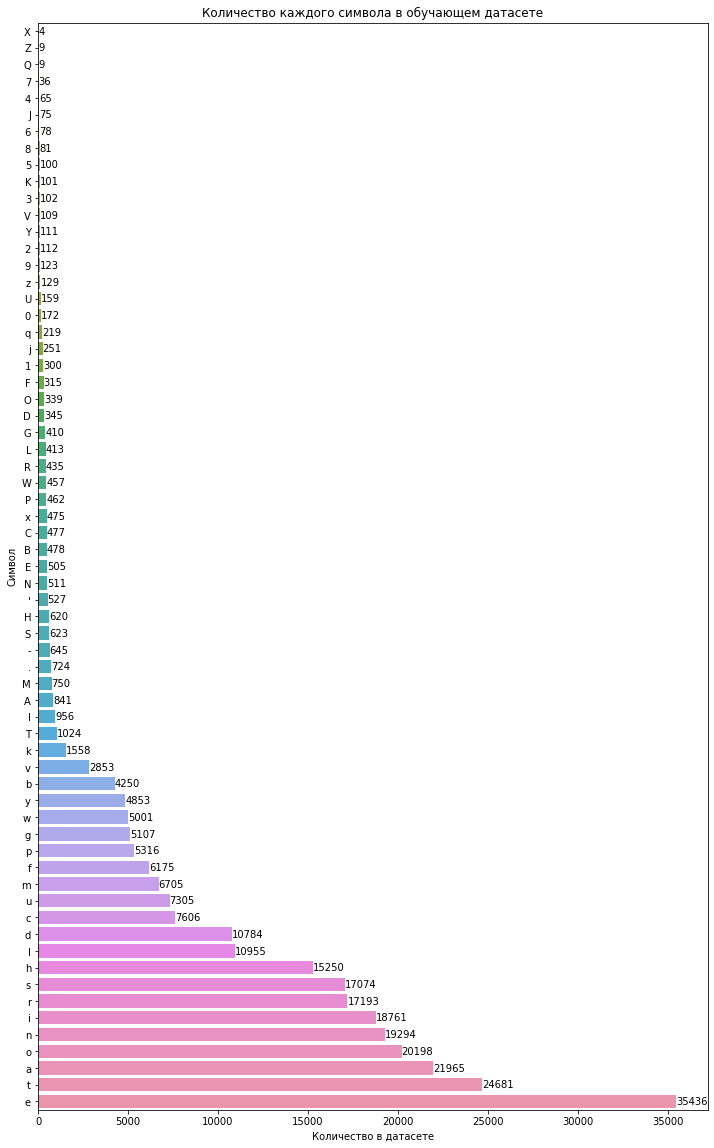

In [3]:
show_dir_info('/home/astrashnov/data/rec/iam_data/train_words')

##### Тестовый датасет:

Word number: 17755
Max word length: 21
Alphabet size: 63
Dictionary: '-.0123456789ABCDEFGHIJKLMNOPQRSTUVWYabcdefghijklmnopqrstuvwxyz


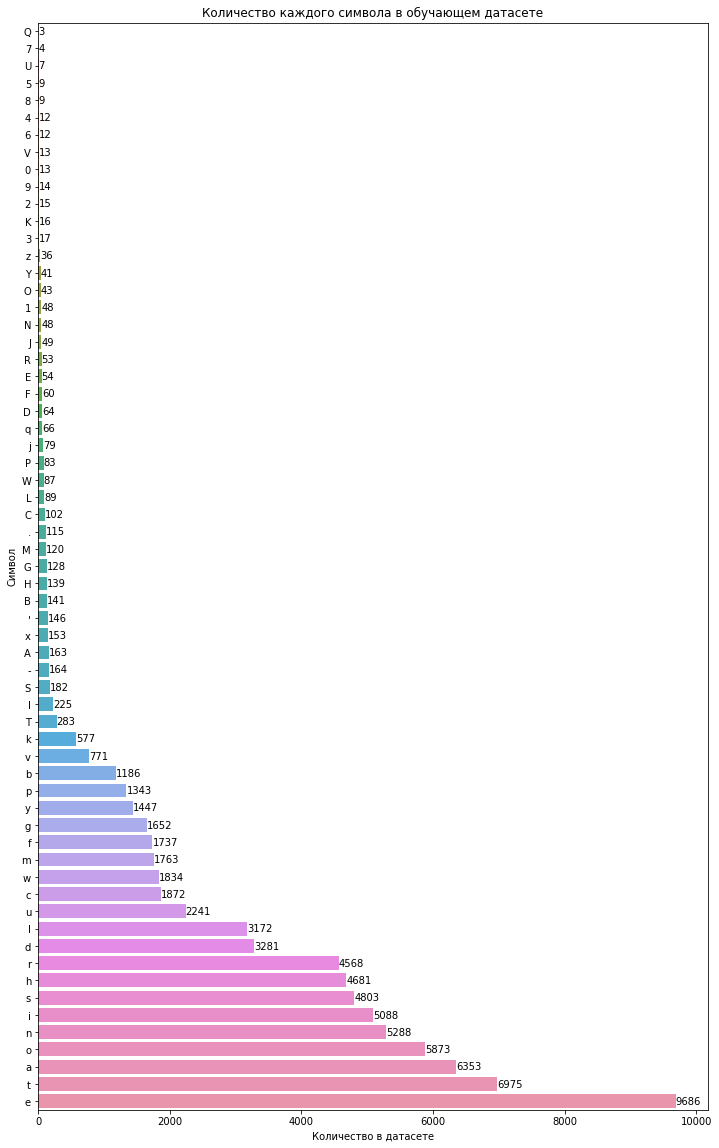

In [4]:
show_dir_info('/home/astrashnov/data/rec/iam_data/test_words')

Видно, что распределения символов в обучающем и тестовом датасетах похожи.

Посмотрим теперь на некотрые изображения из обучающего датасета:

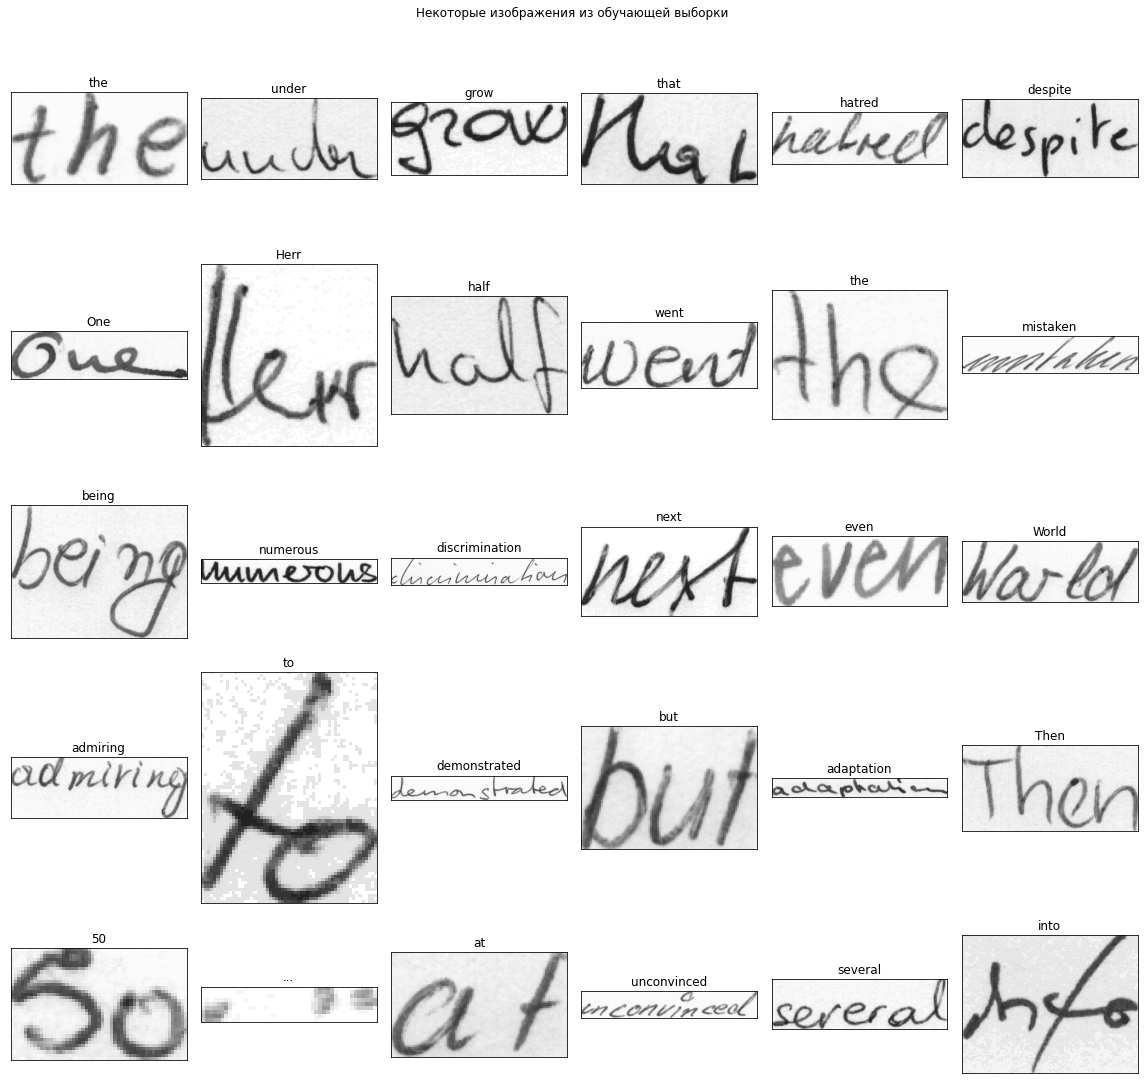

In [5]:
train_dir = '/home/astrashnov/data/rec/iam_data/train_words'
imgs = os.listdir(train_dir)
imgs = random.choices(imgs, k=30)

plt.figure(figsize=(16, 16))
for i, img in enumerate(imgs):
    label = img.split('_')[0]
    image = cv2.imread(os.path.join(train_dir, img))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(5, 6, i + 1)
    plt.imshow(image)
    plt.title(label)
    plt.xticks([], [])
    plt.yticks([], [])
plt.suptitle('Некоторые изображения из обучающей выборки')
plt.tight_layout()
plt.show()

## Тестирование моделей

In [6]:
def get_dict(filename, alphabet="'-.0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"):
    with open(filename) as f:
        lines = f.readlines()
    word_dict = {}
    for line in lines:
        l = line.strip('\n')
        if len(l) == 0:
            continue
        img_path, label = l.split('\t')[:2]
        if not set(label.lower()).issubset(alphabet):
            continue
        word_dict[pathlib.PurePath(img_path).name] = label
    return word_dict

In [7]:
def general_stat(predictions_file, target_file, long_word_min_len=10, alphabet="'-.0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"):
    pred_dict = get_dict(predictions_file, alphabet)
    target_dict = get_dict(target_file, alphabet)

    cases = ('LC + UC, all words', 'LC + UC, long words', 'MC, all words', 'MC, long words')
    if alphabet == alphabet.lower():
        cases = cases[2:]
        
    correct_num = {case: 0 for case in cases}
    edit_dis = {case: 0.0 for case in cases}
    norm_edit_dis = {case: 0.0 for case in cases}
    long_num = 0
    all_num = 0
    long_char = 0
    all_char = 0

    for name, target in target_dict.items():
        pred = pred_dict[name]
        pred_target = {'MC': (pred.lower(), target.lower())}
        if alphabet != alphabet.lower():
            pred_target['LC + UC'] = (pred, target)

        is_long = (len(target) >= long_word_min_len)

        for case, (pred, target) in pred_target.items():
            cur_edit_dis = Levenshtein.distance(pred, target)
            is_correct = int(pred == target)

            correct_num[case + ', all words'] += is_correct
            edit_dis[case + ', all words'] += cur_edit_dis
            norm_edit_dis[case + ', all words'] += cur_edit_dis / len(target)

            if is_long:
                correct_num[case + ', long words'] += is_correct
                edit_dis[case + ', long words'] += cur_edit_dis
                norm_edit_dis[case + ', long words'] += cur_edit_dis / len(target)

        all_char += len(target)
        all_num += 1

        if is_long:
            long_char += len(target)
            long_num += 1

    acc = {'Accuracy ({})'.format(case): 1.0 * correct_num / max(all_num if (case[-9:-6] == 'all') else long_num, 1)
            for case, correct_num in correct_num.items()}
    norm_edit_dis = {'Normalized edit distance 1 ({})'.format(case): dis / max(all_num if (case[-9:-6] == 'all') else long_num, 1)
            for case, dis in norm_edit_dis.items()}
    edit_dis = {'Normalized edit distance 2 ({})'.format(case): dis / max(all_char if (case[-9:-6] == 'all') else long_char, 1)
            for case, dis in edit_dis.items()}
    quality_dict = dict(**acc, **norm_edit_dis, **edit_dis)

    for key, value in quality_dict.items():
        print(f'{key}: {value}')

In [8]:
def detailed_stat(predictions_file, target_file, long_word_min_len=10, alphabet="'-.0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"):
    pred_dict = get_dict(predictions_file, alphabet)
    target_dict = get_dict(target_file, alphabet)
    lower_alphabet = ''.join(set(alphabet.lower()))

    cases = ('LC + UC, all words', 'LC + UC, long words', 'MC, all words', 'MC, long words')
    matrix1 = {'del': {char: 0 for char in alphabet}, 'ins': {char: 0 for char in alphabet}}
    matrix1 = dict(**matrix1, **{sym: {char: 0 for char in alphabet} for sym in alphabet})
    matrix2 = {'del': {char: 0 for char in lower_alphabet}, 'ins': {char: 0 for char in lower_alphabet}}
    matrix2 = dict(**matrix2, **{sym: {char: 0 for char in lower_alphabet} for sym in lower_alphabet})
    matrices = {case: copy.deepcopy(matrix1) if case[0] == 'L' else copy.deepcopy(matrix2) for case in cases}
    
    if alphabet == alphabet.lower():
        cases = cases[2:]
        matrices
    
    mistakes = []
    for name, target in target_dict.items():
        pred = pred_dict[name]
        pred_target = {'MC': (pred.lower(), target.lower())}
        if alphabet != alphabet.lower():
            pred_target['LC + UC'] = (pred, target)
        else:
            pred, target = pred.lower(), target.lower()
        
        if target != pred:
            mistakes.append((pred, target, name))

        is_long = (len(target) >= long_word_min_len)

        for case, (pred, target) in pred_target.items():
            ops = Levenshtein.editops(pred, target)
            matrices_names = [case + ', all words',]
            if is_long:
                matrices_names.append(case + ', long words')
            for matrix_name in matrices_names:
                for op in ops:
                    if op[0] == 'insert':
                        matrices[matrix_name]['ins'][target[op[2]]] += 1
                    elif op[0] == 'delete':
                        matrices[matrix_name]['del'][pred[op[1]]] += 1
                    elif op[0] == 'replace':
                        matrices[matrix_name][pred[op[1]]][target[op[2]]] += 1
                        
    tables = {}
    for case in cases:
        tables[case] = pd.DataFrame.from_dict(matrices[case]).transpose()
        
    return tables, mistakes

### Модель, обученная на словаре LC + UC + Num + Pc3

Получим предсказания обученной модели, а также правильные метки:

In [9]:
pred_file = '/home/astrashnov/PaddleOCR/output/rec/predicts_srn_original_LC_UC_Num_Pc3.txt'
target_file = '/home/astrashnov/data/rec/iam_data/rec_test.txt'

##### Качество модели:

In [10]:
general_stat(pred_file, target_file)

Accuracy (LC + UC, all words): 0.8217966769923966
Accuracy (LC + UC, long words): 0.5612535612535613
Accuracy (MC, all words): 0.8339059419881724
Accuracy (MC, long words): 0.5712250712250713
Normalized edit distance 1 (LC + UC, all words): 0.06386012299241943
Normalized edit distance 1 (LC + UC, long words): 0.0854118273191269
Normalized edit distance 1 (MC, all words): 0.05875323458998067
Normalized edit distance 1 (MC, long words): 0.08298199812647719
Normalized edit distance 2 (LC + UC, all words): 0.07009180790960452
Normalized edit distance 2 (LC + UC, long words): 0.0874983772556147
Normalized edit distance 2 (MC, all words): 0.06589235270379339
Normalized edit distance 2 (MC, long words): 0.08503180578995197


In [11]:
tables, mistakes = detailed_stat(pred_file, target_file)

Посмотрим на посимвольные таблицы ошибок для разных длин слов с учётом и без учёта регистра:

In [12]:
tables['LC + UC, all words']

'  -  .  0  1  2  3  4  5  6  7  8  9    a   b   c   d   e   f   g   h  \
del  2  0  3  0  0  0  0  0  0  0  0  0  0   48   4  48  12  89   9  14  22   
ins  4  3  3  0  1  0  1  0  0  0  0  0  0   18   3  31  10  52  10   3  22   
'    0  0  0  0  2  0  0  0  0  0  0  0  0    0   0   0   0   0   0   0   0   
-    0  0  1  0  0  0  0  0  0  0  0  0  0    0   0   0   0   2   0   0   0   
.    0  2  0  0  0  0  0  0  0  0  0  0  0    1   0   0   0   0   0   0   1   
0    0  0  0  0  0  0  0  0  0  1  0  1  0    1   0   0   0   0   0   0   0   
1    0  0  0  0  0  0  0  0  0  0  0  0  0    0   0   0   0   1   0   0   2   
2    0  0  0  0  0  0  0  0  0  0  0  0  0    2   0   0   0   0   0   0   1   
3    0  0  0  0  0  1  0  1  0  0  1  0  0    0   0   0   0   0   0   0   0   
4    0  0  0  0  0  0  0  0  0  0  0  0  0    0   0   0   0   0   0   0   0   
5    0  0  0  0  0  0  0  0  0  0  0  0  1    0   0   0   0   0   0   0   1   
6    0  0  0  0  0  0  0  0  0  0  0  0  0    0   1   0   0   0   0   0   0   
7    1  0  0  0  0  0  0  0  0  0  0  0  0    0   0   0   0   0   0   0   0   
8    0  0  0  0  0  0  1  0  0  1  0  0  0    1   0   0   0   1   1   0   2   
9    0  0  0  0  0  0  1  0  0  0  0  0  0    0   0   0   0   0   0   0   0   
a    0  1  0  0  0  0  0  0  0  0  0  0  0    0   1  10   2  72   1   1  10   
b    0  1  0  0  0  0  0  0  0  1  0  0  0    1   0   1   1   2   2   0  11   
c    0  0  0  0  0  0  0  0  0  0  0  0  0   10   0   0  22  17   0   2   3   
d    0  0  0  0  0  0  0  0  0  0  0  0  0    7   5  12   0  13   1   2   4   
e    0  0  0  0  0  0  0  0  0  1  0  0  0   33   3  12  15   0   2   2  13   
f    2  0  0  0  0  0  0  0  0  0  0  0  0    2   0   0   1   1   0   2   7   
g    0  0  0  0  0  0  0  0  0  0  0  0  0    5   0   0   2   4   2   0   2   
h    0  0  0  0  1  0  0  0  0  0  0  0  0    3  13   3   2   9   0   1   0   
i    5  1  1  0  0  0  0  0  0  0  0  0  0    6   5   1   3  20   2   1   7   
j    0  0  0  0  0  0  0  0  0  0  0  0  0    0   0   0   0   0   3   3   0   
k    0  0  0  0  0  0  0  0  0  0  0  0  0    2   2   0   3   5   0   0  12   
l    2  1  0  0  2  0  0  0  0  0  0  0  0    1  19   1  27  34  14   0  24   
m    0  0  0  0  0  0  0  0  0  0  0  0  0    3   1   5   0   5   0   0   7   
n    0  5  0  0  0  0  0  0  0  0  0  0  0   10   1   4   5  15   0  13   9   
o    1  0  0  0  0  0  0  0  0  0  0  0  0  169   6   9   7  55   3   2  13   
p    0  0  0  0  0  0  0  0  0  0  0  0  0    1   1   0   2   5  10   7   1   
q    0  0  0  0  0  0  0  0  0  0  0  0  0    2   0   0   0   0   1   5   0   
r    0  1  1  0  0  0  0  0  0  0  0  0  0   16   1   7   6   9   4   3  14   
s    3  1  0  0  0  0  0  0  1  0  0  0  0    5   5   2   6  17   2   6  10   
t    1  2  0  0  0  0  0  0  0  0  0  0  0    4   7   2  15   8  21   1  12   
u    0  0  0  0  0  0  0  1  0  0  0  0  0   25   0   2   1  13   0   1   4   
v    0  0  0  0  0  0  0  0  0  0  0  0  0    3   0   1   0   3   0   0   0   
w    0  0  0  0  0  0  0  0  0  0  0  0  0    2   0   1   1   1   0   0   1   
x    0  0  0  0  0  0  0  0  0  0  0  0  0    0   0   0   0   2   0   0   0   
y    0  3  0  0  0  0  0  1  0  0  0  0  0    3   0   0   1   7   1  12   1   
z    0  0  0  0  0  0  0  0  0  0  0  0  0    0   0   0   0   0   1   1   0   
A    0  0  0  0  0  0  0  0  0  0  0  0  0   12   0   0   0   0   0   0   0   
B    0  0  0  0  0  0  1  0  0  0  0  0  0    0   4   0   0   1   0   0   2   
C    0  0  0  0  0  0  0  0  0  0  0  0  0    0   0   7   0   1   0   0   0   
D    0  0  0  0  0  0  0  0  0  0  0  0  0    0   0   0   1   0   0   0   0   
E    0  0  0  0  0  0  0  1  0  1  0  0  0    0   0   0   0   7   0   1   0   
F    0  0  0  0  0  0  0  0  0  0  0  0  0    0   0   0   0   0  13   0   2   
G    0  0  0  0  0  0  0  0  0  0  0  0  0    0   1   0   0   0   0   3   1   
H    0  0  0  0  0  0  0  0  0  0  0  0  0    0   1   0   0   0   0   0   7   
I    0  0  0  0  2  0  0  0  0  0  0  0  0    1   0   0

In [13]:
tables['MC, all words']

-  j   s  3   b   r  7   f    a  1  4   w  8   d   n   h  q   k  9  5  x  \
del  0  1  72  0   5  59  0  11   50  0  0   7  0  14  38  23  3   4  0  0  0   
ins  3  1  63  1   2  66  0   9   19  1  0   6  0  11  26  22  0   3  0  0  1   
-    0  0   0  0   0   0  0   0    0  0  0   0  0   0   0   0  0   0  0  0  0   
j    0  0   2  0   1   0  0   3    0  0  0   1  0   0   0   0  0   0  0  0  0   
s    1  3   0  0   8  58  0   3    5  0  0  10  0   6  17  22  1   5  0  1  2   
3    0  1   2  0   0   0  1   0    0  0  1   0  0   0   0   0  0   0  0  0  0   
b    1  0   6  1   0   6  0   2    1  0  0   2  0   1   1  13  0   4  0  0  0   
r    1  1  47  0   3   0  0   5   16  0  0  19  0   6  40  18  0   5  0  0  0   
7    0  0   0  0   0   0  0   0    1  0  0   0  0   0   0   0  0   0  0  0  0   
f    0  2   4  0   1   6  0   0    5  0  0   0  0   1   2  10  0   0  0  0  0   
a    1  0  24  0   1  22  0   1    0  0  0   9  0   2  11  11  1   3  0  0  0   
1    0  0   0  0   0   0  0   0    0  0  0   0  0   0   1   2  0   0  0  0  0   
4    0  0   0  0   0   0  0   0    0  0  0   0  0   0   2   0  0   0  0  0  0   
w    0  0   4  0   0   3  0   0    2  0  0   0  0   1   1   1  0   3  0  0  0   
8    0  0   1  1   0   0  0   1    1  0  0   0  0   0   0   2  0   1  0  0  0   
d    0  1   6  0   5   4  0   1    7  0  0   1  0   0   2   4  0   2  0  0  0   
n    5  0  50  0   1  47  0   0   10  0  0  15  0   6   0   9  0   5  0  0  0   
h    0  0   1  0  14   9  0   0    3  1  0   8  0   2  16   0  0  14  0  0  0   
q    0  0   2  0   0   0  0   1    3  0  0   0  0   0   2   0  0   0  0  0  0   
k    0  0   0  0   2   2  0   0    2  0  0   0  0   3   0  15  0   0  0  0  1   
9    0  0   0  1   0   0  0   0    0  0  0   0  0   0   0   0  0   0  0  0  0   
5    0  0   1  0   0   0  0   0    0  0  0   0  0   0   1   1  0   0  1  0  0   
x    0  0   1  0   0   1  0   0    0  0  0   0  0   0   0   0  0   1  0  0  0   
6    0  0   0  0   1   0  0   0    0  0  0   0  0   0   0   0  0   0  0  0  0   
2    0  0   2  0   0   0  0   0    2  0  0   0  0   0   0   1  0   0  0  0  0   
t    2  1  30  0   7  13  0  21    8  0  0   5  0  15   1  16  0   5  0  0  1   
o    0  0  31  0   6  31  0   3  171  0  0  23  0   9  24  13  0   5  0  0  0   
u    0  0   5  0   0  14  0   0   25  0  1  17  0   1  55   4  0   3  0  0  0   
z    0  0   1  0   1   0  0   1    0  0  0   0  0   1   0   0  0   1  0  0  0   
i    1  1  11  0   5  21  0   2    7  2  0   2  0   3  18   7  0   3  0  0  0   
v    0  0   2  0   0  10  0   0    3  0  0   9  0   0   2   0  0   0  1  0  1   
g    0  1  15  0   1   2  0   2    6  0  0   1  0   2   9   3  4   2  0  0  0   
l    1  0   0  0  19  15  0  14    1  3  0   2  0  27   4  25  0  20  0  0  1   
m    0  0   7  0   1  13  0   0    3  0  0  17  0   0  68   8  0   0  0  0  0   
p    0  1  12  0   3   6  0  11    2  0  0   0  0   5   8   2  0   2  0  0  1   
y    3  0  15  0   0   4  0   1    3  0  1   2  0   1   2   1  0   1  0  0  0   
c    0  0   9  0   1   8  0   0   10  0  0   2  0  22   8   3  0   2  0  0  1   
0    0  0   0  0   0   0  0   0    1  0  0   0  1   0   0   0  0   0  0  0  0   
e    0  1  19  0   3  35  0   2   33  0  1   6  0  15  18  13  0  14  0  0  3   
'    0  0   0  0   0   0  0   0    0  2  0   0  0   0   0   0  0   0  0  0  0   
.    2  0   2  0   0   0  0   0    1  0  0   1  0   0   0   2  0   0  0  0  0   

     6  2   t    o   u  z   i   v   g   l   m   p   y   c  0   e  '  .  
del  0  0  53   68  42  0  28   2  15  38  11  19  13  48  0  90  2  3  
ins  0  0  61   26  24  1  31   3   4  37   4   5   7  33  0  53  4  3  
-    0  0   0    0   0  0   0   0   0   0   0   0   0   0  0   2  0  1  
j    0  0   1    0   0  0   0   0   3   0   0   0   1   0  0   0  0  0  
s    0  0  22    7   4  0   7   4   6   4   6   1   3   2  0  17  3  0  
3    0  1   0    0   0  0   1   0   0   0   0   0   0   0  0   0  0  0  
b    1  0   7    1   2  0   4   1   6  11   1   0   0   1  0   2  0  0  
r    0  0  16   10

In [14]:
tables['LC + UC, long words']

'  -  .  0  1  2  3  4  5  6  7  8  9   a  b  c  d   e  f  g  h  i  j  k  \
del  0  0  0  0  0  0  0  0  0  0  0  0  0   4  1  5  1   6  0  2  1  4  0  1   
ins  2  1  0  0  0  0  0  0  0  0  0  0  0   3  1  6  1  14  0  0  6  5  0  0   
'    0  0  0  0  0  0  0  0  0  0  0  0  0   0  0  0  0   0  0  0  0  0  0  0   
-    0  0  0  0  0  0  0  0  0  0  0  0  0   0  0  0  0   1  0  0  0  0  0  0   
.    0  0  0  0  0  0  0  0  0  0  0  0  0   0  0  0  0   0  0  0  0  0  0  0   
0    0  0  0  0  0  0  0  0  0  0  0  0  0   0  0  0  0   0  0  0  0  0  0  0   
1    0  0  0  0  0  0  0  0  0  0  0  0  0   0  0  0  0   0  0  0  0  0  0  0   
2    0  0  0  0  0  0  0  0  0  0  0  0  0   0  0  0  0   0  0  0  0  0  0  0   
3    0  0  0  0  0  0  0  0  0  0  0  0  0   0  0  0  0   0  0  0  0  0  0  0   
4    0  0  0  0  0  0  0  0  0  0  0  0  0   0  0  0  0   0  0  0  0  0  0  0   
5    0  0  0  0  0  0  0  0  0  0  0  0  0   0  0  0  0   0  0  0  0  0  0  0   
6    0  0  0  0  0  0  0  0  0  0  0  0  0   0  0  0  0   0  0  0  0  0  0  0   
7    0  0  0  0  0  0  0  0  0  0  0  0  0   0  0  0  0   0  0  0  0  0  0  0   
8    0  0  0  0  0  0  0  0  0  0  0  0  0   0  0  0  0   0  0  0  0  0  0  0   
9    0  0  0  0  0  0  0  0  0  0  0  0  0   0  0  0  0   0  0  0  0  0  0  0   
a    0  1  0  0  0  0  0  0  0  0  0  0  0   0  1  3  0   8  0  0  0  5  0  0   
b    0  0  0  0  0  0  0  0  0  0  0  0  0   1  0  0  0   1  0  0  0  2  0  0   
c    0  0  0  0  0  0  0  0  0  0  0  0  0   2  0  0  0   3  0  0  0  0  0  0   
d    0  0  0  0  0  0  0  0  0  0  0  0  0   0  1  2  0   4  1  0  1  2  0  1   
e    0  0  0  0  0  0  0  0  0  0  0  0  0   8  0  2  3   0  1  0  1  3  0  1   
f    0  0  0  0  0  0  0  0  0  0  0  0  0   0  0  0  0   0  0  0  0  0  0  0   
g    0  0  0  0  0  0  0  0  0  0  0  0  0   1  0  0  0   1  1  0  0  0  0  0   
h    0  0  0  0  0  0  0  0  0  0  0  0  0   0  0  1  1   0  0  0  0  3  0  0   
i    0  1  0  0  0  0  0  0  0  0  0  0  0   0  3  0  1   2  1  0  0  0  0  1   
j    0  0  0  0  0  0  0  0  0  0  0  0  0   0  0  0  0   0  0  0  0  0  0  0   
k    0  0  0  0  0  0  0  0  0  0  0  0  0   0  0  0  0   1  0  0  1  0  0  0   
l    0  0  0  0  0  0  0  0  0  0  0  0  0   1  6  0  4   4  0  0  1  1  0  0   
m    0  0  0  0  0  0  0  0  0  0  0  0  0   1  0  1  0   1  0  0  0  2  0  0   
n    0  1  0  0  0  0  0  0  0  0  0  0  0   0  1  1  1   2  0  0  0  3  0  0   
o    0  0  0  0  0  0  0  0  0  0  0  0  0  14  0  0  2   8  0  0  0  4  0  1   
p    0  0  0  0  0  0  0  0  0  0  0  0  0   0  1  0  0   2  4  3  1  1  0  0   
q    0  0  0  0  0  0  0  0  0  0  0  0  0   0  0  0  0   0  0  0  0  0  0  0   
r    0  0  0  0  0  0  0  0  0  0  0  0  0   5  0  3  1   1  0  0  2  2  0  0   
s    0  0  0  0  0  0  0  0  0  0  0  0  0   1  0  1  0   3  1  0  0  1  0  0   
t    0  1  0  0  0  0  0  0  0  0  0  0  0   3  1  1  0   2  1  0  0  1  0  3   
u    0  0  0  0  0  0  0  0  0  0  0  0  0   1  0  1  0   2  0  1  0  4  0  0   
v    0  0  0  0  0  0  0  0  0  0  0  0  0   1  0  0  0   0  0  0  0  0  0  0   
w    0  0  0  0  0  0  0  0  0  0  0  0  0   0  0  0  0   0  0  0  0  0  0  0   
x    0  0  0  0  0  0  0  0  0  0  0  0  0   0  0  0  0   0  0  0  0  0  0  0   
y    0  0  0  0  0  0  0  0  0  0  0  0  0   1  0  0  1   0  0  0  0  0  0  0   
z    0  0  0  0  0  0  0  0  0  0  0  0  0   0  0  0  0   0  0  0  0  0  0  0   
A    0  0  0  0  0  0  0  0  0  0  0  0  0   0  0  0  0   0  0  0  0  0  0  0   
B    0  0  0  0  0  0  0  0  0  0  0  0  0   0  1  0  0   0  0  0  0  0  0  0   
C    0  0  0  0  0  0  0  0  0  0  0  0  0   0  0  2  0   0  0  0  0  0  0  0   
D    0  0  0  0  0  0  0  0  0  0  0  0  0   0  0  0  1   0  0  0  0  0  0  0   
E    0  0  0  0  0  0  0  1  0  0  0  0  0   0  0  0  0   0  0  0  0  0  0  0   
F    0  0  0  0  0  0  0  0  0  0  0  0  0   0  0  0  0   0  0  0  0  0  0  0   
G    0  0  0  0  0  0  0  0  0  0  0  0  0   0  0  0  0   0  0  0  0  0  0  0   
H    0  0  0  0  0  0  0  0  0  0  0

In [15]:
tables['MC, long words']

-  j   s  3  b  r  7  f   a  1  4  w  8  d   n  h  q  k  9  5  x  6  2  \
del  0  0   8  0  1  4  0  0   5  0  0  0  0  1   4  1  0  1  0  0  0  0  0   
ins  1  0   9  0  1  9  0  0   3  0  0  1  0  1  10  6  0  0  0  0  0  0  0   
-    0  0   0  0  0  0  0  0   0  0  0  0  0  0   0  0  0  0  0  0  0  0  0   
j    0  0   0  0  0  0  0  0   0  0  0  0  0  0   0  0  0  0  0  0  0  0  0   
s    0  0   0  0  0  6  0  1   1  0  0  0  0  0   2  0  0  0  0  0  0  0  0   
3    0  0   0  0  0  0  0  0   0  0  0  0  0  0   0  0  0  0  0  0  0  0  0   
b    0  0   1  0  0  0  0  0   1  0  0  0  0  0   0  0  0  0  0  0  0  0  0   
r    0  0  10  0  0  0  0  0   5  0  0  1  0  1   9  3  0  0  0  0  0  0  0   
7    0  0   0  0  0  0  0  0   0  0  0  0  0  0   0  0  0  0  0  0  0  0  0   
f    0  0   0  0  0  0  0  0   0  0  0  0  0  0   0  0  0  0  0  0  0  0  0   
a    1  0   5  0  1  7  0  0   0  0  0  0  0  0   3  0  0  0  0  0  0  0  0   
1    0  0   0  0  0  0  0  0   0  0  0  0  0  0   0  0  0  0  0  0  0  0  0   
4    0  0   0  0  0  0  0  0   0  0  0  0  0  0   0  0  0  0  0  0  0  0  0   
w    0  0   0  0  0  0  0  0   0  0  0  0  0  0   0  0  0  0  0  0  0  0  0   
8    0  0   0  0  0  0  0  0   0  0  0  0  0  0   0  0  0  0  0  0  0  0  0   
d    0  0   0  0  1  0  0  1   0  0  0  0  0  0   1  1  0  1  0  0  0  0  0   
n    1  0   3  0  1  3  0  0   0  0  0  0  0  1   0  0  0  0  0  0  0  0  0   
h    0  0   0  0  0  2  0  0   0  0  0  0  0  1   1  0  0  0  0  0  0  0  0   
q    0  0   0  0  0  0  0  0   0  0  0  0  0  0   0  0  0  0  0  0  0  0  0   
k    0  0   0  0  0  0  0  0   0  0  0  0  0  0   0  1  0  0  0  0  0  0  0   
9    0  0   0  0  0  0  0  0   0  0  0  0  0  0   0  0  0  0  0  0  0  0  0   
5    0  0   0  0  0  0  0  0   0  0  0  0  0  0   0  0  0  0  0  0  0  0  0   
x    0  0   1  0  0  1  0  0   0  0  0  0  0  0   0  0  0  0  0  0  0  0  0   
6    0  0   0  0  0  0  0  0   0  0  0  0  0  0   0  0  0  0  0  0  0  0  0   
2    0  0   0  0  0  0  0  0   0  0  0  0  0  0   0  0  0  0  0  0  0  0  0   
t    1  0   4  0  1  2  0  1   3  0  0  0  0  0   1  2  0  3  0  0  0  0  0   
o    0  0   4  0  0  5  0  0  14  0  0  2  0  2   2  0  0  1  0  0  0  0  0   
u    0  0   0  0  0  1  0  0   1  0  0  1  0  0   8  0  0  0  0  0  0  0  0   
z    0  0   0  0  0  0  0  0   0  0  0  0  0  0   0  0  0  0  0  0  0  0  0   
i    1  0   1  0  3  4  0  1   0  0  0  1  0  1   4  0  0  1  0  0  0  0  0   
v    0  0   0  0  0  2  0  0   1  0  0  0  0  0   0  0  0  0  0  0  0  0  0   
g    0  0   0  0  0  0  0  1   1  0  0  0  0  0   3  0  0  0  0  0  0  0  0   
l    0  0   0  0  6  1  0  0   1  0  0  0  0  4   1  1  0  0  0  0  0  0  0   
m    0  0   3  0  0  1  0  0   1  0  0  1  0  0   6  0  0  0  0  0  0  0  0   
p    0  0   2  0  1  2  0  4   0  0  0  0  0  0   1  1  0  0  0  0  0  0  0   
y    0  0   0  0  0  0  0  0   1  0  0  0  0  1   1  0  0  0  0  0  0  0  0   
c    0  0   2  0  0  2  0  0   2  0  0  0  0  0   4  0  0  0  0  0  1  0  0   
0    0  0   0  0  0  0  0  0   0  0  0  0  0  0   0  0  0  0  0  0  0  0  0   
e    0  0   2  0  0  3  0  1   8  0  1  0  0  3   4  1  0  1  0  0  0  0  0   
'    0  0   0  0  0  0  0  0   0  0  0  0  0  0   0  0  0  0  0  0  0  0  0   
.    0  0   0  0  0  0  0  0   0  0  0  0  0  0   0  0  0  0  0  0  0  0  0   

     t   o  u  z  i  v  g  l  m  p  y  c  0   e  '  .  
del  9   8  2  0  4  1  2  3  0  7  4  5  0   6  0  0  
ins  5   4  4  1  5  0  0  5  0  0  2  7  0  14  2  0  
-    0   0  0  0  0  0  0  0  0  0  0  0  0   1  0  0  
j    0   0  0  0  0  0  0  0  0  0  0  0  0   0  0  0  
s    4   0  0  0  1  1  0  1  0  0  1  1  0   3  0  0  
3    0   0  0  0  0  0  0  0  0  0  0  0  0   0  0  0  
b    0   0  0  0  2  0  0  2  0  0  0  0  0   1  0  0  
r    3   0  1  0  2  3  0  1  1  2  1  3  0   1  0  0  
7    0   0  0  0  0  0  0  0  0  0  0  0  0   0  0  0  
f    0   0  0  0  0  0  0  0  1  0  0  0  0   0  0  0  
a    1  12  4  1  5  1  0  3  1  0  0  3  0   8  0  0  
1    0   0  0 

Посмотрим на некоторые неправильно распознанные изображения:

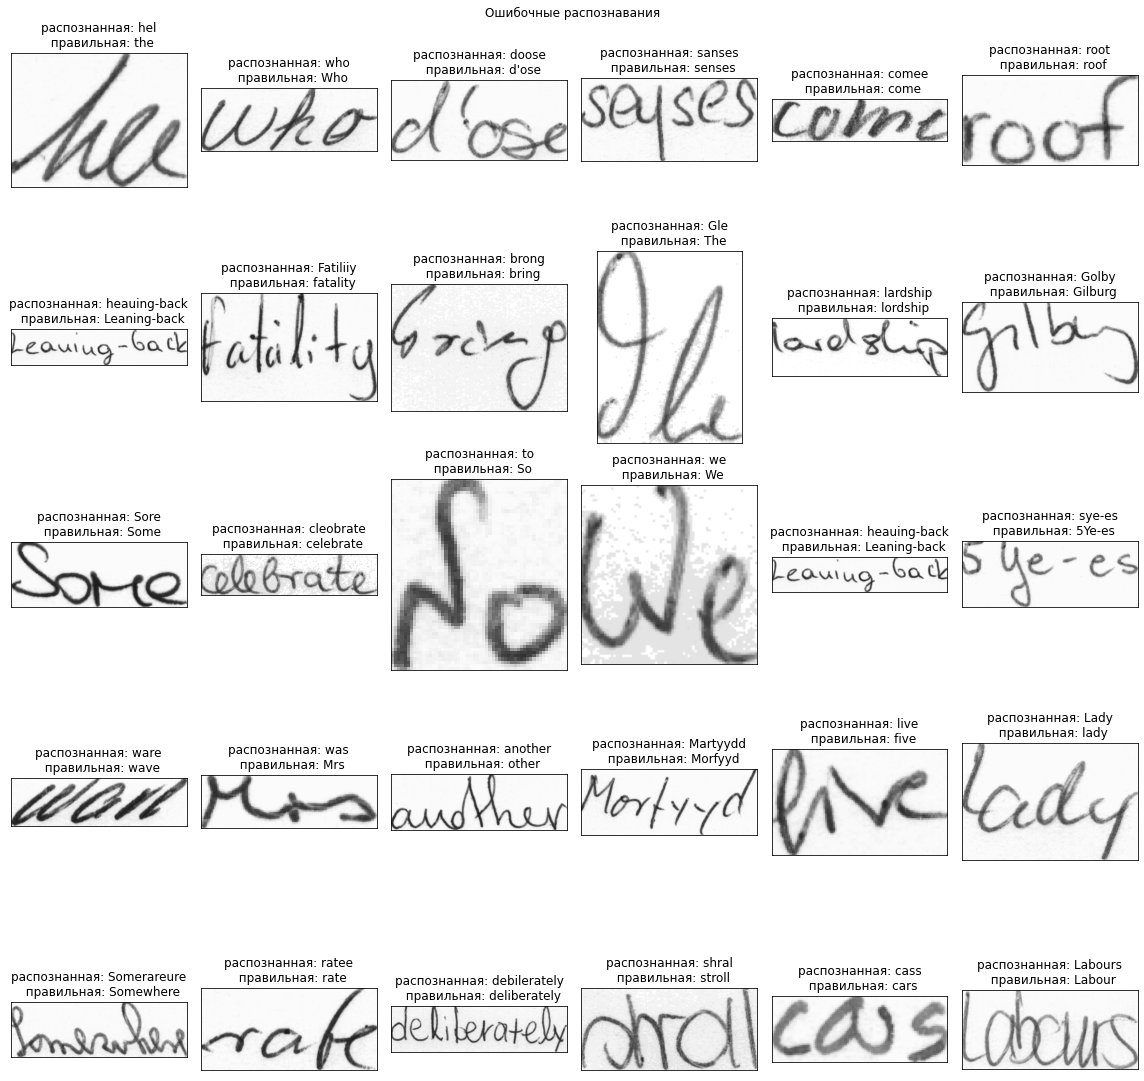

In [16]:
test_dir = '/home/astrashnov/data/rec/iam_data/test_words'
some_mistakes = random.choices(mistakes, k = 30)

plt.figure(figsize=(16, 16))
for i, (pred, target, name) in enumerate(some_mistakes):
    image = cv2.imread(os.path.join(test_dir, name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(5, 6, i + 1)
    plt.imshow(image)
    plt.title(f'распознанная: {pred}\n  правильная: {target}')
    plt.xticks([], [])
    plt.yticks([], [])
plt.suptitle('Ошибочные распознавания')
plt.tight_layout()
plt.show()

Видно, что большая часть ошибок - пропущенные или лишние символы в слове. Объяснение этому даётся в статье про SRN: если на этапе нахождения визуального контекста модель неправильно определила количество символов, она уже не может исправить это на этапе учёта семантического контекста. Посчитаем долю таких ошибок:

In [17]:
wrong_len_count = 0
for pred, target, _ in mistakes:
    if len(pred) != len(target):
        wrong_len_count += 1
wrong_len_percent = round(wrong_len_count / len(mistakes) * 100, 2)
print('Доля ошибок, связанных с неправильным определением длины слова: {}%'.format(wrong_len_percent))

Доля ошибок, связанных с неправильным определением длины слова: 33.25%


Видим, что на самом деле всего в трети случаев модель неправильно определяет количество символов. То есть большая часть приходится всё же на их неправильное распознавание. Компенсировать его можно за счёт семантического контекста, за который отвечает модуль GSRM. Тогда имеет смысл попробовать увеличить коэффицент при gsrm_loss в вычислении итогового лосса.

### Модель, обученная на словаре MC

In [18]:
!python3 tools/infer_rec.py -c configs/rec/srn_original_MC.yml -o Global.pretrained_model=./output/rec/srn_original_MC/best_accuracy Global.load_static_weights=false Global.infer_img=/home/astrashnov/data/rec/iam_data/test_words/

/home/astrashnov/anaconda3/envs/paddle_env/lib/python3.7/site-packages/skimage/morphology/_skeletonize.py:241: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  0, 1, 1, 0, 0, 1, 0, 0, 0], dtype=np.bool)
/home/astrashnov/anaconda3/envs/paddle_env/lib/python3.7/site-packages/skimage/morphology/_skeletonize.py:256: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecat

[2021/08/05 06:01:39] root INFO: 	 result: ('eem', 0.8926642)
[2021/08/05 06:01:39] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/'em_n04-114-08-00.png
[2021/08/05 06:01:39] root INFO: 	 result: ('lem', 0.9376969)
[2021/08/05 06:01:39] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/'ll_n02-054-09-08.png
[2021/08/05 06:01:40] root INFO: 	 result: ('l', 0.97779876)
[2021/08/05 06:01:40] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/'ll_n02-062-01-01.png
[2021/08/05 06:01:40] root INFO: 	 result: ('ll', 0.97554725)
[2021/08/05 06:01:40] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/'ll_n02-120-05-08.png
[2021/08/05 06:01:40] root INFO: 	 result: ('ll', 0.9999809)
[2021/08/05 06:01:40] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/'ll_n04-149-04-07.png
[2021/08/05 06:01:40] root INFO: 	 result: ('ill', 0.7869849)
[2021/08/05 06:01:40] root INFO: infer_img: /home/astrashnov/data/rec/

[2021/08/05 06:01:42] root INFO: 	 result: ('an', 0.45300925)
[2021/08/05 06:01:42] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/..._m02-048-10-09.png
[2021/08/05 06:01:42] root INFO: 	 result: ('on', 0.8134408)
[2021/08/05 06:01:42] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/..._m03-006-02-01.png
[2021/08/05 06:01:42] root INFO: 	 result: ('now', 0.5738868)
[2021/08/05 06:01:42] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/..._m03-013-05-11.png
[2021/08/05 06:01:42] root INFO: 	 result: ('oo', 0.5938027)
[2021/08/05 06:01:42] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/..._m03-033-07-02.png
[2021/08/05 06:01:42] root INFO: 	 result: ('r', 0.311578)
[2021/08/05 06:01:42] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/..._m03-110-09-07.png
[2021/08/05 06:01:42] root INFO: 	 result: ('n', 0.3813831)
[2021/08/05 06:01:42] root INFO: infer_img: /home/astrashnov/data/rec/iam_d

[2021/08/05 06:01:44] root INFO: 	 result: ('r', 0.99948716)
[2021/08/05 06:01:44] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/24_f04-071-08-00.png
[2021/08/05 06:01:44] root INFO: 	 result: ('y', 0.9972357)
[2021/08/05 06:01:44] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/2_d04-096-03-01.png
[2021/08/05 06:01:44] root INFO: 	 result: ('', nan)
[2021/08/05 06:01:44] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/39_c04-110-03-03.png
[2021/08/05 06:01:44] root INFO: 	 result: ('s', 0.40171602)
[2021/08/05 06:01:44] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/3Mis'_n02-154-04-07.png
[2021/08/05 06:01:44] root INFO: 	 result: ('is', 0.99485886)
[2021/08/05 06:01:44] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/3Mistah_n02-154-03-05.png
[2021/08/05 06:01:44] root INFO: 	 result: ('irttah', 0.9057162)
[2021/08/05 06:01:44] root INFO: infer_img: /home/astrashnov/data/rec/iam_da

[2021/08/05 06:01:46] root INFO: 	 result: ('of', 0.9991757)
[2021/08/05 06:01:46] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/A_f07-096-03-07.png
[2021/08/05 06:01:46] root INFO: 	 result: ('t', 0.5248425)
[2021/08/05 06:01:46] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/A_g01-027-02-03.png
[2021/08/05 06:01:46] root INFO: 	 result: ('t', 0.75027883)
[2021/08/05 06:01:46] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/A_g01-027-05-03.png
[2021/08/05 06:01:46] root INFO: 	 result: ('t', 0.992949)
[2021/08/05 06:01:46] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/A_g01-031-05-05.png
[2021/08/05 06:01:46] root INFO: 	 result: ('', nan)
[2021/08/05 06:01:46] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/A_g01-074-01-07.png
[2021/08/05 06:01:46] root INFO: 	 result: ('a', 0.7269206)
[2021/08/05 06:01:46] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/A_m01-

[2021/08/05 06:01:48] root INFO: 	 result: ('lley', 0.99952316)
[2021/08/05 06:01:48] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Almost_p03-173-00-00.png
[2021/08/05 06:01:48] root INFO: 	 result: ('lmost', 0.9950551)
[2021/08/05 06:01:48] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Already_m04-072-05-06.png
[2021/08/05 06:01:48] root INFO: 	 result: ('lready', 0.98545146)
[2021/08/05 06:01:48] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Also_g03-043-04-05.png
[2021/08/05 06:01:48] root INFO: 	 result: ('also', 0.97427064)
[2021/08/05 06:01:48] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Altar_d04-016-07-06.png
[2021/08/05 06:01:48] root INFO: 	 result: ('ltar', 0.89969134)
[2021/08/05 06:01:48] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Altar_d04-032-05-04.png
[2021/08/05 06:01:48] root INFO: 	 result: ('ftar', 0.8767021)
[2021/08/05 06:01:48] root INFO: infer_img:

[2021/08/05 06:01:50] root INFO: 	 result: ('nd', 0.9999803)
[2021/08/05 06:01:50] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Angelina_m02-048-05-04.png
[2021/08/05 06:01:50] root INFO: 	 result: ('ngoina', 0.9394018)
[2021/08/05 06:01:50] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Angelina_m02-048-10-06.png
[2021/08/05 06:01:50] root INFO: 	 result: ('ngeine', 0.8481116)
[2021/08/05 06:01:50] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Anglia_e06-000-06-08.png
[2021/08/05 06:01:50] root INFO: 	 result: ('nglia', 0.9059597)
[2021/08/05 06:01:50] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Anglican_d05-025-08-05.png
[2021/08/05 06:01:50] root INFO: 	 result: ('nglican', 0.9981161)
[2021/08/05 06:01:50] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Any_d06-056-02-00.png
[2021/08/05 06:01:50] root INFO: 	 result: ('ny', 0.99822044)
[2021/08/05 06:01:50] root INFO: infer_

[2021/08/05 06:01:52] root INFO: 	 result: ('e', 0.60187244)
[2021/08/05 06:01:52] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/BBC_m01-084-07-03.png
[2021/08/05 06:01:52] root INFO: 	 result: ('e', 0.4695031)
[2021/08/05 06:01:52] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Baal-meon_d03-117-06-06.png
[2021/08/05 06:01:52] root INFO: 	 result: ('aalmeon', 0.78591377)
[2021/08/05 06:01:52] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Bacon_d05-025-02-02.png
[2021/08/05 06:01:52] root INFO: 	 result: ('acon', 0.99982685)
[2021/08/05 06:01:52] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Balicou_n02-037-08-03.png
[2021/08/05 06:01:53] root INFO: 	 result: ('alican', 0.9437165)
[2021/08/05 06:01:53] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Balicou_n02-040-05-02.png
[2021/08/05 06:01:53] root INFO: 	 result: ('alican', 0.9251723)
[2021/08/05 06:01:53] root INFO: infer_img

[2021/08/05 06:01:54] root INFO: 	 result: ('lack', 0.9996564)
[2021/08/05 06:01:54] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Black_n04-202-06-00.png
[2021/08/05 06:01:54] root INFO: 	 result: ('lack', 0.993815)
[2021/08/05 06:01:54] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Blanc_n01-020-04-04.png
[2021/08/05 06:01:55] root INFO: 	 result: ('lanc', 0.91344064)
[2021/08/05 06:01:55] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Blanche_n02-037-02-00.png
[2021/08/05 06:01:55] root INFO: 	 result: ('lanch', 0.997499)
[2021/08/05 06:01:55] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Blasted_n06-100-07-08.png
[2021/08/05 06:01:55] root INFO: 	 result: ('lasted', 0.99887127)
[2021/08/05 06:01:55] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Blockhouse_n04-202-05-08.png
[2021/08/05 06:01:55] root INFO: 	 result: ('lochhouse', 0.9477317)
[2021/08/05 06:01:55] root INFO: in

[2021/08/05 06:01:57] root INFO: 	 result: ('enyans', 0.96288204)
[2021/08/05 06:01:57] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/But_d04-101-03-03.png
[2021/08/05 06:01:57] root INFO: 	 result: ('ut', 0.9999688)
[2021/08/05 06:01:57] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/But_d05-030-04-02.png
[2021/08/05 06:01:57] root INFO: 	 result: ('ut', 0.999988)
[2021/08/05 06:01:57] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/But_d05-030-06-05.png
[2021/08/05 06:01:57] root INFO: 	 result: ('ut', 0.9999975)
[2021/08/05 06:01:57] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/But_e06-010-01-11.png
[2021/08/05 06:01:57] root INFO: 	 result: ('ut', 0.99999493)
[2021/08/05 06:01:57] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/But_e06-021-06-00.png
[2021/08/05 06:01:57] root INFO: 	 result: ('est', 0.70400816)
[2021/08/05 06:01:57] root INFO: infer_img: /home/astrashnov/data/r

[2021/08/05 06:01:59] root INFO: 	 result: ('airis', 0.7838894)
[2021/08/05 06:01:59] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Cadwallader_m04-078-05-00.png
[2021/08/05 06:01:59] root INFO: 	 result: ('advallades', 0.9138977)
[2021/08/05 06:01:59] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Cadwallader_m04-081-07-09.png
[2021/08/05 06:01:59] root INFO: 	 result: ('advallades', 0.9343994)
[2021/08/05 06:01:59] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Cadwallader_m04-131-01-02.png
[2021/08/05 06:01:59] root INFO: 	 result: ('advaalader', 0.9158219)
[2021/08/05 06:01:59] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Caine_m03-110-09-00.png
[2021/08/05 06:01:59] root INFO: 	 result: ('aine', 0.99991214)
[2021/08/05 06:01:59] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Caine_m03-118-00-04.png
[2021/08/05 06:01:59] root INFO: 	 result: ('onke', 0.8627528)
[2021/08/05 06

[2021/08/05 06:02:01] root INFO: 	 result: ('hhoir', 0.9303069)
[2021/08/05 06:02:01] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Christ_d05-021-02-09.png
[2021/08/05 06:02:01] root INFO: 	 result: ('hnist', 0.9495077)
[2021/08/05 06:02:01] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Christian_f07-069-07-06.png
[2021/08/05 06:02:01] root INFO: 	 result: ('hristian', 0.9978986)
[2021/08/05 06:02:01] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Christian_m03-020-01-02.png
[2021/08/05 06:02:01] root INFO: 	 result: ('hurisian', 0.8794919)
[2021/08/05 06:02:01] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Christianity_g03-049-07-00.png
[2021/08/05 06:02:01] root INFO: 	 result: ('inisianniyy', 0.82551426)
[2021/08/05 06:02:01] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Christmas_m02-048-03-08.png
[2021/08/05 06:02:01] root INFO: 	 result: ('hristmas', 0.99729407)
[2021/08/

[2021/08/05 06:02:03] root INFO: 	 result: ('zechoslovak', 0.9950977)
[2021/08/05 06:02:03] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/D.S.C._n04-060-04-01.png
[2021/08/05 06:02:03] root INFO: 	 result: ('ob', 0.6327404)
[2021/08/05 06:02:03] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/D.j._p03-047-07-05.png
[2021/08/05 06:02:03] root INFO: 	 result: ('i', 0.5349902)
[2021/08/05 06:02:03] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Dai_m04-030-00-03.png
[2021/08/05 06:02:03] root INFO: 	 result: ('as', 0.9328095)
[2021/08/05 06:02:03] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Dai_m04-030-03-09.png
[2021/08/05 06:02:03] root INFO: 	 result: ('than', 0.7531793)
[2021/08/05 06:02:03] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Dai_m04-072-01-08.png
[2021/08/05 06:02:03] root INFO: 	 result: ('ai', 0.9988828)
[2021/08/05 06:02:03] root INFO: infer_img: /home/astrashnov

[2021/08/05 06:02:05] root INFO: 	 result: ('or', 0.97476435)
[2021/08/05 06:02:05] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Doc_p02-115-00-00.png
[2021/08/05 06:02:05] root INFO: 	 result: ('oc', 0.76522696)
[2021/08/05 06:02:05] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Doc_p02-135-00-00.png
[2021/08/05 06:02:05] root INFO: 	 result: ('oe', 0.8479626)
[2021/08/05 06:02:05] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Don't_n04-202-00-05.png
[2021/08/05 06:02:05] root INFO: 	 result: ('ont', 0.9999637)
[2021/08/05 06:02:05] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Don't_p02-115-04-06.png
[2021/08/05 06:02:05] root INFO: 	 result: ('ont', 0.99992114)
[2021/08/05 06:02:05] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Don't_p03-163-05-01.png
[2021/08/05 06:02:05] root INFO: 	 result: ('ont', 0.999671)
[2021/08/05 06:02:05] root INFO: infer_img: /home/astrashnov/da

[2021/08/05 06:02:07] root INFO: 	 result: ('ric', 0.79544306)
[2021/08/05 06:02:07] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Esau_f07-021b-06-03.png
[2021/08/05 06:02:07] root INFO: 	 result: ('beeon', 0.78163016)
[2021/08/05 06:02:07] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Esther_d07-085-06-05.png
[2021/08/05 06:02:07] root INFO: 	 result: ('sther', 0.9855469)
[2021/08/05 06:02:07] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Eth_m04-107-00-02.png
[2021/08/05 06:02:07] root INFO: 	 result: ('th', 0.9998621)
[2021/08/05 06:02:07] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Eth_m04-131-04-01.png
[2021/08/05 06:02:07] root INFO: 	 result: ('the', 0.88019365)
[2021/08/05 06:02:07] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/European_c04-165-08-02.png
[2021/08/05 06:02:07] root INFO: 	 result: ('uropean', 0.999978)
[2021/08/05 06:02:07] root INFO: infer_img: /home

[2021/08/05 06:02:09] root INFO: 	 result: ('or', 0.99999297)
[2021/08/05 06:02:09] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/For_n01-020-00-00.png
[2021/08/05 06:02:09] root INFO: 	 result: ('or', 0.9999733)
[2021/08/05 06:02:09] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/For_n02-033-01-00.png
[2021/08/05 06:02:09] root INFO: 	 result: ('or', 0.99998045)
[2021/08/05 06:02:09] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/For_n02-062-05-09.png
[2021/08/05 06:02:09] root INFO: 	 result: ('or', 0.9999972)
[2021/08/05 06:02:09] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Forever_d05-030-00-00.png
[2021/08/05 06:02:09] root INFO: 	 result: ('foreerr', 0.9587115)
[2021/08/05 06:02:09] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Forrest's_n02-062-03-02.png
[2021/08/05 06:02:09] root INFO: 	 result: ('orest', 0.9683544)
[2021/08/05 06:02:09] root INFO: infer_img: /home/astr

[2021/08/05 06:02:11] root INFO: 	 result: ('gavin', 0.9375149)
[2021/08/05 06:02:11] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Gavin_p02-076-05-06.png
[2021/08/05 06:02:11] root INFO: 	 result: ('gaain', 0.8333076)
[2021/08/05 06:02:11] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Gavin_p02-081-04-00.png
[2021/08/05 06:02:11] root INFO: 	 result: ('govin', 0.83729583)
[2021/08/05 06:02:11] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Gavin_p02-090-02-01.png
[2021/08/05 06:02:11] root INFO: 	 result: ('favin', 0.8835906)
[2021/08/05 06:02:11] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Gavin_p02-105-00-10.png
[2021/08/05 06:02:11] root INFO: 	 result: ('avin', 0.9989386)
[2021/08/05 06:02:11] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Gavin_p02-105-03-09.png
[2021/08/05 06:02:11] root INFO: 	 result: ('avin', 0.99499446)
[2021/08/05 06:02:11] root INFO: infer_img: /h

[2021/08/05 06:02:13] root INFO: 	 result: ('beorge', 0.9859648)
[2021/08/05 06:02:13] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/George_n04-156-01-01.png
[2021/08/05 06:02:13] root INFO: 	 result: ('earge', 0.99381924)
[2021/08/05 06:02:13] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/German_f07-000-06-04.png
[2021/08/05 06:02:13] root INFO: 	 result: ('ermann', 0.9253171)
[2021/08/05 06:02:13] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/German_f07-000b-05-02.png
[2021/08/05 06:02:13] root INFO: 	 result: ('erman', 0.9999941)
[2021/08/05 06:02:13] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/German_n04-048-02-08.png
[2021/08/05 06:02:13] root INFO: 	 result: ('erman', 0.9999994)
[2021/08/05 06:02:13] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Germany_g04-022-01-00.png
[2021/08/05 06:02:13] root INFO: 	 result: ('ermany', 0.9999995)
[2021/08/05 06:02:13] root INFO: in

[2021/08/05 06:02:15] root INFO: 	 result: ('osper', 0.9399473)
[2021/08/05 06:02:15] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Gospel_d01-123-02-03.png
[2021/08/05 06:02:15] root INFO: 	 result: ('ospel', 0.9825848)
[2021/08/05 06:02:15] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Grace's_p02-135-06-07.png
[2021/08/05 06:02:15] root INFO: 	 result: ('races', 0.98969793)
[2021/08/05 06:02:15] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Graybury_n02-062-00-08.png
[2021/08/05 06:02:15] root INFO: 	 result: ('raytury', 0.971848)
[2021/08/05 06:02:15] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Graybury_n02-114-05-00.png
[2021/08/05 06:02:15] root INFO: 	 result: ('breeyorry', 0.9189875)
[2021/08/05 06:02:15] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Greek_d01-052-01-02.png
[2021/08/05 06:02:16] root INFO: 	 result: ('reek', 0.99947906)
[2021/08/05 06:02:16] root INFO

[2021/08/05 06:02:18] root INFO: 	 result: ('e', 0.9994025)
[2021/08/05 06:02:18] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/He_g03-043-04-00.png
[2021/08/05 06:02:18] root INFO: 	 result: ('e', 0.9999939)
[2021/08/05 06:02:18] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/He_g07-000b-02-02.png
[2021/08/05 06:02:18] root INFO: 	 result: ('e', 0.9964282)
[2021/08/05 06:02:18] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/He_m01-049-00-00.png
[2021/08/05 06:02:18] root INFO: 	 result: ('e', 0.99997914)
[2021/08/05 06:02:18] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/He_m01-049-03-03.png
[2021/08/05 06:02:18] root INFO: 	 result: ('e', 0.99985516)
[2021/08/05 06:02:18] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/He_m01-049-08-03.png
[2021/08/05 06:02:18] root INFO: 	 result: ('e', 0.99996376)
[2021/08/05 06:02:18] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/te

[2021/08/05 06:02:20] root INFO: 	 result: ('e', 0.9997491)
[2021/08/05 06:02:20] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/He_p06-104-00-00.png
[2021/08/05 06:02:20] root INFO: 	 result: ('e', 0.9999932)
[2021/08/05 06:02:20] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Heather_m01-049-02-00.png
[2021/08/05 06:02:20] root INFO: 	 result: ('eatle', 0.9704382)
[2021/08/05 06:02:20] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Heather_m01-121-02-05.png
[2021/08/05 06:02:20] root INFO: 	 result: ('eather', 0.9998474)
[2021/08/05 06:02:20] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Heather_m01-136-06-00.png
[2021/08/05 06:02:20] root INFO: 	 result: ('eather', 0.99998516)
[2021/08/05 06:02:20] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Heaven_m02-048-07-00.png
[2021/08/05 06:02:20] root INFO: 	 result: ('eaven', 0.9984875)
[2021/08/05 06:02:20] root INFO: infer_img: /ho

[2021/08/05 06:02:22] root INFO: 	 result: ('ow', 0.9998294)
[2021/08/05 06:02:22] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/How_f07-006-00-00.png
[2021/08/05 06:02:22] root INFO: 	 result: ('ow', 0.999976)
[2021/08/05 06:02:22] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/How_n02-062-04-05.png
[2021/08/05 06:02:22] root INFO: 	 result: ('ow', 0.99999577)
[2021/08/05 06:02:22] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/How_p06-069-00-05.png
[2021/08/05 06:02:23] root INFO: 	 result: ('on', 0.9982115)
[2021/08/05 06:02:23] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Hubert_n02-028-07-00.png
[2021/08/05 06:02:23] root INFO: 	 result: ('futtt', 0.64185137)
[2021/08/05 06:02:23] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Hubert_n02-037-05-06.png
[2021/08/05 06:02:23] root INFO: 	 result: ('tubet', 0.9948144)
[2021/08/05 06:02:23] root INFO: infer_img: /home/astrashnov/

[2021/08/05 06:02:25] root INFO: 	 result: ('', nan)
[2021/08/05 06:02:25] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/I_n02-009-00-01.png
[2021/08/05 06:02:26] root INFO: 	 result: ('', nan)
[2021/08/05 06:02:26] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/I_n02-009-02-02.png
[2021/08/05 06:02:26] root INFO: 	 result: ('', nan)
[2021/08/05 06:02:26] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/I_n02-040-03-11.png
[2021/08/05 06:02:26] root INFO: 	 result: ('', nan)
[2021/08/05 06:02:26] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/I_n02-040-06-03.png
[2021/08/05 06:02:26] root INFO: 	 result: ('', nan)
[2021/08/05 06:02:26] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/I_n02-045-00-02.png
[2021/08/05 06:02:26] root INFO: 	 result: ('', nan)
[2021/08/05 06:02:26] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/I_n02-045-02-03.png
[2021/08/05 06:02:26] 

[2021/08/05 06:02:29] root INFO: 	 result: ('a', 0.9983923)
[2021/08/05 06:02:29] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/I_n06-133-04-13.png
[2021/08/05 06:02:29] root INFO: 	 result: ('a', 0.5121822)
[2021/08/05 06:02:29] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/I_n06-140-04-07.png
[2021/08/05 06:02:29] root INFO: 	 result: ('a', 0.999762)
[2021/08/05 06:02:29] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/I_p01-174-00-03.png
[2021/08/05 06:02:29] root INFO: 	 result: ('a', 0.9926877)
[2021/08/05 06:02:29] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/I_p02-000-05-05.png
[2021/08/05 06:02:29] root INFO: 	 result: ('a', 0.8676303)
[2021/08/05 06:02:29] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/I_p02-027-02-09.png
[2021/08/05 06:02:29] root INFO: 	 result: ('of', 0.997529)
[2021/08/05 06:02:29] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/I

[2021/08/05 06:02:32] root INFO: 	 result: ('n', 0.99999976)
[2021/08/05 06:02:32] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/In_d05-025-00-00.png
[2021/08/05 06:02:32] root INFO: 	 result: ('n', 0.99999964)
[2021/08/05 06:02:32] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/In_d06-020-00-00.png
[2021/08/05 06:02:32] root INFO: 	 result: ('n', 0.9668878)
[2021/08/05 06:02:32] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/In_d06-063-00-00.png
[2021/08/05 06:02:32] root INFO: 	 result: ('n', 0.99463636)
[2021/08/05 06:02:32] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/In_e06-010-00-00.png
[2021/08/05 06:02:32] root INFO: 	 result: ('n', 0.99992955)
[2021/08/05 06:02:32] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/In_e06-053-00-08.png
[2021/08/05 06:02:32] root INFO: 	 result: ('n', 0.81583184)
[2021/08/05 06:02:32] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/t

[2021/08/05 06:02:35] root INFO: 	 result: ('t', 0.9999862)
[2021/08/05 06:02:35] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/It_f07-039a-02-07.png
[2021/08/05 06:02:35] root INFO: 	 result: ('t', 0.99447775)
[2021/08/05 06:02:35] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/It_g01-004-00-00.png
[2021/08/05 06:02:35] root INFO: 	 result: ('t', 0.9999949)
[2021/08/05 06:02:35] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/It_g01-016-02-04.png
[2021/08/05 06:02:35] root INFO: 	 result: ('t', 0.9999989)
[2021/08/05 06:02:35] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/It_g01-019-00-00.png
[2021/08/05 06:02:35] root INFO: 	 result: ('t', 0.9999994)
[2021/08/05 06:02:35] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/It_g01-019-04-05.png
[2021/08/05 06:02:35] root INFO: 	 result: ('t', 0.9999652)
[2021/08/05 06:02:35] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test

[2021/08/05 06:02:38] root INFO: 	 result: ('erpy', 0.8821925)
[2021/08/05 06:02:38] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Jesuit_d05-030-06-01.png
[2021/08/05 06:02:38] root INFO: 	 result: ('essit', 0.9294292)
[2021/08/05 06:02:38] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Jesus_d06-020-01-05.png
[2021/08/05 06:02:38] root INFO: 	 result: ('toons', 0.8359324)
[2021/08/05 06:02:38] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Jochai_d04-047-04-00.png
[2021/08/05 06:02:38] root INFO: 	 result: ('ochas', 0.9142436)
[2021/08/05 06:02:38] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/John's_n02-109-04-02.png
[2021/08/05 06:02:38] root INFO: 	 result: ('foins', 0.9538971)
[2021/08/05 06:02:38] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/John_d01-052-04-02.png
[2021/08/05 06:02:38] root INFO: 	 result: ('ohn', 0.9820852)
[2021/08/05 06:02:38] root INFO: infer_img: /ho

[2021/08/05 06:02:41] root INFO: 	 result: ('knol', 0.6564744)
[2021/08/05 06:02:41] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Knows_d06-025-05-05.png
[2021/08/05 06:02:41] root INFO: 	 result: ('knows', 0.9757649)
[2021/08/05 06:02:41] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Kyrkby_g01-074-03-02.png
[2021/08/05 06:02:41] root INFO: 	 result: ('yrkby', 0.95359343)
[2021/08/05 06:02:41] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Labour_g03-052-06-07.png
[2021/08/05 06:02:41] root INFO: 	 result: ('abours', 0.99999636)
[2021/08/05 06:02:41] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Labour_g03-052-09-03.png
[2021/08/05 06:02:41] root INFO: 	 result: ('abour', 0.9962489)
[2021/08/05 06:02:41] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Labour_g03-052-10-08.png
[2021/08/05 06:02:41] root INFO: 	 result: ('abour', 0.9973768)
[2021/08/05 06:02:41] root INFO: infer_i

[2021/08/05 06:02:44] root INFO: 	 result: ('ittle', 0.9992754)
[2021/08/05 06:02:44] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Little_n03-120-07-03.png
[2021/08/05 06:02:44] root INFO: 	 result: ('ittle', 0.99986494)
[2021/08/05 06:02:44] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Little_p03-027-07-00.png
[2021/08/05 06:02:44] root INFO: 	 result: ('little', 0.99999285)
[2021/08/05 06:02:44] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Liverpool_p03-012-04-02.png
[2021/08/05 06:02:44] root INFO: 	 result: ('liverpod', 0.9762692)
[2021/08/05 06:02:44] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Living_d04-101-02-00.png
[2021/08/05 06:02:44] root INFO: 	 result: ('hiving', 0.9983464)
[2021/08/05 06:02:44] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Llangrwl_m04-038-00-06.png
[2021/08/05 06:02:44] root INFO: 	 result: ('longni', 0.64133483)
[2021/08/05 06:02:44] root 

[2021/08/05 06:02:47] root INFO: 	 result: ('adeleine', 0.94339204)
[2021/08/05 06:02:47] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Magyar_f07-069-03-05.png
[2021/08/05 06:02:47] root INFO: 	 result: ('aggar', 0.99899226)
[2021/08/05 06:02:47] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Magyar_f07-069-09-02.png
[2021/08/05 06:02:47] root INFO: 	 result: ('agyar', 0.97540295)
[2021/08/05 06:02:47] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Make_n04-060-00-01.png
[2021/08/05 06:02:47] root INFO: 	 result: ('ake', 0.99990445)
[2021/08/05 06:02:47] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Malcolm_c04-139-03-03.png
[2021/08/05 06:02:47] root INFO: 	 result: ('alcolas', 0.8998928)
[2021/08/05 06:02:47] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Malin_g03-032-06-08.png
[2021/08/05 06:02:47] root INFO: 	 result: ('ain', 0.8646979)
[2021/08/05 06:02:47] root INFO: infer

[2021/08/05 06:02:49] root INFO: 	 result: ('ishuah', 0.8783819)
[2021/08/05 06:02:49] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Miss_f04-039-02-07.png
[2021/08/05 06:02:49] root INFO: 	 result: ('iss', 0.99998313)
[2021/08/05 06:02:49] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Miss_f04-087-03-06.png
[2021/08/05 06:02:50] root INFO: 	 result: ('iss', 0.999994)
[2021/08/05 06:02:50] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Miss_n06-074-05-11.png
[2021/08/05 06:02:50] root INFO: 	 result: ('ins', 0.86866075)
[2021/08/05 06:02:50] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Mistah_n02-157-05-06.png
[2021/08/05 06:02:50] root INFO: 	 result: ('istah', 0.9980992)
[2021/08/05 06:02:50] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Moabite_d03-117-05-08.png
[2021/08/05 06:02:50] root INFO: 	 result: ('oatoith', 0.78556573)
[2021/08/05 06:02:50] root INFO: infer_img: /ho

[2021/08/05 06:02:52] root INFO: 	 result: ('r', 0.7518493)
[2021/08/05 06:02:52] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Mr_m03-033-02-06.png
[2021/08/05 06:02:52] root INFO: 	 result: ('r', 0.9998872)
[2021/08/05 06:02:52] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Mr_m03-110-01-00.png
[2021/08/05 06:02:52] root INFO: 	 result: ('r', 0.9999999)
[2021/08/05 06:02:52] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Mr_m03-110-08-02.png
[2021/08/05 06:02:52] root INFO: 	 result: ('r', 0.9999988)
[2021/08/05 06:02:52] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Mr_m03-110-09-03.png
[2021/08/05 06:02:52] root INFO: 	 result: ('r', 0.9999418)
[2021/08/05 06:02:52] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Mr_m03-114-02-00.png
[2021/08/05 06:02:52] root INFO: 	 result: ('r', 0.9983808)
[2021/08/05 06:02:52] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_w

[2021/08/05 06:02:55] root INFO: 	 result: ('o', 0.9999151)
[2021/08/05 06:02:55] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/None_g01-039-00-00.png
[2021/08/05 06:02:55] root INFO: 	 result: ('ane', 0.9695344)
[2021/08/05 06:02:55] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Norfolk_e06-026-08-06.png
[2021/08/05 06:02:55] root INFO: 	 result: ('arfoel', 0.684706)
[2021/08/05 06:02:55] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Northampton_g01-070-05-06.png
[2021/08/05 06:02:55] root INFO: 	 result: ('outhampton', 0.995366)
[2021/08/05 06:02:55] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Northern_c04-150-03-00.png
[2021/08/05 06:02:55] root INFO: 	 result: ('orthern', 0.99989176)
[2021/08/05 06:02:55] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Northern_f07-046a-00-04.png
[2021/08/05 06:02:55] root INFO: 	 result: ('orthern', 0.9999607)
[2021/08/05 06:02:55] root IN

[2021/08/05 06:02:57] root INFO: 	 result: ('nly', 0.99996156)
[2021/08/05 06:02:57] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Opposing_g01-004-03-10.png
[2021/08/05 06:02:57] root INFO: 	 result: ('pposing', 0.9999613)
[2021/08/05 06:02:57] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Or_d07-096-00-00.png
[2021/08/05 06:02:57] root INFO: 	 result: ('r', 0.999577)
[2021/08/05 06:02:57] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Or_m03-020-03-10.png
[2021/08/05 06:02:57] root INFO: 	 result: ('or', 0.88856286)
[2021/08/05 06:02:57] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Or_n06-111-00-10.png
[2021/08/05 06:02:57] root INFO: 	 result: ('r', 0.99829274)
[2021/08/05 06:02:57] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Oral_d04-096-06-09.png
[2021/08/05 06:02:57] root INFO: 	 result: ('ora', 0.9975939)
[2021/08/05 06:02:57] root INFO: infer_img: /home/astrashnov/dat

[2021/08/05 06:03:00] root INFO: 	 result: ('hilip', 0.9999975)
[2021/08/05 06:03:00] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Philip_p06-058-05-05.png
[2021/08/05 06:03:00] root INFO: 	 result: ('hilip', 0.99998224)
[2021/08/05 06:03:00] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Philip_p06-058-07-04.png
[2021/08/05 06:03:00] root INFO: 	 result: ('hilip', 0.99999315)
[2021/08/05 06:03:00] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Philip_p06-096-05-01.png
[2021/08/05 06:03:00] root INFO: 	 result: ('hilip', 0.99930793)
[2021/08/05 06:03:00] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Piers'_n02-151-06-01.png
[2021/08/05 06:03:00] root INFO: 	 result: ('ier', 0.99116135)
[2021/08/05 06:03:00] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Piers_n02-033-03-03.png
[2021/08/05 06:03:00] root INFO: 	 result: ('iers', 0.98799706)
[2021/08/05 06:03:00] root INFO: infer_i

[2021/08/05 06:03:02] root INFO: 	 result: ('uueled', 0.6442092)
[2021/08/05 06:03:02] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Quietly_m04-107-09-02.png
[2021/08/05 06:03:02] root INFO: 	 result: ('uietly', 0.9962842)
[2021/08/05 06:03:02] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Quixotic_f07-073-08-00.png
[2021/08/05 06:03:02] root INFO: 	 result: ('nniotic', 0.8623045)
[2021/08/05 06:03:02] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/R._d07-082-06-00.png
[2021/08/05 06:03:02] root INFO: 	 result: ('r', 0.9893194)
[2021/08/05 06:03:02] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/R._d07-085-05-00.png
[2021/08/05 06:03:02] root INFO: 	 result: ('r', 0.81270254)
[2021/08/05 06:03:02] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/R._d07-089-03-06.png
[2021/08/05 06:03:02] root INFO: 	 result: ('', nan)
[2021/08/05 06:03:02] root INFO: infer_img: /home/astrashnov/dat

[2021/08/05 06:03:05] root INFO: 	 result: ('oy', 0.9983891)
[2021/08/05 06:03:05] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Royal_n04-060-03-05.png
[2021/08/05 06:03:05] root INFO: 	 result: ('aya', 0.9985387)
[2021/08/05 06:03:05] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Rubric_d05-021-01-07.png
[2021/08/05 06:03:05] root INFO: 	 result: ('ubric', 0.99800223)
[2021/08/05 06:03:05] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/SHAMIR_d04-012-02-02.png
[2021/08/05 06:03:05] root INFO: 	 result: ('thniu', 0.7276845)
[2021/08/05 06:03:05] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/SOME_f07-000-00-00.png
[2021/08/05 06:03:05] root INFO: 	 result: ('some', 0.850373)
[2021/08/05 06:03:05] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/SOME_f07-000b-00-00.png
[2021/08/05 06:03:05] root INFO: 	 result: ('ome', 0.9998712)
[2021/08/05 06:03:05] root INFO: infer_img: /home/ast

[2021/08/05 06:03:07] root INFO: 	 result: ('hangirs', 0.9833454)
[2021/08/05 06:03:07] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Shamir_d04-012-00-02.png
[2021/08/05 06:03:07] root INFO: 	 result: ('shamir', 0.9893814)
[2021/08/05 06:03:07] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Shamir_d04-012-06-02.png
[2021/08/05 06:03:07] root INFO: 	 result: ('haamir', 0.9714511)
[2021/08/05 06:03:07] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Shamir_d04-016-02-04.png
[2021/08/05 06:03:07] root INFO: 	 result: ('shamir', 0.97836447)
[2021/08/05 06:03:07] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Shamir_d04-016-04-02.png
[2021/08/05 06:03:07] root INFO: 	 result: ('shomir', 0.9820075)
[2021/08/05 06:03:07] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Shamir_d04-021-00-04.png
[2021/08/05 06:03:07] root INFO: 	 result: ('haair', 0.9228447)
[2021/08/05 06:03:07] root INFO: i

[2021/08/05 06:03:10] root INFO: 	 result: ('ir', 0.99148977)
[2021/08/05 06:03:10] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Sir_n02-109-04-01.png
[2021/08/05 06:03:10] root INFO: 	 result: ('ir', 0.99999285)
[2021/08/05 06:03:10] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Sir_n02-114-04-06.png
[2021/08/05 06:03:10] root INFO: 	 result: ('ir', 0.9999555)
[2021/08/05 06:03:10] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Sir_n02-120-00-06.png
[2021/08/05 06:03:10] root INFO: 	 result: ('ir', 0.99988455)
[2021/08/05 06:03:10] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Sir_n02-127-01-01.png
[2021/08/05 06:03:10] root INFO: 	 result: ('ir', 0.9688163)
[2021/08/05 06:03:10] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Six_m04-246-05-05.png
[2021/08/05 06:03:10] root INFO: 	 result: ('ix', 0.9999939)
[2021/08/05 06:03:10] root INFO: infer_img: /home/astrashnov/data/rec/i

[2021/08/05 06:03:13] root INFO: 	 result: ('t', 0.99996233)
[2021/08/05 06:03:13] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/St_g01-008-05-04.png
[2021/08/05 06:03:13] root INFO: 	 result: ('t', 0.9986482)
[2021/08/05 06:03:13] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Stan_m04-131-03-04.png
[2021/08/05 06:03:13] root INFO: 	 result: ('tan', 0.99973494)
[2021/08/05 06:03:13] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Start_m04-043-03-03.png
[2021/08/05 06:03:13] root INFO: 	 result: ('ttto', 0.653865)
[2021/08/05 06:03:13] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Static_m02-059-05-02.png
[2021/08/05 06:03:13] root INFO: 	 result: ('tatic', 0.9992647)
[2021/08/05 06:03:13] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Station_f04-074-02-00.png
[2021/08/05 06:03:13] root INFO: 	 result: ('tation', 0.99999195)
[2021/08/05 06:03:13] root INFO: infer_img: /home/astra

[2021/08/05 06:03:16] root INFO: 	 result: ('estament', 0.9993079)
[2021/08/05 06:03:16] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Thackeray_f07-084a-04-02.png
[2021/08/05 06:03:16] root INFO: 	 result: ('hackeray', 0.9770366)
[2021/08/05 06:03:16] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Thackeray_f07-084b-03-02.png
[2021/08/05 06:03:16] root INFO: 	 result: ('hackera', 0.9961694)
[2021/08/05 06:03:16] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Thank_m04-231-02-05.png
[2021/08/05 06:03:16] root INFO: 	 result: ('hank', 0.99873716)
[2021/08/05 06:03:16] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/That_d04-028-04-05.png
[2021/08/05 06:03:16] root INFO: 	 result: ('hat', 0.99960953)
[2021/08/05 06:03:16] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/That_d04-101-05-03.png
[2021/08/05 06:03:16] root INFO: 	 result: ('hot', 0.983578)
[2021/08/05 06:03:16] root INFO: i

[2021/08/05 06:03:19] root INFO: 	 result: ('he', 0.99983263)
[2021/08/05 06:03:19] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/The_d06-067-07-02.png
[2021/08/05 06:03:19] root INFO: 	 result: ('he', 0.9999425)
[2021/08/05 06:03:19] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/The_d06-086-00-00.png
[2021/08/05 06:03:19] root INFO: 	 result: ('he', 0.993683)
[2021/08/05 06:03:19] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/The_d06-086-03-00.png
[2021/08/05 06:03:19] root INFO: 	 result: ('he', 0.99941546)
[2021/08/05 06:03:19] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/The_d07-085-04-00.png
[2021/08/05 06:03:19] root INFO: 	 result: ('he', 0.9999903)
[2021/08/05 06:03:19] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/The_d07-085-05-05.png
[2021/08/05 06:03:19] root INFO: 	 result: ('he', 0.9998896)
[2021/08/05 06:03:19] root INFO: infer_img: /home/astrashnov/data/rec/iam

[2021/08/05 06:03:22] root INFO: 	 result: ('he', 0.9999966)
[2021/08/05 06:03:22] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/The_m02-095-00-00.png
[2021/08/05 06:03:22] root INFO: 	 result: ('he', 0.997164)
[2021/08/05 06:03:22] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/The_m04-038-02-02.png
[2021/08/05 06:03:22] root INFO: 	 result: ('hhe', 0.83799464)
[2021/08/05 06:03:22] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/The_m04-038-03-06.png
[2021/08/05 06:03:22] root INFO: 	 result: ('he', 0.9958838)
[2021/08/05 06:03:22] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/The_m04-061-04-07.png
[2021/08/05 06:03:22] root INFO: 	 result: ('the', 0.878565)
[2021/08/05 06:03:22] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/The_m04-072-00-00.png
[2021/08/05 06:03:22] root INFO: 	 result: ('he', 0.9999925)
[2021/08/05 06:03:22] root INFO: infer_img: /home/astrashnov/data/rec/iam

[2021/08/05 06:03:25] root INFO: 	 result: ('hut', 0.7238519)
[2021/08/05 06:03:25] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/There_d07-089-06-00.png
[2021/08/05 06:03:25] root INFO: 	 result: ('here', 0.9999988)
[2021/08/05 06:03:25] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/There_f04-057-03-03.png
[2021/08/05 06:03:25] root INFO: 	 result: ('here', 0.9999941)
[2021/08/05 06:03:25] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/There_f04-079-03-08.png
[2021/08/05 06:03:25] root INFO: 	 result: ('here', 0.9999964)
[2021/08/05 06:03:25] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/There_f07-016-00-00.png
[2021/08/05 06:03:25] root INFO: 	 result: ('here', 0.9999981)
[2021/08/05 06:03:25] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/There_f07-081a-04-00.png
[2021/08/05 06:03:25] root INFO: 	 result: ('here', 0.9999824)
[2021/08/05 06:03:25] root INFO: infer_img: /home/as

[2021/08/05 06:03:28] root INFO: 	 result: ('his', 0.99991816)
[2021/08/05 06:03:28] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/This_d06-041-01-06.png
[2021/08/05 06:03:28] root INFO: 	 result: ('his', 0.99959326)
[2021/08/05 06:03:28] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/This_d07-093-04-00.png
[2021/08/05 06:03:28] root INFO: 	 result: ('his', 0.9999959)
[2021/08/05 06:03:28] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/This_d07-096-02-06.png
[2021/08/05 06:03:28] root INFO: 	 result: ('his', 0.9999986)
[2021/08/05 06:03:28] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/This_e06-000-00-00.png
[2021/08/05 06:03:28] root INFO: 	 result: ('his', 0.9995486)
[2021/08/05 06:03:28] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/This_e06-053-04-08.png
[2021/08/05 06:03:28] root INFO: 	 result: ('his', 0.99999064)
[2021/08/05 06:03:28] root INFO: infer_img: /home/astrashnov

[2021/08/05 06:03:31] root INFO: 	 result: ('om', 0.970934)
[2021/08/05 06:03:31] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Torah_d04-101-01-03.png
[2021/08/05 06:03:31] root INFO: 	 result: ('orah', 0.9975632)
[2021/08/05 06:03:31] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Torah_d04-101-02-05.png
[2021/08/05 06:03:31] root INFO: 	 result: ('orah', 0.9876565)
[2021/08/05 06:03:31] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Toss_n03-126-01-05.png
[2021/08/05 06:03:31] root INFO: 	 result: ('os', 0.9895937)
[2021/08/05 06:03:31] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Towards_g04-022-03-00.png
[2021/08/05 06:03:31] root INFO: 	 result: ('owards', 0.9999344)
[2021/08/05 06:03:31] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Town_n06-111-00-12.png
[2021/08/05 06:03:31] root INFO: 	 result: ('oon', 0.91999596)
[2021/08/05 06:03:31] root INFO: infer_img: /home/astra

[2021/08/05 06:03:34] root INFO: 	 result: ('esuvius', 0.99999523)
[2021/08/05 06:03:34] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Victorian_e01-055-05-02.png
[2021/08/05 06:03:34] root INFO: 	 result: ('ictorian', 0.9999166)
[2021/08/05 06:03:34] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Victorian_f07-006-03-04.png
[2021/08/05 06:03:34] root INFO: 	 result: ('ictorian', 0.99998474)
[2021/08/05 06:03:34] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Vienne_g01-004-04-08.png
[2021/08/05 06:03:34] root INFO: 	 result: ('ienre', 0.87964946)
[2021/08/05 06:03:34] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Vienne_g01-008-00-09.png
[2021/08/05 06:03:34] root INFO: 	 result: ('ieane', 0.9601542)
[2021/08/05 06:03:34] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/W.C.U._m02-069-07-07.png
[2021/08/05 06:03:34] root INFO: 	 result: ('lll', 0.76603013)
[2021/08/05 06:03:34] roo

[2021/08/05 06:03:37] root INFO: 	 result: ('het', 0.66383284)
[2021/08/05 06:03:37] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/What_n02-120-05-01.png
[2021/08/05 06:03:37] root INFO: 	 result: ('or', 0.6735471)
[2021/08/05 06:03:37] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/What_n02-151-06-04.png
[2021/08/05 06:03:37] root INFO: 	 result: ('hat', 0.99963886)
[2021/08/05 06:03:37] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/What_n03-066-00-09.png
[2021/08/05 06:03:37] root INFO: 	 result: ('hat', 0.9991167)
[2021/08/05 06:03:37] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/What_n03-066-02-00.png
[2021/08/05 06:03:37] root INFO: 	 result: ('hat', 0.9811588)
[2021/08/05 06:03:37] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/What_p03-072-02-01.png
[2021/08/05 06:03:37] root INFO: 	 result: ('hat', 0.9999744)
[2021/08/05 06:03:37] root INFO: infer_img: /home/astrashnov/d

[2021/08/05 06:03:40] root INFO: 	 result: ('es', 0.99998087)
[2021/08/05 06:03:40] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Yes_n06-100-06-13.png
[2021/08/05 06:03:40] root INFO: 	 result: ('es', 0.99988717)
[2021/08/05 06:03:40] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Yes_p01-174-00-01.png
[2021/08/05 06:03:40] root INFO: 	 result: ('es', 0.9998121)
[2021/08/05 06:03:40] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Yet_e06-021-02-03.png
[2021/08/05 06:03:40] root INFO: 	 result: ('et', 0.9999746)
[2021/08/05 06:03:40] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/Yet_g03-000-01-00.png
[2021/08/05 06:03:40] root INFO: 	 result: ('et', 0.9983065)
[2021/08/05 06:03:40] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/York_g01-067-06-03.png
[2021/08/05 06:03:40] root INFO: 	 result: ('ork', 0.9999521)
[2021/08/05 06:03:40] root INFO: infer_img: /home/astrashnov/data/rec/

[2021/08/05 06:03:43] root INFO: 	 result: ('a', 0.9999999)
[2021/08/05 06:03:43] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/a_c04-144-07-06.png
[2021/08/05 06:03:43] root INFO: 	 result: ('a', 0.99999964)
[2021/08/05 06:03:43] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/a_c04-150-01-04.png
[2021/08/05 06:03:43] root INFO: 	 result: ('a', 0.99999976)
[2021/08/05 06:03:43] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/a_c04-150-02-09.png
[2021/08/05 06:03:43] root INFO: 	 result: ('a', 0.99999964)
[2021/08/05 06:03:43] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/a_c04-150-06-06.png
[2021/08/05 06:03:43] root INFO: 	 result: ('a', 1.0)
[2021/08/05 06:03:43] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/a_c04-150-06-11.png
[2021/08/05 06:03:43] root INFO: 	 result: ('a', 0.99998283)
[2021/08/05 06:03:43] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/a_

[2021/08/05 06:03:46] root INFO: 	 result: ('a', 0.99998915)
[2021/08/05 06:03:46] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/a_d06-037-01-01.png
[2021/08/05 06:03:46] root INFO: 	 result: ('a', 0.999998)
[2021/08/05 06:03:46] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/a_d06-037-04-03.png
[2021/08/05 06:03:46] root INFO: 	 result: ('a', 0.99997663)
[2021/08/05 06:03:46] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/a_d06-037-07-05.png
[2021/08/05 06:03:46] root INFO: 	 result: ('a', 0.99999654)
[2021/08/05 06:03:46] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/a_d06-041-02-04.png
[2021/08/05 06:03:46] root INFO: 	 result: ('a', 0.9986305)
[2021/08/05 06:03:46] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/a_d06-041-04-00.png
[2021/08/05 06:03:46] root INFO: 	 result: ('a', 0.9999795)
[2021/08/05 06:03:46] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_word

[2021/08/05 06:03:49] root INFO: 	 result: ('a', 0.9999771)
[2021/08/05 06:03:49] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/a_f04-032-01-10.png
[2021/08/05 06:03:49] root INFO: 	 result: ('a', 0.9999994)
[2021/08/05 06:03:49] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/a_f04-032-05-04.png
[2021/08/05 06:03:49] root INFO: 	 result: ('a', 1.0)
[2021/08/05 06:03:49] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/a_f04-035-04-08.png
[2021/08/05 06:03:49] root INFO: 	 result: ('a', 0.9999999)
[2021/08/05 06:03:49] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/a_f04-039-04-01.png
[2021/08/05 06:03:49] root INFO: 	 result: ('a', 1.0)
[2021/08/05 06:03:49] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/a_f04-039-07-00.png
[2021/08/05 06:03:49] root INFO: 	 result: ('a', 0.99999976)
[2021/08/05 06:03:49] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/a_f04-039-0

[2021/08/05 06:03:52] root INFO: 	 result: ('a', 0.9999995)
[2021/08/05 06:03:52] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/a_f07-039a-05-03.png
[2021/08/05 06:03:52] root INFO: 	 result: ('a', 0.9999981)
[2021/08/05 06:03:52] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/a_f07-042a-01-00.png
[2021/08/05 06:03:52] root INFO: 	 result: ('a', 0.9999893)
[2021/08/05 06:03:52] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/a_f07-042a-03-00.png
[2021/08/05 06:03:52] root INFO: 	 result: ('a', 0.9998938)
[2021/08/05 06:03:52] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/a_f07-042a-03-07.png
[2021/08/05 06:03:52] root INFO: 	 result: ('a', 0.9999993)
[2021/08/05 06:03:52] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/a_f07-042a-06-01.png
[2021/08/05 06:03:52] root INFO: 	 result: ('a', 0.9999976)
[2021/08/05 06:03:52] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_w

[2021/08/05 06:03:55] root INFO: 	 result: ('a', 0.99999964)
[2021/08/05 06:03:55] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/a_g01-034-08-02.png
[2021/08/05 06:03:55] root INFO: 	 result: ('a', 0.9999994)
[2021/08/05 06:03:55] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/a_g01-039-09-06.png
[2021/08/05 06:03:55] root INFO: 	 result: ('a', 0.9999907)
[2021/08/05 06:03:55] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/a_g01-043-08-02.png
[2021/08/05 06:03:55] root INFO: 	 result: ('a', 0.9999039)
[2021/08/05 06:03:55] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/a_g01-045-04-05.png
[2021/08/05 06:03:55] root INFO: 	 result: ('a', 0.9999982)
[2021/08/05 06:03:55] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/a_g01-067-00-05.png
[2021/08/05 06:03:55] root INFO: 	 result: ('a', 0.9999981)
[2021/08/05 06:03:55] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words

[2021/08/05 06:03:58] root INFO: 	 result: ('a', 0.9999857)
[2021/08/05 06:03:58] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/a_m01-121-01-05.png
[2021/08/05 06:03:58] root INFO: 	 result: ('a', 0.999997)
[2021/08/05 06:03:58] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/a_m01-121-03-05.png
[2021/08/05 06:03:58] root INFO: 	 result: ('a', 0.9999988)
[2021/08/05 06:03:58] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/a_m01-121-07-08.png
[2021/08/05 06:03:58] root INFO: 	 result: ('a', 0.999997)
[2021/08/05 06:03:58] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/a_m01-125-09-02.png
[2021/08/05 06:03:58] root INFO: 	 result: ('a', 1.0)
[2021/08/05 06:03:58] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/a_m01-125-10-00.png
[2021/08/05 06:03:58] root INFO: 	 result: ('a', 0.99999905)
[2021/08/05 06:03:58] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/a_m01-1

[2021/08/05 06:04:01] root INFO: 	 result: ('a', 1.0)
[2021/08/05 06:04:01] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/a_m06-042-02-03.png
[2021/08/05 06:04:01] root INFO: 	 result: ('a', 0.99999845)
[2021/08/05 06:04:01] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/a_m06-048-03-06.png
[2021/08/05 06:04:01] root INFO: 	 result: ('a', 0.99999845)
[2021/08/05 06:04:01] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/a_m06-067-03-07.png
[2021/08/05 06:04:01] root INFO: 	 result: ('a', 0.9999993)
[2021/08/05 06:04:01] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/a_m06-098-01-03.png
[2021/08/05 06:04:01] root INFO: 	 result: ('a', 0.9999999)
[2021/08/05 06:04:01] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/a_n01-000-00-02.png
[2021/08/05 06:04:01] root INFO: 	 result: ('a', 0.99999976)
[2021/08/05 06:04:01] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/a_n

[2021/08/05 06:04:04] root INFO: 	 result: ('a', 0.9999995)
[2021/08/05 06:04:04] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/a_n04-052-03-06.png
[2021/08/05 06:04:04] root INFO: 	 result: ('a', 1.0)
[2021/08/05 06:04:04] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/a_n04-060-00-03.png
[2021/08/05 06:04:04] root INFO: 	 result: ('a', 0.9999418)
[2021/08/05 06:04:04] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/a_n04-060-03-01.png
[2021/08/05 06:04:04] root INFO: 	 result: ('a', 0.999987)
[2021/08/05 06:04:04] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/a_n04-060-05-01.png
[2021/08/05 06:04:04] root INFO: 	 result: ('a', 0.99999905)
[2021/08/05 06:04:04] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/a_n04-060-05-06.png
[2021/08/05 06:04:04] root INFO: 	 result: ('a', 0.9999999)
[2021/08/05 06:04:04] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/a_n04-

[2021/08/05 06:04:07] root INFO: 	 result: ('a', 0.99997234)
[2021/08/05 06:04:07] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/a_p02-022-07-05.png
[2021/08/05 06:04:07] root INFO: 	 result: ('a', 0.9999994)
[2021/08/05 06:04:07] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/a_p02-027-03-05.png
[2021/08/05 06:04:07] root INFO: 	 result: ('a', 0.9999999)
[2021/08/05 06:04:07] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/a_p02-069-00-02.png
[2021/08/05 06:04:07] root INFO: 	 result: ('a', 0.9999968)
[2021/08/05 06:04:07] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/a_p02-076-02-02.png
[2021/08/05 06:04:07] root INFO: 	 result: ('a', 0.9999995)
[2021/08/05 06:04:07] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/a_p02-076-04-05.png
[2021/08/05 06:04:07] root INFO: 	 result: ('a', 0.99999917)
[2021/08/05 06:04:07] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_word

[2021/08/05 06:04:10] root INFO: 	 result: ('able', 0.9999974)
[2021/08/05 06:04:10] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/able_g03-032-02-02.png
[2021/08/05 06:04:10] root INFO: 	 result: ('able', 0.99998736)
[2021/08/05 06:04:10] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/able_m02-048-08-06.png
[2021/08/05 06:04:10] root INFO: 	 result: ('able', 0.9998864)
[2021/08/05 06:04:10] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/able_m04-238-02-09.png
[2021/08/05 06:04:10] root INFO: 	 result: ('able', 0.99999785)
[2021/08/05 06:04:10] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/able_m06-056-02-05.png
[2021/08/05 06:04:10] root INFO: 	 result: ('ald', 0.99491614)
[2021/08/05 06:04:10] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/able_n01-031-00-07.png
[2021/08/05 06:04:10] root INFO: 	 result: ('able', 0.99998426)
[2021/08/05 06:04:10] root INFO: infer_img: /home/astr

[2021/08/05 06:04:13] root INFO: 	 result: ('abimplly', 0.7703087)
[2021/08/05 06:04:13] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/absolute_d01-052-07-02.png
[2021/08/05 06:04:13] root INFO: 	 result: ('absolute', 0.99991715)
[2021/08/05 06:04:13] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/absolute_m02-112-01-02.png
[2021/08/05 06:04:13] root INFO: 	 result: ('absolute', 0.9999951)
[2021/08/05 06:04:13] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/absolutely_f07-101b-02-06.png
[2021/08/05 06:04:13] root INFO: 	 result: ('absuaieey', 0.67584676)
[2021/08/05 06:04:13] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/absolutely_n02-104-05-03.png
[2021/08/05 06:04:13] root INFO: 	 result: ('aesolakly', 0.8349263)
[2021/08/05 06:04:13] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/absorption_p01-155-08-03.png
[2021/08/05 06:04:13] root INFO: 	 result: ('absorption', 0.99985087)

[2021/08/05 06:04:16] root INFO: 	 result: ('added', 0.99888307)
[2021/08/05 06:04:16] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/added_d07-100-03-01.png
[2021/08/05 06:04:16] root INFO: 	 result: ('added', 0.9999855)
[2021/08/05 06:04:16] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/added_f07-032a-02-03.png
[2021/08/05 06:04:16] root INFO: 	 result: ('added', 0.9999849)
[2021/08/05 06:04:16] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/added_m06-056-04-03.png
[2021/08/05 06:04:16] root INFO: 	 result: ('added', 0.9999932)
[2021/08/05 06:04:16] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/added_m06-083-05-10.png
[2021/08/05 06:04:16] root INFO: 	 result: ('added', 0.9999925)
[2021/08/05 06:04:16] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/added_n06-111-01-04.png
[2021/08/05 06:04:16] root INFO: 	 result: ('added', 0.9999938)
[2021/08/05 06:04:16] root INFO: infer_img: 

[2021/08/05 06:04:19] root INFO: 	 result: ('after', 0.99954355)
[2021/08/05 06:04:19] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/after_m03-118-00-01.png
[2021/08/05 06:04:19] root INFO: 	 result: ('after', 0.9984086)
[2021/08/05 06:04:19] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/after_n01-000-05-08.png
[2021/08/05 06:04:19] root INFO: 	 result: ('after', 0.9999994)
[2021/08/05 06:04:19] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/after_n04-202-03-11.png
[2021/08/05 06:04:19] root INFO: 	 result: ('after', 0.99999857)
[2021/08/05 06:04:19] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/after_n06-082-02-04.png
[2021/08/05 06:04:19] root INFO: 	 result: ('after', 0.9998188)
[2021/08/05 06:04:19] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/after_n06-128-02-06.png
[2021/08/05 06:04:19] root INFO: 	 result: ('after', 0.99952936)
[2021/08/05 06:04:19] root INFO: infer_img:

[2021/08/05 06:04:22] root INFO: 	 result: ('ago', 0.99998)
[2021/08/05 06:04:22] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/ago_f07-000-00-02.png
[2021/08/05 06:04:22] root INFO: 	 result: ('ago', 0.9999959)
[2021/08/05 06:04:22] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/ago_f07-000b-00-02.png
[2021/08/05 06:04:22] root INFO: 	 result: ('ago', 0.99998313)
[2021/08/05 06:04:22] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/ago_f07-002-04-02.png
[2021/08/05 06:04:22] root INFO: 	 result: ('ago', 0.99998856)
[2021/08/05 06:04:22] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/ago_m04-107-06-04.png
[2021/08/05 06:04:22] root INFO: 	 result: ('ago', 0.9999337)
[2021/08/05 06:04:22] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/agree_d06-008-06-00.png
[2021/08/05 06:04:22] root INFO: 	 result: ('agree', 0.9940468)
[2021/08/05 06:04:22] root INFO: infer_img: /home/astrashnov/da

[2021/08/05 06:04:25] root INFO: 	 result: ('all', 0.9999979)
[2021/08/05 06:04:25] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/all_f07-101b-03-01.png
[2021/08/05 06:04:25] root INFO: 	 result: ('all', 0.9999979)
[2021/08/05 06:04:25] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/all_g01-012-00-01.png
[2021/08/05 06:04:25] root INFO: 	 result: ('all', 0.99997973)
[2021/08/05 06:04:25] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/all_g07-079a-02-02.png
[2021/08/05 06:04:25] root INFO: 	 result: ('all', 0.99999136)
[2021/08/05 06:04:25] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/all_m01-060-03-07.png
[2021/08/05 06:04:25] root INFO: 	 result: ('all', 0.99999714)
[2021/08/05 06:04:25] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/all_m01-060-04-02.png
[2021/08/05 06:04:25] root INFO: 	 result: ('all', 0.9999991)
[2021/08/05 06:04:25] root INFO: infer_img: /home/astrashnov/da

[2021/08/05 06:04:28] root INFO: 	 result: ('almost', 0.9449618)
[2021/08/05 06:04:28] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/almost_d07-100-08-04.png
[2021/08/05 06:04:28] root INFO: 	 result: ('almost', 0.9999998)
[2021/08/05 06:04:28] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/almost_e06-033-04-00.png
[2021/08/05 06:04:28] root INFO: 	 result: ('almost', 0.9999997)
[2021/08/05 06:04:28] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/almost_f04-074-10-00.png
[2021/08/05 06:04:28] root INFO: 	 result: ('alenooss', 0.75173783)
[2021/08/05 06:04:28] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/almost_f07-013-01-03.png
[2021/08/05 06:04:28] root INFO: 	 result: ('almost', 0.99999595)
[2021/08/05 06:04:28] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/almost_f07-046a-09-03.png
[2021/08/05 06:04:28] root INFO: 	 result: ('almost', 0.99998045)
[2021/08/05 06:04:28] root IN

[2021/08/05 06:04:31] root INFO: 	 result: ('always', 0.9999993)
[2021/08/05 06:04:31] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/always_e06-010-07-03.png
[2021/08/05 06:04:31] root INFO: 	 result: ('alaays', 0.8053854)
[2021/08/05 06:04:31] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/always_e06-021-02-06.png
[2021/08/05 06:04:31] root INFO: 	 result: ('always', 0.9994631)
[2021/08/05 06:04:31] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/always_f04-057-03-05.png
[2021/08/05 06:04:31] root INFO: 	 result: ('always', 0.95077485)
[2021/08/05 06:04:31] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/always_f07-009-04-00.png
[2021/08/05 06:04:31] root INFO: 	 result: ('always', 0.99999005)
[2021/08/05 06:04:31] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/always_f07-009-09-04.png
[2021/08/05 06:04:31] root INFO: 	 result: ('always', 0.99899024)
[2021/08/05 06:04:31] root INFO:

[2021/08/05 06:04:34] root INFO: 	 result: ('an', 0.99999833)
[2021/08/05 06:04:34] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/an_f04-061-06-01.png
[2021/08/05 06:04:34] root INFO: 	 result: ('an', 0.9989941)
[2021/08/05 06:04:34] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/an_f04-079-08-05.png
[2021/08/05 06:04:34] root INFO: 	 result: ('an', 0.99992704)
[2021/08/05 06:04:34] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/an_f04-079-09-06.png
[2021/08/05 06:04:34] root INFO: 	 result: ('an', 0.999996)
[2021/08/05 06:04:34] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/an_f07-000-01-06.png
[2021/08/05 06:04:34] root INFO: 	 result: ('an', 0.9989698)
[2021/08/05 06:04:34] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/an_f07-000-03-06.png
[2021/08/05 06:04:34] root INFO: 	 result: ('on', 0.72990346)
[2021/08/05 06:04:34] root INFO: infer_img: /home/astrashnov/data/rec/iam_dat

[2021/08/05 06:04:37] root INFO: 	 result: ('an', 0.9999952)
[2021/08/05 06:04:37] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/ancient_d01-085-04-08.png
[2021/08/05 06:04:37] root INFO: 	 result: ('ancient', 0.9638915)
[2021/08/05 06:04:37] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/ancient_f07-021b-01-07.png
[2021/08/05 06:04:37] root INFO: 	 result: ('ancient', 0.9973248)
[2021/08/05 06:04:37] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/ancient_f07-028a-04-02.png
[2021/08/05 06:04:37] root INFO: 	 result: ('ancient', 0.999741)
[2021/08/05 06:04:37] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/and_c04-116-01-15.png
[2021/08/05 06:04:37] root INFO: 	 result: ('and', 0.99999976)
[2021/08/05 06:04:37] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/and_c04-139-01-04.png
[2021/08/05 06:04:37] root INFO: 	 result: ('and', 0.9999992)
[2021/08/05 06:04:37] root INFO: infer_img:

[2021/08/05 06:04:40] root INFO: 	 result: ('and', 0.9999997)
[2021/08/05 06:04:40] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/and_d04-096-06-03.png
[2021/08/05 06:04:40] root INFO: 	 result: ('and', 0.9999998)
[2021/08/05 06:04:40] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/and_d04-101-01-04.png
[2021/08/05 06:04:40] root INFO: 	 result: ('and', 0.9999983)
[2021/08/05 06:04:40] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/and_d04-101-03-11.png
[2021/08/05 06:04:40] root INFO: 	 result: ('and', 0.99999994)
[2021/08/05 06:04:40] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/and_d04-111-07-01.png
[2021/08/05 06:04:40] root INFO: 	 result: ('and', 0.9999998)
[2021/08/05 06:04:40] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/and_d04-111-10-00.png
[2021/08/05 06:04:40] root INFO: 	 result: ('and', 1.0)
[2021/08/05 06:04:40] root INFO: infer_img: /home/astrashnov/data/rec/iam

[2021/08/05 06:04:43] root INFO: 	 result: ('and', 0.9999995)
[2021/08/05 06:04:43] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/and_d06-111-02-03.png
[2021/08/05 06:04:43] root INFO: 	 result: ('and', 0.9997255)
[2021/08/05 06:04:43] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/and_d07-082-01-01.png
[2021/08/05 06:04:43] root INFO: 	 result: ('and', 0.9999997)
[2021/08/05 06:04:43] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/and_d07-089-02-06.png
[2021/08/05 06:04:43] root INFO: 	 result: ('and', 0.9999998)
[2021/08/05 06:04:43] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/and_d07-089-09-01.png
[2021/08/05 06:04:43] root INFO: 	 result: ('and', 0.9999993)
[2021/08/05 06:04:43] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/and_d07-093-00-02.png
[2021/08/05 06:04:43] root INFO: 	 result: ('and', 0.99999976)
[2021/08/05 06:04:43] root INFO: infer_img: /home/astrashnov/data/r

[2021/08/05 06:04:46] root INFO: 	 result: ('and', 0.9999995)
[2021/08/05 06:04:46] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/and_f07-019b-00-01.png
[2021/08/05 06:04:46] root INFO: 	 result: ('and', 0.99963444)
[2021/08/05 06:04:46] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/and_f07-019b-03-05.png
[2021/08/05 06:04:46] root INFO: 	 result: ('and', 0.9999962)
[2021/08/05 06:04:46] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/and_f07-019b-05-06.png
[2021/08/05 06:04:46] root INFO: 	 result: ('and', 0.99806374)
[2021/08/05 06:04:46] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/and_f07-019b-08-02.png
[2021/08/05 06:04:46] root INFO: 	 result: ('and', 0.9814641)
[2021/08/05 06:04:46] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/and_f07-021a-05-10.png
[2021/08/05 06:04:46] root INFO: 	 result: ('and', 0.9999998)
[2021/08/05 06:04:46] root INFO: infer_img: /home/astrashnov/

[2021/08/05 06:04:49] root INFO: 	 result: ('a', 0.9973564)
[2021/08/05 06:04:49] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/and_f07-101b-00-08.png
[2021/08/05 06:04:49] root INFO: 	 result: ('and', 0.9999995)
[2021/08/05 06:04:49] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/and_g01-004-05-03.png
[2021/08/05 06:04:49] root INFO: 	 result: ('and', 0.99999994)
[2021/08/05 06:04:49] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/and_g01-008-03-04.png
[2021/08/05 06:04:49] root INFO: 	 result: ('and', 0.9999998)
[2021/08/05 06:04:49] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/and_g01-012-02-01.png
[2021/08/05 06:04:49] root INFO: 	 result: ('and', 0.9999981)
[2021/08/05 06:04:49] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/and_g01-016-04-01.png
[2021/08/05 06:04:49] root INFO: 	 result: ('and', 0.99999714)
[2021/08/05 06:04:49] root INFO: infer_img: /home/astrashnov/data/r

[2021/08/05 06:04:52] root INFO: 	 result: ('and', 0.99999875)
[2021/08/05 06:04:52] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/and_g02-062-00-02.png
[2021/08/05 06:04:52] root INFO: 	 result: ('and', 1.0)
[2021/08/05 06:04:52] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/and_g02-062-01-11.png
[2021/08/05 06:04:52] root INFO: 	 result: ('and', 1.0)
[2021/08/05 06:04:52] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/and_g02-062-06-04.png
[2021/08/05 06:04:52] root INFO: 	 result: ('and', 1.0)
[2021/08/05 06:04:52] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/and_g02-062-08-00.png
[2021/08/05 06:04:52] root INFO: 	 result: ('and', 0.99999994)
[2021/08/05 06:04:52] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/and_g02-062-08-06.png
[2021/08/05 06:04:52] root INFO: 	 result: ('and', 0.99999994)
[2021/08/05 06:04:52] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test

[2021/08/05 06:04:55] root INFO: 	 result: ('and', 0.99966955)
[2021/08/05 06:04:55] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/and_m01-125-10-02.png
[2021/08/05 06:04:55] root INFO: 	 result: ('and', 0.9999983)
[2021/08/05 06:04:55] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/and_m01-131-01-08.png
[2021/08/05 06:04:55] root INFO: 	 result: ('and', 0.9999991)
[2021/08/05 06:04:55] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/and_m01-131-05-09.png
[2021/08/05 06:04:55] root INFO: 	 result: ('and', 0.9999996)
[2021/08/05 06:04:55] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/and_m01-131-06-03.png
[2021/08/05 06:04:55] root INFO: 	 result: ('and', 0.9999997)
[2021/08/05 06:04:55] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/and_m01-136-02-01.png
[2021/08/05 06:04:55] root INFO: 	 result: ('and', 0.9999997)
[2021/08/05 06:04:55] root INFO: infer_img: /home/astrashnov/data/r

[2021/08/05 06:04:58] root INFO: 	 result: ('and', 0.9999995)
[2021/08/05 06:04:58] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/and_m06-042-04-08.png
[2021/08/05 06:04:58] root INFO: 	 result: ('and', 0.9999996)
[2021/08/05 06:04:58] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/and_m06-067-03-01.png
[2021/08/05 06:04:58] root INFO: 	 result: ('and', 0.9999981)
[2021/08/05 06:04:58] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/and_m06-076-00-09.png
[2021/08/05 06:04:58] root INFO: 	 result: ('and', 0.9999998)
[2021/08/05 06:04:58] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/and_m06-076-04-05.png
[2021/08/05 06:04:58] root INFO: 	 result: ('and', 0.9999997)
[2021/08/05 06:04:58] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/and_m06-083-02-10.png
[2021/08/05 06:04:58] root INFO: 	 result: ('and', 0.99999905)
[2021/08/05 06:04:58] root INFO: infer_img: /home/astrashnov/data/r

[2021/08/05 06:05:00] root INFO: 	 result: ('and', 0.9999997)
[2021/08/05 06:05:00] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/and_n04-048-04-01.png
[2021/08/05 06:05:00] root INFO: 	 result: ('and', 0.99999887)
[2021/08/05 06:05:00] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/and_n04-048-09-00.png
[2021/08/05 06:05:01] root INFO: 	 result: ('and', 0.99999636)
[2021/08/05 06:05:01] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/and_n04-052-03-04.png
[2021/08/05 06:05:01] root INFO: 	 result: ('and', 0.9999997)
[2021/08/05 06:05:01] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/and_n04-060-01-05.png
[2021/08/05 06:05:01] root INFO: 	 result: ('and', 0.99999934)
[2021/08/05 06:05:01] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/and_n04-068-03-06.png
[2021/08/05 06:05:01] root INFO: 	 result: ('and', 0.99999505)
[2021/08/05 06:05:01] root INFO: infer_img: /home/astrashnov/dat

[2021/08/05 06:05:03] root INFO: 	 result: ('and', 0.9999979)
[2021/08/05 06:05:03] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/and_p02-000-00-07.png
[2021/08/05 06:05:03] root INFO: 	 result: ('and', 0.99999696)
[2021/08/05 06:05:03] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/and_p02-000-02-00.png
[2021/08/05 06:05:03] root INFO: 	 result: ('and', 0.9999998)
[2021/08/05 06:05:03] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/and_p02-000-02-05.png
[2021/08/05 06:05:03] root INFO: 	 result: ('and', 0.99999905)
[2021/08/05 06:05:03] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/and_p02-000-05-01.png
[2021/08/05 06:05:03] root INFO: 	 result: ('and', 0.9999983)
[2021/08/05 06:05:03] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/and_p02-008-01-02.png
[2021/08/05 06:05:03] root INFO: 	 result: ('and', 0.9862165)
[2021/08/05 06:05:03] root INFO: infer_img: /home/astrashnov/data/

[2021/08/05 06:05:06] root INFO: 	 result: ('and', 0.9999997)
[2021/08/05 06:05:06] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/and_p03-173-07-00.png
[2021/08/05 06:05:06] root INFO: 	 result: ('and', 0.99999976)
[2021/08/05 06:05:06] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/and_p03-181-01-11.png
[2021/08/05 06:05:06] root INFO: 	 result: ('and', 0.99999934)
[2021/08/05 06:05:06] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/and_p03-181-02-08.png
[2021/08/05 06:05:06] root INFO: 	 result: ('and', 0.9999914)
[2021/08/05 06:05:06] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/and_p03-181-03-05.png
[2021/08/05 06:05:06] root INFO: 	 result: ('and', 0.99999934)
[2021/08/05 06:05:06] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/and_p03-189-03-07.png
[2021/08/05 06:05:06] root INFO: 	 result: ('and', 0.9999998)
[2021/08/05 06:05:06] root INFO: infer_img: /home/astrashnov/data

[2021/08/05 06:05:09] root INFO: 	 result: ('any', 0.9999936)
[2021/08/05 06:05:09] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/any_d06-008-03-03.png
[2021/08/05 06:05:09] root INFO: 	 result: ('any', 0.9999935)
[2021/08/05 06:05:09] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/any_e06-021-00-04.png
[2021/08/05 06:05:09] root INFO: 	 result: ('any', 0.98698664)
[2021/08/05 06:05:09] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/any_f04-039-02-09.png
[2021/08/05 06:05:09] root INFO: 	 result: ('any', 0.9999984)
[2021/08/05 06:05:09] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/any_f04-079-08-02.png
[2021/08/05 06:05:09] root INFO: 	 result: ('any', 0.999993)
[2021/08/05 06:05:09] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/any_f04-079-09-03.png
[2021/08/05 06:05:09] root INFO: 	 result: ('any', 0.99999714)
[2021/08/05 06:05:09] root INFO: infer_img: /home/astrashnov/data/r

[2021/08/05 06:05:12] root INFO: 	 result: ('euppiintment', 0.8423448)
[2021/08/05 06:05:12] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/appointment_c06-011-01-05.png
[2021/08/05 06:05:12] root INFO: 	 result: ('appointment', 0.9999226)
[2021/08/05 06:05:12] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/appreciate_n01-004-04-07.png
[2021/08/05 06:05:12] root INFO: 	 result: ('appreciate', 0.99981153)
[2021/08/05 06:05:12] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/appreciating_g01-027-00-01.png
[2021/08/05 06:05:12] root INFO: 	 result: ('appreciating', 0.99874306)
[2021/08/05 06:05:12] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/appreciation_f07-081a-00-05.png
[2021/08/05 06:05:12] root INFO: 	 result: ('appreciation', 0.99994516)
[2021/08/05 06:05:12] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/appreciation_f07-081b-00-05.png
[2021/08/05 06:05:12] root INFO: 	 result

[2021/08/05 06:05:15] root INFO: 	 result: ('are', 0.98618203)
[2021/08/05 06:05:15] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/are_e06-026-04-00.png
[2021/08/05 06:05:15] root INFO: 	 result: ('a', 0.9997627)
[2021/08/05 06:05:15] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/are_e06-049-03-06.png
[2021/08/05 06:05:15] root INFO: 	 result: ('are', 0.9999738)
[2021/08/05 06:05:15] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/are_e06-053-00-05.png
[2021/08/05 06:05:15] root INFO: 	 result: ('one', 0.9448655)
[2021/08/05 06:05:15] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/are_e06-070-06-03.png
[2021/08/05 06:05:15] root INFO: 	 result: ('are', 0.9989817)
[2021/08/05 06:05:15] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/are_f07-016-05-07.png
[2021/08/05 06:05:15] root INFO: 	 result: ('are', 0.9998088)
[2021/08/05 06:05:15] root INFO: infer_img: /home/astrashnov/data/rec

[2021/08/05 06:05:18] root INFO: 	 result: ('around', 0.99984986)
[2021/08/05 06:05:18] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/around_m01-095-00-01.png
[2021/08/05 06:05:18] root INFO: 	 result: ('around', 0.9999775)
[2021/08/05 06:05:18] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/arranged_m02-048-04-01.png
[2021/08/05 06:05:18] root INFO: 	 result: ('arranged', 0.99969065)
[2021/08/05 06:05:18] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/arranging_n01-009-04-00.png
[2021/08/05 06:05:18] root INFO: 	 result: ('arranging', 0.9999555)
[2021/08/05 06:05:18] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/arrested_c04-150-00-08.png
[2021/08/05 06:05:18] root INFO: 	 result: ('anmested', 0.95418304)
[2021/08/05 06:05:18] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/arrival_e06-021-00-02.png
[2021/08/05 06:05:18] root INFO: 	 result: ('anrvaal', 0.79285973)
[2021/08/05 06:

[2021/08/05 06:05:21] root INFO: 	 result: ('as', 0.9999796)
[2021/08/05 06:05:21] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/as_f07-081a-03-04.png
[2021/08/05 06:05:21] root INFO: 	 result: ('as', 0.9999248)
[2021/08/05 06:05:21] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/as_f07-081a-07-01.png
[2021/08/05 06:05:21] root INFO: 	 result: ('as', 0.99934655)
[2021/08/05 06:05:21] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/as_f07-081b-02-02.png
[2021/08/05 06:05:21] root INFO: 	 result: ('as', 0.9999995)
[2021/08/05 06:05:21] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/as_f07-081b-02-04.png
[2021/08/05 06:05:21] root INFO: 	 result: ('as', 0.9999974)
[2021/08/05 06:05:21] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/as_f07-081b-04-06.png
[2021/08/05 06:05:21] root INFO: 	 result: ('as', 0.999998)
[2021/08/05 06:05:21] root INFO: infer_img: /home/astrashnov/data/rec/iam_

[2021/08/05 06:05:24] root INFO: 	 result: ('as', 0.9999941)
[2021/08/05 06:05:24] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/as_m06-106-05-06.png
[2021/08/05 06:05:24] root INFO: 	 result: ('as', 0.9999784)
[2021/08/05 06:05:24] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/as_n01-000-01-05.png
[2021/08/05 06:05:24] root INFO: 	 result: ('as', 0.9999614)
[2021/08/05 06:05:24] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/as_n01-000-04-06.png
[2021/08/05 06:05:24] root INFO: 	 result: ('as', 0.7498511)
[2021/08/05 06:05:24] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/as_n01-045-00-02.png
[2021/08/05 06:05:24] root INFO: 	 result: ('as', 0.9999215)
[2021/08/05 06:05:24] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/as_n01-045-01-02.png
[2021/08/05 06:05:24] root INFO: 	 result: ('as', 0.9999955)
[2021/08/05 06:05:24] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/

[2021/08/05 06:05:27] root INFO: 	 result: ('ask', 0.9937124)
[2021/08/05 06:05:27] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/ask_m03-013-05-02.png
[2021/08/05 06:05:27] root INFO: 	 result: ('ask', 0.99998444)
[2021/08/05 06:05:27] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/ask_m04-038-04-05.png
[2021/08/05 06:05:27] root INFO: 	 result: ('ank', 0.86288047)
[2021/08/05 06:05:27] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/ask_m06-098-00-07.png
[2021/08/05 06:05:27] root INFO: 	 result: ('ask', 0.9995248)
[2021/08/05 06:05:27] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/ask_n04-202-01-06.png
[2021/08/05 06:05:27] root INFO: 	 result: ('ast', 0.96475667)
[2021/08/05 06:05:27] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/asked_c04-139-00-03.png
[2021/08/05 06:05:27] root INFO: 	 result: ('asked', 0.99999887)
[2021/08/05 06:05:27] root INFO: infer_img: /home/astrashnov

[2021/08/05 06:05:30] root INFO: 	 result: ('at', 0.9999997)
[2021/08/05 06:05:30] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/at_f04-039-05-00.png
[2021/08/05 06:05:30] root INFO: 	 result: ('at', 0.9999993)
[2021/08/05 06:05:30] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/at_f04-043-00-02.png
[2021/08/05 06:05:30] root INFO: 	 result: ('at', 0.99999976)
[2021/08/05 06:05:30] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/at_f04-083-01-06.png
[2021/08/05 06:05:30] root INFO: 	 result: ('at', 0.9999963)
[2021/08/05 06:05:30] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/at_f04-087-01-01.png
[2021/08/05 06:05:30] root INFO: 	 result: ('at', 0.99999243)
[2021/08/05 06:05:30] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/at_f07-002-01-10.png
[2021/08/05 06:05:30] root INFO: 	 result: ('at', 0.9999998)
[2021/08/05 06:05:30] root INFO: infer_img: /home/astrashnov/data/rec/iam_dat

[2021/08/05 06:05:33] root INFO: 	 result: ('at', 0.9999928)
[2021/08/05 06:05:33] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/at_n01-036-03-00.png
[2021/08/05 06:05:33] root INFO: 	 result: ('at', 0.99999785)
[2021/08/05 06:05:33] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/at_n01-045-04-04.png
[2021/08/05 06:05:33] root INFO: 	 result: ('at', 0.9999984)
[2021/08/05 06:05:33] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/at_n01-057-02-01.png
[2021/08/05 06:05:33] root INFO: 	 result: ('at', 0.9999689)
[2021/08/05 06:05:33] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/at_n01-057-03-01.png
[2021/08/05 06:05:33] root INFO: 	 result: ('at', 0.9998942)
[2021/08/05 06:05:33] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/at_n02-004-00-03.png
[2021/08/05 06:05:33] root INFO: 	 result: ('at', 0.99999964)
[2021/08/05 06:05:33] root INFO: infer_img: /home/astrashnov/data/rec/iam_dat

[2021/08/05 06:05:35] root INFO: 	 result: ('attitude', 0.9999118)
[2021/08/05 06:05:35] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/attitude_n04-100-06-06.png
[2021/08/05 06:05:36] root INFO: 	 result: ('attitude', 0.9999636)
[2021/08/05 06:05:36] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/attitude_p06-104-04-03.png
[2021/08/05 06:05:36] root INFO: 	 result: ('attitude', 0.9998938)
[2021/08/05 06:05:36] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/attracting_m02-095-02-05.png
[2021/08/05 06:05:36] root INFO: 	 result: ('attracting', 0.9999304)
[2021/08/05 06:05:36] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/attractive_f07-006-04-07.png
[2021/08/05 06:05:36] root INFO: 	 result: ('attractive', 0.9913372)
[2021/08/05 06:05:36] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/auricular_g02-073-03-01.png
[2021/08/05 06:05:36] root INFO: 	 result: ('auvicular', 0.9279001)
[20

[2021/08/05 06:05:38] root INFO: 	 result: ('buchelor', 0.9891058)
[2021/08/05 06:05:38] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/back_d04-086-06-00.png
[2021/08/05 06:05:38] root INFO: 	 result: ('back', 0.9999945)
[2021/08/05 06:05:38] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/back_d06-076-04-09.png
[2021/08/05 06:05:39] root INFO: 	 result: ('back', 0.9999969)
[2021/08/05 06:05:39] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/back_e06-021-04-04.png
[2021/08/05 06:05:39] root INFO: 	 result: ('back', 0.9999306)
[2021/08/05 06:05:39] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/back_e06-021-10-02.png
[2021/08/05 06:05:39] root INFO: 	 result: ('beak', 0.92063093)
[2021/08/05 06:05:39] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/back_f04-083-01-08.png
[2021/08/05 06:05:39] root INFO: 	 result: ('back', 0.9999948)
[2021/08/05 06:05:39] root INFO: infer_img: /home/as

[2021/08/05 06:05:41] root INFO: 	 result: ('bectiped', 0.8788811)
[2021/08/05 06:05:41] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/bar_d01-080-00-01.png
[2021/08/05 06:05:42] root INFO: 	 result: ('bar', 0.99675685)
[2021/08/05 06:05:42] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/bar_d01-080-02-00.png
[2021/08/05 06:05:42] root INFO: 	 result: ('bar', 0.9999628)
[2021/08/05 06:05:42] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/bar_d07-082-07-04.png
[2021/08/05 06:05:42] root INFO: 	 result: ('bar', 0.99991846)
[2021/08/05 06:05:42] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/bar_d07-100-02-07.png
[2021/08/05 06:05:42] root INFO: 	 result: ('bas', 0.8512251)
[2021/08/05 06:05:42] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/bar_n04-048-05-09.png
[2021/08/05 06:05:42] root INFO: 	 result: ('bar', 0.99986213)
[2021/08/05 06:05:42] root INFO: infer_img: /home/astrashnov

[2021/08/05 06:05:45] root INFO: 	 result: ('be', 0.99996763)
[2021/08/05 06:05:45] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/be_d05-040-03-11.png
[2021/08/05 06:05:45] root INFO: 	 result: ('be', 0.99999064)
[2021/08/05 06:05:45] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/be_d06-003-00-09.png
[2021/08/05 06:05:45] root INFO: 	 result: ('be', 0.99999774)
[2021/08/05 06:05:45] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/be_d06-003-04-03.png
[2021/08/05 06:05:45] root INFO: 	 result: ('be', 0.99994534)
[2021/08/05 06:05:45] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/be_d06-003-04-08.png
[2021/08/05 06:05:45] root INFO: 	 result: ('be', 0.9999983)
[2021/08/05 06:05:45] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/be_d06-008-04-06.png
[2021/08/05 06:05:45] root INFO: 	 result: ('be', 0.99783134)
[2021/08/05 06:05:45] root INFO: infer_img: /home/astrashnov/data/rec/iam_

[2021/08/05 06:05:48] root INFO: 	 result: ('be', 0.9999984)
[2021/08/05 06:05:48] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/be_m04-107-00-07.png
[2021/08/05 06:05:48] root INFO: 	 result: ('be', 0.9707633)
[2021/08/05 06:05:48] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/be_m04-123-02-02.png
[2021/08/05 06:05:48] root INFO: 	 result: ('be', 0.9999986)
[2021/08/05 06:05:48] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/be_m04-123-08-05.png
[2021/08/05 06:05:48] root INFO: 	 result: ('be', 0.99999887)
[2021/08/05 06:05:48] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/be_m04-138-03-06.png
[2021/08/05 06:05:48] root INFO: 	 result: ('be', 0.99999446)
[2021/08/05 06:05:48] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/be_m04-238-02-08.png
[2021/08/05 06:05:48] root INFO: 	 result: ('be', 0.9999992)
[2021/08/05 06:05:48] root INFO: infer_img: /home/astrashnov/data/rec/iam_dat

[2021/08/05 06:05:51] root INFO: 	 result: ('beats', 0.9999884)
[2021/08/05 06:05:51] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/beautiful_g04-043-05-06.png
[2021/08/05 06:05:51] root INFO: 	 result: ('beautiful', 0.99999684)
[2021/08/05 06:05:51] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/beautiful_g04-052-01-02.png
[2021/08/05 06:05:51] root INFO: 	 result: ('beautioul', 0.92816937)
[2021/08/05 06:05:51] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/beautiful_g04-052-04-02.png
[2021/08/05 06:05:51] root INFO: 	 result: ('beautigul', 0.95988625)
[2021/08/05 06:05:51] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/beautiful_g04-052-04-06.png
[2021/08/05 06:05:51] root INFO: 	 result: ('beautiful', 0.9999948)
[2021/08/05 06:05:51] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/beautiful_n03-126-00-07.png
[2021/08/05 06:05:51] root INFO: 	 result: ('beautiful', 0.9997729)
[20

[2021/08/05 06:05:54] root INFO: 	 result: ('hhis', 0.6199368)
[2021/08/05 06:05:54] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/been_d07-085-02-02.png
[2021/08/05 06:05:54] root INFO: 	 result: ('been', 0.99999994)
[2021/08/05 06:05:54] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/been_d07-096-06-04.png
[2021/08/05 06:05:54] root INFO: 	 result: ('been', 0.9999998)
[2021/08/05 06:05:54] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/been_e06-033-08-00.png
[2021/08/05 06:05:54] root INFO: 	 result: ('been', 0.99999946)
[2021/08/05 06:05:54] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/been_f04-032-02-02.png
[2021/08/05 06:05:54] root INFO: 	 result: ('been', 0.99999976)
[2021/08/05 06:05:54] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/been_f04-035-01-09.png
[2021/08/05 06:05:54] root INFO: 	 result: ('been', 0.9999732)
[2021/08/05 06:05:54] root INFO: infer_img: /home/astr

[2021/08/05 06:05:57] root INFO: 	 result: ('been', 1.0)
[2021/08/05 06:05:57] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/been_p03-029-05-04.png
[2021/08/05 06:05:57] root INFO: 	 result: ('deen', 0.99688846)
[2021/08/05 06:05:57] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/been_p03-040-06-00.png
[2021/08/05 06:05:57] root INFO: 	 result: ('been', 0.9999998)
[2021/08/05 06:05:57] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/beer_f07-096-03-05.png
[2021/08/05 06:05:57] root INFO: 	 result: ('beer', 0.9935061)
[2021/08/05 06:05:57] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/befall_d04-066-08-06.png
[2021/08/05 06:05:57] root INFO: 	 result: ('befall', 0.99726576)
[2021/08/05 06:05:57] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/before_d05-025-02-00.png
[2021/08/05 06:05:57] root INFO: 	 result: ('cbefore', 0.912481)
[2021/08/05 06:05:57] root INFO: infer_img: /home/ast

[2021/08/05 06:06:00] root INFO: 	 result: ('being', 0.9999995)
[2021/08/05 06:06:00] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/being_m04-072-09-03.png
[2021/08/05 06:06:00] root INFO: 	 result: ('being', 0.99999124)
[2021/08/05 06:06:00] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/being_n02-033-01-03.png
[2021/08/05 06:06:00] root INFO: 	 result: ('being', 0.9980422)
[2021/08/05 06:06:00] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/being_n02-037-07-04.png
[2021/08/05 06:06:00] root INFO: 	 result: ('bery', 0.9823204)
[2021/08/05 06:06:00] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/being_n02-040-06-09.png
[2021/08/05 06:06:00] root INFO: 	 result: ('being', 0.9999998)
[2021/08/05 06:06:00] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/being_n02-045-00-07.png
[2021/08/05 06:06:00] root INFO: 	 result: ('being', 1.0)
[2021/08/05 06:06:00] root INFO: infer_img: /home/as

[2021/08/05 06:06:03] root INFO: 	 result: ('between', 0.9999975)
[2021/08/05 06:06:03] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/between_g01-074-06-01.png
[2021/08/05 06:06:03] root INFO: 	 result: ('between', 0.9996821)
[2021/08/05 06:06:03] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/between_m04-061-04-04.png
[2021/08/05 06:06:03] root INFO: 	 result: ('between', 0.8732144)
[2021/08/05 06:06:03] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/between_n01-031-01-04.png
[2021/08/05 06:06:03] root INFO: 	 result: ('between', 0.99999887)
[2021/08/05 06:06:03] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/between_n02-120-03-00.png
[2021/08/05 06:06:03] root INFO: 	 result: ('between', 0.99807537)
[2021/08/05 06:06:03] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/between_n04-213-07-01.png
[2021/08/05 06:06:03] root INFO: 	 result: ('between', 0.9999977)
[2021/08/05 06:06:03] 

[2021/08/05 06:06:05] root INFO: 	 result: ('blind', 0.9992275)
[2021/08/05 06:06:05] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/blissful_d06-063-09-02.png
[2021/08/05 06:06:05] root INFO: 	 result: ('lorooful', 0.5822096)
[2021/08/05 06:06:05] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/blonde_p03-072-05-02.png
[2021/08/05 06:06:06] root INFO: 	 result: ('blonds', 0.9107093)
[2021/08/05 06:06:06] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/blood_f04-032-03-05.png
[2021/08/05 06:06:06] root INFO: 	 result: ('lfood', 0.7962797)
[2021/08/05 06:06:06] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/blood_f07-069-07-02.png
[2021/08/05 06:06:06] root INFO: 	 result: ('blood', 0.9999884)
[2021/08/05 06:06:06] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/blood_g02-059-06-02.png
[2021/08/05 06:06:06] root INFO: 	 result: ('blood', 0.99999607)
[2021/08/05 06:06:06] root INFO: infe

[2021/08/05 06:06:08] root INFO: 	 result: ('borders', 0.99939305)
[2021/08/05 06:06:08] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/bore_f04-043-00-05.png
[2021/08/05 06:06:08] root INFO: 	 result: ('bore', 0.8737879)
[2021/08/05 06:06:08] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/bore_f04-079-00-03.png
[2021/08/05 06:06:08] root INFO: 	 result: ('bore', 0.9398034)
[2021/08/05 06:06:08] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/born_d06-063-00-07.png
[2021/08/05 06:06:09] root INFO: 	 result: ('born', 0.965124)
[2021/08/05 06:06:09] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/born_m06-056-03-03.png
[2021/08/05 06:06:09] root INFO: 	 result: ('boan', 0.9977526)
[2021/08/05 06:06:09] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/born_m06-056-04-09.png
[2021/08/05 06:06:09] root INFO: 	 result: ('born', 0.9927955)
[2021/08/05 06:06:09] root INFO: infer_img: /home/astr

[2021/08/05 06:06:11] root INFO: 	 result: ('braket', 0.90719086)
[2021/08/05 06:06:11] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/brand_n04-100-04-08.png
[2021/08/05 06:06:11] root INFO: 	 result: ('brand', 0.99949205)
[2021/08/05 06:06:11] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/bread_f07-088a-08-03.png
[2021/08/05 06:06:11] root INFO: 	 result: ('bread', 0.9999812)
[2021/08/05 06:06:11] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/bread_f07-088b-05-09.png
[2021/08/05 06:06:11] root INFO: 	 result: ('bread', 0.9995985)
[2021/08/05 06:06:11] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/breakfast-nook_m01-049-00-04.png
[2021/08/05 06:06:12] root INFO: 	 result: ('breaklathoo', 0.86693954)
[2021/08/05 06:06:12] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/breakfast_f07-073-04-01.png
[2021/08/05 06:06:12] root INFO: 	 result: ('breakfast', 0.9999677)
[2021/08/05 06:06

[2021/08/05 06:06:14] root INFO: 	 result: ('brought', 0.999997)
[2021/08/05 06:06:14] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/brought_n03-103-08-07.png
[2021/08/05 06:06:14] root INFO: 	 result: ('brought', 0.99914443)
[2021/08/05 06:06:14] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/brought_n06-100-01-03.png
[2021/08/05 06:06:14] root INFO: 	 result: ('brought', 0.9998808)
[2021/08/05 06:06:14] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/brought_n06-128-00-03.png
[2021/08/05 06:06:14] root INFO: 	 result: ('brought', 0.99986696)
[2021/08/05 06:06:14] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/brought_p02-000-03-04.png
[2021/08/05 06:06:14] root INFO: 	 result: ('brought', 0.99999917)
[2021/08/05 06:06:14] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/brown_f04-083-01-01.png
[2021/08/05 06:06:14] root INFO: 	 result: ('brown', 0.99999726)
[2021/08/05 06:06:14] roo

[2021/08/05 06:06:17] root INFO: 	 result: ('lustle', 0.9817117)
[2021/08/05 06:06:17] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/busy_n04-202-03-04.png
[2021/08/05 06:06:17] root INFO: 	 result: ('busy', 0.9999989)
[2021/08/05 06:06:17] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/busy_n06-082-05-07.png
[2021/08/05 06:06:17] root INFO: 	 result: ('buny', 0.99663985)
[2021/08/05 06:06:17] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/but_d01-080-00-07.png
[2021/08/05 06:06:17] root INFO: 	 result: ('but', 0.99999887)
[2021/08/05 06:06:17] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/but_d01-118-04-02.png
[2021/08/05 06:06:17] root INFO: 	 result: ('but', 0.99999857)
[2021/08/05 06:06:17] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/but_d04-021-05-02.png
[2021/08/05 06:06:17] root INFO: 	 result: ('but', 0.9999992)
[2021/08/05 06:06:17] root INFO: infer_img: /home/astrashn

[2021/08/05 06:06:20] root INFO: 	 result: ('but', 0.99999285)
[2021/08/05 06:06:20] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/but_n03-120-02-02.png
[2021/08/05 06:06:20] root INFO: 	 result: ('but', 0.9999973)
[2021/08/05 06:06:20] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/but_n04-000-02-03.png
[2021/08/05 06:06:20] root INFO: 	 result: ('but', 0.99999684)
[2021/08/05 06:06:20] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/but_n04-100-01-05.png
[2021/08/05 06:06:20] root INFO: 	 result: ('but', 0.99991256)
[2021/08/05 06:06:20] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/but_n04-209-02-03.png
[2021/08/05 06:06:20] root INFO: 	 result: ('but', 0.9999997)
[2021/08/05 06:06:20] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/but_n04-213-03-00.png
[2021/08/05 06:06:20] root INFO: 	 result: ('but', 0.999999)
[2021/08/05 06:06:20] root INFO: infer_img: /home/astrashnov/data/

[2021/08/05 06:06:23] root INFO: 	 result: ('by', 0.99999964)
[2021/08/05 06:06:23] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/by_f04-079-02-06.png
[2021/08/05 06:06:23] root INFO: 	 result: ('by', 0.99999994)
[2021/08/05 06:06:23] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/by_f07-016-06-00.png
[2021/08/05 06:06:23] root INFO: 	 result: ('by', 1.0)
[2021/08/05 06:06:23] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/by_f07-019b-00-05.png
[2021/08/05 06:06:23] root INFO: 	 result: ('by', 1.0)
[2021/08/05 06:06:23] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/by_f07-021a-02-03.png
[2021/08/05 06:06:23] root INFO: 	 result: ('by', 1.0)
[2021/08/05 06:06:23] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/by_f07-021b-03-00.png
[2021/08/05 06:06:23] root INFO: 	 result: ('by', 1.0)
[2021/08/05 06:06:23] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/by_f07-0

[2021/08/05 06:06:26] root INFO: 	 result: ('calls', 0.9999691)
[2021/08/05 06:06:26] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/calls_d06-046-09-03.png
[2021/08/05 06:06:26] root INFO: 	 result: ('calls', 0.9992014)
[2021/08/05 06:06:26] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/calls_n01-000-06-05.png
[2021/08/05 06:06:26] root INFO: 	 result: ('calls', 0.99999636)
[2021/08/05 06:06:26] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/came_d05-025-04-05.png
[2021/08/05 06:06:26] root INFO: 	 result: ('came', 0.9999945)
[2021/08/05 06:06:26] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/came_f04-083-04-07.png
[2021/08/05 06:06:26] root INFO: 	 result: ('came', 0.9999689)
[2021/08/05 06:06:26] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/came_f07-006-02-04.png
[2021/08/05 06:06:26] root INFO: 	 result: ('came', 0.9984437)
[2021/08/05 06:06:26] root INFO: infer_img: /home/a

[2021/08/05 06:06:29] root INFO: 	 result: ('can', 0.99999857)
[2021/08/05 06:06:29] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/can_n06-133-06-06.png
[2021/08/05 06:06:29] root INFO: 	 result: ('an', 0.948846)
[2021/08/05 06:06:29] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/can_p02-109-07-05.png
[2021/08/05 06:06:29] root INFO: 	 result: ('can', 0.999999)
[2021/08/05 06:06:29] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/can_p02-139-03-01.png
[2021/08/05 06:06:29] root INFO: 	 result: ('can', 0.99999934)
[2021/08/05 06:06:29] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/can_p02-139-03-07.png
[2021/08/05 06:06:29] root INFO: 	 result: ('can', 0.9999998)
[2021/08/05 06:06:29] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/can_p03-023-05-04.png
[2021/08/05 06:06:29] root INFO: 	 result: ('can', 0.99999636)
[2021/08/05 06:06:29] root INFO: infer_img: /home/astrashnov/data/re

[2021/08/05 06:06:32] root INFO: 	 result: ('eorging', 0.9378215)
[2021/08/05 06:06:32] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/cars_m01-149-02-09.png
[2021/08/05 06:06:32] root INFO: 	 result: ('cass', 0.87747365)
[2021/08/05 06:06:32] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/case_d01-049-01-00.png
[2021/08/05 06:06:32] root INFO: 	 result: ('case', 0.99999875)
[2021/08/05 06:06:32] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/case_d01-123-05-02.png
[2021/08/05 06:06:32] root INFO: 	 result: ('case', 0.9999955)
[2021/08/05 06:06:32] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/case_e06-046-02-06.png
[2021/08/05 06:06:32] root INFO: 	 result: ('case', 0.9999874)
[2021/08/05 06:06:32] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/case_e06-049-01-05.png
[2021/08/05 06:06:32] root INFO: 	 result: ('case', 0.99999726)
[2021/08/05 06:06:32] root INFO: infer_img: /home/a

[2021/08/05 06:06:35] root INFO: 	 result: ('certain', 0.9998546)
[2021/08/05 06:06:35] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/certain_f07-039a-05-04.png
[2021/08/05 06:06:35] root INFO: 	 result: ('certain', 0.99993694)
[2021/08/05 06:06:35] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/certain_n03-066-03-09.png
[2021/08/05 06:06:35] root INFO: 	 result: ('certain', 0.99999905)
[2021/08/05 06:06:35] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/certain_p06-096-05-04.png
[2021/08/05 06:06:35] root INFO: 	 result: ('certain', 0.99999106)
[2021/08/05 06:06:35] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/certainly_d01-052-00-05.png
[2021/08/05 06:06:35] root INFO: 	 result: ('certainly', 0.99999905)
[2021/08/05 06:06:35] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/certainly_m03-114-02-04.png
[2021/08/05 06:06:35] root INFO: 	 result: ('certainly', 0.9999955)
[2021/08/05

[2021/08/05 06:06:38] root INFO: 	 result: ('child', 0.9996093)
[2021/08/05 06:06:38] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/child_d06-008-06-03.png
[2021/08/05 06:06:38] root INFO: 	 result: ('child', 0.999986)
[2021/08/05 06:06:38] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/child_d06-008-08-04.png
[2021/08/05 06:06:38] root INFO: 	 result: ('child', 0.99966973)
[2021/08/05 06:06:38] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/child_d06-011-02-08.png
[2021/08/05 06:06:38] root INFO: 	 result: ('child', 0.9999995)
[2021/08/05 06:06:38] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/child_d06-011-03-09.png
[2021/08/05 06:06:38] root INFO: 	 result: ('child', 0.99998724)
[2021/08/05 06:06:38] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/child_d06-041-05-00.png
[2021/08/05 06:06:38] root INFO: 	 result: ('child', 0.9968647)
[2021/08/05 06:06:38] root INFO: infer_img: /

[2021/08/05 06:06:41] root INFO: 	 result: ('dlanss', 0.6798914)
[2021/08/05 06:06:41] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/classes_g01-067-09-01.png
[2021/08/05 06:06:41] root INFO: 	 result: ('classes', 0.9732074)
[2021/08/05 06:06:41] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/classic_f07-069-04-04.png
[2021/08/05 06:06:41] root INFO: 	 result: ('classic', 0.99984735)
[2021/08/05 06:06:41] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/clean_m03-118-04-06.png
[2021/08/05 06:06:41] root INFO: 	 result: ('cleas', 0.8998043)
[2021/08/05 06:06:41] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/cleaning_n04-202-03-09.png
[2021/08/05 06:06:41] root INFO: 	 result: ('cleaning', 0.9999915)
[2021/08/05 06:06:41] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/clear_d07-082-03-05.png
[2021/08/05 06:06:41] root INFO: 	 result: ('clear', 0.99999017)
[2021/08/05 06:06:41] root IN

[2021/08/05 06:06:43] root INFO: 	 result: ('codex', 0.997378)
[2021/08/05 06:06:43] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/coffee_p02-069-02-04.png
[2021/08/05 06:06:44] root INFO: 	 result: ('coffee', 0.99956805)
[2021/08/05 06:06:44] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/coherent_d01-049-06-02.png
[2021/08/05 06:06:44] root INFO: 	 result: ('coherent', 0.9979272)
[2021/08/05 06:06:44] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/coincides_e06-010-05-06.png
[2021/08/05 06:06:44] root INFO: 	 result: ('coincides', 0.9453253)
[2021/08/05 06:06:44] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/cold_g02-059-02-09.png
[2021/08/05 06:06:44] root INFO: 	 result: ('cold', 0.99999774)
[2021/08/05 06:06:44] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/cold_p02-076-04-06.png
[2021/08/05 06:06:44] root INFO: 	 result: ('cold', 0.99984306)
[2021/08/05 06:06:44] root INFO:

[2021/08/05 06:06:46] root INFO: 	 result: ('comineet', 0.80575174)
[2021/08/05 06:06:46] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/comment_d07-082-07-01.png
[2021/08/05 06:06:46] root INFO: 	 result: ('comment', 0.99889606)
[2021/08/05 06:06:46] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/comment_d07-085-07-02.png
[2021/08/05 06:06:46] root INFO: 	 result: ('comment', 0.99814785)
[2021/08/05 06:06:46] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/comment_d07-089-01-01.png
[2021/08/05 06:06:47] root INFO: 	 result: ('comment', 0.99731785)
[2021/08/05 06:06:47] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/commented_m04-100-06-08.png
[2021/08/05 06:06:47] root INFO: 	 result: ('commented', 0.98764104)
[2021/08/05 06:06:47] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/commerce_d06-096-04-00.png
[2021/08/05 06:06:47] root INFO: 	 result: ('commerce', 0.99952483)
[2021/08/05

[2021/08/05 06:06:49] root INFO: 	 result: ('composer', 0.9998513)
[2021/08/05 06:06:49] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/composers_f07-081a-08-03.png
[2021/08/05 06:06:49] root INFO: 	 result: ('composers', 0.9996433)
[2021/08/05 06:06:49] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/composers_f07-081b-05-04.png
[2021/08/05 06:06:49] root INFO: 	 result: ('composers', 0.9857762)
[2021/08/05 06:06:49] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/compression_g02-065-06-02.png
[2021/08/05 06:06:49] root INFO: 	 result: ('compression', 0.9996092)
[2021/08/05 06:06:49] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/comrades_g03-000-08-04.png
[2021/08/05 06:06:49] root INFO: 	 result: ('comradee', 0.925735)
[2021/08/05 06:06:49] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/con-_f04-057-05-08.png
[2021/08/05 06:06:50] root INFO: 	 result: ('con', 0.99999946)
[2021/08/0

[2021/08/05 06:06:52] root INFO: 	 result: ('constancy', 0.9997832)
[2021/08/05 06:06:52] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/constant_g01-025-02-05.png
[2021/08/05 06:06:52] root INFO: 	 result: ('coustant', 0.9490232)
[2021/08/05 06:06:52] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/constant_g04-048-01-03.png
[2021/08/05 06:06:52] root INFO: 	 result: ('constant', 0.99999535)
[2021/08/05 06:06:52] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/constantly_n02-045-00-08.png
[2021/08/05 06:06:52] root INFO: 	 result: ('constantly', 0.999863)
[2021/08/05 06:06:52] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/constricted_g02-059-04-04.png
[2021/08/05 06:06:52] root INFO: 	 result: ('constricted', 0.9982725)
[2021/08/05 06:06:52] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/construction_d03-117-05-00.png
[2021/08/05 06:06:52] root INFO: 	 result: ('comotrecciiion', 0.7

[2021/08/05 06:06:55] root INFO: 	 result: ('cook', 0.9999866)
[2021/08/05 06:06:55] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/cooked_f07-024b-04-07.png
[2021/08/05 06:06:55] root INFO: 	 result: ('cooled', 0.9980324)
[2021/08/05 06:06:55] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/cookery_f07-028a-01-07.png
[2021/08/05 06:06:55] root INFO: 	 result: ('cookery', 0.9994928)
[2021/08/05 06:06:55] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/cookery_f07-069-03-06.png
[2021/08/05 06:06:55] root INFO: 	 result: ('cookery', 0.99230325)
[2021/08/05 06:06:55] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/cooking_f07-024a-01-02.png
[2021/08/05 06:06:55] root INFO: 	 result: ('cooking', 0.999947)
[2021/08/05 06:06:55] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/cooking_f07-024b-01-04.png
[2021/08/05 06:06:55] root INFO: 	 result: ('cooling', 0.99981844)
[2021/08/05 06:06:55] ro

[2021/08/05 06:06:58] root INFO: 	 result: ('couldnt', 0.9933978)
[2021/08/05 06:06:58] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/counter-check_n04-100-01-02.png
[2021/08/05 06:06:58] root INFO: 	 result: ('courtchedt', 0.9321784)
[2021/08/05 06:06:58] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/counteract_m02-095-07-01.png
[2021/08/05 06:06:58] root INFO: 	 result: ('counteract', 0.9782503)
[2021/08/05 06:06:58] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/country_f07-019b-05-04.png
[2021/08/05 06:06:58] root INFO: 	 result: ('country', 0.99998933)
[2021/08/05 06:06:58] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/country_f07-069-06-02.png
[2021/08/05 06:06:58] root INFO: 	 result: ('country', 0.9999996)
[2021/08/05 06:06:58] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/country_m02-072-03-00.png
[2021/08/05 06:06:58] root INFO: 	 result: ('country', 0.99886423)
[2021/

[2021/08/05 06:07:01] root INFO: 	 result: ('creams', 0.9953292)
[2021/08/05 06:07:01] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/created_d04-032-08-06.png
[2021/08/05 06:07:01] root INFO: 	 result: ('created', 0.96926683)
[2021/08/05 06:07:01] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/created_f07-073-04-03.png
[2021/08/05 06:07:01] root INFO: 	 result: ('created', 0.99999535)
[2021/08/05 06:07:01] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/creature_d04-032-08-02.png
[2021/08/05 06:07:01] root INFO: 	 result: ('creature', 0.9999946)
[2021/08/05 06:07:01] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/creature_m06-091-02-05.png
[2021/08/05 06:07:01] root INFO: 	 result: ('creature', 0.9999987)
[2021/08/05 06:07:01] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/creatures_d04-016-07-02.png
[2021/08/05 06:07:01] root INFO: 	 result: ('creatures', 0.9999966)
[2021/08/05 06:

[2021/08/05 06:07:04] root INFO: 	 result: ('cutlingly', 0.9545386)
[2021/08/05 06:07:04] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/d'ose_n02-157-07-07.png
[2021/08/05 06:07:04] root INFO: 	 result: ('dlose', 0.83410454)
[2021/08/05 06:07:04] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/dace_f07-084b-08-10.png
[2021/08/05 06:07:04] root INFO: 	 result: ('dace', 0.9998015)
[2021/08/05 06:07:04] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/dactyloscopy_f04-053-06-00.png
[2021/08/05 06:07:04] root INFO: 	 result: ('racgloocopy', 0.90267414)
[2021/08/05 06:07:04] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/daily_d04-032-00-02.png
[2021/08/05 06:07:04] root INFO: 	 result: ('daily', 0.9999625)
[2021/08/05 06:07:04] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/daily_g04-043-08-01.png
[2021/08/05 06:07:04] root INFO: 	 result: ('daily', 0.9997705)
[2021/08/05 06:07:04] root I

[2021/08/05 06:07:07] root INFO: 	 result: ('doy', 0.99986404)
[2021/08/05 06:07:07] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/day_d06-096-01-06.png
[2021/08/05 06:07:07] root INFO: 	 result: ('day', 0.99998504)
[2021/08/05 06:07:07] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/day_d06-096-01-09.png
[2021/08/05 06:07:07] root INFO: 	 result: ('caa', 0.72073674)
[2021/08/05 06:07:07] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/day_d06-100-07-00.png
[2021/08/05 06:07:07] root INFO: 	 result: ('day', 0.9999916)
[2021/08/05 06:07:07] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/day_d06-104-01-00.png
[2021/08/05 06:07:07] root INFO: 	 result: ('day', 0.9999903)
[2021/08/05 06:07:07] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/day_d06-104-04-02.png
[2021/08/05 06:07:07] root INFO: 	 result: ('day', 0.9999983)
[2021/08/05 06:07:07] root INFO: infer_img: /home/astrashnov/data

[2021/08/05 06:07:10] root INFO: 	 result: ('death', 0.99999887)
[2021/08/05 06:07:10] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/death_f04-087-00-08.png
[2021/08/05 06:07:10] root INFO: 	 result: ('death', 0.9998199)
[2021/08/05 06:07:10] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/death_m01-079-06-04.png
[2021/08/05 06:07:10] root INFO: 	 result: ('death', 0.9999949)
[2021/08/05 06:07:10] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/debase-_p01-155-08-05.png
[2021/08/05 06:07:10] root INFO: 	 result: ('debase', 0.9968271)
[2021/08/05 06:07:10] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/debauchery_p01-155-09-03.png
[2021/08/05 06:07:10] root INFO: 	 result: ('debauchery', 0.99594223)
[2021/08/05 06:07:10] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/decadence_p01-155-08-01.png
[2021/08/05 06:07:10] root INFO: 	 result: ('decadeence', 0.99625075)
[2021/08/05 06:07:10]

[2021/08/05 06:07:13] root INFO: 	 result: ('departed', 0.99999595)
[2021/08/05 06:07:13] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/depend_e06-003-06-03.png
[2021/08/05 06:07:13] root INFO: 	 result: ('depend', 0.9998918)
[2021/08/05 06:07:13] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/depended_m02-048-10-08.png
[2021/08/05 06:07:13] root INFO: 	 result: ('depende', 0.9999023)
[2021/08/05 06:07:13] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/depict_d04-086-02-06.png
[2021/08/05 06:07:13] root INFO: 	 result: ('depict', 0.99912316)
[2021/08/05 06:07:13] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/deposited_n04-048-03-07.png
[2021/08/05 06:07:13] root INFO: 	 result: ('depasited', 0.992385)
[2021/08/05 06:07:13] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/depressing_m02-112-00-06.png
[2021/08/05 06:07:13] root INFO: 	 result: ('depressing', 0.9935442)
[2021/08/05 06:

[2021/08/05 06:07:16] root INFO: 	 result: ('diamond', 0.9609169)
[2021/08/05 06:07:16] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/diastole_g02-065-03-07.png
[2021/08/05 06:07:16] root INFO: 	 result: ('diastole', 0.9825356)
[2021/08/05 06:07:16] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/dictum_f07-002-00-08.png
[2021/08/05 06:07:16] root INFO: 	 result: ('dictur', 0.9847005)
[2021/08/05 06:07:16] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/did_f04-043-03-03.png
[2021/08/05 06:07:16] root INFO: 	 result: ('did', 0.9999871)
[2021/08/05 06:07:16] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/did_f07-002-05-02.png
[2021/08/05 06:07:16] root INFO: 	 result: ('did', 0.9999978)
[2021/08/05 06:07:16] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/did_f07-006-00-04.png
[2021/08/05 06:07:16] root INFO: 	 result: ('did', 0.99999636)
[2021/08/05 06:07:16] root INFO: infer_img: /ho

[2021/08/05 06:07:19] root INFO: 	 result: ('diffieenty', 0.80526686)
[2021/08/05 06:07:19] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/digger_p01-147-02-04.png
[2021/08/05 06:07:19] root INFO: 	 result: ('digger', 0.99610645)
[2021/08/05 06:07:19] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/diggings_n06-133-01-02.png
[2021/08/05 06:07:19] root INFO: 	 result: ('diggin', 0.97724414)
[2021/08/05 06:07:19] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/dignity_p03-181-02-07.png
[2021/08/05 06:07:19] root INFO: 	 result: ('dignity', 0.99990815)
[2021/08/05 06:07:19] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/dilatation_g02-062-07-04.png
[2021/08/05 06:07:19] root INFO: 	 result: ('dilatation', 0.96165353)
[2021/08/05 06:07:19] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/diligently_d04-037-02-00.png
[2021/08/05 06:07:19] root INFO: 	 result: ('dilgghtll', 0.67430675)
[2021/

[2021/08/05 06:07:21] root INFO: 	 result: ('dish', 0.99992734)
[2021/08/05 06:07:21] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/dish_f07-084a-07-02.png
[2021/08/05 06:07:21] root INFO: 	 result: ('clish', 0.996953)
[2021/08/05 06:07:21] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/dish_f07-084b-05-01.png
[2021/08/05 06:07:22] root INFO: 	 result: ('dish', 0.99979144)
[2021/08/05 06:07:22] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/dish_f07-092a-04-02.png
[2021/08/05 06:07:22] root INFO: 	 result: ('clish', 0.9986431)
[2021/08/05 06:07:22] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/dishes_f07-009-00-04.png
[2021/08/05 06:07:22] root INFO: 	 result: ('dishes', 0.9970773)
[2021/08/05 06:07:22] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/dishes_f07-019a-01-02.png
[2021/08/05 06:07:22] root INFO: 	 result: ('dishes', 0.9991641)
[2021/08/05 06:07:22] root INFO: infer_img

[2021/08/05 06:07:24] root INFO: 	 result: ('do', 0.9919254)
[2021/08/05 06:07:24] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/do_e06-021-05-05.png
[2021/08/05 06:07:24] root INFO: 	 result: ('do', 0.9999729)
[2021/08/05 06:07:24] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/do_e06-030-04-06.png
[2021/08/05 06:07:24] root INFO: 	 result: ('do', 0.9998838)
[2021/08/05 06:07:24] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/do_f07-000b-02-02.png
[2021/08/05 06:07:24] root INFO: 	 result: ('do', 0.99997926)
[2021/08/05 06:07:24] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/do_m02-048-08-08.png
[2021/08/05 06:07:24] root INFO: 	 result: ('to', 0.9999664)
[2021/08/05 06:07:24] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/do_m04-061-00-07.png
[2021/08/05 06:07:24] root INFO: 	 result: ('to', 0.9964633)
[2021/08/05 06:07:24] root INFO: infer_img: /home/astrashnov/data/rec/iam_dat

[2021/08/05 06:07:27] root INFO: 	 result: ('done', 0.9999995)
[2021/08/05 06:07:27] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/done_d06-111-04-05.png
[2021/08/05 06:07:27] root INFO: 	 result: ('done', 0.99999785)
[2021/08/05 06:07:27] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/done_m02-055-02-01.png
[2021/08/05 06:07:27] root INFO: 	 result: ('done', 0.9999256)
[2021/08/05 06:07:27] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/done_n02-033-00-05.png
[2021/08/05 06:07:27] root INFO: 	 result: ('done', 0.99999833)
[2021/08/05 06:07:27] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/done_n02-045-02-04.png
[2021/08/05 06:07:27] root INFO: 	 result: ('done', 0.99999964)
[2021/08/05 06:07:27] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/door_f04-079-09-00.png
[2021/08/05 06:07:27] root INFO: 	 result: ('door', 0.99999005)
[2021/08/05 06:07:27] root INFO: infer_img: /home/ast

[2021/08/05 06:07:30] root INFO: 	 result: ('drawing', 0.9994331)
[2021/08/05 06:07:30] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/drawn_f04-074-09-08.png
[2021/08/05 06:07:30] root INFO: 	 result: ('drawn', 0.9998495)
[2021/08/05 06:07:30] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/draws_n06-123-05-01.png
[2021/08/05 06:07:30] root INFO: 	 result: ('draws', 0.9946151)
[2021/08/05 06:07:30] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/dreadful_m04-072-08-01.png
[2021/08/05 06:07:30] root INFO: 	 result: ('dreadful', 0.9999919)
[2021/08/05 06:07:30] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/dreary_g01-008-06-02.png
[2021/08/05 06:07:30] root INFO: 	 result: ('creary', 0.92871696)
[2021/08/05 06:07:30] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/dreary_g01-016-00-01.png
[2021/08/05 06:07:30] root INFO: 	 result: ('creary', 0.91876847)
[2021/08/05 06:07:30] root INFO:

[2021/08/05 06:07:33] root INFO: 	 result: ('clustyrre', 0.92609733)
[2021/08/05 06:07:33] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/duties_g01-027-01-03.png
[2021/08/05 06:07:33] root INFO: 	 result: ('duties', 0.9999754)
[2021/08/05 06:07:33] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/duties_m02-072-01-00.png
[2021/08/05 06:07:33] root INFO: 	 result: ('duties', 0.99945205)
[2021/08/05 06:07:33] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/duty_d04-053-05-01.png
[2021/08/05 06:07:33] root INFO: 	 result: ('duty', 0.9999974)
[2021/08/05 06:07:33] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/duty_p03-029-04-04.png
[2021/08/05 06:07:33] root INFO: 	 result: ('duty', 0.9999951)
[2021/08/05 06:07:33] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/dwells_d04-089-07-03.png
[2021/08/05 06:07:33] root INFO: 	 result: ('dwells', 0.9199713)
[2021/08/05 06:07:33] root INFO: infer

[2021/08/05 06:07:36] root INFO: 	 result: ('acdesiastical', 0.91911316)
[2021/08/05 06:07:36] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/echo-sounders_e06-010-04-00.png
[2021/08/05 06:07:36] root INFO: 	 result: ('achoronnders', 0.906945)
[2021/08/05 06:07:36] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/echoed_m04-081-07-08.png
[2021/08/05 06:07:36] root INFO: 	 result: ('echoed', 0.9756083)
[2021/08/05 06:07:36] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/economic_d04-047-02-07.png
[2021/08/05 06:07:36] root INFO: 	 result: ('economic', 0.9999573)
[2021/08/05 06:07:36] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/economic_m02-072-05-00.png
[2021/08/05 06:07:36] root INFO: 	 result: ('economic', 0.99999875)
[2021/08/05 06:07:36] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/economics_m02-095-07-05.png
[2021/08/05 06:07:36] root INFO: 	 result: ('economics', 0.9990932)


[2021/08/05 06:07:39] root INFO: 	 result: ('empty', 0.99864423)
[2021/08/05 06:07:39] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/empty_m04-231-02-01.png
[2021/08/05 06:07:39] root INFO: 	 result: ('empty', 0.9999245)
[2021/08/05 06:07:39] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/empty_n03-066-06-00.png
[2021/08/05 06:07:39] root INFO: 	 result: ('empty', 0.99542296)
[2021/08/05 06:07:39] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/empty_n04-048-06-00.png
[2021/08/05 06:07:39] root INFO: 	 result: ('empty', 0.9999975)
[2021/08/05 06:07:39] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/enable_d06-076-00-10.png
[2021/08/05 06:07:39] root INFO: 	 result: ('enable', 0.99999255)
[2021/08/05 06:07:39] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/encounters_f07-039a-05-02.png
[2021/08/05 06:07:39] root INFO: 	 result: ('encaunnters', 0.85148865)
[2021/08/05 06:07:39] root I

[2021/08/05 06:07:42] root INFO: 	 result: ('entered', 0.99980813)
[2021/08/05 06:07:42] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/entering_f07-069-01-07.png
[2021/08/05 06:07:42] root INFO: 	 result: ('entering', 0.9995408)
[2021/08/05 06:07:42] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/entering_g02-065-09-06.png
[2021/08/05 06:07:42] root INFO: 	 result: ('entering', 0.99989724)
[2021/08/05 06:07:42] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/entertain_m03-110-03-01.png
[2021/08/05 06:07:42] root INFO: 	 result: ('entertain', 0.99975324)
[2021/08/05 06:07:42] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/entertainment_f07-013-01-02.png
[2021/08/05 06:07:43] root INFO: 	 result: ('entertinmmnnt', 0.9327876)
[2021/08/05 06:07:43] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/enthusiastic_f07-084a-05-01.png
[2021/08/05 06:07:43] root INFO: 	 result: ('enthusiastic', 0

[2021/08/05 06:07:45] root INFO: 	 result: ('even', 0.99999964)
[2021/08/05 06:07:45] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/even_f04-057-02-05.png
[2021/08/05 06:07:45] root INFO: 	 result: ('even', 0.99999046)
[2021/08/05 06:07:45] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/even_f07-006-04-04.png
[2021/08/05 06:07:45] root INFO: 	 result: ('even', 0.9999986)
[2021/08/05 06:07:45] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/even_g01-012-03-00.png
[2021/08/05 06:07:45] root INFO: 	 result: ('even', 0.99999)
[2021/08/05 06:07:45] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/even_g01-034-05-03.png
[2021/08/05 06:07:45] root INFO: 	 result: ('even', 0.99999547)
[2021/08/05 06:07:45] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/even_g01-034-07-04.png
[2021/08/05 06:07:45] root INFO: 	 result: ('even', 0.9999994)
[2021/08/05 06:07:45] root INFO: infer_img: /home/astras

[2021/08/05 06:07:48] root INFO: 	 result: ('every', 0.9999995)
[2021/08/05 06:07:48] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/every_g04-072-07-04.png
[2021/08/05 06:07:48] root INFO: 	 result: ('every', 0.9999998)
[2021/08/05 06:07:48] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/every_n04-209-02-01.png
[2021/08/05 06:07:48] root INFO: 	 result: ('every', 0.9999995)
[2021/08/05 06:07:48] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/every_p03-029-00-03.png
[2021/08/05 06:07:48] root INFO: 	 result: ('every', 0.995994)
[2021/08/05 06:07:48] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/every_p03-080-01-06.png
[2021/08/05 06:07:48] root INFO: 	 result: ('every', 0.99999887)
[2021/08/05 06:07:48] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/everybody_d06-107-05-02.png
[2021/08/05 06:07:48] root INFO: 	 result: ('everybody', 0.95495296)
[2021/08/05 06:07:48] root INFO: infe

[2021/08/05 06:07:51] root INFO: 	 result: ('exhaust', 0.9990972)
[2021/08/05 06:07:51] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/exhausted_f07-028a-06-06.png
[2021/08/05 06:07:51] root INFO: 	 result: ('exhausted', 0.9998763)
[2021/08/05 06:07:51] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/exhausting_d06-086-10-06.png
[2021/08/05 06:07:51] root INFO: 	 result: ('extraunting', 0.887793)
[2021/08/05 06:07:51] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/exhibit_d01-049-02-10.png
[2021/08/05 06:07:51] root INFO: 	 result: ('exhibit', 0.999865)
[2021/08/05 06:07:51] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/existed_d04-021-03-05.png
[2021/08/05 06:07:51] root INFO: 	 result: ('existed', 0.9999922)
[2021/08/05 06:07:51] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/existence_n04-209-03-03.png
[2021/08/05 06:07:51] root INFO: 	 result: ('existence', 0.99999595)
[2021/08/

[2021/08/05 06:07:54] root INFO: 	 result: ('extent', 0.99999946)
[2021/08/05 06:07:54] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/extra_d01-123-05-09.png
[2021/08/05 06:07:54] root INFO: 	 result: ('extra', 0.9999994)
[2021/08/05 06:07:54] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/extremes_g01-067-07-04.png
[2021/08/05 06:07:54] root INFO: 	 result: ('extremes', 0.97510105)
[2021/08/05 06:07:54] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/eye_f07-019a-05-00.png
[2021/08/05 06:07:54] root INFO: 	 result: ('eye', 0.99999505)
[2021/08/05 06:07:54] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/eye_f07-019b-06-03.png
[2021/08/05 06:07:54] root INFO: 	 result: ('eye', 0.90822226)
[2021/08/05 06:07:54] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/eye_n01-036-01-01.png
[2021/08/05 06:07:54] root INFO: 	 result: ('eye', 0.99999887)
[2021/08/05 06:07:54] root INFO: infer_img: 

[2021/08/05 06:07:57] root INFO: 	 result: ('fuil', 0.98992383)
[2021/08/05 06:07:57] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/failed_m04-072-00-05.png
[2021/08/05 06:07:57] root INFO: 	 result: ('failed', 0.9999632)
[2021/08/05 06:07:57] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/failing_d04-047-05-06.png
[2021/08/05 06:07:57] root INFO: 	 result: ('faling', 0.99627924)
[2021/08/05 06:07:57] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/failure_g01-012-03-02.png
[2021/08/05 06:07:57] root INFO: 	 result: ('aitur', 0.84321964)
[2021/08/05 06:07:57] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/failure_g01-012-05-02.png
[2021/08/05 06:07:57] root INFO: 	 result: ('failure', 0.9904981)
[2021/08/05 06:07:57] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/fainting_f07-032a-02-00.png
[2021/08/05 06:07:57] root INFO: 	 result: ('fainting', 0.9996556)
[2021/08/05 06:07:57] root

[2021/08/05 06:08:00] root INFO: 	 result: ('fiftherly', 0.7852396)
[2021/08/05 06:08:00] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/father_p02-139-02-08.png
[2021/08/05 06:08:00] root INFO: 	 result: ('father', 0.9999339)
[2021/08/05 06:08:00] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/fault_n02-045-08-00.png
[2021/08/05 06:08:00] root INFO: 	 result: ('foult', 0.9924162)
[2021/08/05 06:08:00] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/fault_n02-157-00-05.png
[2021/08/05 06:08:00] root INFO: 	 result: ('fault', 0.99502486)
[2021/08/05 06:08:00] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/favourite_n04-100-04-07.png
[2021/08/05 06:08:00] root INFO: 	 result: ('favourite', 0.9919721)
[2021/08/05 06:08:00] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/fear_d06-011-01-04.png
[2021/08/05 06:08:00] root INFO: 	 result: ('fear', 0.99999845)
[2021/08/05 06:08:00] root INFO:

[2021/08/05 06:08:03] root INFO: 	 result: ('fetch', 0.99756765)
[2021/08/05 06:08:03] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/feudal_g01-037-02-00.png
[2021/08/05 06:08:03] root INFO: 	 result: ('feudal', 0.9295228)
[2021/08/05 06:08:03] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/feudal_g01-045-02-02.png
[2021/08/05 06:08:03] root INFO: 	 result: ('fendal', 0.9625807)
[2021/08/05 06:08:03] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/feudal_g01-045-09-05.png
[2021/08/05 06:08:03] root INFO: 	 result: ('fuudal', 0.9172984)
[2021/08/05 06:08:03] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/feudalism_g01-027-09-06.png
[2021/08/05 06:08:03] root INFO: 	 result: ('feacalism', 0.9403985)
[2021/08/05 06:08:03] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/fever_f07-042a-03-08.png
[2021/08/05 06:08:03] root INFO: 	 result: ('fiver', 0.9793786)
[2021/08/05 06:08:03] root INF

[2021/08/05 06:08:06] root INFO: 	 result: ('financial', 0.9999967)
[2021/08/05 06:08:06] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/financing_g01-039-03-00.png
[2021/08/05 06:08:06] root INFO: 	 result: ('financing', 0.96620965)
[2021/08/05 06:08:06] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/find_d06-086-00-03.png
[2021/08/05 06:08:06] root INFO: 	 result: ('find', 0.8805569)
[2021/08/05 06:08:06] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/find_d06-086-03-04.png
[2021/08/05 06:08:06] root INFO: 	 result: ('find', 0.99316454)
[2021/08/05 06:08:06] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/find_d06-086-10-02.png
[2021/08/05 06:08:06] root INFO: 	 result: ('jind', 0.98119605)
[2021/08/05 06:08:06] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/find_d06-096-02-05.png
[2021/08/05 06:08:06] root INFO: 	 result: ('find', 0.9999946)
[2021/08/05 06:08:06] root INFO: infer_

[2021/08/05 06:08:09] root INFO: 	 result: ('fish', 0.9998766)
[2021/08/05 06:08:09] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/fish_e06-053-02-04.png
[2021/08/05 06:08:09] root INFO: 	 result: ('firsh', 0.91761494)
[2021/08/05 06:08:09] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/fish_e06-053-08-04.png
[2021/08/05 06:08:09] root INFO: 	 result: ('firsh', 0.95874184)
[2021/08/05 06:08:09] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/fish_e06-070-01-08.png
[2021/08/05 06:08:09] root INFO: 	 result: ('fish', 0.99999714)
[2021/08/05 06:08:09] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/fish_e06-070-03-00.png
[2021/08/05 06:08:09] root INFO: 	 result: ('fish', 0.9999949)
[2021/08/05 06:08:09] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/fish_e06-070-08-04.png
[2021/08/05 06:08:09] root INFO: 	 result: ('fioh', 0.88635236)
[2021/08/05 06:08:09] root INFO: infer_img: /home/a

[2021/08/05 06:08:12] root INFO: 	 result: ('flopping', 0.99997455)
[2021/08/05 06:08:12] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/flowers_f07-032a-06-02.png
[2021/08/05 06:08:12] root INFO: 	 result: ('flowers', 0.9999946)
[2021/08/05 06:08:12] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/flowers_f07-032a-09-02.png
[2021/08/05 06:08:12] root INFO: 	 result: ('flowers', 0.9999892)
[2021/08/05 06:08:12] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/flowers_f07-039a-01-01.png
[2021/08/05 06:08:12] root INFO: 	 result: ('flowers', 0.985448)
[2021/08/05 06:08:12] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/flung_n03-066-05-01.png
[2021/08/05 06:08:12] root INFO: 	 result: ('fuung', 0.8805646)
[2021/08/05 06:08:12] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/fly_m06-106-04-04.png
[2021/08/05 06:08:12] root INFO: 	 result: ('fly', 0.9999857)
[2021/08/05 06:08:12] root INFO:

[2021/08/05 06:08:15] root INFO: 	 result: ('foolishly', 0.97975755)
[2021/08/05 06:08:15] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/foot_e06-070-02-06.png
[2021/08/05 06:08:15] root INFO: 	 result: ('foot', 0.9999831)
[2021/08/05 06:08:15] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/foot_m01-125-05-00.png
[2021/08/05 06:08:15] root INFO: 	 result: ('foot', 0.99944484)
[2021/08/05 06:08:15] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/foot_m02-112-05-03.png
[2021/08/05 06:08:15] root INFO: 	 result: ('foot', 0.99929464)
[2021/08/05 06:08:15] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/foot_n03-113-03-06.png
[2021/08/05 06:08:15] root INFO: 	 result: ('foot', 0.9994993)
[2021/08/05 06:08:15] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/foot_n03-120-03-06.png
[2021/08/05 06:08:15] root INFO: 	 result: ('foot', 0.9695048)
[2021/08/05 06:08:15] root INFO: infer_img: /home

[2021/08/05 06:08:18] root INFO: 	 result: ('for', 0.9999847)
[2021/08/05 06:08:18] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/for_f07-088b-02-09.png
[2021/08/05 06:08:18] root INFO: 	 result: ('for', 0.9999998)
[2021/08/05 06:08:18] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/for_f07-088b-03-04.png
[2021/08/05 06:08:18] root INFO: 	 result: ('for', 0.9999998)
[2021/08/05 06:08:18] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/for_g01-008-02-11.png
[2021/08/05 06:08:18] root INFO: 	 result: ('for', 0.99999934)
[2021/08/05 06:08:18] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/for_g01-016-01-02.png
[2021/08/05 06:08:18] root INFO: 	 result: ('for', 0.9999996)
[2021/08/05 06:08:18] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/for_g01-016-05-04.png
[2021/08/05 06:08:18] root INFO: 	 result: ('for', 0.9999983)
[2021/08/05 06:08:18] root INFO: infer_img: /home/astrashnov/data

[2021/08/05 06:08:21] root INFO: 	 result: ('for', 0.9999947)
[2021/08/05 06:08:21] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/for_n02-114-08-01.png
[2021/08/05 06:08:21] root INFO: 	 result: ('for', 0.99999946)
[2021/08/05 06:08:21] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/for_n04-009-02-07.png
[2021/08/05 06:08:21] root INFO: 	 result: ('for', 0.9999998)
[2021/08/05 06:08:21] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/for_n04-048-06-03.png
[2021/08/05 06:08:21] root INFO: 	 result: ('for', 1.0)
[2021/08/05 06:08:21] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/for_n04-202-01-07.png
[2021/08/05 06:08:21] root INFO: 	 result: ('for', 0.9999998)
[2021/08/05 06:08:21] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/for_n04-202-03-05.png
[2021/08/05 06:08:21] root INFO: 	 result: ('for', 0.99999994)
[2021/08/05 06:08:21] root INFO: infer_img: /home/astrashnov/data/rec/ia

[2021/08/05 06:08:24] root INFO: 	 result: ('formal', 0.9999774)
[2021/08/05 06:08:24] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/formality_f07-092a-07-04.png
[2021/08/05 06:08:24] root INFO: 	 result: ('formality', 0.9965511)
[2021/08/05 06:08:24] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/formality_f07-092b-05-04.png
[2021/08/05 06:08:24] root INFO: 	 result: ('firality', 0.9723699)
[2021/08/05 06:08:24] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/former_d05-030-01-07.png
[2021/08/05 06:08:24] root INFO: 	 result: ('former', 0.99999934)
[2021/08/05 06:08:24] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/formerly_g01-043-05-02.png
[2021/08/05 06:08:24] root INFO: 	 result: ('armaly', 0.9855525)
[2021/08/05 06:08:24] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/formerly_m02-069-07-05.png
[2021/08/05 06:08:24] root INFO: 	 result: ('brreeyy', 0.6339278)
[2021/08/05 06:0

[2021/08/05 06:08:27] root INFO: 	 result: ('fou', 0.87369317)
[2021/08/05 06:08:27] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/four_d04-086-01-09.png
[2021/08/05 06:08:27] root INFO: 	 result: ('four', 0.99960244)
[2021/08/05 06:08:27] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/four_d04-125-00-12.png
[2021/08/05 06:08:27] root INFO: 	 result: ('foor', 0.9829017)
[2021/08/05 06:08:27] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/four_d04-125-02-01.png
[2021/08/05 06:08:27] root INFO: 	 result: ('foor', 0.8935065)
[2021/08/05 06:08:27] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/four_d04-125-02-13.png
[2021/08/05 06:08:27] root INFO: 	 result: ('four', 0.992515)
[2021/08/05 06:08:27] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/four_d04-125-03-08.png
[2021/08/05 06:08:27] root INFO: 	 result: ('four', 0.9993032)
[2021/08/05 06:08:27] root INFO: infer_img: /home/astrash

[2021/08/05 06:08:30] root INFO: 	 result: ('friendship', 0.94630706)
[2021/08/05 06:08:30] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/frightened_c04-150-06-07.png
[2021/08/05 06:08:30] root INFO: 	 result: ('rightened', 0.9651822)
[2021/08/05 06:08:30] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/frightened_n03-064-03-07.png
[2021/08/05 06:08:30] root INFO: 	 result: ('frightend', 0.99775463)
[2021/08/05 06:08:30] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/frightened_n03-103-00-04.png
[2021/08/05 06:08:30] root INFO: 	 result: ('frightened', 0.9999935)
[2021/08/05 06:08:30] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/frightening_d06-008-07-02.png
[2021/08/05 06:08:30] root INFO: 	 result: ('frightening', 0.99999166)
[2021/08/05 06:08:30] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/frightening_d06-020-03-00.png
[2021/08/05 06:08:30] root INFO: 	 result: ('frightening

[2021/08/05 06:08:33] root INFO: 	 result: ('from', 0.99999875)
[2021/08/05 06:08:33] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/from_f07-081b-01-05.png
[2021/08/05 06:08:33] root INFO: 	 result: ('from', 0.99999976)
[2021/08/05 06:08:33] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/from_g01-004-01-07.png
[2021/08/05 06:08:33] root INFO: 	 result: ('from', 1.0)
[2021/08/05 06:08:33] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/from_g01-070-07-02.png
[2021/08/05 06:08:33] root INFO: 	 result: ('from', 0.999998)
[2021/08/05 06:08:33] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/from_g01-074-02-01.png
[2021/08/05 06:08:33] root INFO: 	 result: ('from', 0.9997602)
[2021/08/05 06:08:33] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/from_g01-074-05-00.png
[2021/08/05 06:08:33] root INFO: 	 result: ('from', 0.99999917)
[2021/08/05 06:08:33] root INFO: infer_img: /home/astrashnov

[2021/08/05 06:08:36] root INFO: 	 result: ('fulful', 0.999921)
[2021/08/05 06:08:36] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/fulfils_d04-012-06-07.png
[2021/08/05 06:08:36] root INFO: 	 result: ('fulfils', 0.9999069)
[2021/08/05 06:08:36] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/full_d04-053-06-03.png
[2021/08/05 06:08:36] root INFO: 	 result: ('full', 0.9999611)
[2021/08/05 06:08:36] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/full_g01-034-07-06.png
[2021/08/05 06:08:36] root INFO: 	 result: ('full', 0.99999475)
[2021/08/05 06:08:36] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/full_p02-022-02-07.png
[2021/08/05 06:08:36] root INFO: 	 result: ('full', 0.9999945)
[2021/08/05 06:08:36] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/fully_d06-076-01-01.png
[2021/08/05 06:08:36] root INFO: 	 result: ('filly', 0.93043405)
[2021/08/05 06:08:36] root INFO: infer_img: /h

[2021/08/05 06:08:38] root INFO: 	 result: ('gave', 0.97448015)
[2021/08/05 06:08:38] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/gave_n04-000-01-05.png
[2021/08/05 06:08:39] root INFO: 	 result: ('gave', 0.87450004)
[2021/08/05 06:08:39] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/gave_p02-115-00-01.png
[2021/08/05 06:08:39] root INFO: 	 result: ('gave', 0.9999963)
[2021/08/05 06:08:39] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/gawky_c04-150-02-10.png
[2021/08/05 06:08:39] root INFO: 	 result: ('gounk', 0.86085427)
[2021/08/05 06:08:39] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/gear_e06-015-01-02.png
[2021/08/05 06:08:39] root INFO: 	 result: ('gear', 0.9856789)
[2021/08/05 06:08:39] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/general_m02-066-03-08.png
[2021/08/05 06:08:39] root INFO: 	 result: ('general', 0.9999896)
[2021/08/05 06:08:39] root INFO: infer_img: /h

[2021/08/05 06:08:41] root INFO: 	 result: ('ging', 0.99988556)
[2021/08/05 06:08:41] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/girl_d06-046-06-07.png
[2021/08/05 06:08:42] root INFO: 	 result: ('girl', 0.9999728)
[2021/08/05 06:08:42] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/girl_f04-083-03-07.png
[2021/08/05 06:08:42] root INFO: 	 result: ('girl', 0.99823403)
[2021/08/05 06:08:42] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/girl_n01-000-04-12.png
[2021/08/05 06:08:42] root INFO: 	 result: ('gue', 0.9900449)
[2021/08/05 06:08:42] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/girl_n01-009-06-07.png
[2021/08/05 06:08:42] root INFO: 	 result: ('agire', 0.8250991)
[2021/08/05 06:08:42] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/girl_n06-092-01-01.png
[2021/08/05 06:08:42] root INFO: 	 result: ('fur', 0.6146937)
[2021/08/05 06:08:42] root INFO: infer_img: /home/astras

[2021/08/05 06:08:44] root INFO: 	 result: ('glosions', 0.99841523)
[2021/08/05 06:08:44] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/glory_g01-012-02-02.png
[2021/08/05 06:08:44] root INFO: 	 result: ('glory', 0.9978739)
[2021/08/05 06:08:44] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/glory_g01-031-08-06.png
[2021/08/05 06:08:45] root INFO: 	 result: ('glory', 0.9996444)
[2021/08/05 06:08:45] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/glowed_n01-020-07-01.png
[2021/08/05 06:08:45] root INFO: 	 result: ('gloweed', 0.9671207)
[2021/08/05 06:08:45] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/glowing_f07-024b-07-04.png
[2021/08/05 06:08:45] root INFO: 	 result: ('glowing', 0.99991626)
[2021/08/05 06:08:45] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/glued_d01-118-06-08.png
[2021/08/05 06:08:45] root INFO: 	 result: ('glued', 0.99999315)
[2021/08/05 06:08:45] root INFO:

[2021/08/05 06:08:47] root INFO: 	 result: ('going', 0.9936652)
[2021/08/05 06:08:47] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/gold_g03-064-02-02.png
[2021/08/05 06:08:48] root INFO: 	 result: ('jold', 0.99652946)
[2021/08/05 06:08:48] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/golden_m06-098-04-08.png
[2021/08/05 06:08:48] root INFO: 	 result: ('golden', 0.99950355)
[2021/08/05 06:08:48] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/gone_f04-087-00-12.png
[2021/08/05 06:08:48] root INFO: 	 result: ('sone', 0.8750452)
[2021/08/05 06:08:48] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/gone_f04-087-03-00.png
[2021/08/05 06:08:48] root INFO: 	 result: ('done', 0.9998323)
[2021/08/05 06:08:48] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/gone_m04-138-07-06.png
[2021/08/05 06:08:48] root INFO: 	 result: ('gone', 0.98137987)
[2021/08/05 06:08:48] root INFO: infer_img: /home

[2021/08/05 06:08:51] root INFO: 	 result: ('grasped', 0.9999857)
[2021/08/05 06:08:51] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/grasped_p06-058-08-03.png
[2021/08/05 06:08:51] root INFO: 	 result: ('grasped', 0.9992213)
[2021/08/05 06:08:51] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/grass_n03-126-01-09.png
[2021/08/05 06:08:51] root INFO: 	 result: ('gran', 0.99700135)
[2021/08/05 06:08:51] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/grata_n04-052-05-06.png
[2021/08/05 06:08:51] root INFO: 	 result: ('grata', 0.97962606)
[2021/08/05 06:08:51] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/gratefully_n06-123-08-00.png
[2021/08/05 06:08:51] root INFO: 	 result: ('granefully', 0.9215725)
[2021/08/05 06:08:51] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/gratification_f07-028a-05-08.png
[2021/08/05 06:08:51] root INFO: 	 result: ('gratification', 0.9952523)
[2021/08/05 

[2021/08/05 06:08:54] root INFO: 	 result: ('groaned', 0.9994768)
[2021/08/05 06:08:54] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/groaned_f07-069-05-03.png
[2021/08/05 06:08:54] root INFO: 	 result: ('groaned', 0.96485156)
[2021/08/05 06:08:54] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/groat_g01-067-04-09.png
[2021/08/05 06:08:54] root INFO: 	 result: ('groat', 0.9869509)
[2021/08/05 06:08:54] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/grocery_m04-246-03-10.png
[2021/08/05 06:08:54] root INFO: 	 result: ('grocery', 0.9832153)
[2021/08/05 06:08:54] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/groove_d06-100-01-03.png
[2021/08/05 06:08:54] root INFO: 	 result: ('groove', 0.9992958)
[2021/08/05 06:08:54] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/grosser_f07-032a-03-04.png
[2021/08/05 06:08:54] root INFO: 	 result: ('grosser', 0.999756)
[2021/08/05 06:08:54] root IN

[2021/08/05 06:08:57] root INFO: 	 result: ('had', 0.99995834)
[2021/08/05 06:08:57] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/had_d04-086-00-03.png
[2021/08/05 06:08:57] root INFO: 	 result: ('had', 0.9999976)
[2021/08/05 06:08:57] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/had_d05-008-03-05.png
[2021/08/05 06:08:57] root INFO: 	 result: ('had', 0.9999099)
[2021/08/05 06:08:57] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/had_d05-008-04-01.png
[2021/08/05 06:08:57] root INFO: 	 result: ('had', 0.9999995)
[2021/08/05 06:08:57] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/had_d05-021-00-07.png
[2021/08/05 06:08:57] root INFO: 	 result: ('had', 0.9999993)
[2021/08/05 06:08:57] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/had_d05-025-00-04.png
[2021/08/05 06:08:57] root INFO: 	 result: ('had', 0.99999887)
[2021/08/05 06:08:57] root INFO: infer_img: /home/astrashnov/data/

[2021/08/05 06:09:00] root INFO: 	 result: ('od', 0.8948015)
[2021/08/05 06:09:00] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/had_g03-052-08-00.png
[2021/08/05 06:09:00] root INFO: 	 result: ('had', 0.9999976)
[2021/08/05 06:09:00] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/had_g03-052-09-05.png
[2021/08/05 06:09:00] root INFO: 	 result: ('had', 0.9999954)
[2021/08/05 06:09:00] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/had_g04-043-04-00.png
[2021/08/05 06:09:00] root INFO: 	 result: ('had', 0.9999976)
[2021/08/05 06:09:00] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/had_g04-043-06-02.png
[2021/08/05 06:09:00] root INFO: 	 result: ('had', 0.9999979)
[2021/08/05 06:09:00] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/had_g04-072-04-04.png
[2021/08/05 06:09:00] root INFO: 	 result: ('had', 0.9999995)
[2021/08/05 06:09:00] root INFO: infer_img: /home/astrashnov/data/rec

[2021/08/05 06:09:03] root INFO: 	 result: ('had', 0.9999997)
[2021/08/05 06:09:03] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/had_n04-213-00-01.png
[2021/08/05 06:09:03] root INFO: 	 result: ('had', 0.9999992)
[2021/08/05 06:09:03] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/had_n04-213-01-05.png
[2021/08/05 06:09:03] root INFO: 	 result: ('had', 0.9999998)
[2021/08/05 06:09:03] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/had_n04-218-04-08.png
[2021/08/05 06:09:03] root INFO: 	 result: ('had', 0.99999887)
[2021/08/05 06:09:03] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/had_n04-218-05-06.png
[2021/08/05 06:09:03] root INFO: 	 result: ('had', 0.99999934)
[2021/08/05 06:09:03] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/had_n04-218-06-02.png
[2021/08/05 06:09:03] root INFO: 	 result: ('had', 0.9999992)
[2021/08/05 06:09:03] root INFO: infer_img: /home/astrashnov/data/

[2021/08/05 06:09:06] root INFO: 	 result: ('hall', 0.9694622)
[2021/08/05 06:09:06] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/half_g04-022-03-08.png
[2021/08/05 06:09:06] root INFO: 	 result: ('half', 0.881347)
[2021/08/05 06:09:06] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/half_m04-107-06-01.png
[2021/08/05 06:09:06] root INFO: 	 result: ('half', 0.9998011)
[2021/08/05 06:09:06] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/half_p02-081-00-07.png
[2021/08/05 06:09:06] root INFO: 	 result: ('lal', 0.83705276)
[2021/08/05 06:09:06] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/halting_n02-154-03-01.png
[2021/08/05 06:09:06] root INFO: 	 result: ('ralting', 0.96834177)
[2021/08/05 06:09:06] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/ham_m04-246-06-10.png
[2021/08/05 06:09:06] root INFO: 	 result: ('han', 0.9998164)
[2021/08/05 06:09:06] root INFO: infer_img: /home/ast

[2021/08/05 06:09:09] root INFO: 	 result: ('have', 0.8958216)
[2021/08/05 06:09:09] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/harder_e06-015-03-03.png
[2021/08/05 06:09:09] root INFO: 	 result: ('harder', 0.9980677)
[2021/08/05 06:09:09] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/harder_n04-218-07-06.png
[2021/08/05 06:09:09] root INFO: 	 result: ('harder', 0.9945042)
[2021/08/05 06:09:09] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/hardest_d04-021-02-04.png
[2021/08/05 06:09:09] root INFO: 	 result: ('hardest', 0.9969892)
[2021/08/05 06:09:09] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/hardest_d04-021-02-08.png
[2021/08/05 06:09:09] root INFO: 	 result: ('hardest', 0.98707044)
[2021/08/05 06:09:09] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/hardly_d06-100-02-00.png
[2021/08/05 06:09:09] root INFO: 	 result: ('hardly', 0.9999886)
[2021/08/05 06:09:09] root INFO:

[2021/08/05 06:09:12] root INFO: 	 result: ('have', 0.9999999)
[2021/08/05 06:09:12] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/have_d01-104-00-04.png
[2021/08/05 06:09:12] root INFO: 	 result: ('have', 0.99999994)
[2021/08/05 06:09:12] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/have_d01-123-06-04.png
[2021/08/05 06:09:12] root INFO: 	 result: ('have', 1.0)
[2021/08/05 06:09:12] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/have_d04-047-07-03.png
[2021/08/05 06:09:12] root INFO: 	 result: ('have', 0.99999994)
[2021/08/05 06:09:12] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/have_d04-066-04-03.png
[2021/08/05 06:09:12] root INFO: 	 result: ('have', 1.0)
[2021/08/05 06:09:12] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/have_d04-096-03-11.png
[2021/08/05 06:09:12] root INFO: 	 result: ('have', 0.9999747)
[2021/08/05 06:09:12] root INFO: infer_img: /home/astrashnov/data/r

[2021/08/05 06:09:15] root INFO: 	 result: ('have', 0.9999994)
[2021/08/05 06:09:15] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/have_n02-033-02-09.png
[2021/08/05 06:09:15] root INFO: 	 result: ('have', 0.9999662)
[2021/08/05 06:09:15] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/have_n02-045-02-02.png
[2021/08/05 06:09:15] root INFO: 	 result: ('have', 0.9999924)
[2021/08/05 06:09:15] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/have_n02-045-06-05.png
[2021/08/05 06:09:15] root INFO: 	 result: ('have', 0.9999937)
[2021/08/05 06:09:15] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/have_n02-104-07-00.png
[2021/08/05 06:09:15] root INFO: 	 result: ('beve', 0.84812355)
[2021/08/05 06:09:15] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/have_n02-109-03-05.png
[2021/08/05 06:09:15] root INFO: 	 result: ('aave', 0.7599076)
[2021/08/05 06:09:15] root INFO: infer_img: /home/astras

[2021/08/05 06:09:18] root INFO: 	 result: ('he', 0.9999743)
[2021/08/05 06:09:18] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/he_g02-059-00-03.png
[2021/08/05 06:09:18] root INFO: 	 result: ('he', 0.9999297)
[2021/08/05 06:09:18] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/he_g03-043-08-05.png
[2021/08/05 06:09:18] root INFO: 	 result: ('he', 0.99997336)
[2021/08/05 06:09:18] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/he_g03-049-01-04.png
[2021/08/05 06:09:18] root INFO: 	 result: ('be', 0.9990595)
[2021/08/05 06:09:18] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/he_g03-064-07-00.png
[2021/08/05 06:09:18] root INFO: 	 result: ('he', 0.999971)
[2021/08/05 06:09:18] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/he_g07-079a-09-03.png
[2021/08/05 06:09:18] root INFO: 	 result: ('he', 0.9999863)
[2021/08/05 06:09:18] root INFO: infer_img: /home/astrashnov/data/rec/iam_data

[2021/08/05 06:09:21] root INFO: 	 result: ('he', 0.9999504)
[2021/08/05 06:09:21] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/he_n01-000-06-06.png
[2021/08/05 06:09:21] root INFO: 	 result: ('he', 0.9999692)
[2021/08/05 06:09:21] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/he_n01-004-01-05.png
[2021/08/05 06:09:21] root INFO: 	 result: ('he', 0.99995875)
[2021/08/05 06:09:21] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/he_n01-004-05-02.png
[2021/08/05 06:09:21] root INFO: 	 result: ('he', 0.99994755)
[2021/08/05 06:09:21] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/he_n01-009-06-03.png
[2021/08/05 06:09:21] root INFO: 	 result: ('he', 0.99918693)
[2021/08/05 06:09:21] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/he_n01-031-00-04.png
[2021/08/05 06:09:21] root INFO: 	 result: ('he', 0.9998729)
[2021/08/05 06:09:21] root INFO: infer_img: /home/astrashnov/data/rec/iam_da

[2021/08/05 06:09:24] root INFO: 	 result: ('he', 0.6992196)
[2021/08/05 06:09:24] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/he_p02-081-04-07.png
[2021/08/05 06:09:24] root INFO: 	 result: ('he', 0.97628075)
[2021/08/05 06:09:24] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/he_p02-081-06-01.png
[2021/08/05 06:09:24] root INFO: 	 result: ('e', 0.83967274)
[2021/08/05 06:09:24] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/he_p02-105-00-01.png
[2021/08/05 06:09:24] root INFO: 	 result: ('he', 0.99990654)
[2021/08/05 06:09:24] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/he_p02-105-05-03.png
[2021/08/05 06:09:24] root INFO: 	 result: ('he', 0.9999834)
[2021/08/05 06:09:24] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/he_p02-109-04-09.png
[2021/08/05 06:09:24] root INFO: 	 result: ('he', 0.999923)
[2021/08/05 06:09:24] root INFO: infer_img: /home/astrashnov/data/rec/iam_data

[2021/08/05 06:09:27] root INFO: 	 result: ('heart', 0.9999844)
[2021/08/05 06:09:27] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/heart_d04-062-01-01.png
[2021/08/05 06:09:27] root INFO: 	 result: ('heart', 0.999938)
[2021/08/05 06:09:27] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/heart_g02-059-04-01.png
[2021/08/05 06:09:27] root INFO: 	 result: ('heart', 0.9996172)
[2021/08/05 06:09:27] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/heart_g02-062-01-08.png
[2021/08/05 06:09:27] root INFO: 	 result: ('heart', 0.99999714)
[2021/08/05 06:09:27] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/heart_g02-062-06-03.png
[2021/08/05 06:09:27] root INFO: 	 result: ('heart', 0.9999995)
[2021/08/05 06:09:27] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/heart_g02-073-00-04.png
[2021/08/05 06:09:27] root INFO: 	 result: ('heart', 0.999915)
[2021/08/05 06:09:27] root INFO: infer_img: /ho

[2021/08/05 06:09:30] root INFO: 	 result: ('her', 0.9999983)
[2021/08/05 06:09:30] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/her_f04-079-01-06.png
[2021/08/05 06:09:30] root INFO: 	 result: ('her', 0.99999833)
[2021/08/05 06:09:30] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/her_f04-079-02-02.png
[2021/08/05 06:09:30] root INFO: 	 result: ('her', 0.9999959)
[2021/08/05 06:09:30] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/her_f04-079-04-06.png
[2021/08/05 06:09:30] root INFO: 	 result: ('her', 0.9999953)
[2021/08/05 06:09:30] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/her_f04-083-01-10.png
[2021/08/05 06:09:30] root INFO: 	 result: ('ner', 0.95038086)
[2021/08/05 06:09:30] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/her_f04-083-05-01.png
[2021/08/05 06:09:30] root INFO: 	 result: ('ner', 0.9612251)
[2021/08/05 06:09:30] root INFO: infer_img: /home/astrashnov/data/

[2021/08/05 06:09:33] root INFO: 	 result: ('her', 0.9998598)
[2021/08/05 06:09:33] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/her_n04-052-03-01.png
[2021/08/05 06:09:33] root INFO: 	 result: ('her', 0.98590976)
[2021/08/05 06:09:33] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/her_n04-052-05-09.png
[2021/08/05 06:09:33] root INFO: 	 result: ('her', 0.9999967)
[2021/08/05 06:09:33] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/her_n04-209-05-04.png
[2021/08/05 06:09:33] root INFO: 	 result: ('her', 0.99999756)
[2021/08/05 06:09:33] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/her_n06-092-02-03.png
[2021/08/05 06:09:33] root INFO: 	 result: ('her', 0.9999824)
[2021/08/05 06:09:33] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/her_p02-000-02-01.png
[2021/08/05 06:09:33] root INFO: 	 result: ('her', 0.9999922)
[2021/08/05 06:09:33] root INFO: infer_img: /home/astrashnov/data/

[2021/08/05 06:09:36] root INFO: 	 result: ('here', 0.9998649)
[2021/08/05 06:09:36] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/here_d07-085-00-06.png
[2021/08/05 06:09:36] root INFO: 	 result: ('here', 0.99999654)
[2021/08/05 06:09:36] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/here_d07-089-06-07.png
[2021/08/05 06:09:36] root INFO: 	 result: ('here', 0.9996388)
[2021/08/05 06:09:36] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/here_d07-089-09-04.png
[2021/08/05 06:09:36] root INFO: 	 result: ('here', 0.9998941)
[2021/08/05 06:09:36] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/here_d07-093-02-00.png
[2021/08/05 06:09:36] root INFO: 	 result: ('here', 0.99998295)
[2021/08/05 06:09:36] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/here_m01-104-00-11.png
[2021/08/05 06:09:36] root INFO: 	 result: ('here', 0.9999925)
[2021/08/05 06:09:36] root INFO: infer_img: /home/astra

[2021/08/05 06:09:39] root INFO: 	 result: ('hilly', 0.9150659)
[2021/08/05 06:09:39] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/him-_d04-016-02-07.png
[2021/08/05 06:09:39] root INFO: 	 result: ('him', 0.99999666)
[2021/08/05 06:09:39] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/him_c04-150-02-02.png
[2021/08/05 06:09:39] root INFO: 	 result: ('him', 0.5518351)
[2021/08/05 06:09:39] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/him_f07-021a-05-03.png
[2021/08/05 06:09:39] root INFO: 	 result: ('him', 0.9999995)
[2021/08/05 06:09:39] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/him_f07-021b-07-01.png
[2021/08/05 06:09:39] root INFO: 	 result: ('him', 0.99999136)
[2021/08/05 06:09:39] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/him_g01-004-04-00.png
[2021/08/05 06:09:39] root INFO: 	 result: ('him', 0.99999934)
[2021/08/05 06:09:39] root INFO: infer_img: /home/astrashnov

[2021/08/05 06:09:42] root INFO: 	 result: ('himself', 0.99999964)
[2021/08/05 06:09:42] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/himself_g04-052-03-03.png
[2021/08/05 06:09:42] root INFO: 	 result: ('himself', 0.9999939)
[2021/08/05 06:09:42] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/himself_g07-000b-05-11.png
[2021/08/05 06:09:42] root INFO: 	 result: ('himself', 0.9507769)
[2021/08/05 06:09:42] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/himself_m01-049-06-06.png
[2021/08/05 06:09:42] root INFO: 	 result: ('likself', 0.9096109)
[2021/08/05 06:09:42] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/himself_m02-048-04-06.png
[2021/08/05 06:09:42] root INFO: 	 result: ('himset', 0.9697388)
[2021/08/05 06:09:42] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/himself_m04-246-01-01.png
[2021/08/05 06:09:42] root INFO: 	 result: ('himself', 0.9999698)
[2021/08/05 06:09:42] r

[2021/08/05 06:09:44] root INFO: 	 result: ('ii', 0.8605338)
[2021/08/05 06:09:44] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/his_g03-064-02-07.png
[2021/08/05 06:09:44] root INFO: 	 result: ('his', 0.9997905)
[2021/08/05 06:09:44] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/his_g07-000b-03-07.png
[2021/08/05 06:09:44] root INFO: 	 result: ('his', 0.99999547)
[2021/08/05 06:09:44] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/his_g07-079a-02-03.png
[2021/08/05 06:09:45] root INFO: 	 result: ('his', 0.99446625)
[2021/08/05 06:09:45] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/his_m01-049-00-03.png
[2021/08/05 06:09:45] root INFO: 	 result: ('his', 0.9836758)
[2021/08/05 06:09:45] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/his_m01-049-03-00.png
[2021/08/05 06:09:45] root INFO: 	 result: ('lis', 0.84044725)
[2021/08/05 06:09:45] root INFO: infer_img: /home/astrashnov/dat

[2021/08/05 06:09:47] root INFO: 	 result: ('his', 0.9999933)
[2021/08/05 06:09:47] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/his_n02-062-06-09.png
[2021/08/05 06:09:47] root INFO: 	 result: ('his', 0.9999938)
[2021/08/05 06:09:47] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/his_n02-120-01-02.png
[2021/08/05 06:09:47] root INFO: 	 result: ('is', 0.9814668)
[2021/08/05 06:09:47] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/his_n02-154-01-03.png
[2021/08/05 06:09:47] root INFO: 	 result: ('is', 0.9998777)
[2021/08/05 06:09:47] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/his_n02-154-01-07.png
[2021/08/05 06:09:47] root INFO: 	 result: ('his', 0.7454383)
[2021/08/05 06:09:47] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/his_n02-154-01-10.png
[2021/08/05 06:09:47] root INFO: 	 result: ('is', 0.8993095)
[2021/08/05 06:09:47] root INFO: infer_img: /home/astrashnov/data/rec/i

[2021/08/05 06:09:50] root INFO: 	 result: ('a', 0.99999905)
[2021/08/05 06:09:50] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/his_p06-104-03-03.png
[2021/08/05 06:09:50] root INFO: 	 result: ('his', 0.99999887)
[2021/08/05 06:09:50] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/his_r03-053-00-04.png
[2021/08/05 06:09:50] root INFO: 	 result: ('is', 0.6197485)
[2021/08/05 06:09:50] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/his_r03-053-06-07.png
[2021/08/05 06:09:50] root INFO: 	 result: ('is', 0.99481416)
[2021/08/05 06:09:50] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/historians_d05-030-01-08.png
[2021/08/05 06:09:50] root INFO: 	 result: ('historians', 0.9812692)
[2021/08/05 06:09:50] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/historic_n04-048-01-07.png
[2021/08/05 06:09:50] root INFO: 	 result: ('historn', 0.9992446)
[2021/08/05 06:09:50] root INFO: infer_img: /h

[2021/08/05 06:09:53] root INFO: 	 result: ('hostelvies', 0.9935935)
[2021/08/05 06:09:53] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/hostelry_n04-048-01-02.png
[2021/08/05 06:09:53] root INFO: 	 result: ('hosteryy', 0.88248837)
[2021/08/05 06:09:53] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/hot_f07-021a-02-02.png
[2021/08/05 06:09:53] root INFO: 	 result: ('hot', 0.83826303)
[2021/08/05 06:09:53] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/hot_f07-021b-02-09.png
[2021/08/05 06:09:53] root INFO: 	 result: ('hot', 0.8818614)
[2021/08/05 06:09:53] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/hotch-potch_f07-084a-08-06.png
[2021/08/05 06:09:53] root INFO: 	 result: ('hotchpotch', 0.96662223)
[2021/08/05 06:09:53] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/hotch-potch_f07-084b-06-01.png
[2021/08/05 06:09:53] root INFO: 	 result: ('hotchpatch', 0.9921414)
[2021/08/05 06

[2021/08/05 06:09:56] root INFO: 	 result: ('hut', 0.93863314)
[2021/08/05 06:09:56] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/human_d06-027-01-01.png
[2021/08/05 06:09:56] root INFO: 	 result: ('human', 0.9563775)
[2021/08/05 06:09:56] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/human_f07-069-01-08.png
[2021/08/05 06:09:56] root INFO: 	 result: ('human', 0.9999998)
[2021/08/05 06:09:56] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/human_n03-066-03-01.png
[2021/08/05 06:09:56] root INFO: 	 result: ('human', 0.9998396)
[2021/08/05 06:09:56] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/humans_m06-042-02-10.png
[2021/08/05 06:09:56] root INFO: 	 result: ('nurians', 0.90444714)
[2021/08/05 06:09:56] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/humdrum_n04-107-01-04.png
[2021/08/05 06:09:56] root INFO: 	 result: ('humdrao', 0.87961006)
[2021/08/05 06:09:56] root INFO: infer

[2021/08/05 06:09:59] root INFO: 	 result: ('if', 0.99039996)
[2021/08/05 06:09:59] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/if_d06-096-04-07.png
[2021/08/05 06:09:59] root INFO: 	 result: ('if', 0.9999961)
[2021/08/05 06:09:59] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/if_d06-111-00-08.png
[2021/08/05 06:09:59] root INFO: 	 result: ('if', 0.99999386)
[2021/08/05 06:09:59] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/if_d07-100-08-06.png
[2021/08/05 06:09:59] root INFO: 	 result: ('if', 0.9999955)
[2021/08/05 06:09:59] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/if_e06-021-03-03.png
[2021/08/05 06:09:59] root INFO: 	 result: ('if', 0.83334273)
[2021/08/05 06:09:59] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/if_f07-009-00-02.png
[2021/08/05 06:09:59] root INFO: 	 result: ('if', 0.9998406)
[2021/08/05 06:09:59] root INFO: infer_img: /home/astrashnov/data/rec/iam_da

[2021/08/05 06:10:02] root INFO: 	 result: ('immortal', 0.994215)
[2021/08/05 06:10:02] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/immunity_m01-104-07-03.png
[2021/08/05 06:10:02] root INFO: 	 result: ('immunity', 0.9992435)
[2021/08/05 06:10:02] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/impaired_f07-088a-05-05.png
[2021/08/05 06:10:02] root INFO: 	 result: ('impaired', 0.9999973)
[2021/08/05 06:10:02] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/impaired_f07-088b-04-02.png
[2021/08/05 06:10:02] root INFO: 	 result: ('impoiie', 0.8819521)
[2021/08/05 06:10:02] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/impale_f07-006-01-04.png
[2021/08/05 06:10:02] root INFO: 	 result: ('impole', 0.93505317)
[2021/08/05 06:10:02] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/impatience_m01-136-01-00.png
[2021/08/05 06:10:02] root INFO: 	 result: ('impatience', 0.99994165)
[2021/08/05

[2021/08/05 06:10:04] root INFO: 	 result: ('nn', 0.8433908)
[2021/08/05 06:10:04] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/in_d04-050-01-10.png
[2021/08/05 06:10:05] root INFO: 	 result: ('in', 0.9999981)
[2021/08/05 06:10:05] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/in_d04-053-03-04.png
[2021/08/05 06:10:05] root INFO: 	 result: ('in', 0.99999934)
[2021/08/05 06:10:05] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/in_d04-066-00-03.png
[2021/08/05 06:10:05] root INFO: 	 result: ('in', 0.99999964)
[2021/08/05 06:10:05] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/in_d04-086-01-07.png
[2021/08/05 06:10:05] root INFO: 	 result: ('in', 0.9999995)
[2021/08/05 06:10:05] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/in_d04-086-04-07.png
[2021/08/05 06:10:05] root INFO: 	 result: ('in', 0.9999944)
[2021/08/05 06:10:05] root INFO: infer_img: /home/astrashnov/data/rec/iam_dat

[2021/08/05 06:10:07] root INFO: 	 result: ('in', 0.99996483)
[2021/08/05 06:10:07] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/in_e06-053-06-05.png
[2021/08/05 06:10:08] root INFO: 	 result: ('in', 0.99997693)
[2021/08/05 06:10:08] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/in_e06-070-01-01.png
[2021/08/05 06:10:08] root INFO: 	 result: ('in', 0.99999976)
[2021/08/05 06:10:08] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/in_f04-032-07-00.png
[2021/08/05 06:10:08] root INFO: 	 result: ('in', 0.9999916)
[2021/08/05 06:10:08] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/in_f04-053-06-03.png
[2021/08/05 06:10:08] root INFO: 	 result: ('in', 0.9999993)
[2021/08/05 06:10:08] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/in_f04-057-04-01.png
[2021/08/05 06:10:08] root INFO: 	 result: ('in', 0.99999607)
[2021/08/05 06:10:08] root INFO: infer_img: /home/astrashnov/data/rec/iam_d

[2021/08/05 06:10:10] root INFO: 	 result: ('in', 0.99999166)
[2021/08/05 06:10:10] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/in_g01-043-02-04.png
[2021/08/05 06:10:11] root INFO: 	 result: ('in', 0.9999996)
[2021/08/05 06:10:11] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/in_g01-043-08-08.png
[2021/08/05 06:10:11] root INFO: 	 result: ('in', 0.99999547)
[2021/08/05 06:10:11] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/in_g01-045-05-03.png
[2021/08/05 06:10:11] root INFO: 	 result: ('in', 0.9999999)
[2021/08/05 06:10:11] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/in_g01-045-08-05.png
[2021/08/05 06:10:11] root INFO: 	 result: ('in', 0.999983)
[2021/08/05 06:10:11] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/in_g01-070-02-03.png
[2021/08/05 06:10:11] root INFO: 	 result: ('in', 0.9999998)
[2021/08/05 06:10:11] root INFO: infer_img: /home/astrashnov/data/rec/iam_data

[2021/08/05 06:10:13] root INFO: 	 result: ('in', 0.9999975)
[2021/08/05 06:10:13] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/in_m02-095-06-02.png
[2021/08/05 06:10:14] root INFO: 	 result: ('in', 0.9999993)
[2021/08/05 06:10:14] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/in_m02-109-06-03.png
[2021/08/05 06:10:14] root INFO: 	 result: ('in', 0.9988271)
[2021/08/05 06:10:14] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/in_m02-112-01-01.png
[2021/08/05 06:10:14] root INFO: 	 result: ('in', 0.9999989)
[2021/08/05 06:10:14] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/in_m03-006-08-01.png
[2021/08/05 06:10:14] root INFO: 	 result: ('in', 0.99999964)
[2021/08/05 06:10:14] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/in_m03-110-01-03.png
[2021/08/05 06:10:14] root INFO: 	 result: ('in', 0.99985373)
[2021/08/05 06:10:14] root INFO: infer_img: /home/astrashnov/data/rec/iam_dat

[2021/08/05 06:10:16] root INFO: 	 result: ('in', 0.9999999)
[2021/08/05 06:10:16] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/in_n04-084-06-01.png
[2021/08/05 06:10:17] root INFO: 	 result: ('in', 0.9999749)
[2021/08/05 06:10:17] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/in_n04-100-05-09.png
[2021/08/05 06:10:17] root INFO: 	 result: ('in', 0.99999905)
[2021/08/05 06:10:17] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/in_n04-107-00-04.png
[2021/08/05 06:10:17] root INFO: 	 result: ('ain', 0.98370886)
[2021/08/05 06:10:17] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/in_n04-156-01-04.png
[2021/08/05 06:10:17] root INFO: 	 result: ('in', 0.99999416)
[2021/08/05 06:10:17] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/in_n04-156-05-08.png
[2021/08/05 06:10:17] root INFO: 	 result: ('in', 0.9999937)
[2021/08/05 06:10:17] root INFO: infer_img: /home/astrashnov/data/rec/iam_d

[2021/08/05 06:10:19] root INFO: 	 result: ('incapacity', 0.9843546)
[2021/08/05 06:10:19] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/inches_n03-103-07-05.png
[2021/08/05 06:10:19] root INFO: 	 result: ('inches', 0.9999781)
[2021/08/05 06:10:19] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/inches_n03-120-08-00.png
[2021/08/05 06:10:20] root INFO: 	 result: ('inches', 0.9998767)
[2021/08/05 06:10:20] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/incident_f04-079-09-07.png
[2021/08/05 06:10:20] root INFO: 	 result: ('incident', 0.9999912)
[2021/08/05 06:10:20] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/incises_d04-021-02-02.png
[2021/08/05 06:10:20] root INFO: 	 result: ('incises', 0.99857366)
[2021/08/05 06:10:20] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/inclined_n01-000-01-01.png
[2021/08/05 06:10:20] root INFO: 	 result: ('inillnedd', 0.8141973)
[2021/08/05 06:10:2

[2021/08/05 06:10:22] root INFO: 	 result: ('inspooturn', 0.80118716)
[2021/08/05 06:10:22] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/inquest_f04-053-00-03.png
[2021/08/05 06:10:22] root INFO: 	 result: ('inquest', 0.9976124)
[2021/08/05 06:10:22] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/inquired_m04-100-02-07.png
[2021/08/05 06:10:22] root INFO: 	 result: ('inquired', 0.9819999)
[2021/08/05 06:10:22] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/inside_d03-117-08-03.png
[2021/08/05 06:10:22] root INFO: 	 result: ('inise', 0.85416317)
[2021/08/05 06:10:22] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/inside_d04-086-00-07.png
[2021/08/05 06:10:23] root INFO: 	 result: ('inside', 0.99999446)
[2021/08/05 06:10:23] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/inside_n04-060-05-00.png
[2021/08/05 06:10:23] root INFO: 	 result: ('inside', 0.9997081)
[2021/08/05 06:10:23] r

[2021/08/05 06:10:25] root INFO: 	 result: ('interests', 0.99995464)
[2021/08/05 06:10:25] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/interests_n02-127-07-02.png
[2021/08/05 06:10:25] root INFO: 	 result: ('interetts', 0.96540326)
[2021/08/05 06:10:25] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/interfered_g07-000b-08-04.png
[2021/08/05 06:10:25] root INFO: 	 result: ('interfered', 0.99648255)
[2021/08/05 06:10:25] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/interlopers_g01-074-06-04.png
[2021/08/05 06:10:25] root INFO: 	 result: ('intenloper', 0.99107015)
[2021/08/05 06:10:25] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/international_m02-087-05-03.png
[2021/08/05 06:10:25] root INFO: 	 result: ('international', 0.9997927)
[2021/08/05 06:10:25] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/interpretation_d01-016-03-06.png
[2021/08/05 06:10:25] root INFO: 	 result: ('in

[2021/08/05 06:10:28] root INFO: 	 result: ('ink', 0.948282)
[2021/08/05 06:10:28] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/into_p03-047-09-02.png
[2021/08/05 06:10:28] root INFO: 	 result: ('intor', 0.9281858)
[2021/08/05 06:10:28] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/intolerable_p03-029-05-05.png
[2021/08/05 06:10:28] root INFO: 	 result: ('intolerabl', 0.9848315)
[2021/08/05 06:10:28] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/introduced_n04-068-06-08.png
[2021/08/05 06:10:28] root INFO: 	 result: ('introduced', 0.9975573)
[2021/08/05 06:10:28] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/invaded_m03-114-04-03.png
[2021/08/05 06:10:28] root INFO: 	 result: ('invaded', 0.9999052)
[2021/08/05 06:10:28] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/invariable_d01-085-04-05.png
[2021/08/05 06:10:28] root INFO: 	 result: ('invaraable', 0.89992094)
[2021/08/05 06

[2021/08/05 06:10:31] root INFO: 	 result: ('is', 0.9999335)
[2021/08/05 06:10:31] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/is_d04-053-09-02.png
[2021/08/05 06:10:31] root INFO: 	 result: ('in', 0.9999988)
[2021/08/05 06:10:31] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/is_d04-066-00-06.png
[2021/08/05 06:10:31] root INFO: 	 result: ('is', 0.9999983)
[2021/08/05 06:10:31] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/is_d04-086-01-03.png
[2021/08/05 06:10:31] root INFO: 	 result: ('is', 0.99999857)
[2021/08/05 06:10:31] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/is_d04-089-03-04.png
[2021/08/05 06:10:31] root INFO: 	 result: ('is', 0.9963425)
[2021/08/05 06:10:31] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/is_d04-089-05-04.png
[2021/08/05 06:10:31] root INFO: 	 result: ('is', 0.99999726)
[2021/08/05 06:10:31] root INFO: infer_img: /home/astrashnov/data/rec/iam_dat

[2021/08/05 06:10:34] root INFO: 	 result: ('is', 0.9999992)
[2021/08/05 06:10:34] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/is_e06-033-01-00.png
[2021/08/05 06:10:34] root INFO: 	 result: ('is', 0.99999815)
[2021/08/05 06:10:34] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/is_e06-046-04-05.png
[2021/08/05 06:10:34] root INFO: 	 result: ('is', 0.9999722)
[2021/08/05 06:10:34] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/is_f04-068-00-08.png
[2021/08/05 06:10:34] root INFO: 	 result: ('is', 0.9999952)
[2021/08/05 06:10:34] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/is_f07-002-00-01.png
[2021/08/05 06:10:34] root INFO: 	 result: ('is', 0.99999374)
[2021/08/05 06:10:34] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/is_f07-013-00-02.png
[2021/08/05 06:10:34] root INFO: 	 result: ('is', 0.9999996)
[2021/08/05 06:10:34] root INFO: infer_img: /home/astrashnov/data/rec/iam_dat

[2021/08/05 06:10:37] root INFO: 	 result: ('is', 0.9999983)
[2021/08/05 06:10:37] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/is_n04-000-03-01.png
[2021/08/05 06:10:37] root INFO: 	 result: ('is', 0.9964591)
[2021/08/05 06:10:37] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/is_n04-107-05-05.png
[2021/08/05 06:10:37] root INFO: 	 result: ('is', 0.9999735)
[2021/08/05 06:10:37] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/is_n04-130-05-09.png
[2021/08/05 06:10:37] root INFO: 	 result: ('ss', 0.88113797)
[2021/08/05 06:10:37] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/is_n04-213-04-01.png
[2021/08/05 06:10:37] root INFO: 	 result: ('is', 0.9999975)
[2021/08/05 06:10:37] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/is_n04-218-00-01.png
[2021/08/05 06:10:37] root INFO: 	 result: ('is', 0.98180914)
[2021/08/05 06:10:37] root INFO: infer_img: /home/astrashnov/data/rec/iam_dat

[2021/08/05 06:10:40] root INFO: 	 result: ('it', 0.999997)
[2021/08/05 06:10:40] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/it_e06-049-06-00.png
[2021/08/05 06:10:40] root INFO: 	 result: ('it', 0.999988)
[2021/08/05 06:10:40] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/it_f04-057-01-07.png
[2021/08/05 06:10:40] root INFO: 	 result: ('it', 0.9999689)
[2021/08/05 06:10:40] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/it_f04-061-03-01.png
[2021/08/05 06:10:40] root INFO: 	 result: ('it', 0.9999908)
[2021/08/05 06:10:40] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/it_f04-061-06-05.png
[2021/08/05 06:10:40] root INFO: 	 result: ('it', 0.9999981)
[2021/08/05 06:10:40] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/it_f04-074-04-01.png
[2021/08/05 06:10:40] root INFO: 	 result: ('it', 0.999988)
[2021/08/05 06:10:40] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/tes

[2021/08/05 06:10:43] root INFO: 	 result: ('it', 0.9999274)
[2021/08/05 06:10:43] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/it_m04-107-04-03.png
[2021/08/05 06:10:43] root INFO: 	 result: ('it', 0.9999941)
[2021/08/05 06:10:43] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/it_m04-107-08-02.png
[2021/08/05 06:10:43] root INFO: 	 result: ('it', 0.99999565)
[2021/08/05 06:10:43] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/it_m06-042-02-06.png
[2021/08/05 06:10:43] root INFO: 	 result: ('it', 0.99998873)
[2021/08/05 06:10:43] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/it_m06-048-03-00.png
[2021/08/05 06:10:43] root INFO: 	 result: ('it', 0.9999767)
[2021/08/05 06:10:43] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/it_m06-048-03-03.png
[2021/08/05 06:10:43] root INFO: 	 result: ('it', 0.99999547)
[2021/08/05 06:10:43] root INFO: infer_img: /home/astrashnov/data/rec/iam_da

[2021/08/05 06:10:46] root INFO: 	 result: ('it', 0.99999404)
[2021/08/05 06:10:46] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/it_p03-072-02-03.png
[2021/08/05 06:10:46] root INFO: 	 result: ('it', 0.99999756)
[2021/08/05 06:10:46] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/it_p03-173-05-08.png
[2021/08/05 06:10:46] root INFO: 	 result: ('it', 0.999996)
[2021/08/05 06:10:46] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/it_p06-047-08-03.png
[2021/08/05 06:10:46] root INFO: 	 result: ('it', 0.99999875)
[2021/08/05 06:10:46] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/its_d06-008-09-01.png
[2021/08/05 06:10:46] root INFO: 	 result: ('its', 0.8945572)
[2021/08/05 06:10:46] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/its_e06-053-03-07.png
[2021/08/05 06:10:46] root INFO: 	 result: ('this', 0.9999964)
[2021/08/05 06:10:46] root INFO: infer_img: /home/astrashnov/data/rec/ia

[2021/08/05 06:10:49] root INFO: 	 result: ('join', 0.99999666)
[2021/08/05 06:10:49] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/join_p02-069-08-04.png
[2021/08/05 06:10:49] root INFO: 	 result: ('join', 0.9999993)
[2021/08/05 06:10:49] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/join_p02-081-01-05.png
[2021/08/05 06:10:49] root INFO: 	 result: ('join', 0.9999993)
[2021/08/05 06:10:49] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/jolt_n02-154-00-05.png
[2021/08/05 06:10:49] root INFO: 	 result: ('jolt', 0.99961036)
[2021/08/05 06:10:49] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/jots_p02-115-06-04.png
[2021/08/05 06:10:49] root INFO: 	 result: ('jots', 0.99733347)
[2021/08/05 06:10:49] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/jour_n04-156-01-08.png
[2021/08/05 06:10:49] root INFO: 	 result: ('jour', 0.9548319)
[2021/08/05 06:10:49] root INFO: infer_img: /home/astr

[2021/08/05 06:10:52] root INFO: 	 result: ('hept', 0.9535495)
[2021/08/05 06:10:52] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/killed_d01-104-03-03.png
[2021/08/05 06:10:52] root INFO: 	 result: ('killed', 0.9999778)
[2021/08/05 06:10:52] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/killed_m06-067-01-02.png
[2021/08/05 06:10:52] root INFO: 	 result: ('killed', 0.9999868)
[2021/08/05 06:10:52] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/kin'_n02-157-07-02.png
[2021/08/05 06:10:52] root INFO: 	 result: ('kinl', 0.92606866)
[2021/08/05 06:10:52] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/kind_d04-086-04-03.png
[2021/08/05 06:10:52] root INFO: 	 result: ('kind', 0.99967945)
[2021/08/05 06:10:52] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/kind_m03-020-00-03.png
[2021/08/05 06:10:52] root INFO: 	 result: ('kind', 0.9999993)
[2021/08/05 06:10:52] root INFO: infer_img: /ho

[2021/08/05 06:10:55] root INFO: 	 result: ('know', 0.9426938)
[2021/08/05 06:10:55] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/know_n04-202-02-03.png
[2021/08/05 06:10:55] root INFO: 	 result: ('know', 0.9279915)
[2021/08/05 06:10:55] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/know_n06-082-00-09.png
[2021/08/05 06:10:55] root INFO: 	 result: ('loncu', 0.82547)
[2021/08/05 06:10:55] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/know_n06-082-03-07.png
[2021/08/05 06:10:55] root INFO: 	 result: ('knew', 0.9954927)
[2021/08/05 06:10:55] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/know_n06-100-02-04.png
[2021/08/05 06:10:55] root INFO: 	 result: ('lono', 0.92903364)
[2021/08/05 06:10:55] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/know_p01-168-00-02.png
[2021/08/05 06:10:55] root INFO: 	 result: ('know', 0.9999999)
[2021/08/05 06:10:55] root INFO: infer_img: /home/astrash

[2021/08/05 06:10:58] root INFO: 	 result: ('lance', 0.9936608)
[2021/08/05 06:10:58] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/lancet_g04-048-03-01.png
[2021/08/05 06:10:58] root INFO: 	 result: ('lancet', 0.95105076)
[2021/08/05 06:10:58] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/land_g01-008-02-01.png
[2021/08/05 06:10:58] root INFO: 	 result: ('land', 0.9990818)
[2021/08/05 06:10:58] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/landed_g01-037-09-04.png
[2021/08/05 06:10:58] root INFO: 	 result: ('landed', 0.999883)
[2021/08/05 06:10:58] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/landing_n03-097-01-07.png
[2021/08/05 06:10:58] root INFO: 	 result: ('anding', 0.9990303)
[2021/08/05 06:10:58] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/landlord_m04-038-03-04.png
[2021/08/05 06:10:58] root INFO: 	 result: ('landad', 0.82355094)
[2021/08/05 06:10:58] root INFO: inf

[2021/08/05 06:11:01] root INFO: 	 result: ('laugh', 0.99263716)
[2021/08/05 06:11:01] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/laugh_n04-000-01-08.png
[2021/08/05 06:11:01] root INFO: 	 result: ('laugh', 0.9989104)
[2021/08/05 06:11:01] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/laughable_d06-003-02-11.png
[2021/08/05 06:11:01] root INFO: 	 result: ('laughable', 0.9946488)
[2021/08/05 06:11:01] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/laughed_p03-072-02-14.png
[2021/08/05 06:11:01] root INFO: 	 result: ('laughed', 0.99988586)
[2021/08/05 06:11:01] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/laughing_d06-003-01-01.png
[2021/08/05 06:11:01] root INFO: 	 result: ('langhing', 0.9057549)
[2021/08/05 06:11:01] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/launched_g04-068-02-06.png
[2021/08/05 06:11:01] root INFO: 	 result: ('launched', 0.99999565)
[2021/08/05 06:11:0

[2021/08/05 06:11:04] root INFO: 	 result: ('lawnng', 0.73021764)
[2021/08/05 06:11:04] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/leaving_p06-052-03-06.png
[2021/08/05 06:11:04] root INFO: 	 result: ('leaiing', 0.9402319)
[2021/08/05 06:11:04] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/led_d05-030-02-00.png
[2021/08/05 06:11:04] root INFO: 	 result: ('led', 0.99997044)
[2021/08/05 06:11:04] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/led_n02-004-05-07.png
[2021/08/05 06:11:04] root INFO: 	 result: ('led', 0.9999819)
[2021/08/05 06:11:04] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/led_n06-128-03-02.png
[2021/08/05 06:11:04] root INFO: 	 result: ('nd', 0.83276165)
[2021/08/05 06:11:04] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/led_p01-174-06-00.png
[2021/08/05 06:11:04] root INFO: 	 result: ('led', 0.99927586)
[2021/08/05 06:11:04] root INFO: infer_img: /home/astr

[2021/08/05 06:11:06] root INFO: 	 result: ('iff', 0.48350915)
[2021/08/05 06:11:06] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/life_d06-100-00-09.png
[2021/08/05 06:11:07] root INFO: 	 result: ('life', 0.8706087)
[2021/08/05 06:11:07] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/life_g03-064-01-05.png
[2021/08/05 06:11:07] root INFO: 	 result: ('life', 0.9999998)
[2021/08/05 06:11:07] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/life_g04-072-08-00.png
[2021/08/05 06:11:07] root INFO: 	 result: ('life', 0.99999845)
[2021/08/05 06:11:07] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/life_m02-095-00-02.png
[2021/08/05 06:11:07] root INFO: 	 result: ('lile', 0.94372135)
[2021/08/05 06:11:07] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/life_m02-095-04-05.png
[2021/08/05 06:11:07] root INFO: 	 result: ('life', 0.9937118)
[2021/08/05 06:11:07] root INFO: infer_img: /home/astra

[2021/08/05 06:11:09] root INFO: 	 result: ('like', 0.9999947)
[2021/08/05 06:11:09] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/like_p03-033-01-06.png
[2021/08/05 06:11:09] root INFO: 	 result: ('uipe', 0.9139374)
[2021/08/05 06:11:09] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/like_p03-047-06-08.png
[2021/08/05 06:11:10] root INFO: 	 result: ('like', 0.99999523)
[2021/08/05 06:11:10] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/like_p03-163-04-03.png
[2021/08/05 06:11:10] root INFO: 	 result: ('like', 0.99998426)
[2021/08/05 06:11:10] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/like_p03-173-05-11.png
[2021/08/05 06:11:10] root INFO: 	 result: ('like', 0.9999969)
[2021/08/05 06:11:10] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/like_r03-053-00-03.png
[2021/08/05 06:11:10] root INFO: 	 result: ('like', 0.95990074)
[2021/08/05 06:11:10] root INFO: infer_img: /home/astr

[2021/08/05 06:11:12] root INFO: 	 result: ('live', 0.9887985)
[2021/08/05 06:11:12] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/live_d06-067-05-06.png
[2021/08/05 06:11:12] root INFO: 	 result: ('live', 0.999998)
[2021/08/05 06:11:12] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/live_d06-072-07-10.png
[2021/08/05 06:11:12] root INFO: 	 result: ('live', 0.99999225)
[2021/08/05 06:11:12] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/live_d06-076-00-13.png
[2021/08/05 06:11:12] root INFO: 	 result: ('live', 0.999912)
[2021/08/05 06:11:12] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/live_m06-031-04-10.png
[2021/08/05 06:11:13] root INFO: 	 result: ('live', 0.9999986)
[2021/08/05 06:11:13] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/live_m06-067-00-06.png
[2021/08/05 06:11:13] root INFO: 	 result: ('live', 0.9999995)
[2021/08/05 06:11:13] root INFO: infer_img: /home/astrashn

[2021/08/05 06:11:15] root INFO: 	 result: ('look', 0.9308295)
[2021/08/05 06:11:15] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/look_p02-027-02-00.png
[2021/08/05 06:11:15] root INFO: 	 result: ('look', 0.9984217)
[2021/08/05 06:11:15] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/look_p03-181-03-02.png
[2021/08/05 06:11:15] root INFO: 	 result: ('look', 0.9999583)
[2021/08/05 06:11:15] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/looked_m02-095-00-05.png
[2021/08/05 06:11:15] root INFO: 	 result: ('looked', 0.9996248)
[2021/08/05 06:11:15] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/looked_m02-109-03-03.png
[2021/08/05 06:11:15] root INFO: 	 result: ('locaaa', 0.70142126)
[2021/08/05 06:11:15] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/looked_m04-107-03-00.png
[2021/08/05 06:11:15] root INFO: 	 result: ('looked', 0.9993203)
[2021/08/05 06:11:15] root INFO: infer_img: 

[2021/08/05 06:11:18] root INFO: 	 result: ('luxuries', 0.9917091)
[2021/08/05 06:11:18] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/lying_m04-072-07-07.png
[2021/08/05 06:11:18] root INFO: 	 result: ('lynng', 0.92633283)
[2021/08/05 06:11:18] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/lying_n04-202-05-00.png
[2021/08/05 06:11:18] root INFO: 	 result: ('lying', 0.999997)
[2021/08/05 06:11:18] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/lying_p06-069-05-01.png
[2021/08/05 06:11:18] root INFO: 	 result: ('lying', 0.9995419)
[2021/08/05 06:11:18] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/lyric_c04-116-00-20.png
[2021/08/05 06:11:18] root INFO: 	 result: ('yric', 0.9059168)
[2021/08/05 06:11:18] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/machinations_m01-121-04-04.png
[2021/08/05 06:11:18] root INFO: 	 result: ('machinations', 0.98868245)
[2021/08/05 06:11:18] root IN

[2021/08/05 06:11:21] root INFO: 	 result: ('make', 0.9999926)
[2021/08/05 06:11:21] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/make_n02-004-08-04.png
[2021/08/05 06:11:21] root INFO: 	 result: ('make', 0.9999746)
[2021/08/05 06:11:21] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/make_n02-040-04-01.png
[2021/08/05 06:11:21] root INFO: 	 result: ('make', 0.99993724)
[2021/08/05 06:11:21] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/make_n02-045-04-01.png
[2021/08/05 06:11:21] root INFO: 	 result: ('rlle', 0.7825239)
[2021/08/05 06:11:21] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/make_n03-097-01-05.png
[2021/08/05 06:11:21] root INFO: 	 result: ('make', 0.99956024)
[2021/08/05 06:11:21] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/make_p01-168-00-05.png
[2021/08/05 06:11:21] root INFO: 	 result: ('make', 0.9999846)
[2021/08/05 06:11:21] root INFO: infer_img: /home/astra

[2021/08/05 06:11:24] root INFO: 	 result: ('manner', 0.9963891)
[2021/08/05 06:11:24] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/manners_n02-045-01-04.png
[2021/08/05 06:11:24] root INFO: 	 result: ('maners', 0.96962434)
[2021/08/05 06:11:24] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/manors_g01-031-04-02.png
[2021/08/05 06:11:24] root INFO: 	 result: ('manors', 0.940216)
[2021/08/05 06:11:24] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/mantel-_e01-055-02-06.png
[2021/08/05 06:11:24] root INFO: 	 result: ('mantel', 0.98465294)
[2021/08/05 06:11:24] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/mantle_p06-042-09-00.png
[2021/08/05 06:11:24] root INFO: 	 result: ('mantle', 0.99842125)
[2021/08/05 06:11:24] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/manu-_d01-052-03-06.png
[2021/08/05 06:11:24] root INFO: 	 result: ('manu', 0.9758135)
[2021/08/05 06:11:24] root INFO: i

[2021/08/05 06:11:27] root INFO: 	 result: ('mass', 0.99899185)
[2021/08/05 06:11:27] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/material_d07-085-02-05.png
[2021/08/05 06:11:27] root INFO: 	 result: ('material', 0.999998)
[2021/08/05 06:11:27] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/materialised_m02-055-02-06.png
[2021/08/05 06:11:27] root INFO: 	 result: ('materialised', 0.98681307)
[2021/08/05 06:11:27] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/matter_d06-113-04-00.png
[2021/08/05 06:11:27] root INFO: 	 result: ('motle', 0.80735904)
[2021/08/05 06:11:27] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/matter_e06-070-02-03.png
[2021/08/05 06:11:27] root INFO: 	 result: ('matter', 0.9999459)
[2021/08/05 06:11:27] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/matter_g04-068-07-08.png
[2021/08/05 06:11:27] root INFO: 	 result: ('matter', 0.9999892)
[2021/08/05 06:11:27

[2021/08/05 06:11:30] root INFO: 	 result: ('n', 0.91338795)
[2021/08/05 06:11:30] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/me_n04-202-00-09.png
[2021/08/05 06:11:30] root INFO: 	 result: ('me', 0.9998653)
[2021/08/05 06:11:30] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/me_n06-074-04-01.png
[2021/08/05 06:11:30] root INFO: 	 result: ('me', 0.9826807)
[2021/08/05 06:11:30] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/me_n06-092-03-01.png
[2021/08/05 06:11:30] root INFO: 	 result: ('me', 0.99968696)
[2021/08/05 06:11:30] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/me_p03-033-04-04.png
[2021/08/05 06:11:30] root INFO: 	 result: ('me', 0.9966217)
[2021/08/05 06:11:30] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/me_p03-173-01-00.png
[2021/08/05 06:11:30] root INFO: 	 result: ('me', 0.9978434)
[2021/08/05 06:11:30] root INFO: infer_img: /home/astrashnov/data/rec/iam_data

[2021/08/05 06:11:33] root INFO: 	 result: ('meetagee', 0.8711189)
[2021/08/05 06:11:33] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/meetings_g03-032-00-08.png
[2021/08/05 06:11:33] root INFO: 	 result: ('meetings', 0.99988246)
[2021/08/05 06:11:33] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/melody_f07-076a-03-00.png
[2021/08/05 06:11:33] root INFO: 	 result: ('melody', 0.99941546)
[2021/08/05 06:11:33] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/member_g03-064-07-04.png
[2021/08/05 06:11:33] root INFO: 	 result: ('menty', 0.8564292)
[2021/08/05 06:11:33] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/member_p03-080-02-00.png
[2021/08/05 06:11:33] root INFO: 	 result: ('member', 0.99760205)
[2021/08/05 06:11:33] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/members_g03-040-05-01.png
[2021/08/05 06:11:33] root INFO: 	 result: ('members', 0.9999753)
[2021/08/05 06:11:33] ro

[2021/08/05 06:11:36] root INFO: 	 result: ('met', 0.96340084)
[2021/08/05 06:11:36] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/met_n02-004-01-07.png
[2021/08/05 06:11:36] root INFO: 	 result: ('net', 0.9557314)
[2021/08/05 06:11:36] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/met_n04-107-02-04.png
[2021/08/05 06:11:36] root INFO: 	 result: ('met', 0.9999617)
[2021/08/05 06:11:36] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/met_n04-202-00-02.png
[2021/08/05 06:11:36] root INFO: 	 result: ('met', 0.99986583)
[2021/08/05 06:11:36] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/met_p02-081-06-04.png
[2021/08/05 06:11:36] root INFO: 	 result: ('met', 0.9998348)
[2021/08/05 06:11:36] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/met_p02-109-06-13.png
[2021/08/05 06:11:36] root INFO: 	 result: ('met', 0.9996025)
[2021/08/05 06:11:36] root INFO: infer_img: /home/astrashnov/data/

[2021/08/05 06:11:39] root INFO: 	 result: ('miles', 0.99997026)
[2021/08/05 06:11:39] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/miles_n01-045-09-00.png
[2021/08/05 06:11:39] root INFO: 	 result: ('miles', 0.9999735)
[2021/08/05 06:11:39] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/miles_n01-057-09-00.png
[2021/08/05 06:11:39] root INFO: 	 result: ('miler', 0.89680177)
[2021/08/05 06:11:39] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/miles_n06-119-02-00.png
[2021/08/05 06:11:39] root INFO: 	 result: ('miles', 0.9642539)
[2021/08/05 06:11:39] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/miles_n06-128-03-00.png
[2021/08/05 06:11:39] root INFO: 	 result: ('miles', 0.9998708)
[2021/08/05 06:11:39] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/military_g01-031-08-05.png
[2021/08/05 06:11:39] root INFO: 	 result: ('military', 0.9999978)
[2021/08/05 06:11:39] root INFO: infer

[2021/08/05 06:11:42] root INFO: 	 result: ('mistake', 0.9993013)
[2021/08/05 06:11:42] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/mistaken_m04-113-08-06.png
[2021/08/05 06:11:42] root INFO: 	 result: ('mistaken', 0.9999983)
[2021/08/05 06:11:42] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/mister_n06-133-04-10.png
[2021/08/05 06:11:42] root INFO: 	 result: ('midle', 0.86482334)
[2021/08/05 06:11:42] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/mixture_d04-086-04-06.png
[2021/08/05 06:11:42] root INFO: 	 result: ('mixture', 0.9456328)
[2021/08/05 06:11:42] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/mixture_m01-136-00-05.png
[2021/08/05 06:11:42] root INFO: 	 result: ('mixture', 0.99424136)
[2021/08/05 06:11:42] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/moaned_m02-055-04-08.png
[2021/08/05 06:11:42] root INFO: 	 result: ('moaned', 0.9990471)
[2021/08/05 06:11:42] roo

[2021/08/05 06:11:45] root INFO: 	 result: ('more', 0.999984)
[2021/08/05 06:11:45] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/more_d06-086-05-04.png
[2021/08/05 06:11:45] root INFO: 	 result: ('more', 0.99989164)
[2021/08/05 06:11:45] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/more_d06-086-06-03.png
[2021/08/05 06:11:45] root INFO: 	 result: ('more', 0.9922185)
[2021/08/05 06:11:45] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/more_d06-096-00-02.png
[2021/08/05 06:11:45] root INFO: 	 result: ('more', 0.99999905)
[2021/08/05 06:11:45] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/more_e06-070-05-05.png
[2021/08/05 06:11:45] root INFO: 	 result: ('more', 0.99999726)
[2021/08/05 06:11:45] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/more_e06-070-06-01.png
[2021/08/05 06:11:45] root INFO: 	 result: ('more', 0.9999976)
[2021/08/05 06:11:45] root INFO: infer_img: /home/astra

[2021/08/05 06:11:48] root INFO: 	 result: ('most', 0.9999996)
[2021/08/05 06:11:48] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/most_p06-096-04-02.png
[2021/08/05 06:11:48] root INFO: 	 result: ('most', 0.99999976)
[2021/08/05 06:11:48] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/mother_c04-134-03-04.png
[2021/08/05 06:11:48] root INFO: 	 result: ('mather', 0.946714)
[2021/08/05 06:11:48] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/mother_d05-025-07-03.png
[2021/08/05 06:11:48] root INFO: 	 result: ('mother', 0.9999917)
[2021/08/05 06:11:48] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/mother_d06-041-04-01.png
[2021/08/05 06:11:48] root INFO: 	 result: ('mother', 0.91310835)
[2021/08/05 06:11:48] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/motion_m06-106-00-05.png
[2021/08/05 06:11:48] root INFO: 	 result: ('notion', 0.99107504)
[2021/08/05 06:11:48] root INFO: infer_

[2021/08/05 06:11:51] root INFO: 	 result: ('much', 0.9999993)
[2021/08/05 06:11:51] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/much_p02-150-06-07.png
[2021/08/05 06:11:51] root INFO: 	 result: ('much', 0.9998325)
[2021/08/05 06:11:51] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/much_p03-029-02-07.png
[2021/08/05 06:11:51] root INFO: 	 result: ('much', 0.9999999)
[2021/08/05 06:11:51] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/much_p06-069-00-06.png
[2021/08/05 06:11:51] root INFO: 	 result: ('much', 0.99998)
[2021/08/05 06:11:51] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/muddy_r03-053-04-03.png
[2021/08/05 06:11:51] root INFO: 	 result: ('iuceddy', 0.818068)
[2021/08/05 06:11:51] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/mules_m03-006-02-08.png
[2021/08/05 06:11:51] root INFO: 	 result: ('mules', 0.9785307)
[2021/08/05 06:11:51] root INFO: infer_img: /home/astr

[2021/08/05 06:11:54] root INFO: 	 result: ('myy', 0.7942874)
[2021/08/05 06:11:54] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/my_n02-127-07-04.png
[2021/08/05 06:11:54] root INFO: 	 result: ('mny', 0.9707095)
[2021/08/05 06:11:54] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/my_n04-000-04-06.png
[2021/08/05 06:11:54] root INFO: 	 result: ('my', 0.9994378)
[2021/08/05 06:11:54] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/my_n06-074-02-00.png
[2021/08/05 06:11:54] root INFO: 	 result: ('ry', 0.75507736)
[2021/08/05 06:11:54] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/my_p03-040-00-04.png
[2021/08/05 06:11:54] root INFO: 	 result: ('my', 0.99998665)
[2021/08/05 06:11:54] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/my_p03-047-02-00.png
[2021/08/05 06:11:54] root INFO: 	 result: ('my', 0.99994516)
[2021/08/05 06:11:54] root INFO: infer_img: /home/astrashnov/data/rec/iam_

[2021/08/05 06:11:57] root INFO: 	 result: ('hearer', 0.94002753)
[2021/08/05 06:11:57] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/nearing_n01-052-00-02.png
[2021/08/05 06:11:57] root INFO: 	 result: ('nearing', 0.9981275)
[2021/08/05 06:11:57] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/nearly_f07-069-05-05.png
[2021/08/05 06:11:57] root INFO: 	 result: ('nearly', 0.9999869)
[2021/08/05 06:11:57] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/nearly_n02-028-06-00.png
[2021/08/05 06:11:57] root INFO: 	 result: ('nearly', 0.86230487)
[2021/08/05 06:11:57] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/necessarily_d05-030-08-01.png
[2021/08/05 06:11:57] root INFO: 	 result: ('necesaaril', 0.91087943)
[2021/08/05 06:11:57] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/necessarily_n01-000-02-02.png
[2021/08/05 06:11:57] root INFO: 	 result: ('necessainly', 0.9436512)
[2021/08/05

[2021/08/05 06:12:00] root INFO: 	 result: ('seees', 0.77000046)
[2021/08/05 06:12:00] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/never_m04-107-05-01.png
[2021/08/05 06:12:00] root INFO: 	 result: ('never', 0.9995443)
[2021/08/05 06:12:00] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/never_n01-000-05-03.png
[2021/08/05 06:12:00] root INFO: 	 result: ('never', 0.9993699)
[2021/08/05 06:12:00] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/never_n01-009-05-03.png
[2021/08/05 06:12:00] root INFO: 	 result: ('neer', 0.9555608)
[2021/08/05 06:12:00] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/never_n04-107-02-02.png
[2021/08/05 06:12:00] root INFO: 	 result: ('never', 0.99998045)
[2021/08/05 06:12:00] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/never_n06-140-02-08.png
[2021/08/05 06:12:00] root INFO: 	 result: ('never', 0.9999569)
[2021/08/05 06:12:00] root INFO: infer_img: /

[2021/08/05 06:12:03] root INFO: 	 result: ('no', 0.89162165)
[2021/08/05 06:12:03] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/no_d06-060-06-00.png
[2021/08/05 06:12:03] root INFO: 	 result: ('no', 0.99957794)
[2021/08/05 06:12:03] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/no_d07-089-06-02.png
[2021/08/05 06:12:03] root INFO: 	 result: ('no', 0.99992836)
[2021/08/05 06:12:03] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/no_d07-096-04-04.png
[2021/08/05 06:12:03] root INFO: 	 result: ('no', 0.9999997)
[2021/08/05 06:12:03] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/no_e06-070-00-07.png
[2021/08/05 06:12:03] root INFO: 	 result: ('no', 0.99999875)
[2021/08/05 06:12:03] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/no_f04-071-01-00.png
[2021/08/05 06:12:03] root INFO: 	 result: ('no', 0.9999953)
[2021/08/05 06:12:03] root INFO: infer_img: /home/astrashnov/data/rec/iam_d

[2021/08/05 06:12:06] root INFO: 	 result: ('hor', 0.9990755)
[2021/08/05 06:12:06] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/nor_m01-125-03-00.png
[2021/08/05 06:12:06] root INFO: 	 result: ('nor', 0.99983644)
[2021/08/05 06:12:06] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/nor_n04-209-02-06.png
[2021/08/05 06:12:06] root INFO: 	 result: ('nor', 0.9990446)
[2021/08/05 06:12:06] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/normal_d06-037-06-08.png
[2021/08/05 06:12:06] root INFO: 	 result: ('normal', 0.9961731)
[2021/08/05 06:12:06] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/normal_e06-021-10-05.png
[2021/08/05 06:12:06] root INFO: 	 result: ('normal', 0.9999924)
[2021/08/05 06:12:06] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/normal_m01-149-04-02.png
[2021/08/05 06:12:06] root INFO: 	 result: ('normal', 0.99969363)
[2021/08/05 06:12:06] root INFO: infer_img: /hom

[2021/08/05 06:12:09] root INFO: 	 result: ('not', 0.9999997)
[2021/08/05 06:12:09] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/not_f07-000-04-02.png
[2021/08/05 06:12:09] root INFO: 	 result: ('not', 0.9999995)
[2021/08/05 06:12:09] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/not_f07-000-08-01.png
[2021/08/05 06:12:09] root INFO: 	 result: ('not', 0.9999998)
[2021/08/05 06:12:09] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/not_f07-000b-02-01.png
[2021/08/05 06:12:09] root INFO: 	 result: ('not', 0.9999996)
[2021/08/05 06:12:09] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/not_f07-000b-02-08.png
[2021/08/05 06:12:09] root INFO: 	 result: ('not', 0.9999995)
[2021/08/05 06:12:09] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/not_f07-000b-03-06.png
[2021/08/05 06:12:09] root INFO: 	 result: ('not', 0.99999994)
[2021/08/05 06:12:09] root INFO: infer_img: /home/astrashnov/dat

[2021/08/05 06:12:11] root INFO: 	 result: ('not', 0.9999998)
[2021/08/05 06:12:11] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/not_p02-101-00-03.png
[2021/08/05 06:12:11] root INFO: 	 result: ('not', 0.9999998)
[2021/08/05 06:12:11] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/not_p02-101-03-00.png
[2021/08/05 06:12:11] root INFO: 	 result: ('not', 0.9999838)
[2021/08/05 06:12:11] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/not_p03-029-02-03.png
[2021/08/05 06:12:11] root INFO: 	 result: ('not', 0.99999803)
[2021/08/05 06:12:11] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/not_p03-080-02-07.png
[2021/08/05 06:12:11] root INFO: 	 result: ('not', 0.9836231)
[2021/08/05 06:12:11] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/not_p03-181-02-09.png
[2021/08/05 06:12:11] root INFO: 	 result: ('not', 0.9999938)
[2021/08/05 06:12:11] root INFO: infer_img: /home/astrashnov/data/r

[2021/08/05 06:12:14] root INFO: 	 result: ('now', 0.9998893)
[2021/08/05 06:12:14] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/now_n04-000-02-10.png
[2021/08/05 06:12:14] root INFO: 	 result: ('now', 0.99519277)
[2021/08/05 06:12:14] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/now_n04-009-02-02.png
[2021/08/05 06:12:15] root INFO: 	 result: ('now', 0.9998837)
[2021/08/05 06:12:15] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/now_p01-155-01-08.png
[2021/08/05 06:12:15] root INFO: 	 result: ('now', 0.99999887)
[2021/08/05 06:12:15] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/now_p02-115-07-05.png
[2021/08/05 06:12:15] root INFO: 	 result: ('now', 0.99999905)
[2021/08/05 06:12:15] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/now_p02-144-07-04.png
[2021/08/05 06:12:15] root INFO: 	 result: ('now', 0.999861)
[2021/08/05 06:12:15] root INFO: infer_img: /home/astrashnov/data/

[2021/08/05 06:12:17] root INFO: 	 result: ('abviously', 0.997615)
[2021/08/05 06:12:17] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/occasion_p03-027-05-05.png
[2021/08/05 06:12:17] root INFO: 	 result: ('occasion', 0.9999349)
[2021/08/05 06:12:17] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/occasionally_f07-039a-05-01.png
[2021/08/05 06:12:17] root INFO: 	 result: ('occasionally', 0.99986213)
[2021/08/05 06:12:17] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/occasions_f04-068-01-05.png
[2021/08/05 06:12:18] root INFO: 	 result: ('occasions', 0.95354885)
[2021/08/05 06:12:18] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/occasions_n04-218-09-03.png
[2021/08/05 06:12:18] root INFO: 	 result: ('occasions', 0.9976116)
[2021/08/05 06:12:18] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/occupant_n04-052-04-07.png
[2021/08/05 06:12:18] root INFO: 	 result: ('occupant', 0.9993952

[2021/08/05 06:12:20] root INFO: 	 result: ('ot', 0.62486076)
[2021/08/05 06:12:20] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_d01-085-01-02.png
[2021/08/05 06:12:20] root INFO: 	 result: ('of', 0.9697486)
[2021/08/05 06:12:20] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_d01-085-02-01.png
[2021/08/05 06:12:20] root INFO: 	 result: ('of', 0.99797016)
[2021/08/05 06:12:20] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_d01-085-04-07.png
[2021/08/05 06:12:20] root INFO: 	 result: ('ot', 0.86731374)
[2021/08/05 06:12:20] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_d01-085-05-05.png
[2021/08/05 06:12:20] root INFO: 	 result: ('of', 0.9563578)
[2021/08/05 06:12:20] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_d01-098-00-02.png
[2021/08/05 06:12:21] root INFO: 	 result: ('of', 0.9999993)
[2021/08/05 06:12:21] root INFO: infer_img: /home/astrashnov/data/rec/iam_da

[2021/08/05 06:12:23] root INFO: 	 result: ('of', 0.99999917)
[2021/08/05 06:12:23] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_d05-030-04-09.png
[2021/08/05 06:12:23] root INFO: 	 result: ('of', 0.9999986)
[2021/08/05 06:12:23] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_d05-040-02-02.png
[2021/08/05 06:12:23] root INFO: 	 result: ('of', 0.9999955)
[2021/08/05 06:12:23] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_d05-040-03-05.png
[2021/08/05 06:12:23] root INFO: 	 result: ('of', 0.9999971)
[2021/08/05 06:12:23] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_d06-008-03-02.png
[2021/08/05 06:12:23] root INFO: 	 result: ('of', 0.9997616)
[2021/08/05 06:12:23] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_d06-008-03-05.png
[2021/08/05 06:12:24] root INFO: 	 result: ('of', 0.9999953)
[2021/08/05 06:12:24] root INFO: infer_img: /home/astrashnov/data/rec/iam_data

[2021/08/05 06:12:26] root INFO: 	 result: ('of', 0.999999)
[2021/08/05 06:12:26] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_d07-089-03-05.png
[2021/08/05 06:12:26] root INFO: 	 result: ('of', 0.9999995)
[2021/08/05 06:12:26] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_d07-089-04-07.png
[2021/08/05 06:12:26] root INFO: 	 result: ('of', 0.9999988)
[2021/08/05 06:12:26] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_d07-089-08-02.png
[2021/08/05 06:12:26] root INFO: 	 result: ('of', 0.9999992)
[2021/08/05 06:12:26] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_d07-089-10-05.png
[2021/08/05 06:12:27] root INFO: 	 result: ('of', 0.99999946)
[2021/08/05 06:12:27] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_d07-093-01-04.png
[2021/08/05 06:12:27] root INFO: 	 result: ('of', 0.9999993)
[2021/08/05 06:12:27] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/

[2021/08/05 06:12:29] root INFO: 	 result: ('of', 0.9999296)
[2021/08/05 06:12:29] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_f04-057-02-08.png
[2021/08/05 06:12:29] root INFO: 	 result: ('of', 0.99999845)
[2021/08/05 06:12:29] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_f04-057-04-04.png
[2021/08/05 06:12:29] root INFO: 	 result: ('of', 0.99998605)
[2021/08/05 06:12:29] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_f04-057-04-09.png
[2021/08/05 06:12:29] root INFO: 	 result: ('of', 0.9999988)
[2021/08/05 06:12:29] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_f04-057-05-03.png
[2021/08/05 06:12:30] root INFO: 	 result: ('of', 0.9999886)
[2021/08/05 06:12:30] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_f04-061-01-01.png
[2021/08/05 06:12:30] root INFO: 	 result: ('of', 0.99999964)
[2021/08/05 06:12:30] root INFO: infer_img: /home/astrashnov/data/rec/iam_da

[2021/08/05 06:12:32] root INFO: 	 result: ('of', 0.99999124)
[2021/08/05 06:12:32] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_f07-021b-01-00.png
[2021/08/05 06:12:32] root INFO: 	 result: ('of', 0.9995804)
[2021/08/05 06:12:32] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_f07-021b-07-05.png
[2021/08/05 06:12:32] root INFO: 	 result: ('of', 0.99999046)
[2021/08/05 06:12:32] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_f07-024a-01-01.png
[2021/08/05 06:12:32] root INFO: 	 result: ('of', 0.999999)
[2021/08/05 06:12:32] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_f07-024b-01-03.png
[2021/08/05 06:12:33] root INFO: 	 result: ('of', 0.9999284)
[2021/08/05 06:12:33] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_f07-024b-07-03.png
[2021/08/05 06:12:33] root INFO: 	 result: ('of', 0.99999946)
[2021/08/05 06:12:33] root INFO: infer_img: /home/astrashnov/data/rec/ia

[2021/08/05 06:12:35] root INFO: 	 result: ('of', 0.9999986)
[2021/08/05 06:12:35] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_f07-084b-06-05.png
[2021/08/05 06:12:35] root INFO: 	 result: ('of', 0.9999992)
[2021/08/05 06:12:35] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_f07-088a-01-05.png
[2021/08/05 06:12:35] root INFO: 	 result: ('of', 0.9999936)
[2021/08/05 06:12:35] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_f07-088a-07-04.png
[2021/08/05 06:12:35] root INFO: 	 result: ('of', 0.99999887)
[2021/08/05 06:12:35] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_f07-088a-08-01.png
[2021/08/05 06:12:35] root INFO: 	 result: ('of', 0.9999893)
[2021/08/05 06:12:35] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_f07-088a-09-01.png
[2021/08/05 06:12:36] root INFO: 	 result: ('of', 0.99999523)
[2021/08/05 06:12:36] root INFO: infer_img: /home/astrashnov/data/rec/ia

[2021/08/05 06:12:38] root INFO: 	 result: ('of', 0.9999644)
[2021/08/05 06:12:38] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_g01-037-07-04.png
[2021/08/05 06:12:38] root INFO: 	 result: ('of', 0.99999577)
[2021/08/05 06:12:38] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_g01-037-09-03.png
[2021/08/05 06:12:38] root INFO: 	 result: ('of', 0.99998826)
[2021/08/05 06:12:38] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_g01-039-00-01.png
[2021/08/05 06:12:38] root INFO: 	 result: ('of', 0.99999917)
[2021/08/05 06:12:38] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_g01-039-02-06.png
[2021/08/05 06:12:38] root INFO: 	 result: ('of', 0.99999833)
[2021/08/05 06:12:38] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_g01-039-07-01.png
[2021/08/05 06:12:39] root INFO: 	 result: ('of', 0.9999993)
[2021/08/05 06:12:39] root INFO: infer_img: /home/astrashnov/data/rec/iam_d

[2021/08/05 06:12:41] root INFO: 	 result: ('of', 0.9999094)
[2021/08/05 06:12:41] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_g03-064-02-06.png
[2021/08/05 06:12:41] root INFO: 	 result: ('a', 0.9975539)
[2021/08/05 06:12:41] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_g03-064-07-05.png
[2021/08/05 06:12:41] root INFO: 	 result: ('of', 0.9697318)
[2021/08/05 06:12:41] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_g04-022-03-03.png
[2021/08/05 06:12:41] root INFO: 	 result: ('of', 0.9999989)
[2021/08/05 06:12:41] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_g04-043-01-07.png
[2021/08/05 06:12:41] root INFO: 	 result: ('of', 0.99997437)
[2021/08/05 06:12:41] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_g04-043-04-04.png
[2021/08/05 06:12:41] root INFO: 	 result: ('of', 0.99999076)
[2021/08/05 06:12:41] root INFO: infer_img: /home/astrashnov/data/rec/iam_data

[2021/08/05 06:12:44] root INFO: 	 result: ('of', 0.9999865)
[2021/08/05 06:12:44] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_m02-109-01-10.png
[2021/08/05 06:12:44] root INFO: 	 result: ('of', 0.99998504)
[2021/08/05 06:12:44] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_m02-112-02-05.png
[2021/08/05 06:12:44] root INFO: 	 result: ('of', 0.99999845)
[2021/08/05 06:12:44] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_m03-006-08-04.png
[2021/08/05 06:12:44] root INFO: 	 result: ('of', 0.9999956)
[2021/08/05 06:12:44] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_m03-020-00-04.png
[2021/08/05 06:12:44] root INFO: 	 result: ('of', 0.99999887)
[2021/08/05 06:12:44] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_m03-033-06-00.png
[2021/08/05 06:12:44] root INFO: 	 result: ('of', 0.9999996)
[2021/08/05 06:12:44] root INFO: infer_img: /home/astrashnov/data/rec/iam_da

[2021/08/05 06:12:47] root INFO: 	 result: ('of', 0.99999946)
[2021/08/05 06:12:47] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_n02-040-06-08.png
[2021/08/05 06:12:47] root INFO: 	 result: ('of', 0.99999845)
[2021/08/05 06:12:47] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_n02-045-00-06.png
[2021/08/05 06:12:47] root INFO: 	 result: ('of', 0.9999926)
[2021/08/05 06:12:47] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_n02-045-03-09.png
[2021/08/05 06:12:47] root INFO: 	 result: ('of', 0.9999995)
[2021/08/05 06:12:47] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_n02-045-05-04.png
[2021/08/05 06:12:47] root INFO: 	 result: ('of', 0.9999995)
[2021/08/05 06:12:47] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_n02-049-03-09.png
[2021/08/05 06:12:47] root INFO: 	 result: ('of', 0.99933803)
[2021/08/05 06:12:47] root INFO: infer_img: /home/astrashnov/data/rec/iam_da

[2021/08/05 06:12:50] root INFO: 	 result: ('of', 0.99917847)
[2021/08/05 06:12:50] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_n06-100-07-04.png
[2021/08/05 06:12:50] root INFO: 	 result: ('of', 0.99999857)
[2021/08/05 06:12:50] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_n06-111-06-05.png
[2021/08/05 06:12:50] root INFO: 	 result: ('up', 0.9475)
[2021/08/05 06:12:50] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_n06-119-02-06.png
[2021/08/05 06:12:50] root INFO: 	 result: ('of', 0.79298306)
[2021/08/05 06:12:50] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_n06-119-05-03.png
[2021/08/05 06:12:50] root INFO: 	 result: ('of', 0.98660696)
[2021/08/05 06:12:50] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/of_n06-133-01-00.png
[2021/08/05 06:12:50] root INFO: 	 result: ('of', 0.8756253)
[2021/08/05 06:12:50] root INFO: infer_img: /home/astrashnov/data/rec/iam_data

[2021/08/05 06:12:53] root INFO: 	 result: ('of', 0.999917)
[2021/08/05 06:12:53] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/off_n06-111-04-03.png
[2021/08/05 06:12:53] root INFO: 	 result: ('aff', 0.7076187)
[2021/08/05 06:12:53] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/off_n06-133-04-02.png
[2021/08/05 06:12:53] root INFO: 	 result: ('alf', 0.79344124)
[2021/08/05 06:12:53] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/off_p01-147-06-04.png
[2021/08/05 06:12:53] root INFO: 	 result: ('of', 0.99998856)
[2021/08/05 06:12:53] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/off_p02-008-07-00.png
[2021/08/05 06:12:53] root INFO: 	 result: ('off', 0.9998372)
[2021/08/05 06:12:53] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/off_p03-029-04-03.png
[2021/08/05 06:12:53] root INFO: 	 result: ('off', 0.9730394)
[2021/08/05 06:12:53] root INFO: infer_img: /home/astrashnov/data/rec

[2021/08/05 06:12:56] root INFO: 	 result: ('on', 0.9999694)
[2021/08/05 06:12:56] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/on_d06-113-04-01.png
[2021/08/05 06:12:56] root INFO: 	 result: ('on', 0.999869)
[2021/08/05 06:12:56] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/on_d07-089-01-02.png
[2021/08/05 06:12:56] root INFO: 	 result: ('on', 0.9999996)
[2021/08/05 06:12:56] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/on_d07-093-03-04.png
[2021/08/05 06:12:56] root INFO: 	 result: ('on', 0.99999744)
[2021/08/05 06:12:56] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/on_d07-102-06-00.png
[2021/08/05 06:12:56] root INFO: 	 result: ('on', 0.9999998)
[2021/08/05 06:12:56] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/on_e06-003-06-04.png
[2021/08/05 06:12:56] root INFO: 	 result: ('on', 0.98310006)
[2021/08/05 06:12:56] root INFO: infer_img: /home/astrashnov/data/rec/iam_data

[2021/08/05 06:12:59] root INFO: 	 result: ('on', 0.99999785)
[2021/08/05 06:12:59] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/on_m02-069-01-07.png
[2021/08/05 06:12:59] root INFO: 	 result: ('on', 0.99998516)
[2021/08/05 06:12:59] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/on_m02-112-03-04.png
[2021/08/05 06:12:59] root INFO: 	 result: ('on', 0.9999991)
[2021/08/05 06:12:59] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/on_m03-013-01-00.png
[2021/08/05 06:12:59] root INFO: 	 result: ('on', 0.9999665)
[2021/08/05 06:12:59] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/on_m04-030-03-11.png
[2021/08/05 06:12:59] root INFO: 	 result: ('on', 0.99999)
[2021/08/05 06:12:59] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/on_m04-038-01-00.png
[2021/08/05 06:12:59] root INFO: 	 result: ('on', 0.9999969)
[2021/08/05 06:12:59] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/

[2021/08/05 06:13:02] root INFO: 	 result: ('on', 0.9673997)
[2021/08/05 06:13:02] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/on_p02-090-03-01.png
[2021/08/05 06:13:02] root INFO: 	 result: ('on', 0.9995487)
[2021/08/05 06:13:02] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/on_p02-101-02-06.png
[2021/08/05 06:13:02] root INFO: 	 result: ('on', 0.9999933)
[2021/08/05 06:13:02] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/on_p02-105-00-04.png
[2021/08/05 06:13:02] root INFO: 	 result: ('on', 0.9999996)
[2021/08/05 06:13:02] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/on_p02-105-04-07.png
[2021/08/05 06:13:02] root INFO: 	 result: ('on', 0.9999988)
[2021/08/05 06:13:02] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/on_p02-105-07-01.png
[2021/08/05 06:13:02] root INFO: 	 result: ('on', 0.9999998)
[2021/08/05 06:13:02] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/

[2021/08/05 06:13:05] root INFO: 	 result: ('one', 0.9985304)
[2021/08/05 06:13:05] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/one_m04-246-06-04.png
[2021/08/05 06:13:05] root INFO: 	 result: ('one', 0.9999816)
[2021/08/05 06:13:05] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/one_m04-246-06-08.png
[2021/08/05 06:13:05] root INFO: 	 result: ('one', 0.89979154)
[2021/08/05 06:13:05] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/one_n02-114-05-02.png
[2021/08/05 06:13:05] root INFO: 	 result: ('one', 0.9848725)
[2021/08/05 06:13:05] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/one_n03-120-07-04.png
[2021/08/05 06:13:05] root INFO: 	 result: ('one', 0.9998471)
[2021/08/05 06:13:05] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/one_n03-120-08-04.png
[2021/08/05 06:13:05] root INFO: 	 result: ('one', 0.99957114)
[2021/08/05 06:13:05] root INFO: infer_img: /home/astrashnov/data/

[2021/08/05 06:13:08] root INFO: 	 result: ('open', 0.9999975)
[2021/08/05 06:13:08] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/open_n04-209-01-02.png
[2021/08/05 06:13:08] root INFO: 	 result: ('open', 0.99999964)
[2021/08/05 06:13:08] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/open_p01-147-01-08.png
[2021/08/05 06:13:08] root INFO: 	 result: ('open', 0.90247697)
[2021/08/05 06:13:08] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/open_p01-147-04-01.png
[2021/08/05 06:13:08] root INFO: 	 result: ('open', 0.99999857)
[2021/08/05 06:13:08] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/opened_d05-008-00-03.png
[2021/08/05 06:13:08] root INFO: 	 result: ('opened', 0.99986356)
[2021/08/05 06:13:08] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/opened_g04-022-06-01.png
[2021/08/05 06:13:08] root INFO: 	 result: ('opened', 0.98494625)
[2021/08/05 06:13:08] root INFO: infer_img: 

[2021/08/05 06:13:11] root INFO: 	 result: ('or', 0.9860707)
[2021/08/05 06:13:11] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/or_e06-046-03-01.png
[2021/08/05 06:13:11] root INFO: 	 result: ('or', 0.9997232)
[2021/08/05 06:13:11] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/or_e06-053-04-04.png
[2021/08/05 06:13:11] root INFO: 	 result: ('or', 0.99997324)
[2021/08/05 06:13:11] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/or_e06-070-00-06.png
[2021/08/05 06:13:11] root INFO: 	 result: ('or', 0.9999952)
[2021/08/05 06:13:11] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/or_e06-070-02-07.png
[2021/08/05 06:13:11] root INFO: 	 result: ('or', 0.9999354)
[2021/08/05 06:13:11] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/or_f04-053-02-09.png
[2021/08/05 06:13:11] root INFO: 	 result: ('or', 0.99979347)
[2021/08/05 06:13:11] root INFO: infer_img: /home/astrashnov/data/rec/iam_dat

[2021/08/05 06:13:13] root INFO: 	 result: ('original', 0.99999297)
[2021/08/05 06:13:13] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/original_d01-080-05-05.png
[2021/08/05 06:13:13] root INFO: 	 result: ('original', 0.99987084)
[2021/08/05 06:13:13] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/original_d01-085-01-01.png
[2021/08/05 06:13:13] root INFO: 	 result: ('original', 0.99811)
[2021/08/05 06:13:13] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/original_d01-085-02-00.png
[2021/08/05 06:13:13] root INFO: 	 result: ('orginnl', 0.82868224)
[2021/08/05 06:13:13] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/original_d07-096-01-00.png
[2021/08/05 06:13:13] root INFO: 	 result: ('original', 0.99999225)
[2021/08/05 06:13:13] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/ornaments_g04-052-05-06.png
[2021/08/05 06:13:13] root INFO: 	 result: ('ennaments', 0.8984194)
[2021/08/0

[2021/08/05 06:13:16] root INFO: 	 result: ('our', 0.99970627)
[2021/08/05 06:13:16] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/our_d06-100-00-08.png
[2021/08/05 06:13:16] root INFO: 	 result: ('our', 0.9758131)
[2021/08/05 06:13:16] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/our_d06-113-03-02.png
[2021/08/05 06:13:16] root INFO: 	 result: ('our', 0.7258714)
[2021/08/05 06:13:16] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/our_d07-093-06-03.png
[2021/08/05 06:13:16] root INFO: 	 result: ('our', 0.8566955)
[2021/08/05 06:13:16] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/our_d07-096-00-05.png
[2021/08/05 06:13:16] root INFO: 	 result: ('our', 0.9999874)
[2021/08/05 06:13:16] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/our_f07-002-00-03.png
[2021/08/05 06:13:16] root INFO: 	 result: ('our', 0.9999995)
[2021/08/05 06:13:16] root INFO: infer_img: /home/astrashnov/data/r

[2021/08/05 06:13:18] root INFO: 	 result: ('out', 0.9995521)
[2021/08/05 06:13:18] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/out_m02-087-00-04.png
[2021/08/05 06:13:18] root INFO: 	 result: ('out', 0.99998254)
[2021/08/05 06:13:18] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/out_m03-118-05-07.png
[2021/08/05 06:13:18] root INFO: 	 result: ('out', 0.8298767)
[2021/08/05 06:13:18] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/out_m04-038-00-04.png
[2021/08/05 06:13:18] root INFO: 	 result: ('out', 0.98665684)
[2021/08/05 06:13:18] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/out_m04-072-04-07.png
[2021/08/05 06:13:18] root INFO: 	 result: ('out', 0.999996)
[2021/08/05 06:13:18] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/out_m04-081-03-10.png
[2021/08/05 06:13:18] root INFO: 	 result: ('out', 0.99999094)
[2021/08/05 06:13:18] root INFO: infer_img: /home/astrashnov/data/

[2021/08/05 06:13:21] root INFO: 	 result: ('over', 0.9126003)
[2021/08/05 06:13:21] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/over_d06-096-07-03.png
[2021/08/05 06:13:21] root INFO: 	 result: ('over', 0.9994275)
[2021/08/05 06:13:21] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/over_e06-000-04-06.png
[2021/08/05 06:13:21] root INFO: 	 result: ('over', 0.9999851)
[2021/08/05 06:13:21] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/over_e06-053-08-02.png
[2021/08/05 06:13:21] root INFO: 	 result: ('onl', 0.915859)
[2021/08/05 06:13:21] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/over_f04-079-06-07.png
[2021/08/05 06:13:21] root INFO: 	 result: ('over', 0.9999997)
[2021/08/05 06:13:21] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/over_f07-092a-05-02.png
[2021/08/05 06:13:21] root INFO: 	 result: ('over', 0.99999887)
[2021/08/05 06:13:21] root INFO: infer_img: /home/astrash

[2021/08/05 06:13:23] root INFO: 	 result: ('own', 0.9958167)
[2021/08/05 06:13:23] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/own_g01-043-02-06.png
[2021/08/05 06:13:23] root INFO: 	 result: ('own', 0.7841187)
[2021/08/05 06:13:23] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/own_m02-059-03-10.png
[2021/08/05 06:13:23] root INFO: 	 result: ('own', 0.9978716)
[2021/08/05 06:13:23] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/own_n01-000-04-01.png
[2021/08/05 06:13:23] root INFO: 	 result: ('own', 0.9953669)
[2021/08/05 06:13:23] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/own_n02-004-06-00.png
[2021/08/05 06:13:23] root INFO: 	 result: ('own', 0.99572545)
[2021/08/05 06:13:23] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/own_n02-127-07-05.png
[2021/08/05 06:13:23] root INFO: 	 result: ('own', 0.94432783)
[2021/08/05 06:13:23] root INFO: infer_img: /home/astrashnov/data/

[2021/08/05 06:13:26] root INFO: 	 result: ('part', 0.9999985)
[2021/08/05 06:13:26] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/part_n02-109-01-02.png
[2021/08/05 06:13:26] root INFO: 	 result: ('part', 0.8972796)
[2021/08/05 06:13:26] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/part_n03-066-07-01.png
[2021/08/05 06:13:26] root INFO: 	 result: ('part', 0.99997497)
[2021/08/05 06:13:26] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/part_p02-027-00-03.png
[2021/08/05 06:13:26] root INFO: 	 result: ('port', 0.91901433)
[2021/08/05 06:13:26] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/part_p06-052-03-02.png
[2021/08/05 06:13:26] root INFO: 	 result: ('part', 0.99999785)
[2021/08/05 06:13:26] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/parted_n04-156-05-07.png
[2021/08/05 06:13:26] root INFO: 	 result: ('parted', 0.9999793)
[2021/08/05 06:13:26] root INFO: infer_img: /home/

[2021/08/05 06:13:28] root INFO: 	 result: ('patroniiing', 0.93479997)
[2021/08/05 06:13:28] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/pattern_d06-060-08-02.png
[2021/08/05 06:13:28] root INFO: 	 result: ('patter', 0.9663057)
[2021/08/05 06:13:28] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/paused_n06-074-05-08.png
[2021/08/05 06:13:28] root INFO: 	 result: ('paired', 0.9789006)
[2021/08/05 06:13:28] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/pavement_m04-030-03-13.png
[2021/08/05 06:13:28] root INFO: 	 result: ('possmment', 0.805792)
[2021/08/05 06:13:28] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/pay_g01-037-09-02.png
[2021/08/05 06:13:28] root INFO: 	 result: ('pay', 0.9999965)
[2021/08/05 06:13:28] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/pay_g01-039-01-02.png
[2021/08/05 06:13:28] root INFO: 	 result: ('pay', 0.99999887)
[2021/08/05 06:13:28] root INFO: in

[2021/08/05 06:13:31] root INFO: 	 result: ('people', 0.99999976)
[2021/08/05 06:13:31] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/peoples_f07-046a-03-00.png
[2021/08/05 06:13:31] root INFO: 	 result: ('peoples', 0.9999948)
[2021/08/05 06:13:31] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/peppers_f07-084a-10-07.png
[2021/08/05 06:13:31] root INFO: 	 result: ('peppers', 0.9997779)
[2021/08/05 06:13:31] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/peppers_f07-084b-07-08.png
[2021/08/05 06:13:31] root INFO: 	 result: ('peppers', 0.99801487)
[2021/08/05 06:13:31] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/per-_m02-095-04-09.png
[2021/08/05 06:13:31] root INFO: 	 result: ('per', 0.99999934)
[2021/08/05 06:13:31] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/per_g01-043-08-06.png
[2021/08/05 06:13:31] root INFO: 	 result: ('per', 0.9999995)
[2021/08/05 06:13:31] root INFO: i

[2021/08/05 06:13:34] root INFO: 	 result: ('physical', 0.9999796)
[2021/08/05 06:13:34] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/physical_n01-020-02-00.png
[2021/08/05 06:13:34] root INFO: 	 result: ('physical', 0.99999547)
[2021/08/05 06:13:34] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/pianos_m02-080-04-05.png
[2021/08/05 06:13:34] root INFO: 	 result: ('pianos', 0.99988174)
[2021/08/05 06:13:34] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/pick_n01-036-00-04.png
[2021/08/05 06:13:34] root INFO: 	 result: ('pick', 0.9999971)
[2021/08/05 06:13:34] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/pick_n04-009-04-07.png
[2021/08/05 06:13:34] root INFO: 	 result: ('pick', 0.99994254)
[2021/08/05 06:13:34] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/picture_e06-015-02-03.png
[2021/08/05 06:13:34] root INFO: 	 result: ('picture', 0.9935581)
[2021/08/05 06:13:34] root INFO:

[2021/08/05 06:13:37] root INFO: 	 result: ('plane', 0.99994165)
[2021/08/05 06:13:37] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/planning_d06-072-06-00.png
[2021/08/05 06:13:37] root INFO: 	 result: ('planning', 0.99997973)
[2021/08/05 06:13:37] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/plate_g01-016-04-00.png
[2021/08/05 06:13:37] root INFO: 	 result: ('plate', 0.9999978)
[2021/08/05 06:13:37] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/plates_d04-032-01-05.png
[2021/08/05 06:13:37] root INFO: 	 result: ('plates', 0.999996)
[2021/08/05 06:13:37] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/play_c04-144-05-06.png
[2021/08/05 06:13:37] root INFO: 	 result: ('play', 0.9999956)
[2021/08/05 06:13:37] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/play_n03-106-06-00.png
[2021/08/05 06:13:37] root INFO: 	 result: ('play', 0.9999958)
[2021/08/05 06:13:37] root INFO: infer_im

[2021/08/05 06:13:40] root INFO: 	 result: ('poor', 0.99997866)
[2021/08/05 06:13:40] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/poor_g01-088-07-01.png
[2021/08/05 06:13:40] root INFO: 	 result: ('poor', 0.9999473)
[2021/08/05 06:13:40] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/poor_m06-076-01-09.png
[2021/08/05 06:13:40] root INFO: 	 result: ('poor', 0.99999136)
[2021/08/05 06:13:40] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/poor_n02-157-05-05.png
[2021/08/05 06:13:40] root INFO: 	 result: ('pour', 0.9989725)
[2021/08/05 06:13:40] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/poor_p01-168-04-06.png
[2021/08/05 06:13:40] root INFO: 	 result: ('poor', 0.9999826)
[2021/08/05 06:13:40] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/poorest_g01-067-04-04.png
[2021/08/05 06:13:40] root INFO: 	 result: ('poorest', 0.9858324)
[2021/08/05 06:13:40] root INFO: infer_img: /home

[2021/08/05 06:13:43] root INFO: 	 result: ('powerful', 0.9999853)
[2021/08/05 06:13:43] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/powerful_n02-157-05-02.png
[2021/08/05 06:13:43] root INFO: 	 result: ('powerful', 0.9898293)
[2021/08/05 06:13:43] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/practical_f07-096-00-04.png
[2021/08/05 06:13:43] root INFO: 	 result: ('practical', 0.999882)
[2021/08/05 06:13:43] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/practically_g07-079a-02-01.png
[2021/08/05 06:13:43] root INFO: 	 result: ('practically', 0.9999592)
[2021/08/05 06:13:43] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/practice_d01-085-04-06.png
[2021/08/05 06:13:43] root INFO: 	 result: ('practice', 0.9999358)
[2021/08/05 06:13:43] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/practice_d07-089-08-01.png
[2021/08/05 06:13:43] root INFO: 	 result: ('practice', 0.99998534)
[202

[2021/08/05 06:13:46] root INFO: 	 result: ('preserves', 0.9998902)
[2021/08/05 06:13:46] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/presided_m02-069-03-01.png
[2021/08/05 06:13:46] root INFO: 	 result: ('presided', 0.99998546)
[2021/08/05 06:13:46] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/press_n02-062-01-11.png
[2021/08/05 06:13:46] root INFO: 	 result: ('press', 0.9999927)
[2021/08/05 06:13:46] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/pressing_n03-103-03-07.png
[2021/08/05 06:13:46] root INFO: 	 result: ('pressing', 0.9998557)
[2021/08/05 06:13:46] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/pressman_n04-107-02-06.png
[2021/08/05 06:13:46] root INFO: 	 result: ('presemman', 0.9427342)
[2021/08/05 06:13:46] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/pressure_e06-010-01-09.png
[2021/08/05 06:13:46] root INFO: 	 result: ('preraase', 0.86463296)
[2021/08/05 06:

[2021/08/05 06:13:48] root INFO: 	 result: ('prccession', 0.9854617)
[2021/08/05 06:13:48] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/produce_f04-064-04-07.png
[2021/08/05 06:13:49] root INFO: 	 result: ('prouduce', 0.959864)
[2021/08/05 06:13:49] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/produce_g02-073-03-04.png
[2021/08/05 06:13:49] root INFO: 	 result: ('produce', 0.99997616)
[2021/08/05 06:13:49] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/produced_d05-021-01-04.png
[2021/08/05 06:13:49] root INFO: 	 result: ('produced', 0.9999908)
[2021/08/05 06:13:49] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/production_g01-034-04-06.png
[2021/08/05 06:13:49] root INFO: 	 result: ('production', 0.9999296)
[2021/08/05 06:13:49] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/professional_g04-072-07-01.png
[2021/08/05 06:13:49] root INFO: 	 result: ('professional', 0.9999222)
[2

[2021/08/05 06:13:51] root INFO: 	 result: ('public', 0.9999981)
[2021/08/05 06:13:51] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/public_g04-068-02-03.png
[2021/08/05 06:13:51] root INFO: 	 result: ('public', 0.99999434)
[2021/08/05 06:13:51] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/publicity_n04-149-02-04.png
[2021/08/05 06:13:51] root INFO: 	 result: ('publicity', 0.9982467)
[2021/08/05 06:13:51] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/pulled_m04-246-03-07.png
[2021/08/05 06:13:52] root INFO: 	 result: ('pulled', 0.9999916)
[2021/08/05 06:13:52] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/pulsate_g02-065-07-06.png
[2021/08/05 06:13:52] root INFO: 	 result: ('polsate', 0.96078396)
[2021/08/05 06:13:52] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/pulsation_g02-065-00-01.png
[2021/08/05 06:13:52] root INFO: 	 result: ('pulsation', 0.93380654)
[2021/08/05 06:13:

[2021/08/05 06:13:54] root INFO: 	 result: ('quiet', 0.9999896)
[2021/08/05 06:13:54] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/quiet_m01-125-01-06.png
[2021/08/05 06:13:54] root INFO: 	 result: ('quiet', 0.99999857)
[2021/08/05 06:13:54] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/quietly_d06-086-09-05.png
[2021/08/05 06:13:54] root INFO: 	 result: ('quielly', 0.9985793)
[2021/08/05 06:13:54] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/quietly_d06-111-02-02.png
[2021/08/05 06:13:55] root INFO: 	 result: ('quietly', 0.9999617)
[2021/08/05 06:13:55] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/quietly_m04-113-10-06.png
[2021/08/05 06:13:55] root INFO: 	 result: ('quietly', 0.99999875)
[2021/08/05 06:13:55] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/quire_d01-123-05-06.png
[2021/08/05 06:13:55] root INFO: 	 result: ('quire', 0.9988577)
[2021/08/05 06:13:55] root INFO:

[2021/08/05 06:13:57] root INFO: 	 result: ('range', 0.99984074)
[2021/08/05 06:13:57] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/rank_n04-092-04-02.png
[2021/08/05 06:13:57] root INFO: 	 result: ('rank', 0.99995005)
[2021/08/05 06:13:57] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/rapid_f07-028a-02-01.png
[2021/08/05 06:13:57] root INFO: 	 result: ('rapid', 0.99999523)
[2021/08/05 06:13:57] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/rare_d04-021-01-09.png
[2021/08/05 06:13:57] root INFO: 	 result: ('rake', 0.9387325)
[2021/08/05 06:13:57] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/rarely_p03-029-03-07.png
[2021/08/05 06:13:58] root INFO: 	 result: ('rarely', 0.9952457)
[2021/08/05 06:13:58] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/rarer_g01-074-09-02.png
[2021/08/05 06:13:58] root INFO: 	 result: ('varer', 0.80446875)
[2021/08/05 06:13:58] root INFO: infer_img:

[2021/08/05 06:14:00] root INFO: 	 result: ('realize', 0.999658)
[2021/08/05 06:14:00] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/really_d06-027-03-01.png
[2021/08/05 06:14:00] root INFO: 	 result: ('really', 0.9999976)
[2021/08/05 06:14:00] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/really_n01-036-05-03.png
[2021/08/05 06:14:00] root INFO: 	 result: ('really', 0.99999744)
[2021/08/05 06:14:00] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/really_p03-173-05-01.png
[2021/08/05 06:14:00] root INFO: 	 result: ('really', 0.99999887)
[2021/08/05 06:14:00] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/reaped_d06-008-05-00.png
[2021/08/05 06:14:00] root INFO: 	 result: ('reaped', 0.9973178)
[2021/08/05 06:14:00] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/reason_n01-020-00-02.png
[2021/08/05 06:14:01] root INFO: 	 result: ('reason', 0.9999981)
[2021/08/05 06:14:01] root INFO: 

[2021/08/05 06:14:03] root INFO: 	 result: ('regarded', 0.99767274)
[2021/08/05 06:14:03] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/regarded_d06-060-03-06.png
[2021/08/05 06:14:03] root INFO: 	 result: ('regarded', 0.9999714)
[2021/08/05 06:14:03] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/regarded_m04-107-07-00.png
[2021/08/05 06:14:03] root INFO: 	 result: ('regarded', 0.99999857)
[2021/08/05 06:14:03] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/regarded_p03-181-07-01.png
[2021/08/05 06:14:03] root INFO: 	 result: ('regarded', 0.999819)
[2021/08/05 06:14:03] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/regarding_f07-039a-04-04.png
[2021/08/05 06:14:03] root INFO: 	 result: ('regarding', 0.99999595)
[2021/08/05 06:14:03] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/regards_d04-012-04-00.png
[2021/08/05 06:14:03] root INFO: 	 result: ('regards', 0.99999917)
[2021/08/

[2021/08/05 06:14:06] root INFO: 	 result: ('reporter', 0.99998343)
[2021/08/05 06:14:06] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/reporting_f04-079-09-05.png
[2021/08/05 06:14:06] root INFO: 	 result: ('reporting', 0.9999285)
[2021/08/05 06:14:06] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/reports_f04-079-06-00.png
[2021/08/05 06:14:06] root INFO: 	 result: ('reports', 0.9999552)
[2021/08/05 06:14:06] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/represent_d04-111-06-01.png
[2021/08/05 06:14:06] root INFO: 	 result: ('represent', 0.98676044)
[2021/08/05 06:14:06] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/representative_n02-004-07-05.png
[2021/08/05 06:14:06] root INFO: 	 result: ('representative', 0.9999564)
[2021/08/05 06:14:06] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/represents_d01-052-02-01.png
[2021/08/05 06:14:06] root INFO: 	 result: ('represents', 0.99

[2021/08/05 06:14:09] root INFO: 	 result: ('eegul', 0.7863592)
[2021/08/05 06:14:09] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/resulted_g01-025-05-03.png
[2021/08/05 06:14:09] root INFO: 	 result: ('resulted', 0.99999464)
[2021/08/05 06:14:09] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/results_d06-060-06-04.png
[2021/08/05 06:14:09] root INFO: 	 result: ('results', 0.99987686)
[2021/08/05 06:14:09] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/results_g01-070-01-01.png
[2021/08/05 06:14:09] root INFO: 	 result: ('results', 0.98384374)
[2021/08/05 06:14:09] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/retainers_g01-037-08-04.png
[2021/08/05 06:14:09] root INFO: 	 result: ('retainers', 0.99968773)
[2021/08/05 06:14:09] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/retorted_n02-045-01-08.png
[2021/08/05 06:14:09] root INFO: 	 result: ('retorted', 0.99997187)
[2021/08/05 0

[2021/08/05 06:14:12] root INFO: 	 result: ('vim', 0.9913249)
[2021/08/05 06:14:12] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/ring_g01-019-06-03.png
[2021/08/05 06:14:12] root INFO: 	 result: ('iig', 0.7696063)
[2021/08/05 06:14:12] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/ring_m01-125-06-05.png
[2021/08/05 06:14:12] root INFO: 	 result: ('ring', 0.9999923)
[2021/08/05 06:14:12] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/ring_n04-163-02-03.png
[2021/08/05 06:14:12] root INFO: 	 result: ('ring', 0.9942068)
[2021/08/05 06:14:12] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/ring_n04-202-00-11.png
[2021/08/05 06:14:12] root INFO: 	 result: ('ring', 0.99995184)
[2021/08/05 06:14:12] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/ring_p03-040-04-05.png
[2021/08/05 06:14:12] root INFO: 	 result: ('ring', 0.9976708)
[2021/08/05 06:14:12] root INFO: infer_img: /home/astrashn

[2021/08/05 06:14:15] root INFO: 	 result: ('roll', 0.999582)
[2021/08/05 06:14:15] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/roll_d01-123-00-04.png
[2021/08/05 06:14:15] root INFO: 	 result: ('roll', 0.99981874)
[2021/08/05 06:14:15] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/roll_d01-123-03-06.png
[2021/08/05 06:14:15] root INFO: 	 result: ('roll', 0.9999318)
[2021/08/05 06:14:15] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/roll_f07-073-04-02.png
[2021/08/05 06:14:15] root INFO: 	 result: ('roll', 0.99923706)
[2021/08/05 06:14:15] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/roof_d04-028-02-07.png
[2021/08/05 06:14:15] root INFO: 	 result: ('root', 0.9880295)
[2021/08/05 06:14:15] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/room-mate_f04-087-01-08.png
[2021/08/05 06:14:15] root INFO: 	 result: ('foomaate', 0.87540925)
[2021/08/05 06:14:15] root INFO: infer_img: /h

[2021/08/05 06:14:17] root INFO: 	 result: ('running', 0.99994504)
[2021/08/05 06:14:17] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/running_n01-045-07-05.png
[2021/08/05 06:14:18] root INFO: 	 result: ('running', 0.99836016)
[2021/08/05 06:14:18] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/rush_m04-138-09-00.png
[2021/08/05 06:14:18] root INFO: 	 result: ('rush', 0.9999734)
[2021/08/05 06:14:18] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/sacred_f07-024a-07-05.png
[2021/08/05 06:14:18] root INFO: 	 result: ('sacred', 0.9999924)
[2021/08/05 06:14:18] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/sacred_f07-024b-09-04.png
[2021/08/05 06:14:18] root INFO: 	 result: ('sacred', 0.9998769)
[2021/08/05 06:14:18] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/saddle_n06-140-06-07.png
[2021/08/05 06:14:18] root INFO: 	 result: ('suddle', 0.9686165)
[2021/08/05 06:14:18] root INFO:

[2021/08/05 06:14:20] root INFO: 	 result: ('said', 0.99999976)
[2021/08/05 06:14:20] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/said_n06-100-06-10.png
[2021/08/05 06:14:20] root INFO: 	 result: ('said', 0.9999448)
[2021/08/05 06:14:20] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/said_n06-111-00-07.png
[2021/08/05 06:14:21] root INFO: 	 result: ('aid', 0.9437361)
[2021/08/05 06:14:21] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/said_n06-123-01-00.png
[2021/08/05 06:14:21] root INFO: 	 result: ('said', 0.9999999)
[2021/08/05 06:14:21] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/said_n06-140-04-08.png
[2021/08/05 06:14:21] root INFO: 	 result: ('said', 0.99913645)
[2021/08/05 06:14:21] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/said_p03-023-03-08.png
[2021/08/05 06:14:21] root INFO: 	 result: ('said', 0.99999404)
[2021/08/05 06:14:21] root INFO: infer_img: /home/astra

[2021/08/05 06:14:23] root INFO: 	 result: ('any', 0.9898234)
[2021/08/05 06:14:23] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/sank_m04-138-01-00.png
[2021/08/05 06:14:24] root INFO: 	 result: ('ranc', 0.83289766)
[2021/08/05 06:14:24] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/sapped_d06-076-01-09.png
[2021/08/05 06:14:24] root INFO: 	 result: ('rapped', 0.89955235)
[2021/08/05 06:14:24] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/sat_m04-131-00-02.png
[2021/08/05 06:14:24] root INFO: 	 result: ('nat', 0.9392689)
[2021/08/05 06:14:24] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/sat_n04-209-03-06.png
[2021/08/05 06:14:24] root INFO: 	 result: ('ctt', 0.7175369)
[2021/08/05 06:14:24] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/sat_n06-140-03-03.png
[2021/08/05 06:14:24] root INFO: 	 result: ('jut', 0.8289339)
[2021/08/05 06:14:24] root INFO: infer_img: /home/astrashn

[2021/08/05 06:14:26] root INFO: 	 result: ('scanner', 0.98782855)
[2021/08/05 06:14:26] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/scanner_n01-052-00-09.png
[2021/08/05 06:14:27] root INFO: 	 result: ('scamner', 0.8696743)
[2021/08/05 06:14:27] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/scanning_p02-076-03-03.png
[2021/08/05 06:14:27] root INFO: 	 result: ('scamiin', 0.8287648)
[2021/08/05 06:14:27] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/scarf_f04-074-09-07.png
[2021/08/05 06:14:27] root INFO: 	 result: ('scart', 0.9743571)
[2021/08/05 06:14:27] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/scattered_n06-128-06-07.png
[2021/08/05 06:14:27] root INFO: 	 result: ('scallered', 0.86961025)
[2021/08/05 06:14:27] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/scene_m04-038-02-00.png
[2021/08/05 06:14:27] root INFO: 	 result: ('sone', 0.9638016)
[2021/08/05 06:14:27] root

[2021/08/05 06:14:29] root INFO: 	 result: ('sect', 0.99958676)
[2021/08/05 06:14:29] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/security_d04-028-02-10.png
[2021/08/05 06:14:30] root INFO: 	 result: ('security', 0.9999839)
[2021/08/05 06:14:30] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/security_m01-110-09-04.png
[2021/08/05 06:14:30] root INFO: 	 result: ('security', 0.9999628)
[2021/08/05 06:14:30] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/see_c04-139-01-12.png
[2021/08/05 06:14:30] root INFO: 	 result: ('see', 0.9953666)
[2021/08/05 06:14:30] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/see_d06-003-05-06.png
[2021/08/05 06:14:30] root INFO: 	 result: ('see', 0.9986642)
[2021/08/05 06:14:30] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/see_d06-008-08-06.png
[2021/08/05 06:14:30] root INFO: 	 result: ('see', 0.9028299)
[2021/08/05 06:14:30] root INFO: infer_img: /h

[2021/08/05 06:14:32] root INFO: 	 result: ('seen', 0.99994004)
[2021/08/05 06:14:32] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/seen_c04-150-01-03.png
[2021/08/05 06:14:32] root INFO: 	 result: ('seen', 0.9999404)
[2021/08/05 06:14:32] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/seen_f04-032-02-03.png
[2021/08/05 06:14:33] root INFO: 	 result: ('seen', 0.9999901)
[2021/08/05 06:14:33] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/seen_f04-039-04-06.png
[2021/08/05 06:14:33] root INFO: 	 result: ('seen', 0.9966525)
[2021/08/05 06:14:33] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/seen_g02-059-02-06.png
[2021/08/05 06:14:33] root INFO: 	 result: ('been', 0.9836068)
[2021/08/05 06:14:33] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/seen_m04-113-07-02.png
[2021/08/05 06:14:33] root INFO: 	 result: ('seen', 0.8439318)
[2021/08/05 06:14:33] root INFO: infer_img: /home/astras

[2021/08/05 06:14:35] root INFO: 	 result: ('serve', 0.9997668)
[2021/08/05 06:14:35] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/serve_d04-058-00-10.png
[2021/08/05 06:14:35] root INFO: 	 result: ('seee', 0.91936624)
[2021/08/05 06:14:35] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/serve_d04-062-00-05.png
[2021/08/05 06:14:35] root INFO: 	 result: ('serve', 0.9976099)
[2021/08/05 06:14:35] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/serve_m01-136-04-06.png
[2021/08/05 06:14:35] root INFO: 	 result: ('serve', 0.99999446)
[2021/08/05 06:14:35] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/serve_m06-083-00-05.png
[2021/08/05 06:14:36] root INFO: 	 result: ('serve', 0.9999691)
[2021/08/05 06:14:36] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/served_d01-080-01-06.png
[2021/08/05 06:14:36] root INFO: 	 result: ('served', 0.97718924)
[2021/08/05 06:14:36] root INFO: infer_img

[2021/08/05 06:14:38] root INFO: 	 result: ('shaped', 0.9997535)
[2021/08/05 06:14:38] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/share_f07-009-08-05.png
[2021/08/05 06:14:38] root INFO: 	 result: ('shere', 0.9957078)
[2021/08/05 06:14:38] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/shareholders_f04-061-02-05.png
[2021/08/05 06:14:38] root INFO: 	 result: ('hhaeehelders', 0.7800047)
[2021/08/05 06:14:38] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/sharing_f07-009-04-07.png
[2021/08/05 06:14:39] root INFO: 	 result: ('sharing', 0.9999453)
[2021/08/05 06:14:39] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/sharply_m02-087-05-01.png
[2021/08/05 06:14:39] root INFO: 	 result: ('sharply', 0.9999929)
[2021/08/05 06:14:39] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/sharply_m04-081-00-06.png
[2021/08/05 06:14:39] root INFO: 	 result: ('sharply', 0.9999944)
[2021/08/05 06:14:3

[2021/08/05 06:14:41] root INFO: 	 result: ('she', 0.99994045)
[2021/08/05 06:14:41] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/she_p02-008-03-01.png
[2021/08/05 06:14:41] root INFO: 	 result: ('she', 0.9850905)
[2021/08/05 06:14:41] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/she_p02-022-08-01.png
[2021/08/05 06:14:41] root INFO: 	 result: ('she', 0.98613286)
[2021/08/05 06:14:41] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/she_p02-027-00-08.png
[2021/08/05 06:14:41] root INFO: 	 result: ('she', 0.9971172)
[2021/08/05 06:14:41] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/she_p02-027-03-17.png
[2021/08/05 06:14:42] root INFO: 	 result: ('she', 0.99957496)
[2021/08/05 06:14:42] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/she_p02-081-02-03.png
[2021/08/05 06:14:42] root INFO: 	 result: ('the', 0.8459824)
[2021/08/05 06:14:42] root INFO: infer_img: /home/astrashnov/data

[2021/08/05 06:14:44] root INFO: 	 result: ('photgen', 0.93585926)
[2021/08/05 06:14:44] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/should_d04-089-02-05.png
[2021/08/05 06:14:44] root INFO: 	 result: ('should', 0.9999996)
[2021/08/05 06:14:44] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/should_d04-096-03-10.png
[2021/08/05 06:14:44] root INFO: 	 result: ('should', 0.9999983)
[2021/08/05 06:14:44] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/should_d04-111-11-08.png
[2021/08/05 06:14:44] root INFO: 	 result: ('should', 0.99996966)
[2021/08/05 06:14:44] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/should_d05-040-03-10.png
[2021/08/05 06:14:45] root INFO: 	 result: ('should', 0.99939775)
[2021/08/05 06:14:45] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/should_d06-003-04-02.png
[2021/08/05 06:14:45] root INFO: 	 result: ('should', 0.9999961)
[2021/08/05 06:14:45] root INFO

[2021/08/05 06:14:47] root INFO: 	 result: ('sighed', 0.9999892)
[2021/08/05 06:14:47] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/sign_m04-113-01-07.png
[2021/08/05 06:14:47] root INFO: 	 result: ('nigh', 0.8838811)
[2021/08/05 06:14:47] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/sign_m04-113-07-04.png
[2021/08/05 06:14:47] root INFO: 	 result: ('sign', 0.99947405)
[2021/08/05 06:14:47] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/silence_n04-209-03-08.png
[2021/08/05 06:14:47] root INFO: 	 result: ('silence', 0.9999947)
[2021/08/05 06:14:47] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/silences_n04-209-06-00.png
[2021/08/05 06:14:48] root INFO: 	 result: ('silences', 0.99990296)
[2021/08/05 06:14:48] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/silent_m04-107-02-03.png
[2021/08/05 06:14:48] root INFO: 	 result: ('nilent', 0.9175968)
[2021/08/05 06:14:48] root INFO: in

[2021/08/05 06:14:50] root INFO: 	 result: ('iit', 0.81946665)
[2021/08/05 06:14:50] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/sit_n04-068-03-08.png
[2021/08/05 06:14:50] root INFO: 	 result: ('sit', 0.9999962)
[2021/08/05 06:14:50] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/sit_p02-139-02-05.png
[2021/08/05 06:14:50] root INFO: 	 result: ('sit', 0.9966619)
[2021/08/05 06:14:50] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/sitting_p02-069-02-00.png
[2021/08/05 06:14:50] root INFO: 	 result: ('sitting', 0.999971)
[2021/08/05 06:14:50] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/situation_d06-008-07-00.png
[2021/08/05 06:14:50] root INFO: 	 result: ('situation', 0.99996686)
[2021/08/05 06:14:50] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/situation_m04-138-01-07.png
[2021/08/05 06:14:50] root INFO: 	 result: ('nituation', 0.9890243)
[2021/08/05 06:14:50] root INFO: in

[2021/08/05 06:14:53] root INFO: 	 result: ('small', 0.9986104)
[2021/08/05 06:14:53] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/small_n06-123-08-03.png
[2021/08/05 06:14:53] root INFO: 	 result: ('small', 0.9996959)
[2021/08/05 06:14:53] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/small_n06-128-03-05.png
[2021/08/05 06:14:53] root INFO: 	 result: ('tmull', 0.8793104)
[2021/08/05 06:14:53] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/small_p01-147-01-07.png
[2021/08/05 06:14:53] root INFO: 	 result: ('small', 0.99935836)
[2021/08/05 06:14:53] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/small_p02-076-06-03.png
[2021/08/05 06:14:53] root INFO: 	 result: ('nual', 0.7255124)
[2021/08/05 06:14:53] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/smart_n03-106-07-02.png
[2021/08/05 06:14:53] root INFO: 	 result: ('ucatt', 0.6901697)
[2021/08/05 06:14:53] root INFO: infer_img: /h

[2021/08/05 06:14:55] root INFO: 	 result: ('so', 0.9999975)
[2021/08/05 06:14:55] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/so_m03-110-02-05.png
[2021/08/05 06:14:55] root INFO: 	 result: ('so', 0.85304475)
[2021/08/05 06:14:55] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/so_m03-114-06-00.png
[2021/08/05 06:14:55] root INFO: 	 result: ('so', 0.99999714)
[2021/08/05 06:14:55] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/so_m04-246-01-02.png
[2021/08/05 06:14:55] root INFO: 	 result: ('no', 0.9999911)
[2021/08/05 06:14:55] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/so_m06-106-01-06.png
[2021/08/05 06:14:56] root INFO: 	 result: ('so', 0.9999997)
[2021/08/05 06:14:56] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/so_n01-004-02-00.png
[2021/08/05 06:14:56] root INFO: 	 result: ('so', 0.98546815)
[2021/08/05 06:14:56] root INFO: infer_img: /home/astrashnov/data/rec/iam_da

[2021/08/05 06:14:58] root INFO: 	 result: ('some', 0.9999999)
[2021/08/05 06:14:58] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/some_e06-053-08-03.png
[2021/08/05 06:14:58] root INFO: 	 result: ('ornc', 0.77303696)
[2021/08/05 06:14:58] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/some_f04-032-01-04.png
[2021/08/05 06:14:58] root INFO: 	 result: ('some', 0.9999976)
[2021/08/05 06:14:58] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/some_f04-053-02-07.png
[2021/08/05 06:14:58] root INFO: 	 result: ('some', 0.99945945)
[2021/08/05 06:14:58] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/some_f04-071-07-01.png
[2021/08/05 06:14:58] root INFO: 	 result: ('some', 0.9999875)
[2021/08/05 06:14:58] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/some_f04-074-04-08.png
[2021/08/05 06:14:58] root INFO: 	 result: ('ome', 0.9999568)
[2021/08/05 06:14:58] root INFO: infer_img: /home/astras

[2021/08/05 06:15:01] root INFO: 	 result: ('somewhat', 0.93771183)
[2021/08/05 06:15:01] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/somewhat_p03-173-07-05.png
[2021/08/05 06:15:01] root INFO: 	 result: ('omewhat', 0.95019865)
[2021/08/05 06:15:01] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/somewhere_m06-098-05-05.png
[2021/08/05 06:15:01] root INFO: 	 result: ('somewhere', 0.9682609)
[2021/08/05 06:15:01] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/somewhere_p03-033-04-07.png
[2021/08/05 06:15:01] root INFO: 	 result: ('tomitetee', 0.6927033)
[2021/08/05 06:15:01] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/somnolence_n02-151-00-04.png
[2021/08/05 06:15:01] root INFO: 	 result: ('sommolence', 0.9186953)
[2021/08/05 06:15:01] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/son_n03-103-01-03.png
[2021/08/05 06:15:01] root INFO: 	 result: ('son', 0.9997406)
[2021/08/05 06

[2021/08/05 06:15:04] root INFO: 	 result: ('south', 0.99957025)
[2021/08/05 06:15:04] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/southerly_e06-021-06-02.png
[2021/08/05 06:15:04] root INFO: 	 result: ('southerly', 0.99945205)
[2021/08/05 06:15:04] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/sovereign_f07-039a-01-04.png
[2021/08/05 06:15:04] root INFO: 	 result: ('overeinn', 0.89837515)
[2021/08/05 06:15:04] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/sown_d06-008-03-08.png
[2021/08/05 06:15:04] root INFO: 	 result: ('sawn', 0.98153925)
[2021/08/05 06:15:04] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/space_f04-064-04-04.png
[2021/08/05 06:15:04] root INFO: 	 result: ('space', 0.967428)
[2021/08/05 06:15:04] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/space_m04-231-02-02.png
[2021/08/05 06:15:04] root INFO: 	 result: ('space', 0.99998397)
[2021/08/05 06:15:04] root I

[2021/08/05 06:15:07] root INFO: 	 result: ('spoiled', 0.9436978)
[2021/08/05 06:15:07] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/spoke_g03-043-03-02.png
[2021/08/05 06:15:07] root INFO: 	 result: ('spoke', 0.9999815)
[2021/08/05 06:15:07] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/spoke_m04-081-00-05.png
[2021/08/05 06:15:07] root INFO: 	 result: ('spoke', 0.9999344)
[2021/08/05 06:15:07] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/spoke_m06-076-06-00.png
[2021/08/05 06:15:07] root INFO: 	 result: ('spoke', 0.9999911)
[2021/08/05 06:15:07] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/spoke_p06-042-00-03.png
[2021/08/05 06:15:07] root INFO: 	 result: ('spoke', 0.99619997)
[2021/08/05 06:15:07] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/spoken_n02-109-05-02.png
[2021/08/05 06:15:07] root INFO: 	 result: ('spoken', 0.9997595)
[2021/08/05 06:15:07] root INFO: infer_im

[2021/08/05 06:15:10] root INFO: 	 result: ('staad', 0.9863715)
[2021/08/05 06:15:10] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/steady-going_n04-213-02-04.png
[2021/08/05 06:15:10] root INFO: 	 result: ('steadygoing', 0.9697928)
[2021/08/05 06:15:10] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/step_m02-109-03-00.png
[2021/08/05 06:15:10] root INFO: 	 result: ('step', 0.999948)
[2021/08/05 06:15:10] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/step_m04-030-00-13.png
[2021/08/05 06:15:10] root INFO: 	 result: ('seep', 0.6944796)
[2021/08/05 06:15:10] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/stepped_e01-055-09-02.png
[2021/08/05 06:15:10] root INFO: 	 result: ('stepped', 0.9998759)
[2021/08/05 06:15:10] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/steps_d06-060-00-04.png
[2021/08/05 06:15:10] root INFO: 	 result: ('alsp', 0.7492467)
[2021/08/05 06:15:10] root INFO: in

[2021/08/05 06:15:13] root INFO: 	 result: ('story', 0.99999523)
[2021/08/05 06:15:13] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/story_g01-025-08-01.png
[2021/08/05 06:15:13] root INFO: 	 result: ('story', 0.9991625)
[2021/08/05 06:15:13] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/story_g01-027-00-03.png
[2021/08/05 06:15:13] root INFO: 	 result: ('story', 0.9999979)
[2021/08/05 06:15:13] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/straight_f04-074-01-03.png
[2021/08/05 06:15:13] root INFO: 	 result: ('straight', 0.999903)
[2021/08/05 06:15:13] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/straight_f07-002-03-01.png
[2021/08/05 06:15:13] root INFO: 	 result: ('straight', 0.99999034)
[2021/08/05 06:15:13] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/strain_d06-086-04-08.png
[2021/08/05 06:15:13] root INFO: 	 result: ('stron', 0.87777615)
[2021/08/05 06:15:13] root INFO

[2021/08/05 06:15:16] root INFO: 	 result: ('r', 0.5226456)
[2021/08/05 06:15:16] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/subject_d06-104-08-04.png
[2021/08/05 06:15:16] root INFO: 	 result: ('subject', 0.99967575)
[2021/08/05 06:15:16] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/subject_f07-032a-05-02.png
[2021/08/05 06:15:16] root INFO: 	 result: ('subject', 0.9999997)
[2021/08/05 06:15:16] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/subjects_g03-043-07-00.png
[2021/08/05 06:15:16] root INFO: 	 result: ('subjects', 0.9999999)
[2021/08/05 06:15:16] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/subjugation_m01-104-06-02.png
[2021/08/05 06:15:16] root INFO: 	 result: ('pubjugation', 0.95402944)
[2021/08/05 06:15:16] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/submarine_n04-060-05-02.png
[2021/08/05 06:15:16] root INFO: 	 result: ('submarine', 0.99992275)
[2021/08/05 

[2021/08/05 06:15:18] root INFO: 	 result: ('suddeen', 0.8471579)
[2021/08/05 06:15:18] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/suddenly_d06-011-01-07.png
[2021/08/05 06:15:19] root INFO: 	 result: ('mablenty', 0.8597393)
[2021/08/05 06:15:19] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/suddenly_m04-138-04-03.png
[2021/08/05 06:15:19] root INFO: 	 result: ('ruddenly', 0.9660077)
[2021/08/05 06:15:19] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/suddenly_p03-072-03-00.png
[2021/08/05 06:15:19] root INFO: 	 result: ('suddenly', 0.99577427)
[2021/08/05 06:15:19] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/suddenly_p03-173-04-05.png
[2021/08/05 06:15:19] root INFO: 	 result: ('suddenly', 0.9997452)
[2021/08/05 06:15:19] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/sufficient_f04-071-03-02.png
[2021/08/05 06:15:19] root INFO: 	 result: ('sufficient', 0.9972051)
[2021/08/

[2021/08/05 06:15:21] root INFO: 	 result: ('supplied', 0.999998)
[2021/08/05 06:15:21] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/supplied_g01-070-08-05.png
[2021/08/05 06:15:21] root INFO: 	 result: ('supplied', 0.9999844)
[2021/08/05 06:15:21] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/supplies_m04-231-04-04.png
[2021/08/05 06:15:21] root INFO: 	 result: ('supplies', 0.9990829)
[2021/08/05 06:15:21] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/supply_d03-117-02-00.png
[2021/08/05 06:15:21] root INFO: 	 result: ('supply', 0.99999386)
[2021/08/05 06:15:21] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/support_d07-089-02-02.png
[2021/08/05 06:15:22] root INFO: 	 result: ('support', 0.9999995)
[2021/08/05 06:15:22] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/support_d07-089-03-04.png
[2021/08/05 06:15:22] root INFO: 	 result: ('support', 0.99997383)
[2021/08/05 06:15:22

[2021/08/05 06:15:24] root INFO: 	 result: ('wimmin', 0.8604434)
[2021/08/05 06:15:24] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/switch_c04-144-01-01.png
[2021/08/05 06:15:24] root INFO: 	 result: ('suitch', 0.8388343)
[2021/08/05 06:15:24] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/switch_n01-020-01-01.png
[2021/08/05 06:15:24] root INFO: 	 result: ('woithh', 0.7538967)
[2021/08/05 06:15:24] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/switched_m01-084-01-04.png
[2021/08/05 06:15:24] root INFO: 	 result: ('switched', 0.99977887)
[2021/08/05 06:15:24] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/switched_m01-136-07-04.png
[2021/08/05 06:15:24] root INFO: 	 result: ('switched', 0.9974693)
[2021/08/05 06:15:24] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/switched_m04-123-06-02.png
[2021/08/05 06:15:24] root INFO: 	 result: ('suitchedd', 0.88136315)
[2021/08/05 06:15:24

[2021/08/05 06:15:27] root INFO: 	 result: ('talk', 0.9993507)
[2021/08/05 06:15:27] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/talk_m06-083-02-09.png
[2021/08/05 06:15:27] root INFO: 	 result: ('talk', 0.99999523)
[2021/08/05 06:15:27] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/talk_n04-130-05-07.png
[2021/08/05 06:15:27] root INFO: 	 result: ('talk', 0.99999875)
[2021/08/05 06:15:27] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/talk_n06-133-07-09.png
[2021/08/05 06:15:27] root INFO: 	 result: ('talk', 0.9956744)
[2021/08/05 06:15:27] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/talkative_n04-209-05-00.png
[2021/08/05 06:15:27] root INFO: 	 result: ('tallative', 0.9870808)
[2021/08/05 06:15:27] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/talked_f07-096-02-01.png
[2021/08/05 06:15:27] root INFO: 	 result: ('talked', 0.9989969)
[2021/08/05 06:15:27] root INFO: infer_im

[2021/08/05 06:15:30] root INFO: 	 result: ('telling', 0.99991834)
[2021/08/05 06:15:30] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/telling_n02-120-00-05.png
[2021/08/05 06:15:30] root INFO: 	 result: ('telling', 0.9998395)
[2021/08/05 06:15:30] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/tells_d01-104-02-03.png
[2021/08/05 06:15:30] root INFO: 	 result: ('tells', 0.9999973)
[2021/08/05 06:15:30] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/temperament_f07-069-00-06.png
[2021/08/05 06:15:30] root INFO: 	 result: ('temperammnt', 0.96696687)
[2021/08/05 06:15:30] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/tempo_c04-110-01-15.png
[2021/08/05 06:15:30] root INFO: 	 result: ('tempo', 0.99963725)
[2021/08/05 06:15:30] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/temporary_n01-057-02-03.png
[2021/08/05 06:15:30] root INFO: 	 result: ('temporary', 0.9995347)
[2021/08/05 06:15

[2021/08/05 06:15:33] root INFO: 	 result: ('than', 0.9999995)
[2021/08/05 06:15:33] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/than_g02-065-09-00.png
[2021/08/05 06:15:33] root INFO: 	 result: ('than', 0.99999964)
[2021/08/05 06:15:33] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/than_g07-000b-04-05.png
[2021/08/05 06:15:33] root INFO: 	 result: ('than', 0.95600814)
[2021/08/05 06:15:33] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/than_m02-069-07-04.png
[2021/08/05 06:15:33] root INFO: 	 result: ('han', 0.9859887)
[2021/08/05 06:15:33] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/than_m04-072-03-01.png
[2021/08/05 06:15:33] root INFO: 	 result: ('than', 1.0)
[2021/08/05 06:15:33] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/than_n01-000-06-00.png
[2021/08/05 06:15:33] root INFO: 	 result: ('than', 0.99731886)
[2021/08/05 06:15:33] root INFO: infer_img: /home/astrashnov

[2021/08/05 06:15:36] root INFO: 	 result: ('that', 0.99999857)
[2021/08/05 06:15:36] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/that_d06-020-06-06.png
[2021/08/05 06:15:36] root INFO: 	 result: ('that', 0.9999942)
[2021/08/05 06:15:36] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/that_d06-020-06-08.png
[2021/08/05 06:15:36] root INFO: 	 result: ('that', 0.9999985)
[2021/08/05 06:15:36] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/that_d06-020-08-02.png
[2021/08/05 06:15:36] root INFO: 	 result: ('that', 0.99999875)
[2021/08/05 06:15:36] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/that_d06-027-03-08.png
[2021/08/05 06:15:36] root INFO: 	 result: ('that', 0.999954)
[2021/08/05 06:15:36] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/that_d06-037-05-01.png
[2021/08/05 06:15:36] root INFO: 	 result: ('that', 0.9999937)
[2021/08/05 06:15:36] root INFO: infer_img: /home/astras

[2021/08/05 06:15:39] root INFO: 	 result: ('that', 0.9999974)
[2021/08/05 06:15:39] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/that_f07-000b-01-02.png
[2021/08/05 06:15:39] root INFO: 	 result: ('that', 0.99999964)
[2021/08/05 06:15:39] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/that_f07-002-01-03.png
[2021/08/05 06:15:39] root INFO: 	 result: ('that', 0.99999523)
[2021/08/05 06:15:39] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/that_f07-009-01-07.png
[2021/08/05 06:15:39] root INFO: 	 result: ('that', 0.9999993)
[2021/08/05 06:15:39] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/that_f07-013-00-03.png
[2021/08/05 06:15:39] root INFO: 	 result: ('that', 0.99999905)
[2021/08/05 06:15:39] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/that_f07-019a-02-05.png
[2021/08/05 06:15:39] root INFO: 	 result: ('that', 0.9999968)
[2021/08/05 06:15:39] root INFO: infer_img: /home/as

[2021/08/05 06:15:42] root INFO: 	 result: ('that', 0.99999905)
[2021/08/05 06:15:42] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/that_m01-121-03-00.png
[2021/08/05 06:15:42] root INFO: 	 result: ('that', 0.9999993)
[2021/08/05 06:15:42] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/that_m01-121-05-07.png
[2021/08/05 06:15:42] root INFO: 	 result: ('that', 0.99999946)
[2021/08/05 06:15:42] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/that_m01-125-08-05.png
[2021/08/05 06:15:42] root INFO: 	 result: ('that', 0.999999)
[2021/08/05 06:15:42] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/that_m02-048-05-01.png
[2021/08/05 06:15:42] root INFO: 	 result: ('that', 0.99999815)
[2021/08/05 06:15:42] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/that_m02-069-02-04.png
[2021/08/05 06:15:42] root INFO: 	 result: ('that', 0.9999695)
[2021/08/05 06:15:42] root INFO: infer_img: /home/astra

[2021/08/05 06:15:45] root INFO: 	 result: ('that', 0.9998622)
[2021/08/05 06:15:45] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/that_n03-064-00-01.png
[2021/08/05 06:15:45] root INFO: 	 result: ('that', 0.999998)
[2021/08/05 06:15:45] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/that_n03-064-04-04.png
[2021/08/05 06:15:45] root INFO: 	 result: ('that', 0.9958037)
[2021/08/05 06:15:45] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/that_n03-066-03-10.png
[2021/08/05 06:15:45] root INFO: 	 result: ('that', 0.99998546)
[2021/08/05 06:15:45] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/that_n03-066-07-03.png
[2021/08/05 06:15:45] root INFO: 	 result: ('thet', 0.97807544)
[2021/08/05 06:15:45] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/that_n03-106-01-01.png
[2021/08/05 06:15:45] root INFO: 	 result: ('that', 0.999984)
[2021/08/05 06:15:45] root INFO: infer_img: /home/astrash

[2021/08/05 06:15:48] root INFO: 	 result: ('that', 0.9999993)
[2021/08/05 06:15:48] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/that_p06-096-05-05.png
[2021/08/05 06:15:48] root INFO: 	 result: ('that', 0.9999995)
[2021/08/05 06:15:48] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_c04-116-02-17.png
[2021/08/05 06:15:48] root INFO: 	 result: ('the', 0.99999934)
[2021/08/05 06:15:48] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_c04-116-03-06.png
[2021/08/05 06:15:48] root INFO: 	 result: ('the', 0.99999887)
[2021/08/05 06:15:48] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_c04-134-03-02.png
[2021/08/05 06:15:48] root INFO: 	 result: ('the', 0.99999744)
[2021/08/05 06:15:48] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_c04-139-00-07.png
[2021/08/05 06:15:48] root INFO: 	 result: ('the', 0.99999857)
[2021/08/05 06:15:48] root INFO: infer_img: /home/astrashnov/

[2021/08/05 06:15:51] root INFO: 	 result: ('the', 0.99999905)
[2021/08/05 06:15:51] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_d01-085-01-00.png
[2021/08/05 06:15:51] root INFO: 	 result: ('the', 0.9999959)
[2021/08/05 06:15:51] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_d01-085-01-03.png
[2021/08/05 06:15:51] root INFO: 	 result: ('the', 0.9999978)
[2021/08/05 06:15:51] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_d01-085-02-02.png
[2021/08/05 06:15:51] root INFO: 	 result: ('the', 0.99999833)
[2021/08/05 06:15:51] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_d01-085-04-04.png
[2021/08/05 06:15:51] root INFO: 	 result: ('the', 0.9999976)
[2021/08/05 06:15:51] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_d01-098-02-10.png
[2021/08/05 06:15:51] root INFO: 	 result: ('the', 0.99999857)
[2021/08/05 06:15:51] root INFO: infer_img: /home/astrashnov/data

[2021/08/05 06:15:54] root INFO: 	 result: ('the', 0.9999995)
[2021/08/05 06:15:54] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_d04-028-04-01.png
[2021/08/05 06:15:54] root INFO: 	 result: ('the', 0.9999993)
[2021/08/05 06:15:54] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_d04-028-04-06.png
[2021/08/05 06:15:54] root INFO: 	 result: ('the', 0.9999981)
[2021/08/05 06:15:54] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_d04-028-05-02.png
[2021/08/05 06:15:54] root INFO: 	 result: ('the', 0.99999887)
[2021/08/05 06:15:54] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_d04-028-05-05.png
[2021/08/05 06:15:54] root INFO: 	 result: ('the', 0.99999946)
[2021/08/05 06:15:54] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_d04-028-05-08.png
[2021/08/05 06:15:54] root INFO: 	 result: ('the', 0.99999934)
[2021/08/05 06:15:54] root INFO: infer_img: /home/astrashnov/data

[2021/08/05 06:15:56] root INFO: 	 result: ('the', 0.9999959)
[2021/08/05 06:15:56] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_d04-101-02-01.png
[2021/08/05 06:15:56] root INFO: 	 result: ('the', 0.9999893)
[2021/08/05 06:15:56] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_d04-101-02-04.png
[2021/08/05 06:15:57] root INFO: 	 result: ('the', 0.9999868)
[2021/08/05 06:15:57] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_d04-101-03-04.png
[2021/08/05 06:15:57] root INFO: 	 result: ('the', 0.99997896)
[2021/08/05 06:15:57] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_d04-101-03-08.png
[2021/08/05 06:15:57] root INFO: 	 result: ('the', 0.9999981)
[2021/08/05 06:15:57] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_d04-111-04-00.png
[2021/08/05 06:15:57] root INFO: 	 result: ('the', 0.9999922)
[2021/08/05 06:15:57] root INFO: infer_img: /home/astrashnov/data/r

[2021/08/05 06:15:59] root INFO: 	 result: ('the', 0.9999969)
[2021/08/05 06:15:59] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_d06-020-02-09.png
[2021/08/05 06:15:59] root INFO: 	 result: ('the', 0.99999887)
[2021/08/05 06:15:59] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_d06-020-08-03.png
[2021/08/05 06:15:59] root INFO: 	 result: ('the', 0.99997854)
[2021/08/05 06:15:59] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_d06-020-09-00.png
[2021/08/05 06:15:59] root INFO: 	 result: ('the', 0.99998885)
[2021/08/05 06:15:59] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_d06-025-04-02.png
[2021/08/05 06:16:00] root INFO: 	 result: ('the', 0.99999887)
[2021/08/05 06:16:00] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_d06-025-06-04.png
[2021/08/05 06:16:00] root INFO: 	 result: ('the', 0.9999983)
[2021/08/05 06:16:00] root INFO: infer_img: /home/astrashnov/dat

[2021/08/05 06:16:02] root INFO: 	 result: ('the', 0.99454933)
[2021/08/05 06:16:02] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_d07-082-00-03.png
[2021/08/05 06:16:02] root INFO: 	 result: ('the', 0.99999934)
[2021/08/05 06:16:02] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_d07-082-01-02.png
[2021/08/05 06:16:02] root INFO: 	 result: ('the', 0.9999962)
[2021/08/05 06:16:02] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_d07-082-05-03.png
[2021/08/05 06:16:02] root INFO: 	 result: ('the', 0.999999)
[2021/08/05 06:16:02] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_d07-082-07-00.png
[2021/08/05 06:16:03] root INFO: 	 result: ('the', 0.99999934)
[2021/08/05 06:16:03] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_d07-085-00-01.png
[2021/08/05 06:16:03] root INFO: 	 result: ('the', 0.99999946)
[2021/08/05 06:16:03] root INFO: infer_img: /home/astrashnov/data

[2021/08/05 06:16:05] root INFO: 	 result: ('the', 0.9999973)
[2021/08/05 06:16:05] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_e01-055-00-08.png
[2021/08/05 06:16:05] root INFO: 	 result: ('the', 0.99999636)
[2021/08/05 06:16:05] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_e01-055-05-01.png
[2021/08/05 06:16:05] root INFO: 	 result: ('the', 0.99999905)
[2021/08/05 06:16:05] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_e01-055-06-00.png
[2021/08/05 06:16:05] root INFO: 	 result: ('the', 0.9999983)
[2021/08/05 06:16:05] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_e01-055-06-03.png
[2021/08/05 06:16:05] root INFO: 	 result: ('the', 0.9999976)
[2021/08/05 06:16:05] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_e01-055-09-04.png
[2021/08/05 06:16:06] root INFO: 	 result: ('the', 0.99999875)
[2021/08/05 06:16:06] root INFO: infer_img: /home/astrashnov/data

[2021/08/05 06:16:08] root INFO: 	 result: ('the', 0.9999976)
[2021/08/05 06:16:08] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_e06-049-01-03.png
[2021/08/05 06:16:08] root INFO: 	 result: ('the', 0.9999955)
[2021/08/05 06:16:08] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_e06-049-02-05.png
[2021/08/05 06:16:08] root INFO: 	 result: ('the', 0.99999857)
[2021/08/05 06:16:08] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_e06-049-03-04.png
[2021/08/05 06:16:08] root INFO: 	 result: ('the', 0.99999905)
[2021/08/05 06:16:08] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_e06-049-04-02.png
[2021/08/05 06:16:08] root INFO: 	 result: ('the', 0.99999905)
[2021/08/05 06:16:08] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_e06-049-06-04.png
[2021/08/05 06:16:09] root INFO: 	 result: ('the', 0.99998116)
[2021/08/05 06:16:09] root INFO: infer_img: /home/astrashnov/dat

[2021/08/05 06:16:11] root INFO: 	 result: ('the', 0.9999862)
[2021/08/05 06:16:11] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_f04-074-00-02.png
[2021/08/05 06:16:11] root INFO: 	 result: ('the', 0.9999969)
[2021/08/05 06:16:11] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_f04-074-02-07.png
[2021/08/05 06:16:11] root INFO: 	 result: ('the', 0.99999875)
[2021/08/05 06:16:11] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_f04-074-03-00.png
[2021/08/05 06:16:11] root INFO: 	 result: ('the', 0.9999967)
[2021/08/05 06:16:11] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_f04-074-05-04.png
[2021/08/05 06:16:11] root INFO: 	 result: ('the', 0.9999997)
[2021/08/05 06:16:11] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_f04-074-06-01.png
[2021/08/05 06:16:11] root INFO: 	 result: ('the', 0.99996805)
[2021/08/05 06:16:11] root INFO: infer_img: /home/astrashnov/data/

[2021/08/05 06:16:14] root INFO: 	 result: ('the', 0.9999961)
[2021/08/05 06:16:14] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_f07-024a-02-06.png
[2021/08/05 06:16:14] root INFO: 	 result: ('the', 0.99999756)
[2021/08/05 06:16:14] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_f07-024a-06-04.png
[2021/08/05 06:16:14] root INFO: 	 result: ('the', 0.99999905)
[2021/08/05 06:16:14] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_f07-024a-06-06.png
[2021/08/05 06:16:14] root INFO: 	 result: ('the', 0.9999972)
[2021/08/05 06:16:14] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_f07-024b-03-05.png
[2021/08/05 06:16:14] root INFO: 	 result: ('the', 0.99999833)
[2021/08/05 06:16:14] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_f07-024b-08-01.png
[2021/08/05 06:16:14] root INFO: 	 result: ('the', 0.99732065)
[2021/08/05 06:16:14] root INFO: infer_img: /home/astrashno

[2021/08/05 06:16:17] root INFO: 	 result: ('the', 0.99999887)
[2021/08/05 06:16:17] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_f07-081b-04-00.png
[2021/08/05 06:16:17] root INFO: 	 result: ('the', 0.9999995)
[2021/08/05 06:16:17] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_f07-088a-01-00.png
[2021/08/05 06:16:17] root INFO: 	 result: ('the', 0.9999991)
[2021/08/05 06:16:17] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_f07-088a-02-03.png
[2021/08/05 06:16:17] root INFO: 	 result: ('the', 0.9999903)
[2021/08/05 06:16:17] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_f07-088a-05-06.png
[2021/08/05 06:16:17] root INFO: 	 result: ('the', 0.9999993)
[2021/08/05 06:16:17] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_f07-088b-00-07.png
[2021/08/05 06:16:17] root INFO: 	 result: ('the', 0.9999977)
[2021/08/05 06:16:17] root INFO: infer_img: /home/astrashnov/d

[2021/08/05 06:16:20] root INFO: 	 result: ('the', 0.99999905)
[2021/08/05 06:16:20] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_g01-027-07-00.png
[2021/08/05 06:16:20] root INFO: 	 result: ('the', 0.9999775)
[2021/08/05 06:16:20] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_g01-027-07-04.png
[2021/08/05 06:16:20] root INFO: 	 result: ('the', 0.99998736)
[2021/08/05 06:16:20] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_g01-027-09-03.png
[2021/08/05 06:16:20] root INFO: 	 result: ('the', 0.9999923)
[2021/08/05 06:16:20] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_g01-031-07-02.png
[2021/08/05 06:16:20] root INFO: 	 result: ('the', 0.9999981)
[2021/08/05 06:16:20] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_g01-031-08-01.png
[2021/08/05 06:16:20] root INFO: 	 result: ('the', 0.9999991)
[2021/08/05 06:16:20] root INFO: infer_img: /home/astrashnov/data/

[2021/08/05 06:16:23] root INFO: 	 result: ('the', 0.9999972)
[2021/08/05 06:16:23] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_g01-067-08-06.png
[2021/08/05 06:16:23] root INFO: 	 result: ('the', 0.9999984)
[2021/08/05 06:16:23] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_g01-070-00-01.png
[2021/08/05 06:16:23] root INFO: 	 result: ('the', 0.99999857)
[2021/08/05 06:16:23] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_g01-070-01-00.png
[2021/08/05 06:16:23] root INFO: 	 result: ('the', 0.9999967)
[2021/08/05 06:16:23] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_g01-070-03-01.png
[2021/08/05 06:16:23] root INFO: 	 result: ('the', 0.9999974)
[2021/08/05 06:16:23] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_g01-070-03-07.png
[2021/08/05 06:16:23] root INFO: 	 result: ('the', 0.99999714)
[2021/08/05 06:16:23] root INFO: infer_img: /home/astrashnov/data/

[2021/08/05 06:16:26] root INFO: 	 result: ('the', 0.9999792)
[2021/08/05 06:16:26] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_g03-032-07-06.png
[2021/08/05 06:16:26] root INFO: 	 result: ('the', 0.9999992)
[2021/08/05 06:16:26] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_g03-040-00-04.png
[2021/08/05 06:16:26] root INFO: 	 result: ('the', 0.99999934)
[2021/08/05 06:16:26] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_g03-040-04-03.png
[2021/08/05 06:16:26] root INFO: 	 result: ('the', 0.999983)
[2021/08/05 06:16:26] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_g03-040-05-00.png
[2021/08/05 06:16:26] root INFO: 	 result: ('the', 0.99999887)
[2021/08/05 06:16:26] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_g03-043-00-02.png
[2021/08/05 06:16:26] root INFO: 	 result: ('the', 0.9999976)
[2021/08/05 06:16:26] root INFO: infer_img: /home/astrashnov/data/r

[2021/08/05 06:16:29] root INFO: 	 result: ('the', 0.8383427)
[2021/08/05 06:16:29] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_g07-079a-10-07.png
[2021/08/05 06:16:29] root INFO: 	 result: ('the', 0.99894434)
[2021/08/05 06:16:29] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_m01-049-01-03.png
[2021/08/05 06:16:29] root INFO: 	 result: ('e', 0.9996928)
[2021/08/05 06:16:29] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_m01-049-07-03.png
[2021/08/05 06:16:29] root INFO: 	 result: ('e', 0.99895597)
[2021/08/05 06:16:29] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_m01-060-03-03.png
[2021/08/05 06:16:29] root INFO: 	 result: ('the', 0.9999916)
[2021/08/05 06:16:29] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_m01-060-04-08.png
[2021/08/05 06:16:29] root INFO: 	 result: ('the', 0.99999684)
[2021/08/05 06:16:29] root INFO: infer_img: /home/astrashnov/data/re

[2021/08/05 06:16:32] root INFO: 	 result: ('the', 0.99997646)
[2021/08/05 06:16:32] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_m02-087-04-06.png
[2021/08/05 06:16:32] root INFO: 	 result: ('the', 0.99999547)
[2021/08/05 06:16:32] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_m02-095-02-06.png
[2021/08/05 06:16:32] root INFO: 	 result: ('the', 0.99999446)
[2021/08/05 06:16:32] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_m02-095-04-03.png
[2021/08/05 06:16:32] root INFO: 	 result: ('the', 0.9999245)
[2021/08/05 06:16:32] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_m02-095-07-02.png
[2021/08/05 06:16:32] root INFO: 	 result: ('the', 0.99919796)
[2021/08/05 06:16:32] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_m02-095-08-05.png
[2021/08/05 06:16:32] root INFO: 	 result: ('the', 0.99863225)
[2021/08/05 06:16:32] root INFO: infer_img: /home/astrashnov/da

[2021/08/05 06:16:34] root INFO: 	 result: ('the', 0.9999879)
[2021/08/05 06:16:34] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_m04-093-07-05.png
[2021/08/05 06:16:35] root INFO: 	 result: ('the', 0.9999981)
[2021/08/05 06:16:35] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_m04-093-07-08.png
[2021/08/05 06:16:35] root INFO: 	 result: ('the', 0.9999992)
[2021/08/05 06:16:35] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_m04-100-00-04.png
[2021/08/05 06:16:35] root INFO: 	 result: ('the', 0.9999946)
[2021/08/05 06:16:35] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_m04-100-01-05.png
[2021/08/05 06:16:35] root INFO: 	 result: ('the', 0.99998045)
[2021/08/05 06:16:35] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_m04-100-05-05.png
[2021/08/05 06:16:35] root INFO: 	 result: ('the', 0.9999983)
[2021/08/05 06:16:35] root INFO: infer_img: /home/astrashnov/data/r

[2021/08/05 06:16:37] root INFO: 	 result: ('the', 0.99999934)
[2021/08/05 06:16:37] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_n01-004-06-04.png
[2021/08/05 06:16:37] root INFO: 	 result: ('the', 0.99999523)
[2021/08/05 06:16:37] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_n01-020-00-03.png
[2021/08/05 06:16:38] root INFO: 	 result: ('the', 0.99999905)
[2021/08/05 06:16:38] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_n01-020-01-03.png
[2021/08/05 06:16:38] root INFO: 	 result: ('the', 0.9999983)
[2021/08/05 06:16:38] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_n01-020-03-06.png
[2021/08/05 06:16:38] root INFO: 	 result: ('the', 0.9999993)
[2021/08/05 06:16:38] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_n01-020-05-06.png
[2021/08/05 06:16:38] root INFO: 	 result: ('the', 0.9999976)
[2021/08/05 06:16:38] root INFO: infer_img: /home/astrashnov/data

[2021/08/05 06:16:40] root INFO: 	 result: ('the', 0.99999714)
[2021/08/05 06:16:40] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_n02-045-04-07.png
[2021/08/05 06:16:40] root INFO: 	 result: ('the', 0.99999887)
[2021/08/05 06:16:40] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_n02-045-05-02.png
[2021/08/05 06:16:40] root INFO: 	 result: ('the', 0.99999624)
[2021/08/05 06:16:40] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_n02-045-05-09.png
[2021/08/05 06:16:40] root INFO: 	 result: ('the', 0.99999744)
[2021/08/05 06:16:40] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_n02-054-01-03.png
[2021/08/05 06:16:41] root INFO: 	 result: ('the', 0.9999979)
[2021/08/05 06:16:41] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_n02-054-07-01.png
[2021/08/05 06:16:41] root INFO: 	 result: ('the', 0.9999983)
[2021/08/05 06:16:41] root INFO: infer_img: /home/astrashnov/dat

[2021/08/05 06:16:43] root INFO: 	 result: ('the', 0.9999626)
[2021/08/05 06:16:43] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_n03-106-10-06.png
[2021/08/05 06:16:43] root INFO: 	 result: ('the', 0.9999973)
[2021/08/05 06:16:43] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_n03-113-02-01.png
[2021/08/05 06:16:43] root INFO: 	 result: ('the', 0.99998814)
[2021/08/05 06:16:43] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_n03-113-06-03.png
[2021/08/05 06:16:43] root INFO: 	 result: ('the', 0.9983876)
[2021/08/05 06:16:43] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_n03-120-00-03.png
[2021/08/05 06:16:44] root INFO: 	 result: ('the', 0.9999922)
[2021/08/05 06:16:44] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_n03-120-00-06.png
[2021/08/05 06:16:44] root INFO: 	 result: ('the', 0.99998975)
[2021/08/05 06:16:44] root INFO: infer_img: /home/astrashnov/data/

[2021/08/05 06:16:46] root INFO: 	 result: ('the', 0.9999997)
[2021/08/05 06:16:46] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_n04-218-06-06.png
[2021/08/05 06:16:46] root INFO: 	 result: ('the', 0.99999875)
[2021/08/05 06:16:46] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_n04-218-08-07.png
[2021/08/05 06:16:46] root INFO: 	 result: ('the', 0.9999806)
[2021/08/05 06:16:46] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_n06-082-06-04.png
[2021/08/05 06:16:46] root INFO: 	 result: ('the', 0.99999857)
[2021/08/05 06:16:46] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_n06-082-06-07.png
[2021/08/05 06:16:46] root INFO: 	 result: ('the', 0.99999887)
[2021/08/05 06:16:46] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_n06-092-01-03.png
[2021/08/05 06:16:47] root INFO: 	 result: ('the', 0.9999969)
[2021/08/05 06:16:47] root INFO: infer_img: /home/astrashnov/data

[2021/08/05 06:16:49] root INFO: 	 result: ('the', 0.9999787)
[2021/08/05 06:16:49] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_p02-022-02-03.png
[2021/08/05 06:16:49] root INFO: 	 result: ('the', 0.9999849)
[2021/08/05 06:16:49] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_p02-022-02-06.png
[2021/08/05 06:16:49] root INFO: 	 result: ('the', 0.9973741)
[2021/08/05 06:16:49] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_p02-022-03-05.png
[2021/08/05 06:16:49] root INFO: 	 result: ('the', 0.99996835)
[2021/08/05 06:16:49] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_p02-022-07-07.png
[2021/08/05 06:16:49] root INFO: 	 result: ('the', 0.99995327)
[2021/08/05 06:16:49] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_p02-027-00-05.png
[2021/08/05 06:16:50] root INFO: 	 result: ('the', 0.9999891)
[2021/08/05 06:16:50] root INFO: infer_img: /home/astrashnov/data/

[2021/08/05 06:16:52] root INFO: 	 result: ('the', 0.99999857)
[2021/08/05 06:16:52] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_p06-058-05-00.png
[2021/08/05 06:16:52] root INFO: 	 result: ('the', 0.9999981)
[2021/08/05 06:16:52] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_p06-088-07-03.png
[2021/08/05 06:16:52] root INFO: 	 result: ('the', 0.99999905)
[2021/08/05 06:16:52] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_r03-053-03-00.png
[2021/08/05 06:16:52] root INFO: 	 result: ('the', 0.9999976)
[2021/08/05 06:16:52] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_r03-053-06-02.png
[2021/08/05 06:16:52] root INFO: 	 result: ('the', 0.99299073)
[2021/08/05 06:16:52] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/the_r03-053-08-00.png
[2021/08/05 06:16:52] root INFO: 	 result: ('the', 0.9994748)
[2021/08/05 06:16:52] root INFO: infer_img: /home/astrashnov/data

[2021/08/05 06:16:55] root INFO: 	 result: ('their', 0.9999999)
[2021/08/05 06:16:55] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/their_m02-069-03-05.png
[2021/08/05 06:16:55] root INFO: 	 result: ('hii', 0.8684821)
[2021/08/05 06:16:55] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/their_m02-112-05-01.png
[2021/08/05 06:16:55] root INFO: 	 result: ('their', 0.9999999)
[2021/08/05 06:16:55] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/their_m04-038-04-10.png
[2021/08/05 06:16:55] root INFO: 	 result: ('ther', 0.88837856)
[2021/08/05 06:16:55] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/their_m04-138-05-01.png
[2021/08/05 06:16:55] root INFO: 	 result: ('their', 0.9997595)
[2021/08/05 06:16:55] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/their_m06-048-06-04.png
[2021/08/05 06:16:55] root INFO: 	 result: ('their', 0.9999994)
[2021/08/05 06:16:55] root INFO: infer_img: /hom

[2021/08/05 06:16:58] root INFO: 	 result: ('themselves', 0.95192707)
[2021/08/05 06:16:58] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/themselves_d06-037-07-03.png
[2021/08/05 06:16:58] root INFO: 	 result: ('themselves', 0.9999913)
[2021/08/05 06:16:58] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/themselves_m01-136-06-06.png
[2021/08/05 06:16:58] root INFO: 	 result: ('themselves', 0.99999875)
[2021/08/05 06:16:58] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/then_d04-050-03-04.png
[2021/08/05 06:16:58] root INFO: 	 result: ('then', 0.99959373)
[2021/08/05 06:16:58] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/then_d04-066-04-07.png
[2021/08/05 06:16:58] root INFO: 	 result: ('then', 0.9999964)
[2021/08/05 06:16:58] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/then_d06-008-07-05.png
[2021/08/05 06:16:58] root INFO: 	 result: ('then', 0.9997829)
[2021/08/05 06:16:58] ro

[2021/08/05 06:17:01] root INFO: 	 result: ('there', 0.99999744)
[2021/08/05 06:17:01] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/there_g01-067-00-03.png
[2021/08/05 06:17:01] root INFO: 	 result: ('there', 0.99999774)
[2021/08/05 06:17:01] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/there_g02-065-02-03.png
[2021/08/05 06:17:01] root INFO: 	 result: ('there', 0.99999684)
[2021/08/05 06:17:01] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/there_g03-032-07-03.png
[2021/08/05 06:17:01] root INFO: 	 result: ('there', 0.9999994)
[2021/08/05 06:17:01] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/there_g04-068-00-03.png
[2021/08/05 06:17:01] root INFO: 	 result: ('there', 0.9999968)
[2021/08/05 06:17:01] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/there_m01-079-00-04.png
[2021/08/05 06:17:01] root INFO: 	 result: ('there', 0.9999844)
[2021/08/05 06:17:01] root INFO: infer_img:

[2021/08/05 06:17:04] root INFO: 	 result: ('they', 0.9999991)
[2021/08/05 06:17:04] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/they_d06-003-04-06.png
[2021/08/05 06:17:04] root INFO: 	 result: ('they', 0.99999905)
[2021/08/05 06:17:04] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/they_d06-008-01-05.png
[2021/08/05 06:17:04] root INFO: 	 result: ('they', 0.9999991)
[2021/08/05 06:17:04] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/they_d06-037-03-02.png
[2021/08/05 06:17:04] root INFO: 	 result: ('they', 0.9999981)
[2021/08/05 06:17:04] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/they_d06-067-08-06.png
[2021/08/05 06:17:04] root INFO: 	 result: ('they', 0.99999845)
[2021/08/05 06:17:04] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/they_d06-104-06-03.png
[2021/08/05 06:17:04] root INFO: 	 result: ('they', 0.9999943)
[2021/08/05 06:17:04] root INFO: infer_img: /home/astra

[2021/08/05 06:17:07] root INFO: 	 result: ('they', 0.9999989)
[2021/08/05 06:17:07] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/they_n06-140-04-01.png
[2021/08/05 06:17:07] root INFO: 	 result: ('they', 0.99999833)
[2021/08/05 06:17:07] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/they_p02-000-02-06.png
[2021/08/05 06:17:07] root INFO: 	 result: ('they', 0.9999978)
[2021/08/05 06:17:07] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/they_p02-135-04-03.png
[2021/08/05 06:17:07] root INFO: 	 result: ('they', 0.9999994)
[2021/08/05 06:17:07] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/they_p03-012-04-03.png
[2021/08/05 06:17:07] root INFO: 	 result: ('they', 0.9999988)
[2021/08/05 06:17:07] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/they_p03-023-01-01.png
[2021/08/05 06:17:07] root INFO: 	 result: ('they', 0.9999455)
[2021/08/05 06:17:07] root INFO: infer_img: /home/astras

[2021/08/05 06:17:10] root INFO: 	 result: ('third', 0.9923752)
[2021/08/05 06:17:10] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/third_g01-070-04-02.png
[2021/08/05 06:17:10] root INFO: 	 result: ('third', 0.99994314)
[2021/08/05 06:17:10] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/thirst_n06-123-10-00.png
[2021/08/05 06:17:10] root INFO: 	 result: ('thiss', 0.9316782)
[2021/08/05 06:17:10] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/thirsty_n04-068-01-01.png
[2021/08/05 06:17:10] root INFO: 	 result: ('thirsty', 0.9953289)
[2021/08/05 06:17:10] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/thirteen_d06-011-04-03.png
[2021/08/05 06:17:10] root INFO: 	 result: ('thirtees', 0.9347413)
[2021/08/05 06:17:10] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/thirty_d06-067-06-00.png
[2021/08/05 06:17:10] root INFO: 	 result: ('thirty', 0.99765587)
[2021/08/05 06:17:10] root INFO

[2021/08/05 06:17:13] root INFO: 	 result: ('this', 0.99999917)
[2021/08/05 06:17:13] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/this_g01-074-05-04.png
[2021/08/05 06:17:13] root INFO: 	 result: ('this', 0.9999991)
[2021/08/05 06:17:13] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/this_g01-088-07-04.png
[2021/08/05 06:17:13] root INFO: 	 result: ('hhis', 0.82494867)
[2021/08/05 06:17:13] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/this_m01-084-07-01.png
[2021/08/05 06:17:13] root INFO: 	 result: ('this', 0.99999344)
[2021/08/05 06:17:13] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/this_m01-121-05-08.png
[2021/08/05 06:17:13] root INFO: 	 result: ('this', 0.9990162)
[2021/08/05 06:17:13] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/this_m02-069-00-03.png
[2021/08/05 06:17:13] root INFO: 	 result: ('this', 0.9995574)
[2021/08/05 06:17:13] root INFO: infer_img: /home/astr

[2021/08/05 06:17:15] root INFO: 	 result: ('though', 0.9999899)
[2021/08/05 06:17:15] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/though_d06-096-04-06.png
[2021/08/05 06:17:15] root INFO: 	 result: ('though', 0.99988097)
[2021/08/05 06:17:15] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/though_e06-015-02-00.png
[2021/08/05 06:17:15] root INFO: 	 result: ('though', 0.99995106)
[2021/08/05 06:17:15] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/though_e06-053-06-02.png
[2021/08/05 06:17:15] root INFO: 	 result: ('though', 0.99962777)
[2021/08/05 06:17:15] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/though_f07-019b-09-02.png
[2021/08/05 06:17:16] root INFO: 	 result: ('though', 0.9999957)
[2021/08/05 06:17:16] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/though_g01-016-02-09.png
[2021/08/05 06:17:16] root INFO: 	 result: ('though', 0.9999552)
[2021/08/05 06:17:16] root INFO

[2021/08/05 06:17:18] root INFO: 	 result: ('augh', 0.9250401)
[2021/08/05 06:17:18] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/through_e06-033-08-04.png
[2021/08/05 06:17:18] root INFO: 	 result: ('though', 0.99314815)
[2021/08/05 06:17:18] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/through_e06-046-03-00.png
[2021/08/05 06:17:18] root INFO: 	 result: ('through', 0.9999968)
[2021/08/05 06:17:18] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/through_f04-057-08-00.png
[2021/08/05 06:17:18] root INFO: 	 result: ('through', 0.9999957)
[2021/08/05 06:17:18] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/through_f04-079-03-04.png
[2021/08/05 06:17:18] root INFO: 	 result: ('through', 0.9999972)
[2021/08/05 06:17:18] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/through_f07-092a-07-02.png
[2021/08/05 06:17:18] root INFO: 	 result: ('through', 0.9999963)
[2021/08/05 06:17:18] root

[2021/08/05 06:17:21] root INFO: 	 result: ('tightlipped', 0.98133904)
[2021/08/05 06:17:21] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/tight_f04-074-10-01.png
[2021/08/05 06:17:21] root INFO: 	 result: ('tight', 0.9571886)
[2021/08/05 06:17:21] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/tiller_n03-097-05-03.png
[2021/08/05 06:17:21] root INFO: 	 result: ('tiller', 0.89185596)
[2021/08/05 06:17:21] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/tiller_n03-103-04-01.png
[2021/08/05 06:17:21] root INFO: 	 result: ('tiller', 0.99739)
[2021/08/05 06:17:21] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/tiller_n03-103-08-02.png
[2021/08/05 06:17:21] root INFO: 	 result: ('tiller', 0.9997124)
[2021/08/05 06:17:21] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/tilting_m01-095-02-03.png
[2021/08/05 06:17:21] root INFO: 	 result: ('tilting', 0.99013644)
[2021/08/05 06:17:21] root IN

[2021/08/05 06:17:24] root INFO: 	 result: ('timiable', 0.9538318)
[2021/08/05 06:17:24] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/timetable_d06-104-03-04.png
[2021/08/05 06:17:24] root INFO: 	 result: ('timetable', 0.98906136)
[2021/08/05 06:17:24] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/timetable_d06-107-03-03.png
[2021/08/05 06:17:24] root INFO: 	 result: ('temitable', 0.9217932)
[2021/08/05 06:17:24] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/tin_m04-246-06-05.png
[2021/08/05 06:17:24] root INFO: 	 result: ('tin', 0.81225204)
[2021/08/05 06:17:24] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/ting_m01-121-04-00.png
[2021/08/05 06:17:24] root INFO: 	 result: ('fing', 0.9303009)
[2021/08/05 06:17:24] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/tiny_n01-036-04-01.png
[2021/08/05 06:17:24] root INFO: 	 result: ('tiny', 0.99974364)
[2021/08/05 06:17:24] root INFO:

[2021/08/05 06:17:27] root INFO: 	 result: ('to', 0.999999)
[2021/08/05 06:17:27] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/to_d04-032-05-07.png
[2021/08/05 06:17:27] root INFO: 	 result: ('to', 0.99999964)
[2021/08/05 06:17:27] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/to_d04-032-10-04.png
[2021/08/05 06:17:27] root INFO: 	 result: ('to', 0.99999815)
[2021/08/05 06:17:27] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/to_d04-037-03-04.png
[2021/08/05 06:17:27] root INFO: 	 result: ('to', 0.9999939)
[2021/08/05 06:17:27] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/to_d04-037-03-12.png
[2021/08/05 06:17:27] root INFO: 	 result: ('to', 0.9999998)
[2021/08/05 06:17:27] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/to_d04-047-02-04.png
[2021/08/05 06:17:27] root INFO: 	 result: ('to', 0.99999994)
[2021/08/05 06:17:27] root INFO: infer_img: /home/astrashnov/data/rec/iam_dat

[2021/08/05 06:17:30] root INFO: 	 result: ('to', 0.9999996)
[2021/08/05 06:17:30] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/to_d06-037-07-04.png
[2021/08/05 06:17:30] root INFO: 	 result: ('to', 0.99999654)
[2021/08/05 06:17:30] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/to_d06-041-01-02.png
[2021/08/05 06:17:30] root INFO: 	 result: ('to', 0.9999961)
[2021/08/05 06:17:30] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/to_d06-046-01-00.png
[2021/08/05 06:17:30] root INFO: 	 result: ('to', 0.9999997)
[2021/08/05 06:17:30] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/to_d06-046-05-01.png
[2021/08/05 06:17:30] root INFO: 	 result: ('to', 0.99999505)
[2021/08/05 06:17:30] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/to_d06-056-01-02.png
[2021/08/05 06:17:30] root INFO: 	 result: ('to', 0.99999964)
[2021/08/05 06:17:30] root INFO: infer_img: /home/astrashnov/data/rec/iam_da

[2021/08/05 06:17:33] root INFO: 	 result: ('to', 1.0)
[2021/08/05 06:17:33] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/to_e06-033-02-10.png
[2021/08/05 06:17:33] root INFO: 	 result: ('to', 0.9999945)
[2021/08/05 06:17:33] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/to_e06-033-07-00.png
[2021/08/05 06:17:33] root INFO: 	 result: ('to', 0.9999995)
[2021/08/05 06:17:33] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/to_e06-049-01-01.png
[2021/08/05 06:17:33] root INFO: 	 result: ('to', 0.99678767)
[2021/08/05 06:17:33] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/to_e06-053-01-06.png
[2021/08/05 06:17:33] root INFO: 	 result: ('to', 0.99999964)
[2021/08/05 06:17:33] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/to_e06-070-05-02.png
[2021/08/05 06:17:33] root INFO: 	 result: ('to', 0.99999714)
[2021/08/05 06:17:33] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/tes

[2021/08/05 06:17:36] root INFO: 	 result: ('to', 0.9999219)
[2021/08/05 06:17:36] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/to_f07-092b-01-04.png
[2021/08/05 06:17:36] root INFO: 	 result: ('to', 0.99999857)
[2021/08/05 06:17:36] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/to_f07-092b-01-08.png
[2021/08/05 06:17:36] root INFO: 	 result: ('to', 0.999997)
[2021/08/05 06:17:36] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/to_f07-092b-02-02.png
[2021/08/05 06:17:36] root INFO: 	 result: ('to', 0.9999998)
[2021/08/05 06:17:36] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/to_f07-092b-04-04.png
[2021/08/05 06:17:36] root INFO: 	 result: ('to', 0.99999857)
[2021/08/05 06:17:36] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/to_f07-101b-00-04.png
[2021/08/05 06:17:36] root INFO: 	 result: ('to', 0.999999)
[2021/08/05 06:17:36] root INFO: infer_img: /home/astrashnov/data/rec/iam_

[2021/08/05 06:17:39] root INFO: 	 result: ('to', 0.99999976)
[2021/08/05 06:17:39] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/to_g04-048-00-02.png
[2021/08/05 06:17:39] root INFO: 	 result: ('to', 0.9999997)
[2021/08/05 06:17:39] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/to_g04-048-02-02.png
[2021/08/05 06:17:39] root INFO: 	 result: ('to', 0.9999983)
[2021/08/05 06:17:39] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/to_g04-048-04-01.png
[2021/08/05 06:17:39] root INFO: 	 result: ('to', 0.99999905)
[2021/08/05 06:17:39] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/to_g04-052-00-04.png
[2021/08/05 06:17:39] root INFO: 	 result: ('to', 0.99999946)
[2021/08/05 06:17:39] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/to_g04-052-04-00.png
[2021/08/05 06:17:39] root INFO: 	 result: ('to', 0.9999968)
[2021/08/05 06:17:39] root INFO: infer_img: /home/astrashnov/data/rec/iam_da

[2021/08/05 06:17:42] root INFO: 	 result: ('to', 0.9999989)
[2021/08/05 06:17:42] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/to_m02-112-01-04.png
[2021/08/05 06:17:42] root INFO: 	 result: ('to', 0.9999994)
[2021/08/05 06:17:42] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/to_m03-006-03-02.png
[2021/08/05 06:17:42] root INFO: 	 result: ('to', 0.9999996)
[2021/08/05 06:17:42] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/to_m03-006-03-04.png
[2021/08/05 06:17:42] root INFO: 	 result: ('to', 0.99999994)
[2021/08/05 06:17:42] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/to_m03-020-04-10.png
[2021/08/05 06:17:42] root INFO: 	 result: ('to', 0.9999999)
[2021/08/05 06:17:42] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/to_m03-033-04-05.png
[2021/08/05 06:17:42] root INFO: 	 result: ('to', 0.9999991)
[2021/08/05 06:17:42] root INFO: infer_img: /home/astrashnov/data/rec/iam_data

[2021/08/05 06:17:45] root INFO: 	 result: ('to', 0.99761605)
[2021/08/05 06:17:45] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/to_n01-031-00-08.png
[2021/08/05 06:17:45] root INFO: 	 result: ('to', 0.9999994)
[2021/08/05 06:17:45] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/to_n01-031-03-04.png
[2021/08/05 06:17:45] root INFO: 	 result: ('to', 0.9999998)
[2021/08/05 06:17:45] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/to_n01-031-03-10.png
[2021/08/05 06:17:45] root INFO: 	 result: ('to', 0.999999)
[2021/08/05 06:17:45] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/to_n01-031-05-04.png
[2021/08/05 06:17:45] root INFO: 	 result: ('to', 0.99999994)
[2021/08/05 06:17:45] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/to_n01-036-00-03.png
[2021/08/05 06:17:45] root INFO: 	 result: ('to', 0.9999998)
[2021/08/05 06:17:45] root INFO: infer_img: /home/astrashnov/data/rec/iam_data

[2021/08/05 06:17:48] root INFO: 	 result: ('to', 0.9999974)
[2021/08/05 06:17:48] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/to_n03-064-03-04.png
[2021/08/05 06:17:48] root INFO: 	 result: ('to', 0.99999994)
[2021/08/05 06:17:48] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/to_n03-064-04-01.png
[2021/08/05 06:17:48] root INFO: 	 result: ('to', 0.9999993)
[2021/08/05 06:17:48] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/to_n03-097-01-02.png
[2021/08/05 06:17:48] root INFO: 	 result: ('to', 0.99999934)
[2021/08/05 06:17:48] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/to_n03-097-01-04.png
[2021/08/05 06:17:48] root INFO: 	 result: ('to', 0.99999964)
[2021/08/05 06:17:48] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/to_n03-097-06-03.png
[2021/08/05 06:17:48] root INFO: 	 result: ('to', 0.99999374)
[2021/08/05 06:17:48] root INFO: infer_img: /home/astrashnov/data/rec/iam_d

[2021/08/05 06:17:50] root INFO: 	 result: ('to', 0.9999992)
[2021/08/05 06:17:50] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/to_p02-076-05-01.png
[2021/08/05 06:17:51] root INFO: 	 result: ('to', 0.99999267)
[2021/08/05 06:17:51] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/to_p02-076-07-03.png
[2021/08/05 06:17:51] root INFO: 	 result: ('to', 0.9999652)
[2021/08/05 06:17:51] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/to_p02-081-01-01.png
[2021/08/05 06:17:51] root INFO: 	 result: ('to', 0.99999917)
[2021/08/05 06:17:51] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/to_p02-081-02-05.png
[2021/08/05 06:17:51] root INFO: 	 result: ('to', 0.9999484)
[2021/08/05 06:17:51] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/to_p02-081-03-02.png
[2021/08/05 06:17:51] root INFO: 	 result: ('to', 0.9999926)
[2021/08/05 06:17:51] root INFO: infer_img: /home/astrashnov/data/rec/iam_dat

[2021/08/05 06:17:53] root INFO: 	 result: ('loes', 0.995523)
[2021/08/05 06:17:53] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/toes_p03-040-02-07.png
[2021/08/05 06:17:54] root INFO: 	 result: ('toes', 0.99412745)
[2021/08/05 06:17:54] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/together_d01-104-07-03.png
[2021/08/05 06:17:54] root INFO: 	 result: ('together', 0.99999964)
[2021/08/05 06:17:54] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/together_d04-047-01-01.png
[2021/08/05 06:17:54] root INFO: 	 result: ('together', 0.9999941)
[2021/08/05 06:17:54] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/together_d04-096-06-02.png
[2021/08/05 06:17:54] root INFO: 	 result: ('together', 0.99999297)
[2021/08/05 06:17:54] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/together_d06-008-08-01.png
[2021/08/05 06:17:54] root INFO: 	 result: ('together', 0.9944624)
[2021/08/05 06:17:54] r

[2021/08/05 06:17:56] root INFO: 	 result: ('took', 0.9966669)
[2021/08/05 06:17:56] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/took_f04-074-02-06.png
[2021/08/05 06:17:56] root INFO: 	 result: ('took', 0.9999981)
[2021/08/05 06:17:56] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/took_n02-157-02-00.png
[2021/08/05 06:17:57] root INFO: 	 result: ('tock', 0.8730458)
[2021/08/05 06:17:57] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/took_n04-130-03-11.png
[2021/08/05 06:17:57] root INFO: 	 result: ('took', 0.99999046)
[2021/08/05 06:17:57] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/took_n04-163-05-01.png
[2021/08/05 06:17:57] root INFO: 	 result: ('took', 0.9995033)
[2021/08/05 06:17:57] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/toothless_n02-154-02-00.png
[2021/08/05 06:17:57] root INFO: 	 result: ('toothless', 0.94579875)
[2021/08/05 06:17:57] root INFO: infer_img: /

[2021/08/05 06:17:59] root INFO: 	 result: ('transecomeiic', 0.83262765)
[2021/08/05 06:17:59] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/transcendent_m01-060-03-00.png
[2021/08/05 06:17:59] root INFO: 	 result: ('transcendent', 0.99738103)
[2021/08/05 06:17:59] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/transition_d03-117-00-02.png
[2021/08/05 06:17:59] root INFO: 	 result: ('transition', 0.9558821)
[2021/08/05 06:17:59] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/translation_d05-021-07-02.png
[2021/08/05 06:18:00] root INFO: 	 result: ('transaation', 0.9543008)
[2021/08/05 06:18:00] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/transmitted_e06-053-05-05.png
[2021/08/05 06:18:00] root INFO: 	 result: ('transmitted', 0.9400827)
[2021/08/05 06:18:00] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/transportable_d05-040-04-07.png
[2021/08/05 06:18:00] root INFO: 	 result: (

[2021/08/05 06:18:02] root INFO: 	 result: ('true', 0.9999817)
[2021/08/05 06:18:02] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/trust_p06-030-02-07.png
[2021/08/05 06:18:02] root INFO: 	 result: ('trust', 0.99959755)
[2021/08/05 06:18:02] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/truth_f07-013-00-01.png
[2021/08/05 06:18:02] root INFO: 	 result: ('truth', 0.99998206)
[2021/08/05 06:18:02] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/truth_m04-078-01-05.png
[2021/08/05 06:18:02] root INFO: 	 result: ('truth', 0.99945545)
[2021/08/05 06:18:02] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/truth_n04-100-01-07.png
[2021/08/05 06:18:02] root INFO: 	 result: ('truth', 0.9999979)
[2021/08/05 06:18:02] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/truth_n04-107-05-04.png
[2021/08/05 06:18:03] root INFO: 	 result: ('truth', 0.9999591)
[2021/08/05 06:18:03] root INFO: infer_img: 

[2021/08/05 06:18:05] root INFO: 	 result: ('two', 0.9999979)
[2021/08/05 06:18:05] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/two_d01-098-04-10.png
[2021/08/05 06:18:05] root INFO: 	 result: ('two', 1.0)
[2021/08/05 06:18:05] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/two_d04-032-01-04.png
[2021/08/05 06:18:05] root INFO: 	 result: ('two', 0.99999946)
[2021/08/05 06:18:05] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/two_d05-025-01-05.png
[2021/08/05 06:18:05] root INFO: 	 result: ('two', 1.0)
[2021/08/05 06:18:05] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/two_d07-082-00-06.png
[2021/08/05 06:18:05] root INFO: 	 result: ('two', 1.0)
[2021/08/05 06:18:05] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/two_e06-070-02-08.png
[2021/08/05 06:18:05] root INFO: 	 result: ('two', 0.9999997)
[2021/08/05 06:18:05] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_w

[2021/08/05 06:18:08] root INFO: 	 result: ('understand', 0.9999978)
[2021/08/05 06:18:08] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/understand_d04-101-00-13.png
[2021/08/05 06:18:08] root INFO: 	 result: ('undertand', 0.9873495)
[2021/08/05 06:18:08] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/understand_d06-037-04-01.png
[2021/08/05 06:18:08] root INFO: 	 result: ('understand', 0.99999076)
[2021/08/05 06:18:08] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/understand_d06-096-02-08.png
[2021/08/05 06:18:08] root INFO: 	 result: ('understand', 0.99999523)
[2021/08/05 06:18:08] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/understand_f07-019a-05-06.png
[2021/08/05 06:18:08] root INFO: 	 result: ('understand', 0.99999654)
[2021/08/05 06:18:08] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/understand_f07-019b-07-02.png
[2021/08/05 06:18:08] root INFO: 	 result: ('understand'

[2021/08/05 06:18:11] root INFO: 	 result: ('until', 0.9999989)
[2021/08/05 06:18:11] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/until_m06-042-02-05.png
[2021/08/05 06:18:11] root INFO: 	 result: ('until', 0.99995744)
[2021/08/05 06:18:11] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/until_n03-066-03-06.png
[2021/08/05 06:18:11] root INFO: 	 result: ('until', 0.99998313)
[2021/08/05 06:18:11] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/unto_d04-037-02-01.png
[2021/08/05 06:18:11] root INFO: 	 result: ('unto', 0.9581548)
[2021/08/05 06:18:11] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/untoward_m04-081-09-04.png
[2021/08/05 06:18:11] root INFO: 	 result: ('untoward', 0.97388715)
[2021/08/05 06:18:11] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/unused_d01-118-04-06.png
[2021/08/05 06:18:11] root INFO: 	 result: ('unused', 0.9897017)
[2021/08/05 06:18:11] root INFO: infe

[2021/08/05 06:18:14] root INFO: 	 result: ('upon', 0.99999684)
[2021/08/05 06:18:14] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/upon_p01-147-05-03.png
[2021/08/05 06:18:14] root INFO: 	 result: ('upon', 0.9999898)
[2021/08/05 06:18:14] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/upside_n03-126-03-06.png
[2021/08/05 06:18:14] root INFO: 	 result: ('yoside', 0.96550494)
[2021/08/05 06:18:14] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/upstairs_d06-076-05-00.png
[2021/08/05 06:18:14] root INFO: 	 result: ('uprtairs', 0.9467931)
[2021/08/05 06:18:14] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/upstairs_p02-081-03-01.png
[2021/08/05 06:18:14] root INFO: 	 result: ('upstairs', 0.9997897)
[2021/08/05 06:18:14] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/upsurging_p03-072-03-03.png
[2021/08/05 06:18:14] root INFO: 	 result: ('upsurging', 0.9990016)
[2021/08/05 06:18:14] roo

[2021/08/05 06:18:17] root INFO: 	 result: ('used', 0.99999905)
[2021/08/05 06:18:17] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/used_d01-080-02-09.png
[2021/08/05 06:18:17] root INFO: 	 result: ('used', 0.9999975)
[2021/08/05 06:18:17] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/used_d01-080-03-03.png
[2021/08/05 06:18:17] root INFO: 	 result: ('used', 0.99999547)
[2021/08/05 06:18:17] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/used_d01-080-06-04.png
[2021/08/05 06:18:17] root INFO: 	 result: ('used', 0.9999958)
[2021/08/05 06:18:17] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/used_d04-012-00-04.png
[2021/08/05 06:18:17] root INFO: 	 result: ('used', 0.999995)
[2021/08/05 06:18:17] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/used_d04-086-02-01.png
[2021/08/05 06:18:17] root INFO: 	 result: ('used', 0.9999574)
[2021/08/05 06:18:17] root INFO: infer_img: /home/astras

[2021/08/05 06:18:20] root INFO: 	 result: ('verge', 0.9999574)
[2021/08/05 06:18:20] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/verger_p01-168-05-05.png
[2021/08/05 06:18:20] root INFO: 	 result: ('verger', 0.99961025)
[2021/08/05 06:18:20] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/veritable_d06-046-06-00.png
[2021/08/05 06:18:20] root INFO: 	 result: ('veritable', 0.99915385)
[2021/08/05 06:18:20] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/verse_d07-089-01-04.png
[2021/08/05 06:18:20] root INFO: 	 result: ('verse', 0.99902266)
[2021/08/05 06:18:20] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/verse_d07-100-02-04.png
[2021/08/05 06:18:20] root INFO: 	 result: ('verse', 0.99788934)
[2021/08/05 06:18:20] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/verse_d07-100-07-04.png
[2021/08/05 06:18:20] root INFO: 	 result: ('verse', 0.9894951)
[2021/08/05 06:18:20] root INFO:

[2021/08/05 06:18:23] root INFO: 	 result: ('village', 0.99997914)
[2021/08/05 06:18:23] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/village_g04-022-05-01.png
[2021/08/05 06:18:23] root INFO: 	 result: ('village', 0.99991524)
[2021/08/05 06:18:23] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/villeins_g01-037-01-05.png
[2021/08/05 06:18:23] root INFO: 	 result: ('villeins', 0.991442)
[2021/08/05 06:18:23] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/villeins_g01-037-02-05.png
[2021/08/05 06:18:23] root INFO: 	 result: ('vitteins', 0.9948567)
[2021/08/05 06:18:23] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/violent_n02-004-01-09.png
[2021/08/05 06:18:23] root INFO: 	 result: ('violent', 0.9994229)
[2021/08/05 06:18:23] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/vision_c04-150-01-05.png
[2021/08/05 06:18:23] root INFO: 	 result: ('vision', 0.99997693)
[2021/08/05 06:18:23

[2021/08/05 06:18:26] root INFO: 	 result: ('walked', 0.93660665)
[2021/08/05 06:18:26] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/walking_m04-113-04-00.png
[2021/08/05 06:18:26] root INFO: 	 result: ('waakingg', 0.9061196)
[2021/08/05 06:18:26] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/wall_d04-028-00-09.png
[2021/08/05 06:18:26] root INFO: 	 result: ('wall', 0.9996363)
[2021/08/05 06:18:26] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/wallahs_n04-060-01-09.png
[2021/08/05 06:18:26] root INFO: 	 result: ('wallahus', 0.89211047)
[2021/08/05 06:18:26] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/walls_g02-059-04-07.png
[2021/08/05 06:18:26] root INFO: 	 result: ('walls', 0.99991435)
[2021/08/05 06:18:26] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/walls_g02-062-01-09.png
[2021/08/05 06:18:26] root INFO: 	 result: ('walls', 0.99998885)
[2021/08/05 06:18:26] root INFO: 

[2021/08/05 06:18:29] root INFO: 	 result: ('was', 0.9999645)
[2021/08/05 06:18:29] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/was_d01-019-03-01.png
[2021/08/05 06:18:29] root INFO: 	 result: ('co', 0.6185294)
[2021/08/05 06:18:29] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/was_d01-019-03-15.png
[2021/08/05 06:18:29] root INFO: 	 result: ('daa', 0.694083)
[2021/08/05 06:18:29] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/was_d01-019-04-07.png
[2021/08/05 06:18:29] root INFO: 	 result: ('daas', 0.697732)
[2021/08/05 06:18:29] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/was_d01-049-03-03.png
[2021/08/05 06:18:29] root INFO: 	 result: ('was', 0.99999905)
[2021/08/05 06:18:29] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/was_d01-052-00-03.png
[2021/08/05 06:18:29] root INFO: 	 result: ('was', 0.99999887)
[2021/08/05 06:18:29] root INFO: infer_img: /home/astrashnov/data/re

[2021/08/05 06:18:32] root INFO: 	 result: ('was', 1.0)
[2021/08/05 06:18:32] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/was_e01-055-04-06.png
[2021/08/05 06:18:32] root INFO: 	 result: ('was', 0.9999995)
[2021/08/05 06:18:32] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/was_e01-055-06-08.png
[2021/08/05 06:18:32] root INFO: 	 result: ('was', 0.99999934)
[2021/08/05 06:18:32] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/was_e06-053-07-00.png
[2021/08/05 06:18:32] root INFO: 	 result: ('os', 0.8498483)
[2021/08/05 06:18:32] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/was_e06-053-07-07.png
[2021/08/05 06:18:32] root INFO: 	 result: ('may', 0.7903681)
[2021/08/05 06:18:32] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/was_e06-070-01-09.png
[2021/08/05 06:18:32] root INFO: 	 result: ('was', 0.9996508)
[2021/08/05 06:18:32] root INFO: infer_img: /home/astrashnov/data/rec/iam_

[2021/08/05 06:18:35] root INFO: 	 result: ('was', 0.99999785)
[2021/08/05 06:18:35] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/was_g01-045-04-01.png
[2021/08/05 06:18:35] root INFO: 	 result: ('way', 0.9534448)
[2021/08/05 06:18:35] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/was_g01-067-00-04.png
[2021/08/05 06:18:35] root INFO: 	 result: ('was', 0.9999668)
[2021/08/05 06:18:35] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/was_g01-067-03-01.png
[2021/08/05 06:18:35] root INFO: 	 result: ('was', 0.99999857)
[2021/08/05 06:18:35] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/was_g01-067-08-03.png
[2021/08/05 06:18:35] root INFO: 	 result: ('was', 0.999996)
[2021/08/05 06:18:35] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/was_g01-070-00-03.png
[2021/08/05 06:18:35] root INFO: 	 result: ('was', 0.9999984)
[2021/08/05 06:18:35] root INFO: infer_img: /home/astrashnov/data/r

[2021/08/05 06:18:38] root INFO: 	 result: ('was', 0.9988079)
[2021/08/05 06:18:38] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/was_m03-114-03-04.png
[2021/08/05 06:18:38] root INFO: 	 result: ('was', 0.9999998)
[2021/08/05 06:18:38] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/was_m03-118-00-08.png
[2021/08/05 06:18:38] root INFO: 	 result: ('was', 0.99993676)
[2021/08/05 06:18:38] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/was_m03-118-03-00.png
[2021/08/05 06:18:38] root INFO: 	 result: ('was', 0.9999995)
[2021/08/05 06:18:38] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/was_m04-030-02-01.png
[2021/08/05 06:18:38] root INFO: 	 result: ('was', 0.99976444)
[2021/08/05 06:18:38] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/was_m04-030-02-11.png
[2021/08/05 06:18:38] root INFO: 	 result: ('was', 0.8305666)
[2021/08/05 06:18:38] root INFO: infer_img: /home/astrashnov/data/

[2021/08/05 06:18:41] root INFO: 	 result: ('was', 0.9934079)
[2021/08/05 06:18:41] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/was_n02-114-00-08.png
[2021/08/05 06:18:41] root INFO: 	 result: ('be', 0.6452329)
[2021/08/05 06:18:41] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/was_n02-120-04-05.png
[2021/08/05 06:18:41] root INFO: 	 result: ('ees', 0.6485725)
[2021/08/05 06:18:41] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/was_n02-151-07-01.png
[2021/08/05 06:18:41] root INFO: 	 result: ('was', 0.9997258)
[2021/08/05 06:18:41] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/was_n02-151-10-03.png
[2021/08/05 06:18:41] root INFO: 	 result: ('was', 0.99809414)
[2021/08/05 06:18:41] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/was_n02-157-01-01.png
[2021/08/05 06:18:41] root INFO: 	 result: ('was', 0.9999988)
[2021/08/05 06:18:41] root INFO: infer_img: /home/astrashnov/data/re

[2021/08/05 06:18:44] root INFO: 	 result: ('was', 0.9999986)
[2021/08/05 06:18:44] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/was_p02-144-05-06.png
[2021/08/05 06:18:44] root INFO: 	 result: ('was', 0.99999475)
[2021/08/05 06:18:44] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/was_p02-144-07-01.png
[2021/08/05 06:18:44] root INFO: 	 result: ('was', 0.99991274)
[2021/08/05 06:18:44] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/was_p02-150-06-05.png
[2021/08/05 06:18:44] root INFO: 	 result: ('was', 0.9870181)
[2021/08/05 06:18:44] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/was_p02-150-07-06.png
[2021/08/05 06:18:44] root INFO: 	 result: ('was', 0.99995357)
[2021/08/05 06:18:44] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/was_p02-150-08-00.png
[2021/08/05 06:18:44] root INFO: 	 result: ('was', 0.99992156)
[2021/08/05 06:18:44] root INFO: infer_img: /home/astrashnov/dat

[2021/08/05 06:18:47] root INFO: 	 result: ('waved', 0.9999633)
[2021/08/05 06:18:47] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/wavered_n06-140-03-00.png
[2021/08/05 06:18:47] root INFO: 	 result: ('wovered', 0.9935487)
[2021/08/05 06:18:47] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/waves_n03-103-09-05.png
[2021/08/05 06:18:47] root INFO: 	 result: ('waves', 0.9981595)
[2021/08/05 06:18:47] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/waves_n03-120-00-07.png
[2021/08/05 06:18:47] root INFO: 	 result: ('waves', 0.9996754)
[2021/08/05 06:18:47] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/waving_m04-030-03-00.png
[2021/08/05 06:18:47] root INFO: 	 result: ('worzing', 0.90772)
[2021/08/05 06:18:47] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/waxed_f07-084a-05-00.png
[2021/08/05 06:18:47] root INFO: 	 result: ('waxed', 0.9993559)
[2021/08/05 06:18:47] root INFO: infer_i

[2021/08/05 06:18:50] root INFO: 	 result: ('we', 0.9829918)
[2021/08/05 06:18:50] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/we_d06-076-04-02.png
[2021/08/05 06:18:50] root INFO: 	 result: ('we', 0.99775666)
[2021/08/05 06:18:50] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/we_d06-086-07-04.png
[2021/08/05 06:18:50] root INFO: 	 result: ('we', 0.9376992)
[2021/08/05 06:18:50] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/we_d06-086-10-00.png
[2021/08/05 06:18:50] root INFO: 	 result: ('no', 0.52527475)
[2021/08/05 06:18:50] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/we_d07-082-06-08.png
[2021/08/05 06:18:50] root INFO: 	 result: ('we', 0.9998027)
[2021/08/05 06:18:50] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/we_d07-085-01-00.png
[2021/08/05 06:18:50] root INFO: 	 result: ('we', 0.9999915)
[2021/08/05 06:18:50] root INFO: infer_img: /home/astrashnov/data/rec/iam_dat

[2021/08/05 06:18:53] root INFO: 	 result: ('we', 0.9995291)
[2021/08/05 06:18:53] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/we_n06-092-00-09.png
[2021/08/05 06:18:53] root INFO: 	 result: ('we', 0.999347)
[2021/08/05 06:18:53] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/we_n06-123-01-05.png
[2021/08/05 06:18:53] root INFO: 	 result: ('we', 0.9991156)
[2021/08/05 06:18:53] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/we_n06-123-01-08.png
[2021/08/05 06:18:53] root INFO: 	 result: ('we', 0.99985945)
[2021/08/05 06:18:53] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/we_n06-123-03-01.png
[2021/08/05 06:18:53] root INFO: 	 result: ('me', 0.99537206)
[2021/08/05 06:18:53] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/we_n06-123-07-08.png
[2021/08/05 06:18:53] root INFO: 	 result: ('he', 0.9965571)
[2021/08/05 06:18:53] root INFO: infer_img: /home/astrashnov/data/rec/iam_data

[2021/08/05 06:18:56] root INFO: 	 result: ('well', 0.9999975)
[2021/08/05 06:18:56] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/well_g01-012-00-06.png
[2021/08/05 06:18:56] root INFO: 	 result: ('well', 0.9979042)
[2021/08/05 06:18:56] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/well_g03-043-07-04.png
[2021/08/05 06:18:56] root INFO: 	 result: ('well', 0.9999985)
[2021/08/05 06:18:56] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/well_g03-049-01-08.png
[2021/08/05 06:18:56] root INFO: 	 result: ('well', 0.996965)
[2021/08/05 06:18:56] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/well_g07-079a-04-02.png
[2021/08/05 06:18:56] root INFO: 	 result: ('well', 0.99999905)
[2021/08/05 06:18:56] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/well_m01-110-06-06.png
[2021/08/05 06:18:56] root INFO: 	 result: ('well', 0.98203886)
[2021/08/05 06:18:56] root INFO: infer_img: /home/astra

[2021/08/05 06:18:59] root INFO: 	 result: ('were', 0.99999)
[2021/08/05 06:18:59] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/were_g01-019-05-03.png
[2021/08/05 06:18:59] root INFO: 	 result: ('were', 0.9963875)
[2021/08/05 06:18:59] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/were_g01-031-03-05.png
[2021/08/05 06:18:59] root INFO: 	 result: ('were', 0.9996716)
[2021/08/05 06:18:59] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/were_g01-034-06-06.png
[2021/08/05 06:18:59] root INFO: 	 result: ('were', 0.9999974)
[2021/08/05 06:18:59] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/were_g01-037-01-04.png
[2021/08/05 06:18:59] root INFO: 	 result: ('were', 0.99999607)
[2021/08/05 06:18:59] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/were_g01-039-05-04.png
[2021/08/05 06:18:59] root INFO: 	 result: ('were', 0.99999833)
[2021/08/05 06:18:59] root INFO: infer_img: /home/astrash

[2021/08/05 06:19:02] root INFO: 	 result: ('were', 0.99999917)
[2021/08/05 06:19:02] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/were_p02-135-03-01.png
[2021/08/05 06:19:02] root INFO: 	 result: ('eene', 0.83513755)
[2021/08/05 06:19:02] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/were_p03-029-04-02.png
[2021/08/05 06:19:02] root INFO: 	 result: ('were', 0.98260736)
[2021/08/05 06:19:02] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/were_p03-163-05-09.png
[2021/08/05 06:19:02] root INFO: 	 result: ('were', 0.9999846)
[2021/08/05 06:19:02] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/were_p06-058-01-04.png
[2021/08/05 06:19:02] root INFO: 	 result: ('were', 0.9999982)
[2021/08/05 06:19:02] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/weren't_m02-072-03-10.png
[2021/08/05 06:19:02] root INFO: 	 result: ('werentt', 0.9900907)
[2021/08/05 06:19:02] root INFO: infer_img: /hom

[2021/08/05 06:19:05] root INFO: 	 result: ('what', 0.99999195)
[2021/08/05 06:19:05] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/what_n06-074-01-01.png
[2021/08/05 06:19:05] root INFO: 	 result: ('what', 0.9997401)
[2021/08/05 06:19:05] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/what_n06-133-08-03.png
[2021/08/05 06:19:05] root INFO: 	 result: ('what', 0.999879)
[2021/08/05 06:19:05] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/what_p01-168-00-03.png
[2021/08/05 06:19:05] root INFO: 	 result: ('what', 0.9999659)
[2021/08/05 06:19:05] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/what_p02-115-07-06.png
[2021/08/05 06:19:05] root INFO: 	 result: ('what', 0.9999946)
[2021/08/05 06:19:05] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/what_p02-139-02-11.png
[2021/08/05 06:19:05] root INFO: 	 result: ('what', 0.9999775)
[2021/08/05 06:19:05] root INFO: infer_img: /home/astrash

[2021/08/05 06:19:08] root INFO: 	 result: ('when', 0.99999964)
[2021/08/05 06:19:08] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/when_p03-072-06-02.png
[2021/08/05 06:19:08] root INFO: 	 result: ('when', 0.9998741)
[2021/08/05 06:19:08] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/whenever_d07-100-07-02.png
[2021/08/05 06:19:08] root INFO: 	 result: ('whenever', 0.99758637)
[2021/08/05 06:19:08] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/where_d01-080-02-06.png
[2021/08/05 06:19:08] root INFO: 	 result: ('where', 0.9997524)
[2021/08/05 06:19:08] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/where_e06-010-06-06.png
[2021/08/05 06:19:08] root INFO: 	 result: ('where', 0.999998)
[2021/08/05 06:19:08] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/where_f04-074-04-07.png
[2021/08/05 06:19:08] root INFO: 	 result: ('where', 0.99993926)
[2021/08/05 06:19:08] root INFO: infer_im

[2021/08/05 06:19:10] root INFO: 	 result: ('which', 0.9998625)
[2021/08/05 06:19:10] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/which_d04-125-01-01.png
[2021/08/05 06:19:10] root INFO: 	 result: ('which', 0.9999992)
[2021/08/05 06:19:10] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/which_d04-125-03-02.png
[2021/08/05 06:19:10] root INFO: 	 result: ('which', 0.99999875)
[2021/08/05 06:19:10] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/which_d05-021-01-03.png
[2021/08/05 06:19:11] root INFO: 	 result: ('which', 0.9183499)
[2021/08/05 06:19:11] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/which_d05-021-02-11.png
[2021/08/05 06:19:11] root INFO: 	 result: ('which', 0.9999958)
[2021/08/05 06:19:11] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/which_d05-040-05-01.png
[2021/08/05 06:19:11] root INFO: 	 result: ('sllid', 0.66197556)
[2021/08/05 06:19:11] root INFO: infer_img: 

[2021/08/05 06:19:13] root INFO: 	 result: ('which', 0.99999845)
[2021/08/05 06:19:13] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/which_g01-025-05-01.png
[2021/08/05 06:19:13] root INFO: 	 result: ('which', 0.99999845)
[2021/08/05 06:19:13] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/which_g01-025-07-01.png
[2021/08/05 06:19:13] root INFO: 	 result: ('which', 0.99999714)
[2021/08/05 06:19:13] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/which_g01-039-07-07.png
[2021/08/05 06:19:13] root INFO: 	 result: ('which', 0.9999998)
[2021/08/05 06:19:13] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/which_g01-043-01-05.png
[2021/08/05 06:19:14] root INFO: 	 result: ('which', 0.9999995)
[2021/08/05 06:19:14] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/which_g01-045-05-04.png
[2021/08/05 06:19:14] root INFO: 	 result: ('which', 0.99999696)
[2021/08/05 06:19:14] root INFO: infer_img

[2021/08/05 06:19:16] root INFO: 	 result: ('who', 0.9999995)
[2021/08/05 06:19:16] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/who_c04-150-06-09.png
[2021/08/05 06:19:16] root INFO: 	 result: ('who', 0.99986297)
[2021/08/05 06:19:16] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/who_c06-011-00-06.png
[2021/08/05 06:19:16] root INFO: 	 result: ('who', 0.9999976)
[2021/08/05 06:19:16] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/who_c06-011-04-01.png
[2021/08/05 06:19:16] root INFO: 	 result: ('who', 0.99950475)
[2021/08/05 06:19:16] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/who_d01-019-04-06.png
[2021/08/05 06:19:16] root INFO: 	 result: ('who', 0.9905231)
[2021/08/05 06:19:16] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/who_d01-052-03-01.png
[2021/08/05 06:19:16] root INFO: 	 result: ('who', 0.99999994)
[2021/08/05 06:19:16] root INFO: infer_img: /home/astrashnov/data

[2021/08/05 06:19:19] root INFO: 	 result: ('who', 0.9999998)
[2021/08/05 06:19:19] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/who_p02-115-06-00.png
[2021/08/05 06:19:19] root INFO: 	 result: ('who', 0.9999998)
[2021/08/05 06:19:19] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/whole_d01-019-00-03.png
[2021/08/05 06:19:19] root INFO: 	 result: ('cetale', 0.84812266)
[2021/08/05 06:19:19] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/whole_d01-123-03-02.png
[2021/08/05 06:19:19] root INFO: 	 result: ('whole', 0.99999446)
[2021/08/05 06:19:19] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/whole_d01-123-07-06.png
[2021/08/05 06:19:19] root INFO: 	 result: ('whole', 0.9999987)
[2021/08/05 06:19:19] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/whole_d04-032-10-06.png
[2021/08/05 06:19:19] root INFO: 	 result: ('whole', 0.99999475)
[2021/08/05 06:19:19] root INFO: infer_img: /hom

[2021/08/05 06:19:22] root INFO: 	 result: ('will', 0.9999495)
[2021/08/05 06:19:22] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/will_d04-050-00-01.png
[2021/08/05 06:19:22] root INFO: 	 result: ('will', 0.99996763)
[2021/08/05 06:19:22] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/will_d04-050-01-08.png
[2021/08/05 06:19:22] root INFO: 	 result: ('will', 0.999944)
[2021/08/05 06:19:22] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/will_d04-050-03-07.png
[2021/08/05 06:19:22] root INFO: 	 result: ('will', 0.9999734)
[2021/08/05 06:19:22] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/will_d04-053-02-05.png
[2021/08/05 06:19:22] root INFO: 	 result: ('will', 0.99999535)
[2021/08/05 06:19:22] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/will_d04-053-03-08.png
[2021/08/05 06:19:22] root INFO: 	 result: ('will', 0.99985605)
[2021/08/05 06:19:22] root INFO: infer_img: /home/astra

[2021/08/05 06:19:25] root INFO: 	 result: ('wine', 0.99990404)
[2021/08/05 06:19:25] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/wings_m06-031-05-02.png
[2021/08/05 06:19:25] root INFO: 	 result: ('wings', 0.9996998)
[2021/08/05 06:19:25] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/wings_m06-056-03-05.png
[2021/08/05 06:19:25] root INFO: 	 result: ('wings', 0.97625524)
[2021/08/05 06:19:25] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/wings_m06-106-05-02.png
[2021/08/05 06:19:25] root INFO: 	 result: ('wings', 0.9995321)
[2021/08/05 06:19:25] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/wink_d04-111-07-07.png
[2021/08/05 06:19:25] root INFO: 	 result: ('mink', 0.9998406)
[2021/08/05 06:19:25] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/winter_g04-068-07-02.png
[2021/08/05 06:19:25] root INFO: 	 result: ('winter', 0.9999955)
[2021/08/05 06:19:25] root INFO: infer_img: /

[2021/08/05 06:19:28] root INFO: 	 result: ('with', 0.99999964)
[2021/08/05 06:19:28] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/with_e01-055-00-03.png
[2021/08/05 06:19:28] root INFO: 	 result: ('with', 0.99999976)
[2021/08/05 06:19:28] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/with_e01-055-02-01.png
[2021/08/05 06:19:28] root INFO: 	 result: ('with', 0.99999946)
[2021/08/05 06:19:28] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/with_e01-055-03-02.png
[2021/08/05 06:19:28] root INFO: 	 result: ('with', 0.9999996)
[2021/08/05 06:19:28] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/with_e01-055-07-01.png
[2021/08/05 06:19:28] root INFO: 	 result: ('with', 0.9999999)
[2021/08/05 06:19:28] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/with_e06-000-01-04.png
[2021/08/05 06:19:28] root INFO: 	 result: ('with', 0.99981356)
[2021/08/05 06:19:28] root INFO: infer_img: /home/ast

[2021/08/05 06:19:31] root INFO: 	 result: ('with', 0.9998762)
[2021/08/05 06:19:31] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/with_m02-095-07-04.png
[2021/08/05 06:19:31] root INFO: 	 result: ('fhith', 0.7112669)
[2021/08/05 06:19:31] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/with_m02-109-01-06.png
[2021/08/05 06:19:31] root INFO: 	 result: ('with', 0.999974)
[2021/08/05 06:19:31] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/with_m03-033-05-02.png
[2021/08/05 06:19:31] root INFO: 	 result: ('with', 0.99999833)
[2021/08/05 06:19:31] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/with_m03-110-06-05.png
[2021/08/05 06:19:31] root INFO: 	 result: ('with', 0.9999825)
[2021/08/05 06:19:31] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/with_m03-114-08-04.png
[2021/08/05 06:19:31] root INFO: 	 result: ('with', 0.9999994)
[2021/08/05 06:19:31] root INFO: infer_img: /home/astras

[2021/08/05 06:19:34] root INFO: 	 result: ('withal', 0.9948335)
[2021/08/05 06:19:34] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/within_d04-089-07-04.png
[2021/08/05 06:19:34] root INFO: 	 result: ('within', 0.9999809)
[2021/08/05 06:19:34] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/within_d06-063-01-03.png
[2021/08/05 06:19:34] root INFO: 	 result: ('within', 0.9986606)
[2021/08/05 06:19:34] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/within_n01-031-06-02.png
[2021/08/05 06:19:34] root INFO: 	 result: ('within', 0.9999898)
[2021/08/05 06:19:34] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/without_c04-139-02-07.png
[2021/08/05 06:19:34] root INFO: 	 result: ('without', 0.99784374)
[2021/08/05 06:19:34] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/without_d04-047-00-03.png
[2021/08/05 06:19:34] root INFO: 	 result: ('without', 0.99999714)
[2021/08/05 06:19:34] root IN

[2021/08/05 06:19:37] root INFO: 	 result: ('word', 0.9991941)
[2021/08/05 06:19:37] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/word_n02-157-02-07.png
[2021/08/05 06:19:37] root INFO: 	 result: ('werd', 0.9217737)
[2021/08/05 06:19:37] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/word_p02-090-02-05.png
[2021/08/05 06:19:37] root INFO: 	 result: ('word', 0.99538326)
[2021/08/05 06:19:37] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/word_p03-027-02-00.png
[2021/08/05 06:19:37] root INFO: 	 result: ('word', 0.99900377)
[2021/08/05 06:19:37] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/word_p06-058-05-01.png
[2021/08/05 06:19:37] root INFO: 	 result: ('word', 0.9999958)
[2021/08/05 06:19:37] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/word_p06-088-04-01.png
[2021/08/05 06:19:37] root INFO: 	 result: ('word', 0.9999946)
[2021/08/05 06:19:37] root INFO: infer_img: /home/astra

[2021/08/05 06:19:39] root INFO: 	 result: ('worlds', 0.99967664)
[2021/08/05 06:19:39] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/worm_d04-012-05-09.png
[2021/08/05 06:19:39] root INFO: 	 result: ('worm', 0.9411854)
[2021/08/05 06:19:39] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/worried_n03-113-01-01.png
[2021/08/05 06:19:39] root INFO: 	 result: ('wonned', 0.90584344)
[2021/08/05 06:19:39] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/worry_n04-209-06-08.png
[2021/08/05 06:19:39] root INFO: 	 result: ('worry', 0.9872612)
[2021/08/05 06:19:39] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/worse_d06-003-00-01.png
[2021/08/05 06:19:39] root INFO: 	 result: ('worse', 0.99522626)
[2021/08/05 06:19:39] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/worse_d06-037-02-06.png
[2021/08/05 06:19:39] root INFO: 	 result: ('worse', 0.99982774)
[2021/08/05 06:19:39] root INFO: infer_i

[2021/08/05 06:19:42] root INFO: 	 result: ('would', 0.9999995)
[2021/08/05 06:19:42] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/would_g03-000-02-04.png
[2021/08/05 06:19:42] root INFO: 	 result: ('would', 0.9999994)
[2021/08/05 06:19:42] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/would_g03-000-08-00.png
[2021/08/05 06:19:42] root INFO: 	 result: ('would', 0.9999998)
[2021/08/05 06:19:42] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/would_g03-032-07-01.png
[2021/08/05 06:19:42] root INFO: 	 result: ('would', 1.0)
[2021/08/05 06:19:42] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/would_g03-052-08-06.png
[2021/08/05 06:19:42] root INFO: 	 result: ('would', 0.99998873)
[2021/08/05 06:19:42] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/would_g04-022-04-06.png
[2021/08/05 06:19:42] root INFO: 	 result: ('would', 0.99999774)
[2021/08/05 06:19:42] root INFO: infer_img: /home/

[2021/08/05 06:19:44] root INFO: 	 result: ('cerites', 0.93427914)
[2021/08/05 06:19:44] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/writes_d04-032-00-04.png
[2021/08/05 06:19:45] root INFO: 	 result: ('writes', 0.9999741)
[2021/08/05 06:19:45] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/writing_d01-118-04-00.png
[2021/08/05 06:19:45] root INFO: 	 result: ('writing', 0.99996465)
[2021/08/05 06:19:45] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/writing_p02-008-08-02.png
[2021/08/05 06:19:45] root INFO: 	 result: ('writing', 0.9998654)
[2021/08/05 06:19:45] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/written_d01-019-03-02.png
[2021/08/05 06:19:45] root INFO: 	 result: ('corittes', 0.931447)
[2021/08/05 06:19:45] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/written_d01-052-01-00.png
[2021/08/05 06:19:45] root INFO: 	 result: ('written', 0.999986)
[2021/08/05 06:19:45] roo

[2021/08/05 06:19:47] root INFO: 	 result: ('yet', 0.9900523)
[2021/08/05 06:19:47] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/yield_d04-058-05-00.png
[2021/08/05 06:19:47] root INFO: 	 result: ('yield', 0.9970213)
[2021/08/05 06:19:47] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/yield_g01-070-02-01.png
[2021/08/05 06:19:47] root INFO: 	 result: ('yield', 0.99983233)
[2021/08/05 06:19:47] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/you_d04-037-03-00.png
[2021/08/05 06:19:47] root INFO: 	 result: ('you', 0.97168297)
[2021/08/05 06:19:47] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/you_d04-058-00-01.png
[2021/08/05 06:19:48] root INFO: 	 result: ('you', 0.99998456)
[2021/08/05 06:19:48] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/you_d04-058-00-08.png
[2021/08/05 06:19:48] root INFO: 	 result: ('you', 0.9999965)
[2021/08/05 06:19:48] root INFO: infer_img: /home/astrash

[2021/08/05 06:19:50] root INFO: 	 result: ('you', 0.9999959)
[2021/08/05 06:19:50] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/you_n04-000-04-03.png
[2021/08/05 06:19:50] root INFO: 	 result: ('you', 0.9999647)
[2021/08/05 06:19:50] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/you_n04-009-04-09.png
[2021/08/05 06:19:50] root INFO: 	 result: ('you', 0.99976605)
[2021/08/05 06:19:50] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/you_n04-075-03-05.png
[2021/08/05 06:19:50] root INFO: 	 result: ('you', 1.0)
[2021/08/05 06:19:50] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/you_n04-130-03-02.png
[2021/08/05 06:19:50] root INFO: 	 result: ('you', 0.9941055)
[2021/08/05 06:19:50] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/you_n04-202-00-03.png
[2021/08/05 06:19:51] root INFO: 	 result: ('you', 0.99999094)
[2021/08/05 06:19:51] root INFO: infer_img: /home/astrashnov/data/rec/ia

[2021/08/05 06:19:53] root INFO: 	 result: ('your', 0.9996185)
[2021/08/05 06:19:53] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/your_m04-093-05-06.png
[2021/08/05 06:19:53] root INFO: 	 result: ('your', 0.99980056)
[2021/08/05 06:19:53] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/your_m06-031-00-07.png
[2021/08/05 06:19:53] root INFO: 	 result: ('your', 0.9999944)
[2021/08/05 06:19:53] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/your_m06-083-06-08.png
[2021/08/05 06:19:53] root INFO: 	 result: ('your', 0.99999845)
[2021/08/05 06:19:53] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/your_n02-054-02-02.png
[2021/08/05 06:19:53] root INFO: 	 result: ('your', 0.99999774)
[2021/08/05 06:19:53] root INFO: infer_img: /home/astrashnov/data/rec/iam_data/test_words/your_n02-114-03-00.png
[2021/08/05 06:19:54] root INFO: 	 result: ('your', 0.9999981)
[2021/08/05 06:19:54] root INFO: infer_img: /home/astr

Получим предсказания обученной модели, а также правильные метки:

In [19]:
pred_file = '/home/astrashnov/PaddleOCR/output/rec/predicts_srn_original_MC.txt'
target_file = '/home/astrashnov/data/rec/iam_data/rec_test.txt'

##### Качество модели:

In [20]:
general_stat(pred_file, target_file, alphabet="abcdefghijklmnopqrstuvwxyz")

Accuracy (MC, all words): 0.753015873015873
Accuracy (MC, long words): 0.5814332247557004
Normalized edit distance 1 (MC, all words): 0.09110732293199834
Normalized edit distance 1 (MC, long words): 0.08419588690354168
Normalized edit distance 2 (MC, all words): 0.08843555161349229
Normalized edit distance 2 (MC, long words): 0.08439705661510738


In [21]:
tables, mistakes = detailed_stat(pred_file, target_file, alphabet="abcdefghijklmnopqrstuvwxyz")

Посмотрим на посимвольные таблицы ошибок для разных длин слов:

In [22]:
tables['MC, all words']

j    s    b    r   f    a    w   d   n    h  q   k  x    t   o   u  z  \
del   1   22    3   37   4   25    0   8  28    6  0   0  0   40  32  17  0   
ins  37  231  144  129  78  156  102  68  81  221  1  17  2  391  58  32  1   
j     0    2    1    1   6    0    0   0   0    0  0   0  0    0   0   0  0   
s     0    0    1   56   0    5   12   6  21    5  1   4  0   11   4   6  1   
b     0    1    0    5   1    4    1   3   1   10  0   2  0    1   2   1  0   
r     0   59    2    0   3    9   11   3  32    7  0   4  1    8  14  10  3   
f     3    9    2    6   0    3    0   2   1    2  0   0  0   28   1   0  0   
a     0   18    4   16   2    0    9   8  12   12  0   3  1    6  92  22  1   
w     0    2    0    6   0    1    0   0   1    1  0   0  0    0   3   1  0   
d     0    3    2    4   0    6    2   0   3    6  0   2  0    3   4   0  0   
n     0   57    3   47   1   24   20   8   0   24  1   4  0   11  16  71  0   
h     0    5   17    8   1    2   11   9  13    0  0  13  0   12   1   4  0   
q     0    0    0    0   1    0    0   0   0    0  0   0  0    0   0   0  0   
k     0    0    1    5   0    1    0   1   1    6  0   0  1    1   1   0  0   
x     0    0    0    0   0    0    0   0   0    0  0   1  0    0   0   0  0   
t     1   37   10   19  32   29    4  17   8   22  0  12  2    0   3   6  0   
o     4   33    8   28   4  150   19   6   6    6  0   4  0    5   0  18  0   
u     0    6    0   11   1   39   17   0  27    2  1   4  0    3  23   0  0   
z     0    1    0    0   0    0    0   0   0    0  0   0  0    0   0   0  0   
i     0   17    3   25   1   10    1   6  16   17  0   7  0    9   8  13  3   
v     0    2    2    9   0    0    5   1   0    1  0   0  0    0   0   1  0   
g     2    6    0    0   4    3    0   1   2    0  6   0  0    1   0   0  5   
l     0    5   18    9  12    6    0  19   1   52  1  25  0   46   2   6  0   
m     0   10    0    5   0    3   13   0  30    2  0   0  0    2   0  14  0   
p     0    9    0    5   4    1    1   2   3    1  1   1  0    2   0   0  2   
y     0   20    0   10   0    4    0   1   8    1  0   0  1    3   1   1  0   
c     0    9    2    6   0   11    6  14   0    0  1   2  4    1  10   3  0   
e     0   29    9   44   6   52   16  19  13   18  0  16  7   15  41  26  2   

       i   v    g    l    m   p   y    c    e  
del   10   1    5   22    4   4  10   33   68  
ins  204  21  103  130  104  74  48  114  133  
j      0   0    5    0    0   1   0    0    1  
s     10   5   10    1    2   4   3    2   17  
b      3   1    5    1    1   0   0    0    0  
r     13  16    1    7   18   3   2    6   17  
f      6   1    6    9    1   1   1    0    4  
a     54   4    4   15   10   2   1    7   24  
w      0   5    0    1    5   0   0    0    1  
d      0   0    4   15    1   0   0    6    8  
n     22   6   14    7   56   3   2    8   19  
h      4   0    2    8    3   0   1    7   10  
q      0   0    2    0    0   0   0    0    0  
k      1   1    0    0    1   0   2    0    6  
x      0   0    0    0    0   3   0    0    0  
t     22   0    1   29    0   3   1    2   14  
o     15   7    7   16    7  10   6    9   42  
u     16   2    2    5    7   0   3    1    9  
z      0   1    1    0    0   0   0    0    0  
i      0   4    1   12   13   0   2    9   25  
v      1   0    0    0    0   0   0    0    2  
g      2   0    0    1    2   2  16    0    4  
l     10   1    2    0    3   0   2    3   22  
m      3   0    0    2    0   1   1    0    3  
p      3   0    6    0    2   0   6    1    4  
y      5   5   18    1    0   3   0    1    0  
c      8   0    2    1    2   2   0    0   11  
e     16   7    5   28    9   8   6   17    0

In [23]:
tables['MC, long words']

j   s  b   r  f   a  w  d  n  h  q  k  x   t   o  u  z   i  v  g  l  m  \
del  0   3  0   0  0   2  0  2  4  0  0  0  0   3   0  1  0   1  0  0  1  1   
ins  0  27  4  11  6   9  2  2  9  7  0  0  0  10   5  4  0  12  0  5  8  1   
j    0   1  0   0  0   0  0  0  0  0  0  0  0   0   0  0  0   0  0  0  0  0   
s    0   0  0   5  0   1  0  0  1  0  0  0  0   1   0  0  1   1  1  1  0  1   
b    0   0  0   0  0   0  0  1  0  0  0  0  0   0   0  0  0   1  0  0  1  0   
r    0   5  1   0  0   0  0  1  7  1  0  0  0   0   2  1  0   2  1  0  1  1   
f    0   0  0   0  0   0  0  0  0  0  0  0  0   0   0  0  0   0  0  0  0  1   
a    0   2  3   1  0   0  0  0  3  0  0  0  0   1   5  1  0   3  0  0  5  0   
w    0   0  0   0  0   0  0  0  0  0  0  0  0   0   0  0  0   0  0  0  0  0   
d    0   0  0   2  0   0  0  0  2  1  0  0  0   0   0  0  0   0  0  0  3  0   
n    0   2  1   6  1   4  0  1  0  2  0  0  0   2   3  3  0   2  1  4  1  5   
h    0   1  2   1  0   0  0  0  1  0  0  1  0   1   0  0  0   1  0  0  0  2   
q    0   0  0   0  0   0  0  0  0  0  0  0  0   0   0  0  0   0  0  0  0  0   
k    0   0  0   0  0   0  0  0  0  0  0  0  0   0   0  0  0   0  0  0  0  0   
x    0   0  0   0  0   0  0  0  0  0  0  0  0   0   0  0  0   0  0  0  0  0   
t    0   0  1   3  0   1  0  1  1  1  0  0  0   0   0  1  0   4  0  0  7  0   
o    0   5  1   5  0  15  2  0  1  0  0  0  0   0   0  7  0   2  0  0  2  1   
u    0   1  0   1  1   1  1  0  0  0  0  0  0   0   0  0  0   2  0  0  1  0   
z    0   0  0   0  0   0  0  0  0  0  0  0  0   0   0  0  0   0  0  0  0  0   
i    0   4  0   4  0   2  0  0  0  1  0  0  0   4   2  2  1   0  1  0  3  2   
v    0   1  0   1  0   0  3  0  0  0  0  0  0   0   0  0  0   0  0  0  0  0   
g    0   0  0   0  0   2  0  0  1  0  2  0  0   0   0  0  1   0  0  0  0  0   
l    0   0  3   0  0   1  0  1  0  2  0  1  0   2   0  1  0   0  0  0  0  0   
m    0   1  0   1  0   0  0  0  4  0  0  0  0   0   0  3  0   0  0  0  0  0   
p    0   3  0   1  0   0  0  0  0  0  0  0  0   0   0  0  0   1  0  0  0  1   
y    0   3  0   0  0   0  0  1  1  0  0  0  0   1   0  0  0   0  2  0  0  0   
c    0   1  0   3  0   2  0  1  0  0  1  0  0   0   1  0  0   3  0  0  1  0   
e    0   5  1   4  0   3  0  2  0  1  0  0  0   3  12  3  1   5  0  1  4  2   

     p  y   c   e  
del  1  0   2   2  
ins  7  3  16  19  
j    0  0   0   0  
s    1  0   0   3  
b    0  0   0   0  
r    0  0   1   0  
f    0  0   0   1  
a    0  0   2   2  
w    0  0   0   0  
d    0  0   0   2  
n    0  0   3   2  
h    0  0   0   0  
q    0  0   0   0  
k    0  0   0   1  
x    0  0   0   0  
t    0  1   0   3  
o    1  0   1   7  
u    0  0   0   2  
z    0  0   0   0  
i    0  0   3   2  
v    0  0   0   0  
g    0  2   0   1  
l    0  1   0   1  
m    0  1   0   1  
p    0  0   1   0  
y    0  0   0   0  
c    0  0   0   2  
e    1  0   2   0

Посмотрим на некоторые неправильно распознанные изображения:

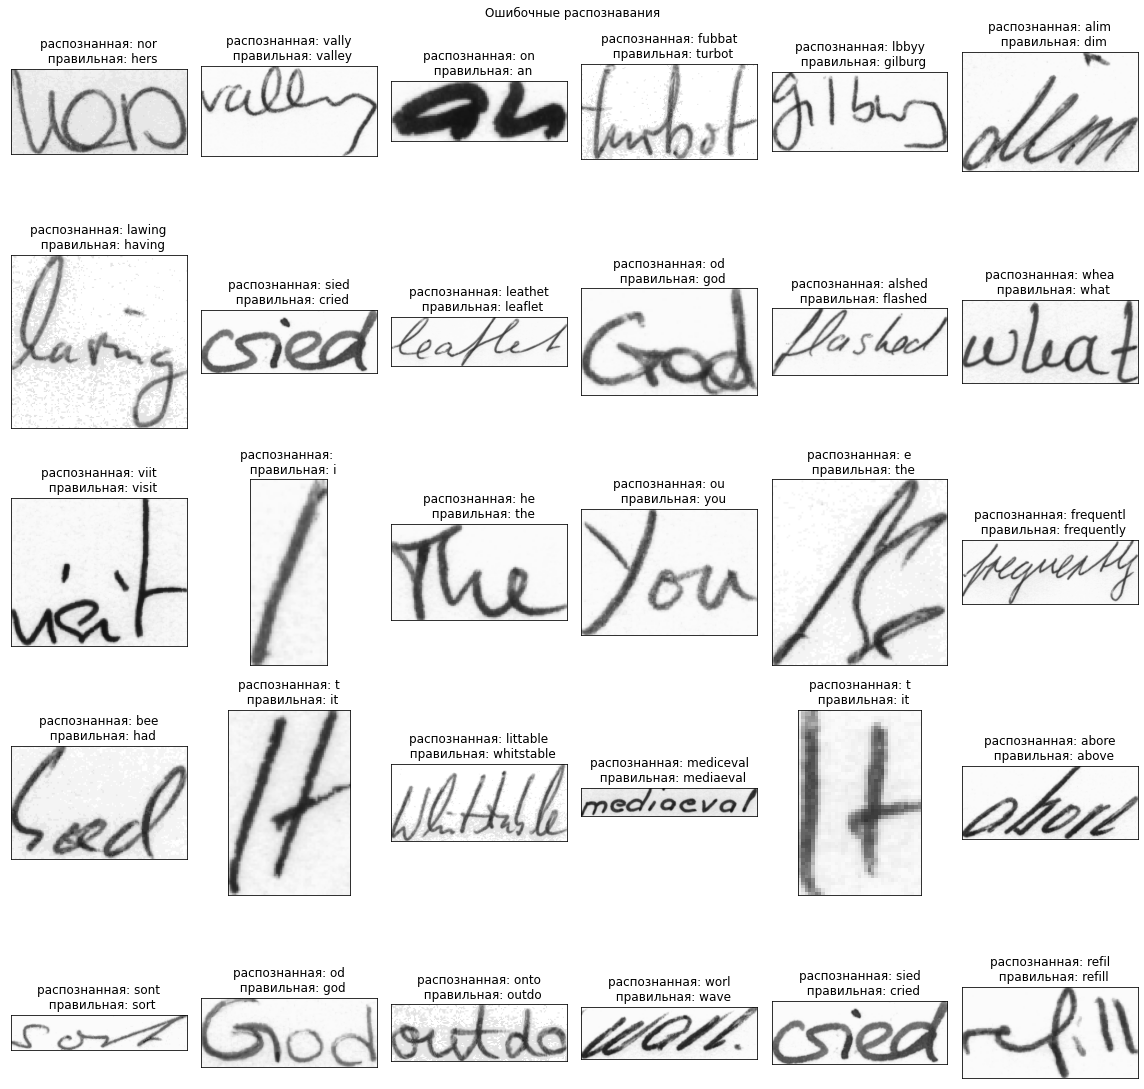

In [24]:
test_dir = '/home/astrashnov/data/rec/iam_data/test_words'
some_mistakes = random.choices(mistakes, k = 30)

plt.figure(figsize=(16, 16))
for i, (pred, target, name) in enumerate(some_mistakes):
    image = cv2.imread(os.path.join(test_dir, name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(5, 6, i + 1)
    plt.imshow(image)
    plt.title(f'распознанная: {pred}\n  правильная: {target}')
    plt.xticks([], [])
    plt.yticks([], [])
plt.suptitle('Ошибочные распознавания')
plt.tight_layout()
plt.show()

In [25]:
wrong_len_count = 0
for pred, target, _ in mistakes:
    if len(pred) != len(target):
        wrong_len_count += 1
wrong_len_percent = round(wrong_len_count / len(mistakes) * 100, 2)
print('Доля ошибок, связанных с неправильным определением длины слова: {}%'.format(wrong_len_percent))

Доля ошибок, связанных с неправильным определением длины слова: 62.84%


В данном случае ошибок, связанных с неправильным определением длины слова, большинство.